In [2]:
from json_file_func import *
from TPF import *
import pandas as pd
import numpy as np
from df_functions import *

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

In [17]:
X_file_path = r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H7\labels_count\labels_count_table.csv"
y_file_path = r"C:\final_project\H1H7 test Yonatan imputated.csv"
output_folder = r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H7\labels_count"
train_or_test = 'H7_full'
hs_md_hsmd = ''
label = 'HDRS21_Change_CenteredByStite'

In [19]:
merge_x_and_y(X_file_path, y_file_path, output_folder, train_or_test, hs_md_hsmd,label)

In [20]:
df=pd.read_csv(r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H7\labels_count\X_H7_full__on_HDRS21_Change_CenteredByStite.csv")

In [21]:
len(df)

76

In [22]:
df['subject'] = df["Id"].str[0:5]
df['HDRS21_improvement_CenteredByStite'] = df['HDRS21_Change_CenteredByStite']*(-1)
median_value = df['HDRS21_improvement_CenteredByStite'].median()


# Step 2: Create a new label column
df['above_median_HDRS21_improvement_CenteredByStite'] =  df['HDRS21_improvement_CenteredByStite'].apply(lambda x: 1.0 if x > median_value else 0.0)

<Axes: >

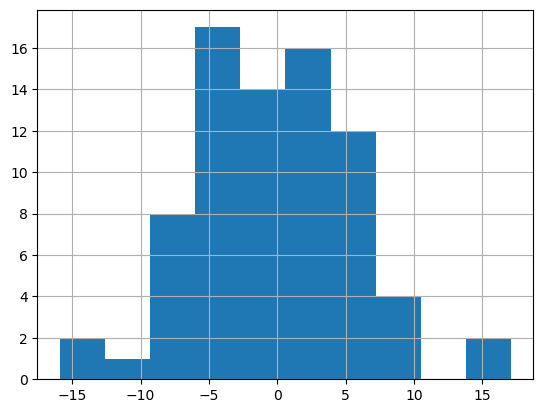

In [23]:
df['HDRS21_improvement_CenteredByStite'].hist()

In [24]:
median_value

-0.451863354

In [25]:
subject = 'subject'
label = 'above_median_HDRS21_improvement_CenteredByStite'

best_train_df, best_test_df, original_df_label_ratio, best_split_label_ratio = train_test_split_by_subject(df,label,subject,test_size=0.2, random_state=72)

In [26]:
original_df_label_ratio

0.0    0.5
1.0    0.5
Name: above_median_HDRS21_improvement_CenteredByStite, dtype: float64

In [27]:
best_split_label_ratio

1.0    0.5
0.0    0.5
Name: above_median_HDRS21_improvement_CenteredByStite, dtype: float64

In [45]:
def filter_by_percentile(df, column):
    column_data = df[column]
    threshold_high = column_data.quantile(0.65)
    threshold_low = column_data.quantile(0.35)
    filtered_df = df[(column_data > threshold_high) | (column_data < threshold_low)]
    return filtered_df

In [61]:
from sklearn.metrics import accuracy_score, recall_score

models = ['SVC','XGBoost', 'RandomForest', 'Catboost', 'TPF', 'TPF_top3', 'TPF_top5', 'TPF_top7', 'TPF_top9', 'TPF_top11', 'TPF_top13', 'TPF_top15','TPF_top17']
metrics = ['Accuracy', 'Sensitivity', 'Specificity']
predictions = {}

for model_name in models:
    predictions[model_name] = {}

    for i in range(len(df)):
        row = df.iloc[[i]]
        row_index = row.index.values[0]
        train_df = df.drop(i)  # Remove current row from the training data
        test_df = row
        train_df = filter_by_percentile(train_df, 'HDRS21_improvement_CenteredByStite')
        X_train = train_df.drop(columns=['Id','subject','above_median_HDRS21_improvement_CenteredByStite','HDRS21_Change_CenteredByStite','HDRS21_improvement_CenteredByStite'])
        X_test = test_df.drop(columns=['Id','subject','above_median_HDRS21_improvement_CenteredByStite','HDRS21_Change_CenteredByStite','HDRS21_improvement_CenteredByStite'])
        y_train = train_df["above_median_HDRS21_improvement_CenteredByStite"]
        y_test = test_df["above_median_HDRS21_improvement_CenteredByStite"]

        scaler = StandardScaler()
        scaled_X_train = scaler.fit_transform(X_train)
        scaled_X_test = scaler.transform(X_test)

        if model_name == 'XGBoost':
            model = XGBClassifier(n_estimators = 50, max_depth = 6, learning_rate =0.3)
            model.fit(scaled_X_train, y_train)
            y_pred = model.predict(scaled_X_test)
        elif model_name == 'RandomForest':
            model = RandomForestClassifier(n_estimators = 100, max_depth =6, max_features ='sqrt')
            model.fit(scaled_X_train, y_train)
            y_pred = model.predict(scaled_X_test)
        elif model_name == 'SVC':
            model = SVC()
            model.fit(scaled_X_train, y_train)
            y_pred = model.predict(scaled_X_test)
        elif model_name == 'Catboost':
            model = CatBoostClassifier(
                iterations=100,
                learning_rate=0.1,
                depth=6,
                l2_leaf_reg=1,
                random_strength=0.5,
                border_count=32,
                random_state=42
            )
            model.fit(scaled_X_train, y_train)
            y_pred = model.predict(scaled_X_test)
        elif model_name == 'TPF':
            y_pred = TPF_classifier(pd.DataFrame(scaled_X_train),y_train,pd.DataFrame(scaled_X_test),y_test)
        elif model_name == 'TPF_top3':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=3)
        elif model_name == 'TPF_top5':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=5)
        elif model_name == 'TPF_top7':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=7)
        elif model_name == 'TPF_top9':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=9)
        elif model_name == 'TPF_top11':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=11)
        elif model_name == 'TPF_top13':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=13)
        elif model_name == 'TPF_top15':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=15)
        elif model_name == 'TPF_top17':
            y_pred = tpf_topk_classifier(pd.DataFrame(scaled_X_train), y_train, pd.DataFrame(scaled_X_test), k=17)

        predictions[model_name][row_index] = y_pred

# Calculate metrics for each model based on all predictions
results = {}
for model_name in models:
    model_predictions = predictions[model_name]
    all_y_true = df['above_median_HDRS21_improvement_CenteredByStite']
    all_y_pred = [model_predictions.get(row_index) for row_index in df.index]
    
    accuracy = accuracy_score(all_y_true, all_y_pred)
    sensitivity = recall_score(all_y_true, all_y_pred)
    specificity = recall_score(all_y_true, all_y_pred, pos_label=0)

    results[model_name] = {
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity
    }

# Create a DataFrame to display the results
combined_results = pd.DataFrame.from_dict(results, orient='index')


0:	learn: 0.5738505	total: 11ms	remaining: 1.09s
1:	learn: 0.4768576	total: 20ms	remaining: 979ms
2:	learn: 0.4188014	total: 30.6ms	remaining: 989ms
3:	learn: 0.3596872	total: 39.5ms	remaining: 948ms
4:	learn: 0.3190471	total: 48.1ms	remaining: 913ms
5:	learn: 0.2747325	total: 57.4ms	remaining: 899ms
6:	learn: 0.2458411	total: 65.8ms	remaining: 874ms
7:	learn: 0.2226534	total: 74.7ms	remaining: 859ms
8:	learn: 0.1917901	total: 83.3ms	remaining: 843ms
9:	learn: 0.1686750	total: 92.9ms	remaining: 836ms
10:	learn: 0.1508431	total: 102ms	remaining: 822ms
11:	learn: 0.1372566	total: 110ms	remaining: 810ms
12:	learn: 0.1268393	total: 119ms	remaining: 796ms
13:	learn: 0.1186775	total: 127ms	remaining: 782ms
14:	learn: 0.1068679	total: 136ms	remaining: 769ms
15:	learn: 0.0983134	total: 144ms	remaining: 758ms
16:	learn: 0.0925854	total: 154ms	remaining: 752ms
17:	learn: 0.0854422	total: 164ms	remaining: 745ms
18:	learn: 0.0799606	total: 172ms	remaining: 733ms
19:	learn: 0.0742143	total: 183ms	r

70:	learn: 0.0106972	total: 774ms	remaining: 316ms
71:	learn: 0.0105101	total: 786ms	remaining: 306ms
72:	learn: 0.0103061	total: 795ms	remaining: 294ms
73:	learn: 0.0101212	total: 806ms	remaining: 283ms
74:	learn: 0.0099398	total: 821ms	remaining: 274ms
75:	learn: 0.0097661	total: 829ms	remaining: 262ms
76:	learn: 0.0095900	total: 840ms	remaining: 251ms
77:	learn: 0.0094235	total: 850ms	remaining: 240ms
78:	learn: 0.0092828	total: 859ms	remaining: 228ms
79:	learn: 0.0091218	total: 871ms	remaining: 218ms
80:	learn: 0.0089406	total: 882ms	remaining: 207ms
81:	learn: 0.0087921	total: 901ms	remaining: 198ms
82:	learn: 0.0086480	total: 910ms	remaining: 186ms
83:	learn: 0.0085013	total: 920ms	remaining: 175ms
84:	learn: 0.0083863	total: 930ms	remaining: 164ms
85:	learn: 0.0082542	total: 940ms	remaining: 153ms
86:	learn: 0.0081293	total: 949ms	remaining: 142ms
87:	learn: 0.0080237	total: 959ms	remaining: 131ms
88:	learn: 0.0079133	total: 972ms	remaining: 120ms
89:	learn: 0.0077945	total: 984

47:	learn: 0.0195434	total: 550ms	remaining: 595ms
48:	learn: 0.0189110	total: 559ms	remaining: 581ms
49:	learn: 0.0182939	total: 568ms	remaining: 568ms
50:	learn: 0.0177548	total: 582ms	remaining: 559ms
51:	learn: 0.0171966	total: 592ms	remaining: 546ms
52:	learn: 0.0166934	total: 604ms	remaining: 536ms
53:	learn: 0.0162159	total: 618ms	remaining: 527ms
54:	learn: 0.0157275	total: 626ms	remaining: 512ms
55:	learn: 0.0153004	total: 637ms	remaining: 500ms
56:	learn: 0.0148914	total: 646ms	remaining: 487ms
57:	learn: 0.0144400	total: 653ms	remaining: 473ms
58:	learn: 0.0140280	total: 665ms	remaining: 462ms
59:	learn: 0.0137187	total: 673ms	remaining: 449ms
60:	learn: 0.0133794	total: 683ms	remaining: 437ms
61:	learn: 0.0131000	total: 691ms	remaining: 423ms
62:	learn: 0.0127822	total: 704ms	remaining: 413ms
63:	learn: 0.0124350	total: 714ms	remaining: 402ms
64:	learn: 0.0121805	total: 722ms	remaining: 389ms
65:	learn: 0.0119578	total: 733ms	remaining: 377ms
66:	learn: 0.0116557	total: 741

22:	learn: 0.0618051	total: 261ms	remaining: 874ms
23:	learn: 0.0587635	total: 272ms	remaining: 860ms
24:	learn: 0.0550226	total: 281ms	remaining: 844ms
25:	learn: 0.0514786	total: 292ms	remaining: 831ms
26:	learn: 0.0481824	total: 303ms	remaining: 818ms
27:	learn: 0.0459733	total: 314ms	remaining: 807ms
28:	learn: 0.0424084	total: 323ms	remaining: 791ms
29:	learn: 0.0402127	total: 335ms	remaining: 781ms
30:	learn: 0.0386666	total: 347ms	remaining: 773ms
31:	learn: 0.0367033	total: 356ms	remaining: 756ms
32:	learn: 0.0350966	total: 367ms	remaining: 746ms
33:	learn: 0.0332155	total: 378ms	remaining: 733ms
34:	learn: 0.0314787	total: 388ms	remaining: 721ms
35:	learn: 0.0300500	total: 399ms	remaining: 710ms
36:	learn: 0.0287850	total: 410ms	remaining: 698ms
37:	learn: 0.0272612	total: 419ms	remaining: 684ms
38:	learn: 0.0261549	total: 431ms	remaining: 675ms
39:	learn: 0.0253224	total: 444ms	remaining: 667ms
40:	learn: 0.0241480	total: 456ms	remaining: 656ms
41:	learn: 0.0231134	total: 468

98:	learn: 0.0060767	total: 1.26s	remaining: 12.8ms
99:	learn: 0.0060017	total: 1.27s	remaining: 0us
0:	learn: 0.5708727	total: 11.5ms	remaining: 1.13s
1:	learn: 0.5005323	total: 19.9ms	remaining: 977ms
2:	learn: 0.4247009	total: 29.3ms	remaining: 947ms
3:	learn: 0.3596272	total: 37.7ms	remaining: 905ms
4:	learn: 0.3028153	total: 50.7ms	remaining: 963ms
5:	learn: 0.2712977	total: 59.9ms	remaining: 938ms
6:	learn: 0.2456789	total: 68.9ms	remaining: 916ms
7:	learn: 0.2174755	total: 78.3ms	remaining: 900ms
8:	learn: 0.2037590	total: 87.7ms	remaining: 886ms
9:	learn: 0.1819258	total: 96ms	remaining: 864ms
10:	learn: 0.1629182	total: 105ms	remaining: 853ms
11:	learn: 0.1443591	total: 114ms	remaining: 837ms
12:	learn: 0.1297024	total: 123ms	remaining: 821ms
13:	learn: 0.1213323	total: 131ms	remaining: 803ms
14:	learn: 0.1102031	total: 139ms	remaining: 789ms
15:	learn: 0.1001019	total: 147ms	remaining: 774ms
16:	learn: 0.0933641	total: 158ms	remaining: 773ms
17:	learn: 0.0863069	total: 170ms	

74:	learn: 0.0100922	total: 683ms	remaining: 228ms
75:	learn: 0.0098949	total: 693ms	remaining: 219ms
76:	learn: 0.0096532	total: 704ms	remaining: 210ms
77:	learn: 0.0093671	total: 713ms	remaining: 201ms
78:	learn: 0.0091997	total: 723ms	remaining: 192ms
79:	learn: 0.0089418	total: 732ms	remaining: 183ms
80:	learn: 0.0086916	total: 740ms	remaining: 174ms
81:	learn: 0.0085747	total: 749ms	remaining: 164ms
82:	learn: 0.0083978	total: 757ms	remaining: 155ms
83:	learn: 0.0081757	total: 766ms	remaining: 146ms
84:	learn: 0.0080484	total: 775ms	remaining: 137ms
85:	learn: 0.0079295	total: 784ms	remaining: 128ms
86:	learn: 0.0078421	total: 792ms	remaining: 118ms
87:	learn: 0.0076539	total: 801ms	remaining: 109ms
88:	learn: 0.0075471	total: 810ms	remaining: 100ms
89:	learn: 0.0074416	total: 818ms	remaining: 90.9ms
90:	learn: 0.0073375	total: 827ms	remaining: 81.8ms
91:	learn: 0.0072406	total: 835ms	remaining: 72.6ms
92:	learn: 0.0071452	total: 844ms	remaining: 63.5ms
93:	learn: 0.0069852	total:

45:	learn: 0.0146401	total: 420ms	remaining: 493ms
46:	learn: 0.0142201	total: 428ms	remaining: 483ms
47:	learn: 0.0137795	total: 439ms	remaining: 475ms
48:	learn: 0.0133147	total: 449ms	remaining: 468ms
49:	learn: 0.0129238	total: 458ms	remaining: 458ms
50:	learn: 0.0126070	total: 468ms	remaining: 449ms
51:	learn: 0.0122206	total: 476ms	remaining: 440ms
52:	learn: 0.0117180	total: 485ms	remaining: 430ms
53:	learn: 0.0113419	total: 495ms	remaining: 421ms
54:	learn: 0.0110504	total: 505ms	remaining: 413ms
55:	learn: 0.0105455	total: 515ms	remaining: 405ms
56:	learn: 0.0101140	total: 524ms	remaining: 395ms
57:	learn: 0.0097632	total: 534ms	remaining: 387ms
58:	learn: 0.0095376	total: 544ms	remaining: 378ms
59:	learn: 0.0093203	total: 553ms	remaining: 369ms
60:	learn: 0.0091599	total: 563ms	remaining: 360ms
61:	learn: 0.0088966	total: 572ms	remaining: 350ms
62:	learn: 0.0087153	total: 581ms	remaining: 341ms
63:	learn: 0.0085395	total: 591ms	remaining: 332ms
64:	learn: 0.0083373	total: 601

13:	learn: 0.1401745	total: 208ms	remaining: 1.28s
14:	learn: 0.1294983	total: 222ms	remaining: 1.26s
15:	learn: 0.1173197	total: 234ms	remaining: 1.23s
16:	learn: 0.1094509	total: 247ms	remaining: 1.21s
17:	learn: 0.1031341	total: 258ms	remaining: 1.18s
18:	learn: 0.0970314	total: 270ms	remaining: 1.15s
19:	learn: 0.0906228	total: 280ms	remaining: 1.12s
20:	learn: 0.0861511	total: 290ms	remaining: 1.09s
21:	learn: 0.0803755	total: 300ms	remaining: 1.06s
22:	learn: 0.0748152	total: 310ms	remaining: 1.04s
23:	learn: 0.0704573	total: 320ms	remaining: 1.01s
24:	learn: 0.0668150	total: 333ms	remaining: 998ms
25:	learn: 0.0629066	total: 344ms	remaining: 979ms
26:	learn: 0.0594076	total: 354ms	remaining: 956ms
27:	learn: 0.0555506	total: 363ms	remaining: 934ms
28:	learn: 0.0515888	total: 373ms	remaining: 914ms
29:	learn: 0.0492201	total: 383ms	remaining: 893ms
30:	learn: 0.0455866	total: 394ms	remaining: 876ms
31:	learn: 0.0428344	total: 404ms	remaining: 860ms
32:	learn: 0.0411576	total: 415

88:	learn: 0.0076431	total: 931ms	remaining: 115ms
89:	learn: 0.0075038	total: 939ms	remaining: 104ms
90:	learn: 0.0073430	total: 947ms	remaining: 93.6ms
91:	learn: 0.0071892	total: 955ms	remaining: 83.1ms
92:	learn: 0.0070428	total: 963ms	remaining: 72.5ms
93:	learn: 0.0069027	total: 972ms	remaining: 62ms
94:	learn: 0.0067694	total: 979ms	remaining: 51.5ms
95:	learn: 0.0066759	total: 987ms	remaining: 41.1ms
96:	learn: 0.0065496	total: 994ms	remaining: 30.8ms
97:	learn: 0.0064587	total: 1s	remaining: 20.4ms
98:	learn: 0.0063419	total: 1.01s	remaining: 10.2ms
99:	learn: 0.0062605	total: 1.02s	remaining: 0us
0:	learn: 0.5708727	total: 11.2ms	remaining: 1.11s
1:	learn: 0.5005323	total: 20.5ms	remaining: 1s
2:	learn: 0.4247009	total: 31.8ms	remaining: 1.03s
3:	learn: 0.3596272	total: 42.3ms	remaining: 1.01s
4:	learn: 0.3028153	total: 51.7ms	remaining: 982ms
5:	learn: 0.2712977	total: 63.1ms	remaining: 989ms
6:	learn: 0.2456789	total: 74.8ms	remaining: 993ms
7:	learn: 0.2174755	total: 85.4m

49:	learn: 0.0182939	total: 695ms	remaining: 695ms
50:	learn: 0.0177548	total: 709ms	remaining: 681ms
51:	learn: 0.0171966	total: 717ms	remaining: 662ms
52:	learn: 0.0166934	total: 731ms	remaining: 648ms
53:	learn: 0.0162159	total: 744ms	remaining: 634ms
54:	learn: 0.0157275	total: 759ms	remaining: 621ms
55:	learn: 0.0153004	total: 774ms	remaining: 608ms
56:	learn: 0.0148914	total: 791ms	remaining: 597ms
57:	learn: 0.0144400	total: 804ms	remaining: 582ms
58:	learn: 0.0140280	total: 817ms	remaining: 568ms
59:	learn: 0.0137187	total: 828ms	remaining: 552ms
60:	learn: 0.0133794	total: 842ms	remaining: 538ms
61:	learn: 0.0131000	total: 853ms	remaining: 523ms
62:	learn: 0.0127822	total: 867ms	remaining: 509ms
63:	learn: 0.0124350	total: 879ms	remaining: 494ms
64:	learn: 0.0121805	total: 894ms	remaining: 481ms
65:	learn: 0.0119578	total: 908ms	remaining: 468ms
66:	learn: 0.0116557	total: 924ms	remaining: 455ms
67:	learn: 0.0114310	total: 938ms	remaining: 441ms
68:	learn: 0.0111320	total: 950

25:	learn: 0.0537815	total: 269ms	remaining: 767ms
26:	learn: 0.0513012	total: 285ms	remaining: 772ms
27:	learn: 0.0487623	total: 297ms	remaining: 763ms
28:	learn: 0.0463259	total: 307ms	remaining: 753ms
29:	learn: 0.0433829	total: 316ms	remaining: 738ms
30:	learn: 0.0414680	total: 325ms	remaining: 724ms
31:	learn: 0.0395525	total: 336ms	remaining: 715ms
32:	learn: 0.0375958	total: 345ms	remaining: 699ms
33:	learn: 0.0356687	total: 354ms	remaining: 688ms
34:	learn: 0.0339272	total: 363ms	remaining: 674ms
35:	learn: 0.0321007	total: 372ms	remaining: 661ms
36:	learn: 0.0304969	total: 381ms	remaining: 649ms
37:	learn: 0.0291851	total: 389ms	remaining: 635ms
38:	learn: 0.0279415	total: 399ms	remaining: 625ms
39:	learn: 0.0268311	total: 408ms	remaining: 611ms
40:	learn: 0.0256161	total: 418ms	remaining: 602ms
41:	learn: 0.0244312	total: 427ms	remaining: 590ms
42:	learn: 0.0235554	total: 436ms	remaining: 579ms
43:	learn: 0.0227474	total: 445ms	remaining: 567ms
44:	learn: 0.0219143	total: 455

96:	learn: 0.0063225	total: 1.44s	remaining: 44.4ms
97:	learn: 0.0062460	total: 1.45s	remaining: 29.6ms
98:	learn: 0.0061720	total: 1.46s	remaining: 14.8ms
99:	learn: 0.0060995	total: 1.47s	remaining: 0us
0:	learn: 0.5708727	total: 15.4ms	remaining: 1.52s
1:	learn: 0.5005323	total: 31.8ms	remaining: 1.55s
2:	learn: 0.4247009	total: 47.4ms	remaining: 1.53s
3:	learn: 0.3596272	total: 57.9ms	remaining: 1.39s
4:	learn: 0.3028153	total: 70.1ms	remaining: 1.33s
5:	learn: 0.2712977	total: 81.7ms	remaining: 1.28s
6:	learn: 0.2456789	total: 92.2ms	remaining: 1.22s
7:	learn: 0.2174755	total: 106ms	remaining: 1.21s
8:	learn: 0.2037590	total: 119ms	remaining: 1.21s
9:	learn: 0.1819258	total: 133ms	remaining: 1.2s
10:	learn: 0.1629182	total: 145ms	remaining: 1.18s
11:	learn: 0.1443591	total: 156ms	remaining: 1.14s
12:	learn: 0.1297024	total: 166ms	remaining: 1.11s
13:	learn: 0.1213323	total: 179ms	remaining: 1.1s
14:	learn: 0.1102031	total: 190ms	remaining: 1.07s
15:	learn: 0.1001019	total: 201ms	r

73:	learn: 0.0107939	total: 746ms	remaining: 262ms
74:	learn: 0.0106122	total: 755ms	remaining: 252ms
75:	learn: 0.0102583	total: 764ms	remaining: 241ms
76:	learn: 0.0100967	total: 773ms	remaining: 231ms
77:	learn: 0.0099392	total: 782ms	remaining: 221ms
78:	learn: 0.0097939	total: 792ms	remaining: 210ms
79:	learn: 0.0096477	total: 800ms	remaining: 200ms
80:	learn: 0.0095049	total: 810ms	remaining: 190ms
81:	learn: 0.0093699	total: 819ms	remaining: 180ms
82:	learn: 0.0092326	total: 829ms	remaining: 170ms
83:	learn: 0.0091034	total: 839ms	remaining: 160ms
84:	learn: 0.0089786	total: 848ms	remaining: 150ms
85:	learn: 0.0088575	total: 859ms	remaining: 140ms
86:	learn: 0.0087394	total: 870ms	remaining: 130ms
87:	learn: 0.0086262	total: 878ms	remaining: 120ms
88:	learn: 0.0085157	total: 888ms	remaining: 110ms
89:	learn: 0.0084079	total: 900ms	remaining: 100ms
90:	learn: 0.0083013	total: 909ms	remaining: 89.9ms
91:	learn: 0.0081995	total: 918ms	remaining: 79.8ms
92:	learn: 0.0080999	total: 9

43:	learn: 0.0237238	total: 444ms	remaining: 565ms
44:	learn: 0.0227622	total: 453ms	remaining: 554ms
45:	learn: 0.0219933	total: 462ms	remaining: 542ms
46:	learn: 0.0210934	total: 473ms	remaining: 533ms
47:	learn: 0.0203274	total: 482ms	remaining: 523ms
48:	learn: 0.0196395	total: 493ms	remaining: 513ms
49:	learn: 0.0190091	total: 504ms	remaining: 504ms
50:	learn: 0.0185265	total: 514ms	remaining: 494ms
51:	learn: 0.0178822	total: 524ms	remaining: 484ms
52:	learn: 0.0173020	total: 535ms	remaining: 474ms
53:	learn: 0.0167236	total: 545ms	remaining: 464ms
54:	learn: 0.0162444	total: 554ms	remaining: 454ms
55:	learn: 0.0158219	total: 565ms	remaining: 444ms
56:	learn: 0.0154380	total: 575ms	remaining: 434ms
57:	learn: 0.0149569	total: 585ms	remaining: 423ms
58:	learn: 0.0146017	total: 594ms	remaining: 413ms
59:	learn: 0.0142029	total: 603ms	remaining: 402ms
60:	learn: 0.0138182	total: 612ms	remaining: 391ms
61:	learn: 0.0135289	total: 620ms	remaining: 380ms
62:	learn: 0.0132087	total: 629

12:	learn: 0.1360166	total: 131ms	remaining: 878ms
13:	learn: 0.1250765	total: 141ms	remaining: 868ms
14:	learn: 0.1136152	total: 154ms	remaining: 873ms
15:	learn: 0.1047582	total: 166ms	remaining: 874ms
16:	learn: 0.0983719	total: 177ms	remaining: 863ms
17:	learn: 0.0895959	total: 188ms	remaining: 856ms
18:	learn: 0.0841556	total: 198ms	remaining: 844ms
19:	learn: 0.0790345	total: 209ms	remaining: 836ms
20:	learn: 0.0736459	total: 220ms	remaining: 829ms
21:	learn: 0.0678461	total: 231ms	remaining: 818ms
22:	learn: 0.0625373	total: 243ms	remaining: 814ms
23:	learn: 0.0588179	total: 254ms	remaining: 805ms
24:	learn: 0.0559491	total: 266ms	remaining: 798ms
25:	learn: 0.0535475	total: 277ms	remaining: 790ms
26:	learn: 0.0503004	total: 288ms	remaining: 778ms
27:	learn: 0.0479961	total: 298ms	remaining: 766ms
28:	learn: 0.0455175	total: 307ms	remaining: 752ms
29:	learn: 0.0430576	total: 320ms	remaining: 747ms
30:	learn: 0.0411622	total: 331ms	remaining: 736ms
31:	learn: 0.0389050	total: 341

87:	learn: 0.0076328	total: 930ms	remaining: 127ms
88:	learn: 0.0075237	total: 938ms	remaining: 116ms
89:	learn: 0.0074129	total: 947ms	remaining: 105ms
90:	learn: 0.0073184	total: 955ms	remaining: 94.5ms
91:	learn: 0.0072199	total: 967ms	remaining: 84.1ms
92:	learn: 0.0071178	total: 976ms	remaining: 73.5ms
93:	learn: 0.0070307	total: 992ms	remaining: 63.3ms
94:	learn: 0.0069393	total: 1s	remaining: 52.7ms
95:	learn: 0.0068535	total: 1.01s	remaining: 42.1ms
96:	learn: 0.0067682	total: 1.02s	remaining: 31.6ms
97:	learn: 0.0066804	total: 1.03s	remaining: 21ms
98:	learn: 0.0065952	total: 1.04s	remaining: 10.5ms
99:	learn: 0.0065204	total: 1.05s	remaining: 0us
0:	learn: 0.5708727	total: 21.3ms	remaining: 2.11s
1:	learn: 0.5005323	total: 31.4ms	remaining: 1.54s
2:	learn: 0.4247009	total: 43.4ms	remaining: 1.4s
3:	learn: 0.3596272	total: 54.3ms	remaining: 1.3s
4:	learn: 0.3028153	total: 67ms	remaining: 1.27s
5:	learn: 0.2712977	total: 79.2ms	remaining: 1.24s
6:	learn: 0.2456789	total: 90.8ms

59:	learn: 0.0145402	total: 754ms	remaining: 502ms
60:	learn: 0.0141912	total: 765ms	remaining: 489ms
61:	learn: 0.0138567	total: 776ms	remaining: 475ms
62:	learn: 0.0134613	total: 788ms	remaining: 463ms
63:	learn: 0.0131007	total: 799ms	remaining: 450ms
64:	learn: 0.0127381	total: 810ms	remaining: 436ms
65:	learn: 0.0124438	total: 822ms	remaining: 423ms
66:	learn: 0.0121201	total: 833ms	remaining: 410ms
67:	learn: 0.0118629	total: 845ms	remaining: 398ms
68:	learn: 0.0115144	total: 856ms	remaining: 385ms
69:	learn: 0.0112569	total: 867ms	remaining: 372ms
70:	learn: 0.0110057	total: 878ms	remaining: 358ms
71:	learn: 0.0107480	total: 888ms	remaining: 345ms
72:	learn: 0.0104522	total: 899ms	remaining: 332ms
73:	learn: 0.0102260	total: 909ms	remaining: 319ms
74:	learn: 0.0099180	total: 920ms	remaining: 307ms
75:	learn: 0.0096954	total: 930ms	remaining: 294ms
76:	learn: 0.0094996	total: 940ms	remaining: 281ms
77:	learn: 0.0093083	total: 950ms	remaining: 268ms
78:	learn: 0.0091230	total: 962

39:	learn: 0.0268311	total: 355ms	remaining: 533ms
40:	learn: 0.0256161	total: 365ms	remaining: 525ms
41:	learn: 0.0244312	total: 375ms	remaining: 518ms
42:	learn: 0.0235554	total: 386ms	remaining: 512ms
43:	learn: 0.0227474	total: 394ms	remaining: 501ms
44:	learn: 0.0219143	total: 403ms	remaining: 493ms
45:	learn: 0.0211098	total: 411ms	remaining: 483ms
46:	learn: 0.0202026	total: 423ms	remaining: 477ms
47:	learn: 0.0195434	total: 434ms	remaining: 470ms
48:	learn: 0.0189110	total: 442ms	remaining: 460ms
49:	learn: 0.0182939	total: 453ms	remaining: 453ms
50:	learn: 0.0177548	total: 465ms	remaining: 447ms
51:	learn: 0.0171966	total: 475ms	remaining: 438ms
52:	learn: 0.0166934	total: 487ms	remaining: 432ms
53:	learn: 0.0162159	total: 499ms	remaining: 425ms
54:	learn: 0.0157275	total: 508ms	remaining: 416ms
55:	learn: 0.0153004	total: 519ms	remaining: 408ms
56:	learn: 0.0148914	total: 530ms	remaining: 400ms
57:	learn: 0.0144400	total: 540ms	remaining: 391ms
58:	learn: 0.0140280	total: 552

3:	learn: 0.3596272	total: 47.3ms	remaining: 1.13s
4:	learn: 0.3028153	total: 55.4ms	remaining: 1.05s
5:	learn: 0.2712977	total: 63.1ms	remaining: 989ms
6:	learn: 0.2456789	total: 70.8ms	remaining: 940ms
7:	learn: 0.2174755	total: 78.3ms	remaining: 900ms
8:	learn: 0.2037590	total: 86.8ms	remaining: 878ms
9:	learn: 0.1819258	total: 95.6ms	remaining: 861ms
10:	learn: 0.1629182	total: 106ms	remaining: 854ms
11:	learn: 0.1443591	total: 115ms	remaining: 845ms
12:	learn: 0.1297024	total: 123ms	remaining: 822ms
13:	learn: 0.1213323	total: 130ms	remaining: 801ms
14:	learn: 0.1102031	total: 138ms	remaining: 782ms
15:	learn: 0.1001019	total: 146ms	remaining: 765ms
16:	learn: 0.0933641	total: 154ms	remaining: 752ms
17:	learn: 0.0863069	total: 162ms	remaining: 738ms
18:	learn: 0.0812442	total: 170ms	remaining: 724ms
19:	learn: 0.0768949	total: 178ms	remaining: 713ms
20:	learn: 0.0730073	total: 186ms	remaining: 701ms
21:	learn: 0.0678918	total: 195ms	remaining: 690ms
22:	learn: 0.0649170	total: 202

70:	learn: 0.0106972	total: 705ms	remaining: 288ms
71:	learn: 0.0105101	total: 715ms	remaining: 278ms
72:	learn: 0.0103061	total: 723ms	remaining: 267ms
73:	learn: 0.0101212	total: 732ms	remaining: 257ms
74:	learn: 0.0099398	total: 740ms	remaining: 247ms
75:	learn: 0.0097661	total: 750ms	remaining: 237ms
76:	learn: 0.0095900	total: 759ms	remaining: 227ms
77:	learn: 0.0094235	total: 767ms	remaining: 216ms
78:	learn: 0.0092828	total: 775ms	remaining: 206ms
79:	learn: 0.0091218	total: 783ms	remaining: 196ms
80:	learn: 0.0089406	total: 791ms	remaining: 185ms
81:	learn: 0.0087921	total: 799ms	remaining: 175ms
82:	learn: 0.0086480	total: 807ms	remaining: 165ms
83:	learn: 0.0085013	total: 815ms	remaining: 155ms
84:	learn: 0.0083863	total: 823ms	remaining: 145ms
85:	learn: 0.0082542	total: 832ms	remaining: 135ms
86:	learn: 0.0081293	total: 841ms	remaining: 126ms
87:	learn: 0.0080237	total: 849ms	remaining: 116ms
88:	learn: 0.0079133	total: 858ms	remaining: 106ms
89:	learn: 0.0077945	total: 866

50:	learn: 0.0177548	total: 531ms	remaining: 510ms
51:	learn: 0.0171966	total: 540ms	remaining: 499ms
52:	learn: 0.0166934	total: 549ms	remaining: 487ms
53:	learn: 0.0162159	total: 558ms	remaining: 476ms
54:	learn: 0.0157275	total: 567ms	remaining: 464ms
55:	learn: 0.0153004	total: 576ms	remaining: 453ms
56:	learn: 0.0148914	total: 585ms	remaining: 441ms
57:	learn: 0.0144400	total: 596ms	remaining: 431ms
58:	learn: 0.0140280	total: 608ms	remaining: 422ms
59:	learn: 0.0137187	total: 619ms	remaining: 413ms
60:	learn: 0.0133794	total: 630ms	remaining: 403ms
61:	learn: 0.0131000	total: 642ms	remaining: 394ms
62:	learn: 0.0127822	total: 656ms	remaining: 385ms
63:	learn: 0.0124350	total: 666ms	remaining: 375ms
64:	learn: 0.0121805	total: 677ms	remaining: 365ms
65:	learn: 0.0119578	total: 688ms	remaining: 355ms
66:	learn: 0.0116557	total: 701ms	remaining: 345ms
67:	learn: 0.0114310	total: 713ms	remaining: 336ms
68:	learn: 0.0111320	total: 740ms	remaining: 333ms
69:	learn: 0.0109037	total: 758

15:	learn: 0.1001019	total: 166ms	remaining: 869ms
16:	learn: 0.0933641	total: 176ms	remaining: 860ms
17:	learn: 0.0863069	total: 186ms	remaining: 846ms
18:	learn: 0.0812442	total: 196ms	remaining: 836ms
19:	learn: 0.0768949	total: 207ms	remaining: 826ms
20:	learn: 0.0730073	total: 216ms	remaining: 814ms
21:	learn: 0.0678918	total: 227ms	remaining: 806ms
22:	learn: 0.0649170	total: 237ms	remaining: 794ms
23:	learn: 0.0615365	total: 247ms	remaining: 782ms
24:	learn: 0.0570456	total: 257ms	remaining: 772ms
25:	learn: 0.0537815	total: 269ms	remaining: 764ms
26:	learn: 0.0513012	total: 280ms	remaining: 758ms
27:	learn: 0.0487623	total: 291ms	remaining: 747ms
28:	learn: 0.0463259	total: 301ms	remaining: 737ms
29:	learn: 0.0433829	total: 311ms	remaining: 726ms
30:	learn: 0.0414680	total: 323ms	remaining: 718ms
31:	learn: 0.0395525	total: 334ms	remaining: 710ms
32:	learn: 0.0375958	total: 348ms	remaining: 707ms
33:	learn: 0.0356687	total: 358ms	remaining: 696ms
34:	learn: 0.0339272	total: 368

88:	learn: 0.0087394	total: 930ms	remaining: 115ms
89:	learn: 0.0086224	total: 939ms	remaining: 104ms
90:	learn: 0.0085064	total: 948ms	remaining: 93.8ms
91:	learn: 0.0083993	total: 957ms	remaining: 83.2ms
92:	learn: 0.0082935	total: 967ms	remaining: 72.8ms
93:	learn: 0.0081927	total: 977ms	remaining: 62.4ms
94:	learn: 0.0080957	total: 990ms	remaining: 52.1ms
95:	learn: 0.0079990	total: 1s	remaining: 41.7ms
96:	learn: 0.0078986	total: 1.01s	remaining: 31.2ms
97:	learn: 0.0078070	total: 1.02s	remaining: 20.8ms
98:	learn: 0.0077173	total: 1.03s	remaining: 10.4ms
99:	learn: 0.0076301	total: 1.04s	remaining: 0us
0:	learn: 0.5708727	total: 10.6ms	remaining: 1.05s
1:	learn: 0.5005323	total: 19.3ms	remaining: 947ms
2:	learn: 0.4247009	total: 29.1ms	remaining: 942ms
3:	learn: 0.3596272	total: 37.7ms	remaining: 905ms
4:	learn: 0.3028153	total: 46.7ms	remaining: 887ms
5:	learn: 0.2712977	total: 56.2ms	remaining: 880ms
6:	learn: 0.2456789	total: 66.6ms	remaining: 885ms
7:	learn: 0.2174755	total: 

53:	learn: 0.0162847	total: 633ms	remaining: 539ms
54:	learn: 0.0158181	total: 645ms	remaining: 528ms
55:	learn: 0.0151756	total: 659ms	remaining: 517ms
56:	learn: 0.0147733	total: 671ms	remaining: 506ms
57:	learn: 0.0143819	total: 681ms	remaining: 493ms
58:	learn: 0.0140337	total: 693ms	remaining: 482ms
59:	learn: 0.0136961	total: 705ms	remaining: 470ms
60:	learn: 0.0133692	total: 715ms	remaining: 457ms
61:	learn: 0.0130651	total: 727ms	remaining: 446ms
62:	learn: 0.0128138	total: 739ms	remaining: 434ms
63:	learn: 0.0125697	total: 750ms	remaining: 422ms
64:	learn: 0.0122624	total: 761ms	remaining: 410ms
65:	learn: 0.0120573	total: 772ms	remaining: 398ms
66:	learn: 0.0118491	total: 785ms	remaining: 387ms
67:	learn: 0.0116144	total: 797ms	remaining: 375ms
68:	learn: 0.0113334	total: 808ms	remaining: 363ms
69:	learn: 0.0111369	total: 825ms	remaining: 353ms
70:	learn: 0.0109633	total: 835ms	remaining: 341ms
71:	learn: 0.0107902	total: 846ms	remaining: 329ms
72:	learn: 0.0105883	total: 858

18:	learn: 0.0724471	total: 300ms	remaining: 1.28s
19:	learn: 0.0684340	total: 317ms	remaining: 1.27s
20:	learn: 0.0653780	total: 334ms	remaining: 1.26s
21:	learn: 0.0620212	total: 351ms	remaining: 1.24s
22:	learn: 0.0574783	total: 373ms	remaining: 1.25s
23:	learn: 0.0551544	total: 387ms	remaining: 1.23s
24:	learn: 0.0522230	total: 401ms	remaining: 1.2s
25:	learn: 0.0503254	total: 421ms	remaining: 1.2s
26:	learn: 0.0471410	total: 437ms	remaining: 1.18s
27:	learn: 0.0446534	total: 451ms	remaining: 1.16s
28:	learn: 0.0419953	total: 466ms	remaining: 1.14s
29:	learn: 0.0393961	total: 486ms	remaining: 1.13s
30:	learn: 0.0374130	total: 500ms	remaining: 1.11s
31:	learn: 0.0351459	total: 514ms	remaining: 1.09s
32:	learn: 0.0340393	total: 528ms	remaining: 1.07s
33:	learn: 0.0323520	total: 544ms	remaining: 1.05s
34:	learn: 0.0308928	total: 556ms	remaining: 1.03s
35:	learn: 0.0298971	total: 582ms	remaining: 1.03s
36:	learn: 0.0286405	total: 595ms	remaining: 1.01s
37:	learn: 0.0274753	total: 607ms

81:	learn: 0.0087921	total: 856ms	remaining: 188ms
82:	learn: 0.0086480	total: 870ms	remaining: 178ms
83:	learn: 0.0085013	total: 881ms	remaining: 168ms
84:	learn: 0.0083863	total: 891ms	remaining: 157ms
85:	learn: 0.0082542	total: 902ms	remaining: 147ms
86:	learn: 0.0081293	total: 912ms	remaining: 136ms
87:	learn: 0.0080237	total: 922ms	remaining: 126ms
88:	learn: 0.0079133	total: 933ms	remaining: 115ms
89:	learn: 0.0077945	total: 942ms	remaining: 105ms
90:	learn: 0.0076987	total: 951ms	remaining: 94.1ms
91:	learn: 0.0076046	total: 961ms	remaining: 83.5ms
92:	learn: 0.0074991	total: 970ms	remaining: 73ms
93:	learn: 0.0073932	total: 979ms	remaining: 62.5ms
94:	learn: 0.0073069	total: 988ms	remaining: 52ms
95:	learn: 0.0072083	total: 997ms	remaining: 41.6ms
96:	learn: 0.0070965	total: 1.01s	remaining: 31.1ms
97:	learn: 0.0070020	total: 1.01s	remaining: 20.7ms
98:	learn: 0.0069088	total: 1.02s	remaining: 10.4ms
99:	learn: 0.0068338	total: 1.03s	remaining: 0us
0:	learn: 0.5549884	total: 1

44:	learn: 0.0210549	total: 548ms	remaining: 670ms
45:	learn: 0.0202576	total: 559ms	remaining: 656ms
46:	learn: 0.0196407	total: 569ms	remaining: 642ms
47:	learn: 0.0185974	total: 579ms	remaining: 628ms
48:	learn: 0.0181400	total: 589ms	remaining: 613ms
49:	learn: 0.0176472	total: 599ms	remaining: 599ms
50:	learn: 0.0171670	total: 608ms	remaining: 584ms
51:	learn: 0.0167118	total: 618ms	remaining: 570ms
52:	learn: 0.0159222	total: 628ms	remaining: 557ms
53:	learn: 0.0155647	total: 637ms	remaining: 543ms
54:	learn: 0.0151855	total: 647ms	remaining: 529ms
55:	learn: 0.0147734	total: 658ms	remaining: 517ms
56:	learn: 0.0144092	total: 669ms	remaining: 504ms
57:	learn: 0.0137919	total: 683ms	remaining: 494ms
58:	learn: 0.0133206	total: 694ms	remaining: 482ms
59:	learn: 0.0130443	total: 703ms	remaining: 469ms
60:	learn: 0.0128104	total: 714ms	remaining: 457ms
61:	learn: 0.0125644	total: 725ms	remaining: 444ms
62:	learn: 0.0121184	total: 735ms	remaining: 432ms
63:	learn: 0.0119172	total: 746

25:	learn: 0.0537815	total: 217ms	remaining: 618ms
26:	learn: 0.0513012	total: 225ms	remaining: 609ms
27:	learn: 0.0487623	total: 233ms	remaining: 599ms
28:	learn: 0.0463259	total: 240ms	remaining: 588ms
29:	learn: 0.0433829	total: 248ms	remaining: 579ms
30:	learn: 0.0414680	total: 256ms	remaining: 569ms
31:	learn: 0.0395525	total: 264ms	remaining: 560ms
32:	learn: 0.0375958	total: 271ms	remaining: 551ms
33:	learn: 0.0356687	total: 280ms	remaining: 543ms
34:	learn: 0.0339272	total: 291ms	remaining: 540ms
35:	learn: 0.0321007	total: 301ms	remaining: 535ms
36:	learn: 0.0304969	total: 310ms	remaining: 528ms
37:	learn: 0.0291851	total: 319ms	remaining: 521ms
38:	learn: 0.0279415	total: 329ms	remaining: 515ms
39:	learn: 0.0268311	total: 339ms	remaining: 508ms
40:	learn: 0.0256161	total: 348ms	remaining: 501ms
41:	learn: 0.0244312	total: 357ms	remaining: 493ms
42:	learn: 0.0235554	total: 364ms	remaining: 483ms
43:	learn: 0.0227474	total: 372ms	remaining: 474ms
44:	learn: 0.0219143	total: 380

0:	learn: 0.5744136	total: 19.4ms	remaining: 1.93s
1:	learn: 0.4989416	total: 40.9ms	remaining: 2s
2:	learn: 0.4384526	total: 55.4ms	remaining: 1.79s
3:	learn: 0.3707629	total: 65.8ms	remaining: 1.58s
4:	learn: 0.3235798	total: 77.2ms	remaining: 1.47s
5:	learn: 0.2951968	total: 87.6ms	remaining: 1.37s
6:	learn: 0.2515621	total: 97.4ms	remaining: 1.29s
7:	learn: 0.2228817	total: 108ms	remaining: 1.24s
8:	learn: 0.2068735	total: 118ms	remaining: 1.19s
9:	learn: 0.1900268	total: 130ms	remaining: 1.17s
10:	learn: 0.1745904	total: 142ms	remaining: 1.15s
11:	learn: 0.1611694	total: 152ms	remaining: 1.11s
12:	learn: 0.1495393	total: 163ms	remaining: 1.09s
13:	learn: 0.1327227	total: 174ms	remaining: 1.07s
14:	learn: 0.1184381	total: 184ms	remaining: 1.04s
15:	learn: 0.1089625	total: 194ms	remaining: 1.02s
16:	learn: 0.1021082	total: 204ms	remaining: 998ms
17:	learn: 0.0943301	total: 215ms	remaining: 979ms
18:	learn: 0.0871776	total: 225ms	remaining: 961ms
19:	learn: 0.0819334	total: 236ms	rem

74:	learn: 0.0105532	total: 1.23s	remaining: 410ms
75:	learn: 0.0103867	total: 1.25s	remaining: 394ms
76:	learn: 0.0102486	total: 1.26s	remaining: 378ms
77:	learn: 0.0100735	total: 1.28s	remaining: 362ms
78:	learn: 0.0099228	total: 1.3s	remaining: 346ms
79:	learn: 0.0097981	total: 1.32s	remaining: 329ms
80:	learn: 0.0096649	total: 1.33s	remaining: 313ms
81:	learn: 0.0095403	total: 1.35s	remaining: 296ms
82:	learn: 0.0094108	total: 1.36s	remaining: 279ms
83:	learn: 0.0092849	total: 1.39s	remaining: 265ms
84:	learn: 0.0091548	total: 1.41s	remaining: 248ms
85:	learn: 0.0090356	total: 1.42s	remaining: 232ms
86:	learn: 0.0089211	total: 1.44s	remaining: 215ms
87:	learn: 0.0088074	total: 1.46s	remaining: 199ms
88:	learn: 0.0086981	total: 1.48s	remaining: 182ms
89:	learn: 0.0085916	total: 1.49s	remaining: 166ms
90:	learn: 0.0084876	total: 1.5s	remaining: 149ms
91:	learn: 0.0083881	total: 1.52s	remaining: 132ms
92:	learn: 0.0082893	total: 1.53s	remaining: 116ms
93:	learn: 0.0081931	total: 1.55s

47:	learn: 0.0215306	total: 468ms	remaining: 507ms
48:	learn: 0.0208062	total: 479ms	remaining: 499ms
49:	learn: 0.0201367	total: 492ms	remaining: 492ms
50:	learn: 0.0195089	total: 500ms	remaining: 481ms
51:	learn: 0.0187910	total: 509ms	remaining: 470ms
52:	learn: 0.0181250	total: 518ms	remaining: 459ms
53:	learn: 0.0176164	total: 527ms	remaining: 449ms
54:	learn: 0.0169826	total: 536ms	remaining: 438ms
55:	learn: 0.0164924	total: 544ms	remaining: 428ms
56:	learn: 0.0156991	total: 553ms	remaining: 418ms
57:	learn: 0.0153088	total: 563ms	remaining: 408ms
58:	learn: 0.0149370	total: 573ms	remaining: 398ms
59:	learn: 0.0145060	total: 582ms	remaining: 388ms
60:	learn: 0.0141726	total: 593ms	remaining: 379ms
61:	learn: 0.0139167	total: 604ms	remaining: 370ms
62:	learn: 0.0135334	total: 614ms	remaining: 360ms
63:	learn: 0.0131896	total: 623ms	remaining: 350ms
64:	learn: 0.0128292	total: 632ms	remaining: 340ms
65:	learn: 0.0125612	total: 640ms	remaining: 330ms
66:	learn: 0.0121694	total: 649

23:	learn: 0.0615365	total: 228ms	remaining: 721ms
24:	learn: 0.0570456	total: 238ms	remaining: 715ms
25:	learn: 0.0537815	total: 249ms	remaining: 709ms
26:	learn: 0.0513012	total: 262ms	remaining: 708ms
27:	learn: 0.0487623	total: 271ms	remaining: 696ms
28:	learn: 0.0463259	total: 280ms	remaining: 684ms
29:	learn: 0.0433829	total: 288ms	remaining: 672ms
30:	learn: 0.0414680	total: 297ms	remaining: 662ms
31:	learn: 0.0395525	total: 308ms	remaining: 654ms
32:	learn: 0.0375958	total: 317ms	remaining: 645ms
33:	learn: 0.0356687	total: 328ms	remaining: 636ms
34:	learn: 0.0339272	total: 337ms	remaining: 627ms
35:	learn: 0.0321007	total: 347ms	remaining: 617ms
36:	learn: 0.0304969	total: 357ms	remaining: 608ms
37:	learn: 0.0291851	total: 367ms	remaining: 598ms
38:	learn: 0.0279415	total: 376ms	remaining: 588ms
39:	learn: 0.0268311	total: 385ms	remaining: 577ms
40:	learn: 0.0256161	total: 393ms	remaining: 566ms
41:	learn: 0.0244312	total: 402ms	remaining: 555ms
42:	learn: 0.0235554	total: 411

85:	learn: 0.0082542	total: 893ms	remaining: 145ms
86:	learn: 0.0081293	total: 907ms	remaining: 136ms
87:	learn: 0.0080237	total: 921ms	remaining: 126ms
88:	learn: 0.0079133	total: 937ms	remaining: 116ms
89:	learn: 0.0077945	total: 949ms	remaining: 105ms
90:	learn: 0.0076987	total: 960ms	remaining: 94.9ms
91:	learn: 0.0076046	total: 970ms	remaining: 84.3ms
92:	learn: 0.0074991	total: 979ms	remaining: 73.7ms
93:	learn: 0.0073932	total: 989ms	remaining: 63.1ms
94:	learn: 0.0073069	total: 999ms	remaining: 52.6ms
95:	learn: 0.0072083	total: 1.01s	remaining: 42ms
96:	learn: 0.0070965	total: 1.02s	remaining: 31.5ms
97:	learn: 0.0070020	total: 1.03s	remaining: 21ms
98:	learn: 0.0069088	total: 1.04s	remaining: 10.5ms
99:	learn: 0.0068338	total: 1.05s	remaining: 0us
0:	learn: 0.5708727	total: 10.3ms	remaining: 1.02s
1:	learn: 0.5005323	total: 20.6ms	remaining: 1.01s
2:	learn: 0.4247009	total: 32.4ms	remaining: 1.05s
3:	learn: 0.3596272	total: 42.3ms	remaining: 1.01s
4:	learn: 0.3028153	total: 5

56:	learn: 0.0145357	total: 523ms	remaining: 394ms
57:	learn: 0.0141834	total: 533ms	remaining: 386ms
58:	learn: 0.0137992	total: 544ms	remaining: 378ms
59:	learn: 0.0134856	total: 554ms	remaining: 369ms
60:	learn: 0.0131650	total: 564ms	remaining: 360ms
61:	learn: 0.0127934	total: 573ms	remaining: 351ms
62:	learn: 0.0125522	total: 582ms	remaining: 342ms
63:	learn: 0.0121785	total: 592ms	remaining: 333ms
64:	learn: 0.0119424	total: 601ms	remaining: 324ms
65:	learn: 0.0117349	total: 610ms	remaining: 314ms
66:	learn: 0.0115194	total: 619ms	remaining: 305ms
67:	learn: 0.0113076	total: 628ms	remaining: 296ms
68:	learn: 0.0110135	total: 637ms	remaining: 286ms
69:	learn: 0.0108170	total: 646ms	remaining: 277ms
70:	learn: 0.0106153	total: 654ms	remaining: 267ms
71:	learn: 0.0104192	total: 663ms	remaining: 258ms
72:	learn: 0.0102261	total: 676ms	remaining: 250ms
73:	learn: 0.0100634	total: 685ms	remaining: 241ms
74:	learn: 0.0098386	total: 694ms	remaining: 231ms
75:	learn: 0.0097070	total: 703

27:	learn: 0.0487623	total: 319ms	remaining: 820ms
28:	learn: 0.0463259	total: 330ms	remaining: 809ms
29:	learn: 0.0433829	total: 343ms	remaining: 800ms
30:	learn: 0.0414680	total: 354ms	remaining: 789ms
31:	learn: 0.0395525	total: 365ms	remaining: 775ms
32:	learn: 0.0375958	total: 375ms	remaining: 762ms
33:	learn: 0.0356687	total: 385ms	remaining: 748ms
34:	learn: 0.0339272	total: 395ms	remaining: 734ms
35:	learn: 0.0321007	total: 405ms	remaining: 720ms
36:	learn: 0.0304969	total: 415ms	remaining: 706ms
37:	learn: 0.0291851	total: 425ms	remaining: 693ms
38:	learn: 0.0279415	total: 435ms	remaining: 680ms
39:	learn: 0.0268311	total: 445ms	remaining: 668ms
40:	learn: 0.0256161	total: 456ms	remaining: 656ms
41:	learn: 0.0244312	total: 466ms	remaining: 643ms
42:	learn: 0.0235554	total: 476ms	remaining: 631ms
43:	learn: 0.0227474	total: 486ms	remaining: 618ms
44:	learn: 0.0219143	total: 496ms	remaining: 606ms
45:	learn: 0.0211098	total: 506ms	remaining: 594ms
46:	learn: 0.0202026	total: 517

90:	learn: 0.0088489	total: 861ms	remaining: 85.1ms
91:	learn: 0.0087448	total: 871ms	remaining: 75.7ms
92:	learn: 0.0086438	total: 881ms	remaining: 66.3ms
93:	learn: 0.0085446	total: 890ms	remaining: 56.8ms
94:	learn: 0.0084479	total: 899ms	remaining: 47.3ms
95:	learn: 0.0083379	total: 908ms	remaining: 37.8ms
96:	learn: 0.0082467	total: 916ms	remaining: 28.3ms
97:	learn: 0.0081409	total: 925ms	remaining: 18.9ms
98:	learn: 0.0080388	total: 933ms	remaining: 9.43ms
99:	learn: 0.0079630	total: 942ms	remaining: 0us
0:	learn: 0.5825320	total: 11.7ms	remaining: 1.16s
1:	learn: 0.5039804	total: 22.5ms	remaining: 1.1s
2:	learn: 0.4472696	total: 34.4ms	remaining: 1.11s
3:	learn: 0.3727452	total: 44ms	remaining: 1.05s
4:	learn: 0.3135559	total: 53.7ms	remaining: 1.02s
5:	learn: 0.2789136	total: 63.5ms	remaining: 995ms
6:	learn: 0.2461141	total: 73.1ms	remaining: 971ms
7:	learn: 0.2186117	total: 84.5ms	remaining: 972ms
8:	learn: 0.1933725	total: 97.1ms	remaining: 982ms
9:	learn: 0.1792150	total: 

65:	learn: 0.0119578	total: 645ms	remaining: 332ms
66:	learn: 0.0116557	total: 655ms	remaining: 323ms
67:	learn: 0.0114310	total: 671ms	remaining: 316ms
68:	learn: 0.0111320	total: 680ms	remaining: 305ms
69:	learn: 0.0109037	total: 689ms	remaining: 295ms
70:	learn: 0.0106972	total: 698ms	remaining: 285ms
71:	learn: 0.0105101	total: 707ms	remaining: 275ms
72:	learn: 0.0103061	total: 716ms	remaining: 265ms
73:	learn: 0.0101212	total: 725ms	remaining: 255ms
74:	learn: 0.0099398	total: 735ms	remaining: 245ms
75:	learn: 0.0097661	total: 744ms	remaining: 235ms
76:	learn: 0.0095900	total: 755ms	remaining: 225ms
77:	learn: 0.0094235	total: 764ms	remaining: 215ms
78:	learn: 0.0092828	total: 773ms	remaining: 205ms
79:	learn: 0.0091218	total: 796ms	remaining: 199ms
80:	learn: 0.0089406	total: 804ms	remaining: 189ms
81:	learn: 0.0087921	total: 813ms	remaining: 178ms
82:	learn: 0.0086480	total: 822ms	remaining: 168ms
83:	learn: 0.0085013	total: 844ms	remaining: 161ms
84:	learn: 0.0083863	total: 853

47:	learn: 0.0204239	total: 437ms	remaining: 473ms
48:	learn: 0.0197948	total: 447ms	remaining: 465ms
49:	learn: 0.0191206	total: 458ms	remaining: 458ms
50:	learn: 0.0185688	total: 471ms	remaining: 453ms
51:	learn: 0.0177870	total: 481ms	remaining: 444ms
52:	learn: 0.0171953	total: 490ms	remaining: 435ms
53:	learn: 0.0164363	total: 500ms	remaining: 426ms
54:	learn: 0.0159947	total: 509ms	remaining: 416ms
55:	learn: 0.0156029	total: 518ms	remaining: 407ms
56:	learn: 0.0149840	total: 527ms	remaining: 397ms
57:	learn: 0.0145532	total: 536ms	remaining: 388ms
58:	learn: 0.0141625	total: 545ms	remaining: 379ms
59:	learn: 0.0138041	total: 555ms	remaining: 370ms
60:	learn: 0.0134977	total: 565ms	remaining: 361ms
61:	learn: 0.0131395	total: 574ms	remaining: 352ms
62:	learn: 0.0128351	total: 583ms	remaining: 342ms
63:	learn: 0.0123577	total: 592ms	remaining: 333ms
64:	learn: 0.0120600	total: 601ms	remaining: 324ms
65:	learn: 0.0117855	total: 610ms	remaining: 314ms
66:	learn: 0.0115679	total: 619

25:	learn: 0.0578102	total: 221ms	remaining: 629ms
26:	learn: 0.0539463	total: 232ms	remaining: 626ms
27:	learn: 0.0502031	total: 242ms	remaining: 622ms
28:	learn: 0.0473024	total: 251ms	remaining: 616ms
29:	learn: 0.0446353	total: 261ms	remaining: 608ms
30:	learn: 0.0423770	total: 269ms	remaining: 599ms
31:	learn: 0.0404018	total: 278ms	remaining: 590ms
32:	learn: 0.0390455	total: 286ms	remaining: 580ms
33:	learn: 0.0366705	total: 294ms	remaining: 571ms
34:	learn: 0.0353303	total: 303ms	remaining: 563ms
35:	learn: 0.0333213	total: 312ms	remaining: 555ms
36:	learn: 0.0317921	total: 321ms	remaining: 546ms
37:	learn: 0.0304596	total: 329ms	remaining: 537ms
38:	learn: 0.0293194	total: 338ms	remaining: 528ms
39:	learn: 0.0281944	total: 347ms	remaining: 520ms
40:	learn: 0.0271628	total: 355ms	remaining: 511ms
41:	learn: 0.0257069	total: 366ms	remaining: 506ms
42:	learn: 0.0246934	total: 375ms	remaining: 497ms
43:	learn: 0.0234889	total: 384ms	remaining: 488ms
44:	learn: 0.0223711	total: 392

0:	learn: 0.5708727	total: 10.7ms	remaining: 1.06s
1:	learn: 0.5005323	total: 19.6ms	remaining: 962ms
2:	learn: 0.4247009	total: 29.1ms	remaining: 940ms
3:	learn: 0.3596272	total: 38.2ms	remaining: 916ms
4:	learn: 0.3028153	total: 48.9ms	remaining: 928ms
5:	learn: 0.2712977	total: 59.6ms	remaining: 934ms
6:	learn: 0.2456789	total: 70.2ms	remaining: 932ms
7:	learn: 0.2174755	total: 79.5ms	remaining: 914ms
8:	learn: 0.2037590	total: 89.1ms	remaining: 900ms
9:	learn: 0.1819258	total: 99.3ms	remaining: 894ms
10:	learn: 0.1629182	total: 109ms	remaining: 882ms
11:	learn: 0.1443591	total: 118ms	remaining: 865ms
12:	learn: 0.1297024	total: 127ms	remaining: 847ms
13:	learn: 0.1213323	total: 135ms	remaining: 831ms
14:	learn: 0.1102031	total: 144ms	remaining: 815ms
15:	learn: 0.1001019	total: 153ms	remaining: 802ms
16:	learn: 0.0933641	total: 162ms	remaining: 789ms
17:	learn: 0.0863069	total: 170ms	remaining: 775ms
18:	learn: 0.0812442	total: 180ms	remaining: 766ms
19:	learn: 0.0768949	total: 188

76:	learn: 0.0097294	total: 717ms	remaining: 214ms
77:	learn: 0.0095269	total: 727ms	remaining: 205ms
78:	learn: 0.0092208	total: 737ms	remaining: 196ms
79:	learn: 0.0090787	total: 747ms	remaining: 187ms
80:	learn: 0.0089411	total: 757ms	remaining: 178ms
81:	learn: 0.0088094	total: 767ms	remaining: 168ms
82:	learn: 0.0086805	total: 776ms	remaining: 159ms
83:	learn: 0.0085573	total: 785ms	remaining: 149ms
84:	learn: 0.0084522	total: 793ms	remaining: 140ms
85:	learn: 0.0083342	total: 802ms	remaining: 131ms
86:	learn: 0.0082216	total: 811ms	remaining: 121ms
87:	learn: 0.0081104	total: 820ms	remaining: 112ms
88:	learn: 0.0080041	total: 828ms	remaining: 102ms
89:	learn: 0.0079000	total: 837ms	remaining: 93ms
90:	learn: 0.0077998	total: 845ms	remaining: 83.6ms
91:	learn: 0.0077015	total: 854ms	remaining: 74.3ms
92:	learn: 0.0076066	total: 862ms	remaining: 64.9ms
93:	learn: 0.0075142	total: 871ms	remaining: 55.6ms
94:	learn: 0.0073215	total: 880ms	remaining: 46.3ms
95:	learn: 0.0072352	total:

37:	learn: 0.0278732	total: 444ms	remaining: 725ms
38:	learn: 0.0264754	total: 458ms	remaining: 716ms
39:	learn: 0.0256133	total: 471ms	remaining: 706ms
40:	learn: 0.0246152	total: 481ms	remaining: 693ms
41:	learn: 0.0234441	total: 492ms	remaining: 679ms
42:	learn: 0.0226606	total: 503ms	remaining: 667ms
43:	learn: 0.0215442	total: 514ms	remaining: 654ms
44:	learn: 0.0207077	total: 524ms	remaining: 640ms
45:	learn: 0.0199501	total: 535ms	remaining: 628ms
46:	learn: 0.0193294	total: 548ms	remaining: 617ms
47:	learn: 0.0186421	total: 559ms	remaining: 606ms
48:	learn: 0.0180576	total: 570ms	remaining: 593ms
49:	learn: 0.0174771	total: 580ms	remaining: 580ms
50:	learn: 0.0168888	total: 591ms	remaining: 568ms
51:	learn: 0.0163122	total: 603ms	remaining: 556ms
52:	learn: 0.0157372	total: 615ms	remaining: 546ms
53:	learn: 0.0153274	total: 627ms	remaining: 535ms
54:	learn: 0.0149202	total: 638ms	remaining: 522ms
55:	learn: 0.0142906	total: 649ms	remaining: 510ms
56:	learn: 0.0139623	total: 660

4:	learn: 0.3287425	total: 57.4ms	remaining: 1.09s
5:	learn: 0.2828487	total: 70ms	remaining: 1.09s
6:	learn: 0.2547663	total: 83.3ms	remaining: 1.11s
7:	learn: 0.2218892	total: 95.2ms	remaining: 1.09s
8:	learn: 0.1978952	total: 106ms	remaining: 1.07s
9:	learn: 0.1814570	total: 117ms	remaining: 1.05s
10:	learn: 0.1542773	total: 127ms	remaining: 1.02s
11:	learn: 0.1414328	total: 136ms	remaining: 1s
12:	learn: 0.1282780	total: 147ms	remaining: 981ms
13:	learn: 0.1212440	total: 157ms	remaining: 962ms
14:	learn: 0.1107086	total: 168ms	remaining: 949ms
15:	learn: 0.1013633	total: 177ms	remaining: 932ms
16:	learn: 0.0952398	total: 187ms	remaining: 914ms
17:	learn: 0.0870599	total: 197ms	remaining: 898ms
18:	learn: 0.0792966	total: 208ms	remaining: 886ms
19:	learn: 0.0755270	total: 219ms	remaining: 876ms
20:	learn: 0.0702278	total: 229ms	remaining: 861ms
21:	learn: 0.0658377	total: 239ms	remaining: 846ms
22:	learn: 0.0626790	total: 249ms	remaining: 835ms
23:	learn: 0.0592759	total: 259ms	rema

66:	learn: 0.0116513	total: 687ms	remaining: 339ms
67:	learn: 0.0114532	total: 698ms	remaining: 329ms
68:	learn: 0.0111698	total: 711ms	remaining: 319ms
69:	learn: 0.0110086	total: 722ms	remaining: 310ms
70:	learn: 0.0108087	total: 733ms	remaining: 299ms
71:	learn: 0.0105973	total: 745ms	remaining: 290ms
72:	learn: 0.0104382	total: 756ms	remaining: 280ms
73:	learn: 0.0102911	total: 768ms	remaining: 270ms
74:	learn: 0.0101070	total: 779ms	remaining: 260ms
75:	learn: 0.0099685	total: 789ms	remaining: 249ms
76:	learn: 0.0097934	total: 799ms	remaining: 239ms
77:	learn: 0.0096706	total: 809ms	remaining: 228ms
78:	learn: 0.0095388	total: 819ms	remaining: 218ms
79:	learn: 0.0094060	total: 828ms	remaining: 207ms
80:	learn: 0.0092450	total: 838ms	remaining: 196ms
81:	learn: 0.0091290	total: 847ms	remaining: 186ms
82:	learn: 0.0090254	total: 856ms	remaining: 175ms
83:	learn: 0.0088750	total: 866ms	remaining: 165ms
84:	learn: 0.0087706	total: 875ms	remaining: 154ms
85:	learn: 0.0086716	total: 885

37:	learn: 0.0291851	total: 357ms	remaining: 583ms
38:	learn: 0.0279415	total: 368ms	remaining: 576ms
39:	learn: 0.0268311	total: 380ms	remaining: 570ms
40:	learn: 0.0256161	total: 389ms	remaining: 560ms
41:	learn: 0.0244312	total: 399ms	remaining: 550ms
42:	learn: 0.0235554	total: 408ms	remaining: 541ms
43:	learn: 0.0227474	total: 417ms	remaining: 530ms
44:	learn: 0.0219143	total: 425ms	remaining: 520ms
45:	learn: 0.0211098	total: 434ms	remaining: 509ms
46:	learn: 0.0202026	total: 443ms	remaining: 499ms
47:	learn: 0.0195434	total: 451ms	remaining: 489ms
48:	learn: 0.0189110	total: 460ms	remaining: 479ms
49:	learn: 0.0182939	total: 468ms	remaining: 468ms
50:	learn: 0.0177548	total: 478ms	remaining: 459ms
51:	learn: 0.0171966	total: 487ms	remaining: 449ms
52:	learn: 0.0166934	total: 496ms	remaining: 440ms
53:	learn: 0.0162159	total: 506ms	remaining: 431ms
54:	learn: 0.0157275	total: 516ms	remaining: 422ms
55:	learn: 0.0153004	total: 526ms	remaining: 413ms
56:	learn: 0.0148914	total: 535

In [62]:
combined_results

Accuracy  Sensitivity  Specificity
SVC           0.526316     0.368421     0.684211
XGBoost       0.631579     0.631579     0.631579
RandomForest  0.552632     0.473684     0.631579
Catboost      0.513158     0.500000     0.526316
TPF           0.578947     0.578947     0.578947
TPF_top3      0.552632     0.736842     0.368421
TPF_top5      0.578947     0.789474     0.368421
TPF_top7      0.552632     0.868421     0.236842
TPF_top9      0.526316     0.868421     0.184211
TPF_top11     0.473684     0.815789     0.131579
TPF_top13     0.473684     0.842105     0.105263
TPF_top15     0.486842     0.842105     0.131579
TPF_top17     0.486842     0.894737     0.078947

In [40]:
combined_results.to_csv(r"C:\final_project\freqs_power_model\freqs_power_abs_ThABG_200ms_L0123\H7\result_tables\H7_full_above_median_HDRS21_imrovement_by_site_filtered_percent_ASS_LOO7030.csv")

In [43]:
len(df['above_median_HDRS21_improvement_CenteredByStite'])

76

In [44]:
sum(df['above_median_HDRS21_improvement_CenteredByStite'])

38.0

In [91]:
param_grid = {
    'n_estimators': [50,60,70,80, 100],
    'max_depth': [3,4,5, 6],
    'learning_rate': [0.1, 0.3,0.05]
}
X = df.drop(columns=['Id','subject','above_median_HDRS21_Improvement','HDRS21_Improvement'])
y = df["above_median_HDRS21_Improvement"]


scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

model = XGBClassifier()
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
grid_search.fit(scaled_X, y)
best_model = grid_search.best_estimator_

In [92]:
best_model.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=70, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)>

In [96]:
param_grid = {
    'n_estimators': [50,60,70,80,90, 100],
    'max_depth': [3,4,5, 6],
    'max_features': ['sqrt', 'log2']
}
X = df.drop(columns=['Id','subject','above_median_HDRS21_Improvement','HDRS21_Improvement'])
y = df["above_median_HDRS21_Improvement"]


scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
grid_search.fit(scaled_X, y)
best_model = grid_search.best_estimator_

In [97]:
best_model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=6)>

In [ ]:
param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.1, 0.3],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3],
    'random_strength': [0.5, 1],
    'border_count': [32, 64]
    'verbose': [0]
}
X = df.drop(columns=['Id','subject','above_median_HDRS21_Improvement','HDRS21_Improvement'])
y = df["above_median_HDRS21_Improvement"]


scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

model = CatBoostClassifier()
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
grid_search.fit(scaled_X, y)
best_model = grid_search.best_estimator_

0:	learn: 0.6257397	total: 156ms	remaining: 15.5s
1:	learn: 0.5460424	total: 161ms	remaining: 7.9s
2:	learn: 0.4777623	total: 166ms	remaining: 5.36s
3:	learn: 0.4358451	total: 171ms	remaining: 4.1s
4:	learn: 0.3781316	total: 176ms	remaining: 3.34s
5:	learn: 0.3435394	total: 181ms	remaining: 2.83s
6:	learn: 0.3155627	total: 186ms	remaining: 2.47s
7:	learn: 0.2923413	total: 191ms	remaining: 2.2s
8:	learn: 0.2585288	total: 196ms	remaining: 1.99s
9:	learn: 0.2425534	total: 201ms	remaining: 1.81s
10:	learn: 0.2222071	total: 205ms	remaining: 1.66s
11:	learn: 0.1979262	total: 210ms	remaining: 1.54s
12:	learn: 0.1836952	total: 214ms	remaining: 1.43s
13:	learn: 0.1682746	total: 218ms	remaining: 1.34s
14:	learn: 0.1455748	total: 223ms	remaining: 1.26s
15:	learn: 0.1366357	total: 228ms	remaining: 1.2s
16:	learn: 0.1284414	total: 233ms	remaining: 1.14s
17:	learn: 0.1180796	total: 238ms	remaining: 1.08s
18:	learn: 0.1102340	total: 243ms	remaining: 1.03s
19:	learn: 0.1043426	total: 247ms	remaining: 

92:	learn: 0.0045580	total: 675ms	remaining: 50.8ms
93:	learn: 0.0044423	total: 683ms	remaining: 43.6ms
94:	learn: 0.0042909	total: 690ms	remaining: 36.3ms
95:	learn: 0.0042069	total: 699ms	remaining: 29.1ms
96:	learn: 0.0041549	total: 705ms	remaining: 21.8ms
97:	learn: 0.0040588	total: 711ms	remaining: 14.5ms
98:	learn: 0.0039320	total: 721ms	remaining: 7.29ms
99:	learn: 0.0038867	total: 728ms	remaining: 0us
0:	learn: 0.6099488	total: 6.85ms	remaining: 678ms
1:	learn: 0.5563696	total: 12.1ms	remaining: 593ms
2:	learn: 0.5095301	total: 18.5ms	remaining: 598ms
3:	learn: 0.4519527	total: 24.3ms	remaining: 583ms
4:	learn: 0.4107743	total: 30.4ms	remaining: 578ms
5:	learn: 0.3735825	total: 36.4ms	remaining: 570ms
6:	learn: 0.3337096	total: 42.6ms	remaining: 566ms
7:	learn: 0.3085051	total: 48.6ms	remaining: 559ms
8:	learn: 0.2825617	total: 55ms	remaining: 556ms
9:	learn: 0.2583413	total: 60.6ms	remaining: 545ms
10:	learn: 0.2410438	total: 67ms	remaining: 542ms
11:	learn: 0.2212628	total: 7

84:	learn: 0.0060371	total: 449ms	remaining: 79.2ms
85:	learn: 0.0058936	total: 454ms	remaining: 73.9ms
86:	learn: 0.0057270	total: 459ms	remaining: 68.7ms
87:	learn: 0.0056014	total: 466ms	remaining: 63.6ms
88:	learn: 0.0054874	total: 471ms	remaining: 58.3ms
89:	learn: 0.0053537	total: 476ms	remaining: 52.9ms
90:	learn: 0.0052704	total: 482ms	remaining: 47.7ms
91:	learn: 0.0051305	total: 488ms	remaining: 42.5ms
92:	learn: 0.0049734	total: 494ms	remaining: 37.2ms
93:	learn: 0.0048442	total: 499ms	remaining: 31.9ms
94:	learn: 0.0047078	total: 504ms	remaining: 26.6ms
95:	learn: 0.0046032	total: 510ms	remaining: 21.3ms
96:	learn: 0.0044823	total: 517ms	remaining: 16ms
97:	learn: 0.0043909	total: 524ms	remaining: 10.7ms
98:	learn: 0.0043311	total: 528ms	remaining: 5.34ms
99:	learn: 0.0042700	total: 533ms	remaining: 0us
0:	learn: 0.6228655	total: 7.09ms	remaining: 702ms
1:	learn: 0.5734719	total: 12.6ms	remaining: 617ms
2:	learn: 0.5170860	total: 18ms	remaining: 581ms
3:	learn: 0.4579976	to

46:	learn: 0.0199039	total: 311ms	remaining: 351ms
47:	learn: 0.0186856	total: 318ms	remaining: 344ms
48:	learn: 0.0178057	total: 324ms	remaining: 337ms
49:	learn: 0.0170702	total: 332ms	remaining: 332ms
50:	learn: 0.0161596	total: 338ms	remaining: 325ms
51:	learn: 0.0152777	total: 344ms	remaining: 318ms
52:	learn: 0.0146945	total: 350ms	remaining: 310ms
53:	learn: 0.0137904	total: 356ms	remaining: 303ms
54:	learn: 0.0131670	total: 362ms	remaining: 296ms
55:	learn: 0.0125441	total: 368ms	remaining: 289ms
56:	learn: 0.0120363	total: 374ms	remaining: 282ms
57:	learn: 0.0114912	total: 380ms	remaining: 275ms
58:	learn: 0.0111527	total: 386ms	remaining: 268ms
59:	learn: 0.0106858	total: 391ms	remaining: 261ms
60:	learn: 0.0102032	total: 397ms	remaining: 254ms
61:	learn: 0.0097452	total: 403ms	remaining: 247ms
62:	learn: 0.0094445	total: 408ms	remaining: 240ms
63:	learn: 0.0091168	total: 414ms	remaining: 233ms
64:	learn: 0.0087425	total: 420ms	remaining: 226ms
65:	learn: 0.0084729	total: 426

36:	learn: 0.0502344	total: 235ms	remaining: 400ms
37:	learn: 0.0477445	total: 243ms	remaining: 396ms
38:	learn: 0.0452859	total: 250ms	remaining: 391ms
39:	learn: 0.0432027	total: 257ms	remaining: 386ms
40:	learn: 0.0404990	total: 264ms	remaining: 380ms
41:	learn: 0.0383570	total: 270ms	remaining: 373ms
42:	learn: 0.0364197	total: 276ms	remaining: 366ms
43:	learn: 0.0345242	total: 282ms	remaining: 359ms
44:	learn: 0.0326025	total: 288ms	remaining: 352ms
45:	learn: 0.0309665	total: 294ms	remaining: 345ms
46:	learn: 0.0298912	total: 300ms	remaining: 339ms
47:	learn: 0.0285003	total: 307ms	remaining: 332ms
48:	learn: 0.0273598	total: 313ms	remaining: 326ms
49:	learn: 0.0262962	total: 319ms	remaining: 319ms
50:	learn: 0.0246970	total: 325ms	remaining: 312ms
51:	learn: 0.0234379	total: 331ms	remaining: 306ms
52:	learn: 0.0222986	total: 339ms	remaining: 300ms
53:	learn: 0.0210838	total: 347ms	remaining: 296ms
54:	learn: 0.0201113	total: 355ms	remaining: 290ms
55:	learn: 0.0190785	total: 362

4:	learn: 0.3710592	total: 47.6ms	remaining: 905ms
5:	learn: 0.3466663	total: 55.6ms	remaining: 872ms
6:	learn: 0.3050084	total: 62.7ms	remaining: 833ms
7:	learn: 0.2689296	total: 69.5ms	remaining: 799ms
8:	learn: 0.2462979	total: 76.7ms	remaining: 775ms
9:	learn: 0.2324502	total: 82.6ms	remaining: 743ms
10:	learn: 0.2123223	total: 88.2ms	remaining: 714ms
11:	learn: 0.1982089	total: 93.5ms	remaining: 685ms
12:	learn: 0.1804142	total: 99ms	remaining: 663ms
13:	learn: 0.1605755	total: 105ms	remaining: 646ms
14:	learn: 0.1511561	total: 111ms	remaining: 630ms
15:	learn: 0.1404015	total: 117ms	remaining: 614ms
16:	learn: 0.1266265	total: 123ms	remaining: 599ms
17:	learn: 0.1197147	total: 128ms	remaining: 585ms
18:	learn: 0.1065828	total: 135ms	remaining: 574ms
19:	learn: 0.0995806	total: 141ms	remaining: 564ms
20:	learn: 0.0916341	total: 147ms	remaining: 553ms
21:	learn: 0.0851165	total: 153ms	remaining: 541ms
22:	learn: 0.0795426	total: 159ms	remaining: 532ms
23:	learn: 0.0738605	total: 16

65:	learn: 0.0151211	total: 425ms	remaining: 219ms
66:	learn: 0.0143383	total: 433ms	remaining: 213ms
67:	learn: 0.0137230	total: 439ms	remaining: 207ms
68:	learn: 0.0130677	total: 446ms	remaining: 200ms
69:	learn: 0.0124829	total: 453ms	remaining: 194ms
70:	learn: 0.0120784	total: 460ms	remaining: 188ms
71:	learn: 0.0115300	total: 467ms	remaining: 182ms
72:	learn: 0.0108869	total: 474ms	remaining: 175ms
73:	learn: 0.0105890	total: 479ms	remaining: 168ms
74:	learn: 0.0101697	total: 486ms	remaining: 162ms
75:	learn: 0.0096751	total: 492ms	remaining: 155ms
76:	learn: 0.0093157	total: 503ms	remaining: 150ms
77:	learn: 0.0089104	total: 510ms	remaining: 144ms
78:	learn: 0.0087023	total: 517ms	remaining: 137ms
79:	learn: 0.0083621	total: 523ms	remaining: 131ms
80:	learn: 0.0080092	total: 530ms	remaining: 124ms
81:	learn: 0.0078014	total: 535ms	remaining: 118ms
82:	learn: 0.0075108	total: 542ms	remaining: 111ms
83:	learn: 0.0072494	total: 547ms	remaining: 104ms
84:	learn: 0.0070771	total: 554

28:	learn: 0.1103036	total: 216ms	remaining: 528ms
29:	learn: 0.1071000	total: 223ms	remaining: 521ms
30:	learn: 0.1026971	total: 230ms	remaining: 512ms
31:	learn: 0.0999695	total: 238ms	remaining: 506ms
32:	learn: 0.0935493	total: 244ms	remaining: 495ms
33:	learn: 0.0907534	total: 250ms	remaining: 486ms
34:	learn: 0.0860353	total: 257ms	remaining: 476ms
35:	learn: 0.0823034	total: 263ms	remaining: 467ms
36:	learn: 0.0789136	total: 269ms	remaining: 458ms
37:	learn: 0.0751641	total: 275ms	remaining: 449ms
38:	learn: 0.0702569	total: 281ms	remaining: 440ms
39:	learn: 0.0680283	total: 288ms	remaining: 431ms
40:	learn: 0.0652115	total: 294ms	remaining: 423ms
41:	learn: 0.0607993	total: 300ms	remaining: 415ms
42:	learn: 0.0575537	total: 306ms	remaining: 406ms
43:	learn: 0.0537219	total: 312ms	remaining: 398ms
44:	learn: 0.0509755	total: 319ms	remaining: 390ms
45:	learn: 0.0476905	total: 325ms	remaining: 382ms
46:	learn: 0.0444884	total: 331ms	remaining: 373ms
47:	learn: 0.0420864	total: 337

95:	learn: 0.0059066	total: 562ms	remaining: 23.4ms
96:	learn: 0.0057719	total: 570ms	remaining: 17.6ms
97:	learn: 0.0056434	total: 576ms	remaining: 11.8ms
98:	learn: 0.0055221	total: 583ms	remaining: 5.89ms
99:	learn: 0.0053833	total: 589ms	remaining: 0us
0:	learn: 0.6571770	total: 7.64ms	remaining: 756ms
1:	learn: 0.6040502	total: 14ms	remaining: 684ms
2:	learn: 0.5688275	total: 20.9ms	remaining: 675ms
3:	learn: 0.5242912	total: 26.9ms	remaining: 647ms
4:	learn: 0.4957937	total: 33.3ms	remaining: 632ms
5:	learn: 0.4720666	total: 40ms	remaining: 626ms
6:	learn: 0.4432088	total: 45.9ms	remaining: 610ms
7:	learn: 0.4159667	total: 52ms	remaining: 598ms
8:	learn: 0.3821834	total: 58ms	remaining: 586ms
9:	learn: 0.3541785	total: 64.6ms	remaining: 581ms
10:	learn: 0.3329534	total: 70.6ms	remaining: 571ms
11:	learn: 0.3161546	total: 77.1ms	remaining: 565ms
12:	learn: 0.2925613	total: 83.6ms	remaining: 559ms
13:	learn: 0.2796235	total: 90ms	remaining: 553ms
14:	learn: 0.2656045	total: 96ms	re

84:	learn: 0.0068390	total: 459ms	remaining: 80.9ms
85:	learn: 0.0066276	total: 464ms	remaining: 75.5ms
86:	learn: 0.0064577	total: 469ms	remaining: 70.1ms
87:	learn: 0.0062795	total: 474ms	remaining: 64.7ms
88:	learn: 0.0061089	total: 481ms	remaining: 59.4ms
89:	learn: 0.0060029	total: 486ms	remaining: 54ms
90:	learn: 0.0059068	total: 491ms	remaining: 48.6ms
91:	learn: 0.0057149	total: 496ms	remaining: 43.1ms
92:	learn: 0.0055759	total: 501ms	remaining: 37.7ms
93:	learn: 0.0054287	total: 506ms	remaining: 32.3ms
94:	learn: 0.0052702	total: 511ms	remaining: 26.9ms
95:	learn: 0.0051501	total: 516ms	remaining: 21.5ms
96:	learn: 0.0050273	total: 521ms	remaining: 16.1ms
97:	learn: 0.0048984	total: 526ms	remaining: 10.7ms
98:	learn: 0.0047992	total: 532ms	remaining: 5.37ms
99:	learn: 0.0047227	total: 537ms	remaining: 0us
0:	learn: 0.6382831	total: 7.04ms	remaining: 697ms
1:	learn: 0.5971129	total: 13.7ms	remaining: 674ms
2:	learn: 0.5374000	total: 20.5ms	remaining: 662ms
3:	learn: 0.5126058	

49:	learn: 0.0490042	total: 334ms	remaining: 334ms
50:	learn: 0.0463918	total: 348ms	remaining: 335ms
51:	learn: 0.0439567	total: 359ms	remaining: 331ms
52:	learn: 0.0418325	total: 371ms	remaining: 329ms
53:	learn: 0.0393359	total: 380ms	remaining: 324ms
54:	learn: 0.0373093	total: 387ms	remaining: 317ms
55:	learn: 0.0353574	total: 394ms	remaining: 310ms
56:	learn: 0.0331671	total: 401ms	remaining: 303ms
57:	learn: 0.0309904	total: 408ms	remaining: 296ms
58:	learn: 0.0298861	total: 417ms	remaining: 290ms
59:	learn: 0.0284902	total: 423ms	remaining: 282ms
60:	learn: 0.0272354	total: 430ms	remaining: 275ms
61:	learn: 0.0257321	total: 438ms	remaining: 268ms
62:	learn: 0.0244343	total: 445ms	remaining: 262ms
63:	learn: 0.0230110	total: 452ms	remaining: 254ms
64:	learn: 0.0219465	total: 464ms	remaining: 250ms
65:	learn: 0.0210430	total: 471ms	remaining: 243ms
66:	learn: 0.0199509	total: 477ms	remaining: 235ms
67:	learn: 0.0189313	total: 484ms	remaining: 228ms
68:	learn: 0.0180827	total: 490

43:	learn: 0.0507287	total: 245ms	remaining: 312ms
44:	learn: 0.0478094	total: 251ms	remaining: 307ms
45:	learn: 0.0446478	total: 257ms	remaining: 302ms
46:	learn: 0.0421397	total: 265ms	remaining: 299ms
47:	learn: 0.0406195	total: 272ms	remaining: 295ms
48:	learn: 0.0385013	total: 278ms	remaining: 289ms
49:	learn: 0.0364762	total: 284ms	remaining: 284ms
50:	learn: 0.0341347	total: 290ms	remaining: 278ms
51:	learn: 0.0324339	total: 296ms	remaining: 273ms
52:	learn: 0.0300100	total: 301ms	remaining: 267ms
53:	learn: 0.0289036	total: 307ms	remaining: 261ms
54:	learn: 0.0271816	total: 312ms	remaining: 255ms
55:	learn: 0.0260762	total: 317ms	remaining: 249ms
56:	learn: 0.0240545	total: 323ms	remaining: 243ms
57:	learn: 0.0229529	total: 329ms	remaining: 238ms
58:	learn: 0.0218713	total: 335ms	remaining: 233ms
59:	learn: 0.0206872	total: 341ms	remaining: 228ms
60:	learn: 0.0192324	total: 347ms	remaining: 222ms
61:	learn: 0.0180454	total: 352ms	remaining: 216ms
62:	learn: 0.0170015	total: 358

4:	learn: 0.1540783	total: 33.4ms	remaining: 635ms
5:	learn: 0.1289024	total: 40.8ms	remaining: 638ms
6:	learn: 0.1075202	total: 49ms	remaining: 651ms
7:	learn: 0.0800097	total: 56ms	remaining: 644ms
8:	learn: 0.0651459	total: 62.2ms	remaining: 629ms
9:	learn: 0.0588027	total: 81.1ms	remaining: 730ms
10:	learn: 0.0529656	total: 87.9ms	remaining: 711ms
11:	learn: 0.0451225	total: 96.5ms	remaining: 708ms
12:	learn: 0.0354952	total: 103ms	remaining: 691ms
13:	learn: 0.0292294	total: 110ms	remaining: 673ms
14:	learn: 0.0249446	total: 117ms	remaining: 666ms
15:	learn: 0.0204324	total: 125ms	remaining: 657ms
16:	learn: 0.0183859	total: 132ms	remaining: 643ms
17:	learn: 0.0164543	total: 138ms	remaining: 628ms
18:	learn: 0.0145113	total: 144ms	remaining: 613ms
19:	learn: 0.0129153	total: 151ms	remaining: 602ms
20:	learn: 0.0112962	total: 158ms	remaining: 593ms
21:	learn: 0.0101737	total: 165ms	remaining: 584ms
22:	learn: 0.0086459	total: 172ms	remaining: 577ms
23:	learn: 0.0077036	total: 186ms

0:	learn: 0.5213908	total: 7.03ms	remaining: 696ms
1:	learn: 0.3893128	total: 12.9ms	remaining: 633ms
2:	learn: 0.2905083	total: 17.3ms	remaining: 560ms
3:	learn: 0.2509786	total: 22ms	remaining: 528ms
4:	learn: 0.1969954	total: 28.4ms	remaining: 540ms
5:	learn: 0.1640066	total: 33.6ms	remaining: 526ms
6:	learn: 0.1360426	total: 38.6ms	remaining: 513ms
7:	learn: 0.1163680	total: 43.9ms	remaining: 505ms
8:	learn: 0.0942685	total: 48.9ms	remaining: 495ms
9:	learn: 0.0816565	total: 53.7ms	remaining: 483ms
10:	learn: 0.0694433	total: 58.3ms	remaining: 472ms
11:	learn: 0.0621547	total: 63.9ms	remaining: 468ms
12:	learn: 0.0507916	total: 68.6ms	remaining: 459ms
13:	learn: 0.0417432	total: 74.1ms	remaining: 455ms
14:	learn: 0.0364354	total: 79.4ms	remaining: 450ms
15:	learn: 0.0277621	total: 84.6ms	remaining: 444ms
16:	learn: 0.0227491	total: 89.5ms	remaining: 437ms
17:	learn: 0.0200798	total: 95ms	remaining: 433ms
18:	learn: 0.0183016	total: 100ms	remaining: 427ms
19:	learn: 0.0159654	total:

79:	learn: 0.0014012	total: 442ms	remaining: 110ms
80:	learn: 0.0014008	total: 447ms	remaining: 105ms
81:	learn: 0.0014008	total: 452ms	remaining: 99.2ms
82:	learn: 0.0014008	total: 457ms	remaining: 93.6ms
83:	learn: 0.0014008	total: 464ms	remaining: 88.4ms
84:	learn: 0.0014008	total: 470ms	remaining: 82.9ms
85:	learn: 0.0014008	total: 488ms	remaining: 79.4ms
86:	learn: 0.0014008	total: 493ms	remaining: 73.7ms
87:	learn: 0.0014008	total: 499ms	remaining: 68.1ms
88:	learn: 0.0014008	total: 505ms	remaining: 62.4ms
89:	learn: 0.0014008	total: 510ms	remaining: 56.7ms
90:	learn: 0.0014008	total: 516ms	remaining: 51ms
91:	learn: 0.0014008	total: 521ms	remaining: 45.3ms
92:	learn: 0.0014008	total: 526ms	remaining: 39.6ms
93:	learn: 0.0014008	total: 531ms	remaining: 33.9ms
94:	learn: 0.0014008	total: 537ms	remaining: 28.3ms
95:	learn: 0.0014008	total: 542ms	remaining: 22.6ms
96:	learn: 0.0014008	total: 548ms	remaining: 16.9ms
97:	learn: 0.0014008	total: 554ms	remaining: 11.3ms
98:	learn: 0.001

51:	learn: 0.0018639	total: 301ms	remaining: 278ms
52:	learn: 0.0018303	total: 308ms	remaining: 273ms
53:	learn: 0.0017768	total: 315ms	remaining: 268ms
54:	learn: 0.0017272	total: 323ms	remaining: 265ms
55:	learn: 0.0016826	total: 337ms	remaining: 265ms
56:	learn: 0.0016322	total: 344ms	remaining: 260ms
57:	learn: 0.0015822	total: 352ms	remaining: 255ms
58:	learn: 0.0015383	total: 359ms	remaining: 250ms
59:	learn: 0.0014982	total: 366ms	remaining: 244ms
60:	learn: 0.0014675	total: 375ms	remaining: 240ms
61:	learn: 0.0014481	total: 388ms	remaining: 238ms
62:	learn: 0.0014191	total: 395ms	remaining: 232ms
63:	learn: 0.0013926	total: 404ms	remaining: 227ms
64:	learn: 0.0013696	total: 412ms	remaining: 222ms
65:	learn: 0.0013530	total: 419ms	remaining: 216ms
66:	learn: 0.0013529	total: 435ms	remaining: 214ms
67:	learn: 0.0013520	total: 442ms	remaining: 208ms
68:	learn: 0.0013513	total: 450ms	remaining: 202ms
69:	learn: 0.0013512	total: 461ms	remaining: 197ms
70:	learn: 0.0013512	total: 467

36:	learn: 0.0031019	total: 268ms	remaining: 456ms
37:	learn: 0.0029398	total: 273ms	remaining: 445ms
38:	learn: 0.0027849	total: 278ms	remaining: 434ms
39:	learn: 0.0026314	total: 285ms	remaining: 428ms
40:	learn: 0.0025537	total: 290ms	remaining: 417ms
41:	learn: 0.0024846	total: 296ms	remaining: 409ms
42:	learn: 0.0024235	total: 302ms	remaining: 400ms
43:	learn: 0.0023540	total: 306ms	remaining: 390ms
44:	learn: 0.0022773	total: 312ms	remaining: 381ms
45:	learn: 0.0022205	total: 317ms	remaining: 372ms
46:	learn: 0.0021544	total: 322ms	remaining: 363ms
47:	learn: 0.0020463	total: 328ms	remaining: 355ms
48:	learn: 0.0019943	total: 333ms	remaining: 346ms
49:	learn: 0.0019459	total: 338ms	remaining: 338ms
50:	learn: 0.0018638	total: 344ms	remaining: 330ms
51:	learn: 0.0018142	total: 349ms	remaining: 322ms
52:	learn: 0.0017763	total: 354ms	remaining: 314ms
53:	learn: 0.0017130	total: 360ms	remaining: 307ms
54:	learn: 0.0016565	total: 366ms	remaining: 299ms
55:	learn: 0.0016036	total: 371

0:	learn: 0.5058513	total: 8.71ms	remaining: 862ms
1:	learn: 0.4283544	total: 14.6ms	remaining: 715ms
2:	learn: 0.3134573	total: 20.2ms	remaining: 654ms
3:	learn: 0.2701056	total: 25.6ms	remaining: 615ms
4:	learn: 0.2411580	total: 32.9ms	remaining: 625ms
5:	learn: 0.1887809	total: 37.9ms	remaining: 593ms
6:	learn: 0.1630437	total: 42.4ms	remaining: 563ms
7:	learn: 0.1414345	total: 47.8ms	remaining: 550ms
8:	learn: 0.1241976	total: 52.6ms	remaining: 532ms
9:	learn: 0.1028286	total: 57.2ms	remaining: 515ms
10:	learn: 0.0884864	total: 61.9ms	remaining: 501ms
11:	learn: 0.0830160	total: 66.9ms	remaining: 490ms
12:	learn: 0.0702849	total: 71.6ms	remaining: 479ms
13:	learn: 0.0604603	total: 76.3ms	remaining: 469ms
14:	learn: 0.0522282	total: 81.1ms	remaining: 459ms
15:	learn: 0.0426429	total: 85.7ms	remaining: 450ms
16:	learn: 0.0365030	total: 90.4ms	remaining: 441ms
17:	learn: 0.0306254	total: 95.5ms	remaining: 435ms
18:	learn: 0.0245560	total: 100ms	remaining: 427ms
19:	learn: 0.0220365	to

76:	learn: 0.0012789	total: 488ms	remaining: 146ms
77:	learn: 0.0012789	total: 494ms	remaining: 139ms
78:	learn: 0.0012789	total: 500ms	remaining: 133ms
79:	learn: 0.0012789	total: 506ms	remaining: 126ms
80:	learn: 0.0012789	total: 512ms	remaining: 120ms
81:	learn: 0.0012789	total: 517ms	remaining: 114ms
82:	learn: 0.0012789	total: 523ms	remaining: 107ms
83:	learn: 0.0012789	total: 528ms	remaining: 101ms
84:	learn: 0.0012789	total: 533ms	remaining: 94.1ms
85:	learn: 0.0012789	total: 538ms	remaining: 87.7ms
86:	learn: 0.0012789	total: 544ms	remaining: 81.3ms
87:	learn: 0.0012789	total: 551ms	remaining: 75.2ms
88:	learn: 0.0012789	total: 558ms	remaining: 69ms
89:	learn: 0.0012789	total: 564ms	remaining: 62.7ms
90:	learn: 0.0012789	total: 570ms	remaining: 56.3ms
91:	learn: 0.0012789	total: 575ms	remaining: 50ms
92:	learn: 0.0012789	total: 581ms	remaining: 43.7ms
93:	learn: 0.0012789	total: 590ms	remaining: 37.7ms
94:	learn: 0.0012789	total: 596ms	remaining: 31.4ms
95:	learn: 0.0012789	tot

59:	learn: 0.0019156	total: 339ms	remaining: 226ms
60:	learn: 0.0018675	total: 346ms	remaining: 221ms
61:	learn: 0.0018333	total: 354ms	remaining: 217ms
62:	learn: 0.0017930	total: 362ms	remaining: 212ms
63:	learn: 0.0017639	total: 368ms	remaining: 207ms
64:	learn: 0.0017488	total: 373ms	remaining: 201ms
65:	learn: 0.0017153	total: 379ms	remaining: 195ms
66:	learn: 0.0016827	total: 384ms	remaining: 189ms
67:	learn: 0.0016610	total: 390ms	remaining: 183ms
68:	learn: 0.0016294	total: 395ms	remaining: 178ms
69:	learn: 0.0016136	total: 401ms	remaining: 172ms
70:	learn: 0.0015824	total: 406ms	remaining: 166ms
71:	learn: 0.0015824	total: 412ms	remaining: 160ms
72:	learn: 0.0015824	total: 420ms	remaining: 155ms
73:	learn: 0.0015753	total: 426ms	remaining: 150ms
74:	learn: 0.0015664	total: 432ms	remaining: 144ms
75:	learn: 0.0015388	total: 438ms	remaining: 138ms
76:	learn: 0.0014994	total: 445ms	remaining: 133ms
77:	learn: 0.0014571	total: 451ms	remaining: 127ms
78:	learn: 0.0014220	total: 457

33:	learn: 0.0047904	total: 213ms	remaining: 414ms
34:	learn: 0.0045439	total: 219ms	remaining: 407ms
35:	learn: 0.0043169	total: 227ms	remaining: 403ms
36:	learn: 0.0040122	total: 235ms	remaining: 399ms
37:	learn: 0.0038229	total: 241ms	remaining: 394ms
38:	learn: 0.0035738	total: 248ms	remaining: 388ms
39:	learn: 0.0033147	total: 255ms	remaining: 382ms
40:	learn: 0.0030906	total: 262ms	remaining: 377ms
41:	learn: 0.0029091	total: 268ms	remaining: 371ms
42:	learn: 0.0028255	total: 275ms	remaining: 364ms
43:	learn: 0.0027004	total: 281ms	remaining: 358ms
44:	learn: 0.0025524	total: 291ms	remaining: 356ms
45:	learn: 0.0024756	total: 299ms	remaining: 351ms
46:	learn: 0.0023706	total: 307ms	remaining: 346ms
47:	learn: 0.0023049	total: 314ms	remaining: 340ms
48:	learn: 0.0022034	total: 321ms	remaining: 334ms
49:	learn: 0.0021618	total: 327ms	remaining: 327ms
50:	learn: 0.0020869	total: 333ms	remaining: 320ms
51:	learn: 0.0020380	total: 339ms	remaining: 313ms
52:	learn: 0.0019817	total: 344

10:	learn: 0.0964558	total: 75.7ms	remaining: 612ms
11:	learn: 0.0862080	total: 85.3ms	remaining: 626ms
12:	learn: 0.0704663	total: 91ms	remaining: 609ms
13:	learn: 0.0558274	total: 96.5ms	remaining: 593ms
14:	learn: 0.0496385	total: 103ms	remaining: 581ms
15:	learn: 0.0413144	total: 107ms	remaining: 564ms
16:	learn: 0.0357536	total: 112ms	remaining: 549ms
17:	learn: 0.0326253	total: 119ms	remaining: 540ms
18:	learn: 0.0279052	total: 124ms	remaining: 529ms
19:	learn: 0.0241575	total: 130ms	remaining: 518ms
20:	learn: 0.0208694	total: 135ms	remaining: 507ms
21:	learn: 0.0181567	total: 139ms	remaining: 494ms
22:	learn: 0.0153639	total: 144ms	remaining: 483ms
23:	learn: 0.0128812	total: 149ms	remaining: 472ms
24:	learn: 0.0114893	total: 154ms	remaining: 461ms
25:	learn: 0.0103007	total: 158ms	remaining: 450ms
26:	learn: 0.0096019	total: 163ms	remaining: 441ms
27:	learn: 0.0088861	total: 168ms	remaining: 432ms
28:	learn: 0.0082313	total: 172ms	remaining: 422ms
29:	learn: 0.0075213	total: 1

99:	learn: 0.0014653	total: 545ms	remaining: 0us
0:	learn: 0.5502695	total: 6.08ms	remaining: 602ms
1:	learn: 0.4661332	total: 11.1ms	remaining: 542ms
2:	learn: 0.3098132	total: 15.9ms	remaining: 515ms
3:	learn: 0.2709199	total: 20.5ms	remaining: 493ms
4:	learn: 0.2203030	total: 25.1ms	remaining: 477ms
5:	learn: 0.1970325	total: 29.9ms	remaining: 468ms
6:	learn: 0.1654490	total: 35ms	remaining: 466ms
7:	learn: 0.1335511	total: 39.7ms	remaining: 457ms
8:	learn: 0.1126418	total: 44.5ms	remaining: 450ms
9:	learn: 0.1021186	total: 49.2ms	remaining: 442ms
10:	learn: 0.0890307	total: 53.9ms	remaining: 436ms
11:	learn: 0.0834341	total: 60.5ms	remaining: 444ms
12:	learn: 0.0689085	total: 66.1ms	remaining: 442ms
13:	learn: 0.0615099	total: 70.9ms	remaining: 436ms
14:	learn: 0.0508608	total: 75.6ms	remaining: 428ms
15:	learn: 0.0392103	total: 80.4ms	remaining: 422ms
16:	learn: 0.0340833	total: 85.2ms	remaining: 416ms
17:	learn: 0.0308535	total: 89.8ms	remaining: 409ms
18:	learn: 0.0267586	total:

73:	learn: 0.0166797	total: 455ms	remaining: 160ms
74:	learn: 0.0163148	total: 462ms	remaining: 154ms
75:	learn: 0.0159755	total: 468ms	remaining: 148ms
76:	learn: 0.0156311	total: 475ms	remaining: 142ms
77:	learn: 0.0153602	total: 481ms	remaining: 136ms
78:	learn: 0.0150163	total: 486ms	remaining: 129ms
79:	learn: 0.0147199	total: 492ms	remaining: 123ms
80:	learn: 0.0144774	total: 497ms	remaining: 117ms
81:	learn: 0.0141619	total: 503ms	remaining: 110ms
82:	learn: 0.0138039	total: 508ms	remaining: 104ms
83:	learn: 0.0136456	total: 514ms	remaining: 97.9ms
84:	learn: 0.0133211	total: 520ms	remaining: 91.7ms
85:	learn: 0.0129799	total: 525ms	remaining: 85.5ms
86:	learn: 0.0128413	total: 531ms	remaining: 79.3ms
87:	learn: 0.0126559	total: 536ms	remaining: 73.1ms
88:	learn: 0.0123582	total: 542ms	remaining: 67ms
89:	learn: 0.0120911	total: 549ms	remaining: 61ms
90:	learn: 0.0118770	total: 556ms	remaining: 55ms
91:	learn: 0.0116211	total: 562ms	remaining: 48.8ms
92:	learn: 0.0113735	total: 

56:	learn: 0.0285457	total: 427ms	remaining: 322ms
57:	learn: 0.0277490	total: 434ms	remaining: 314ms
58:	learn: 0.0266804	total: 441ms	remaining: 307ms
59:	learn: 0.0258476	total: 448ms	remaining: 299ms
60:	learn: 0.0249513	total: 456ms	remaining: 292ms
61:	learn: 0.0242726	total: 463ms	remaining: 284ms
62:	learn: 0.0233875	total: 471ms	remaining: 276ms
63:	learn: 0.0227609	total: 479ms	remaining: 269ms
64:	learn: 0.0222605	total: 485ms	remaining: 261ms
65:	learn: 0.0216746	total: 492ms	remaining: 253ms
66:	learn: 0.0212708	total: 499ms	remaining: 246ms
67:	learn: 0.0205491	total: 505ms	remaining: 238ms
68:	learn: 0.0199521	total: 512ms	remaining: 230ms
69:	learn: 0.0194037	total: 518ms	remaining: 222ms
70:	learn: 0.0187771	total: 525ms	remaining: 214ms
71:	learn: 0.0183344	total: 531ms	remaining: 207ms
72:	learn: 0.0178516	total: 538ms	remaining: 199ms
73:	learn: 0.0174418	total: 545ms	remaining: 191ms
74:	learn: 0.0169210	total: 551ms	remaining: 184ms
75:	learn: 0.0164982	total: 558

54:	learn: 0.0387734	total: 318ms	remaining: 260ms
55:	learn: 0.0373555	total: 324ms	remaining: 255ms
56:	learn: 0.0359032	total: 331ms	remaining: 249ms
57:	learn: 0.0347539	total: 338ms	remaining: 245ms
58:	learn: 0.0332221	total: 343ms	remaining: 238ms
59:	learn: 0.0319597	total: 348ms	remaining: 232ms
60:	learn: 0.0304639	total: 353ms	remaining: 226ms
61:	learn: 0.0294859	total: 358ms	remaining: 220ms
62:	learn: 0.0284097	total: 364ms	remaining: 214ms
63:	learn: 0.0272582	total: 370ms	remaining: 208ms
64:	learn: 0.0265246	total: 375ms	remaining: 202ms
65:	learn: 0.0255551	total: 380ms	remaining: 196ms
66:	learn: 0.0244010	total: 386ms	remaining: 190ms
67:	learn: 0.0236055	total: 391ms	remaining: 184ms
68:	learn: 0.0229103	total: 396ms	remaining: 178ms
69:	learn: 0.0222030	total: 402ms	remaining: 172ms
70:	learn: 0.0214750	total: 407ms	remaining: 166ms
71:	learn: 0.0208984	total: 412ms	remaining: 160ms
72:	learn: 0.0203540	total: 417ms	remaining: 154ms
73:	learn: 0.0199438	total: 422

21:	learn: 0.1500537	total: 133ms	remaining: 470ms
22:	learn: 0.1386475	total: 140ms	remaining: 469ms
23:	learn: 0.1295545	total: 147ms	remaining: 466ms
24:	learn: 0.1223744	total: 155ms	remaining: 464ms
25:	learn: 0.1151058	total: 160ms	remaining: 457ms
26:	learn: 0.1105941	total: 167ms	remaining: 451ms
27:	learn: 0.1043883	total: 173ms	remaining: 444ms
28:	learn: 0.1007972	total: 178ms	remaining: 437ms
29:	learn: 0.0973465	total: 184ms	remaining: 430ms
30:	learn: 0.0915680	total: 190ms	remaining: 424ms
31:	learn: 0.0879502	total: 197ms	remaining: 419ms
32:	learn: 0.0842119	total: 203ms	remaining: 412ms
33:	learn: 0.0820662	total: 211ms	remaining: 409ms
34:	learn: 0.0771843	total: 217ms	remaining: 404ms
35:	learn: 0.0740260	total: 225ms	remaining: 399ms
36:	learn: 0.0680628	total: 231ms	remaining: 393ms
37:	learn: 0.0654566	total: 237ms	remaining: 386ms
38:	learn: 0.0627121	total: 243ms	remaining: 380ms
39:	learn: 0.0604192	total: 249ms	remaining: 373ms
40:	learn: 0.0573951	total: 255

0:	learn: 0.6296718	total: 9.57ms	remaining: 948ms
1:	learn: 0.5632768	total: 17.6ms	remaining: 864ms
2:	learn: 0.5085038	total: 23.7ms	remaining: 767ms
3:	learn: 0.4708035	total: 29.5ms	remaining: 709ms
4:	learn: 0.4314460	total: 36.1ms	remaining: 685ms
5:	learn: 0.4096893	total: 43.1ms	remaining: 675ms
6:	learn: 0.3863620	total: 51.4ms	remaining: 683ms
7:	learn: 0.3689739	total: 57.9ms	remaining: 666ms
8:	learn: 0.3405457	total: 64.4ms	remaining: 651ms
9:	learn: 0.3198259	total: 70.8ms	remaining: 637ms
10:	learn: 0.3013717	total: 76.6ms	remaining: 620ms
11:	learn: 0.2887043	total: 82.2ms	remaining: 603ms
12:	learn: 0.2702019	total: 88.5ms	remaining: 592ms
13:	learn: 0.2515581	total: 95.1ms	remaining: 584ms
14:	learn: 0.2320812	total: 102ms	remaining: 576ms
15:	learn: 0.2230669	total: 108ms	remaining: 569ms
16:	learn: 0.2095305	total: 114ms	remaining: 558ms
17:	learn: 0.1951350	total: 127ms	remaining: 579ms
18:	learn: 0.1842319	total: 133ms	remaining: 569ms
19:	learn: 0.1755855	total:

95:	learn: 0.0096863	total: 523ms	remaining: 21.8ms
96:	learn: 0.0094911	total: 530ms	remaining: 16.4ms
97:	learn: 0.0093081	total: 536ms	remaining: 10.9ms
98:	learn: 0.0091350	total: 542ms	remaining: 5.48ms
99:	learn: 0.0089714	total: 548ms	remaining: 0us
0:	learn: 0.6320505	total: 6.63ms	remaining: 657ms
1:	learn: 0.5939202	total: 11.3ms	remaining: 554ms
2:	learn: 0.5558299	total: 15.9ms	remaining: 515ms
3:	learn: 0.5145860	total: 20.7ms	remaining: 498ms
4:	learn: 0.4815627	total: 25.5ms	remaining: 484ms
5:	learn: 0.4528237	total: 30.2ms	remaining: 473ms
6:	learn: 0.4349469	total: 35ms	remaining: 465ms
7:	learn: 0.4193335	total: 39.5ms	remaining: 455ms
8:	learn: 0.3888918	total: 44.3ms	remaining: 448ms
9:	learn: 0.3730471	total: 49.1ms	remaining: 442ms
10:	learn: 0.3502435	total: 53.7ms	remaining: 435ms
11:	learn: 0.3414799	total: 58.5ms	remaining: 429ms
12:	learn: 0.3171877	total: 63ms	remaining: 422ms
13:	learn: 0.3000058	total: 67.6ms	remaining: 415ms
14:	learn: 0.2889884	total: 7

60:	learn: 0.0478848	total: 430ms	remaining: 275ms
61:	learn: 0.0460149	total: 439ms	remaining: 269ms
62:	learn: 0.0431771	total: 445ms	remaining: 262ms
63:	learn: 0.0409148	total: 453ms	remaining: 255ms
64:	learn: 0.0386395	total: 460ms	remaining: 248ms
65:	learn: 0.0363784	total: 468ms	remaining: 241ms
66:	learn: 0.0348231	total: 473ms	remaining: 233ms
67:	learn: 0.0337566	total: 479ms	remaining: 226ms
68:	learn: 0.0322085	total: 485ms	remaining: 218ms
69:	learn: 0.0314124	total: 490ms	remaining: 210ms
70:	learn: 0.0299717	total: 496ms	remaining: 202ms
71:	learn: 0.0288079	total: 501ms	remaining: 195ms
72:	learn: 0.0276128	total: 506ms	remaining: 187ms
73:	learn: 0.0268264	total: 512ms	remaining: 180ms
74:	learn: 0.0261033	total: 518ms	remaining: 173ms
75:	learn: 0.0254431	total: 523ms	remaining: 165ms
76:	learn: 0.0244423	total: 528ms	remaining: 158ms
77:	learn: 0.0236167	total: 534ms	remaining: 151ms
78:	learn: 0.0230392	total: 539ms	remaining: 143ms
79:	learn: 0.0225075	total: 544

36:	learn: 0.1372829	total: 207ms	remaining: 353ms
37:	learn: 0.1338759	total: 213ms	remaining: 348ms
38:	learn: 0.1280001	total: 218ms	remaining: 341ms
39:	learn: 0.1250404	total: 226ms	remaining: 339ms
40:	learn: 0.1184868	total: 231ms	remaining: 333ms
41:	learn: 0.1131110	total: 236ms	remaining: 327ms
42:	learn: 0.1083979	total: 243ms	remaining: 322ms
43:	learn: 0.1011721	total: 248ms	remaining: 315ms
44:	learn: 0.0980828	total: 253ms	remaining: 309ms
45:	learn: 0.0926200	total: 259ms	remaining: 304ms
46:	learn: 0.0882015	total: 263ms	remaining: 297ms
47:	learn: 0.0848040	total: 269ms	remaining: 291ms
48:	learn: 0.0802782	total: 274ms	remaining: 286ms
49:	learn: 0.0766280	total: 279ms	remaining: 279ms
50:	learn: 0.0727271	total: 284ms	remaining: 272ms
51:	learn: 0.0701905	total: 291ms	remaining: 268ms
52:	learn: 0.0672199	total: 295ms	remaining: 262ms
53:	learn: 0.0654145	total: 300ms	remaining: 255ms
54:	learn: 0.0614113	total: 310ms	remaining: 254ms
55:	learn: 0.0589343	total: 315

23:	learn: 0.2008837	total: 146ms	remaining: 462ms
24:	learn: 0.1945043	total: 152ms	remaining: 457ms
25:	learn: 0.1861268	total: 158ms	remaining: 451ms
26:	learn: 0.1772824	total: 165ms	remaining: 445ms
27:	learn: 0.1730261	total: 176ms	remaining: 454ms
28:	learn: 0.1697457	total: 182ms	remaining: 445ms
29:	learn: 0.1661169	total: 187ms	remaining: 437ms
30:	learn: 0.1601500	total: 192ms	remaining: 428ms
31:	learn: 0.1553345	total: 205ms	remaining: 435ms
32:	learn: 0.1480290	total: 210ms	remaining: 427ms
33:	learn: 0.1417599	total: 216ms	remaining: 420ms
34:	learn: 0.1365963	total: 222ms	remaining: 411ms
35:	learn: 0.1332317	total: 227ms	remaining: 403ms
36:	learn: 0.1294789	total: 232ms	remaining: 396ms
37:	learn: 0.1234491	total: 238ms	remaining: 388ms
38:	learn: 0.1202730	total: 244ms	remaining: 381ms
39:	learn: 0.1173101	total: 252ms	remaining: 378ms
40:	learn: 0.1142846	total: 259ms	remaining: 373ms
41:	learn: 0.1099916	total: 265ms	remaining: 366ms
42:	learn: 0.1048531	total: 272

97:	learn: 0.0149068	total: 689ms	remaining: 14.1ms
98:	learn: 0.0144916	total: 695ms	remaining: 7.02ms
99:	learn: 0.0140633	total: 702ms	remaining: 0us
0:	learn: 0.6314593	total: 6.95ms	remaining: 688ms
1:	learn: 0.5956021	total: 11.9ms	remaining: 585ms
2:	learn: 0.5627064	total: 17.7ms	remaining: 571ms
3:	learn: 0.5292034	total: 23.3ms	remaining: 560ms
4:	learn: 0.4981991	total: 28ms	remaining: 531ms
5:	learn: 0.4842602	total: 33.8ms	remaining: 530ms
6:	learn: 0.4634821	total: 39.3ms	remaining: 522ms
7:	learn: 0.4441232	total: 44.2ms	remaining: 508ms
8:	learn: 0.4309342	total: 49.6ms	remaining: 502ms
9:	learn: 0.4165702	total: 55.5ms	remaining: 499ms
10:	learn: 0.3981988	total: 60.8ms	remaining: 492ms
11:	learn: 0.3715981	total: 65.6ms	remaining: 481ms
12:	learn: 0.3573684	total: 71.4ms	remaining: 478ms
13:	learn: 0.3419078	total: 80.2ms	remaining: 493ms
14:	learn: 0.3311972	total: 87.5ms	remaining: 496ms
15:	learn: 0.3222845	total: 93.8ms	remaining: 492ms
16:	learn: 0.3078317	total:

66:	learn: 0.0366290	total: 661ms	remaining: 326ms
67:	learn: 0.0355192	total: 678ms	remaining: 319ms
68:	learn: 0.0339538	total: 697ms	remaining: 313ms
69:	learn: 0.0327884	total: 706ms	remaining: 302ms
70:	learn: 0.0317320	total: 714ms	remaining: 291ms
71:	learn: 0.0302755	total: 722ms	remaining: 281ms
72:	learn: 0.0290041	total: 739ms	remaining: 273ms
73:	learn: 0.0282379	total: 748ms	remaining: 263ms
74:	learn: 0.0272969	total: 759ms	remaining: 253ms
75:	learn: 0.0263991	total: 769ms	remaining: 243ms
76:	learn: 0.0255404	total: 778ms	remaining: 232ms
77:	learn: 0.0247807	total: 785ms	remaining: 222ms
78:	learn: 0.0239117	total: 796ms	remaining: 211ms
79:	learn: 0.0232568	total: 804ms	remaining: 201ms
80:	learn: 0.0227135	total: 813ms	remaining: 191ms
81:	learn: 0.0221585	total: 821ms	remaining: 180ms
82:	learn: 0.0214808	total: 830ms	remaining: 170ms
83:	learn: 0.0209458	total: 837ms	remaining: 159ms
84:	learn: 0.0202994	total: 845ms	remaining: 149ms
85:	learn: 0.0199396	total: 853

37:	learn: 0.0080922	total: 232ms	remaining: 378ms
38:	learn: 0.0078337	total: 238ms	remaining: 372ms
39:	learn: 0.0075908	total: 245ms	remaining: 368ms
40:	learn: 0.0074201	total: 252ms	remaining: 363ms
41:	learn: 0.0072799	total: 260ms	remaining: 359ms
42:	learn: 0.0069303	total: 267ms	remaining: 353ms
43:	learn: 0.0068116	total: 273ms	remaining: 347ms
44:	learn: 0.0065833	total: 278ms	remaining: 339ms
45:	learn: 0.0064812	total: 284ms	remaining: 334ms
46:	learn: 0.0062616	total: 291ms	remaining: 328ms
47:	learn: 0.0059895	total: 297ms	remaining: 322ms
48:	learn: 0.0058162	total: 303ms	remaining: 316ms
49:	learn: 0.0056752	total: 308ms	remaining: 308ms
50:	learn: 0.0055924	total: 315ms	remaining: 303ms
51:	learn: 0.0055213	total: 323ms	remaining: 298ms
52:	learn: 0.0053822	total: 330ms	remaining: 293ms
53:	learn: 0.0052560	total: 339ms	remaining: 289ms
54:	learn: 0.0051427	total: 347ms	remaining: 284ms
55:	learn: 0.0050470	total: 354ms	remaining: 278ms
56:	learn: 0.0049632	total: 361

13:	learn: 0.0622716	total: 77.6ms	remaining: 477ms
14:	learn: 0.0560245	total: 82.3ms	remaining: 466ms
15:	learn: 0.0479543	total: 86.5ms	remaining: 454ms
16:	learn: 0.0424459	total: 93.1ms	remaining: 455ms
17:	learn: 0.0375831	total: 98.6ms	remaining: 449ms
18:	learn: 0.0324400	total: 106ms	remaining: 453ms
19:	learn: 0.0288435	total: 114ms	remaining: 455ms
20:	learn: 0.0251513	total: 119ms	remaining: 448ms
21:	learn: 0.0218433	total: 126ms	remaining: 448ms
22:	learn: 0.0203245	total: 132ms	remaining: 441ms
23:	learn: 0.0184944	total: 137ms	remaining: 433ms
24:	learn: 0.0167707	total: 144ms	remaining: 431ms
25:	learn: 0.0152684	total: 149ms	remaining: 424ms
26:	learn: 0.0140213	total: 155ms	remaining: 419ms
27:	learn: 0.0128216	total: 162ms	remaining: 416ms
28:	learn: 0.0118931	total: 168ms	remaining: 411ms
29:	learn: 0.0111624	total: 175ms	remaining: 408ms
30:	learn: 0.0106401	total: 179ms	remaining: 399ms
31:	learn: 0.0102370	total: 184ms	remaining: 391ms
32:	learn: 0.0097023	total

81:	learn: 0.0031566	total: 657ms	remaining: 144ms
82:	learn: 0.0031011	total: 666ms	remaining: 136ms
83:	learn: 0.0030665	total: 674ms	remaining: 128ms
84:	learn: 0.0030208	total: 689ms	remaining: 122ms
85:	learn: 0.0029910	total: 699ms	remaining: 114ms
86:	learn: 0.0029618	total: 711ms	remaining: 106ms
87:	learn: 0.0029139	total: 719ms	remaining: 98.1ms
88:	learn: 0.0028747	total: 729ms	remaining: 90.1ms
89:	learn: 0.0028484	total: 738ms	remaining: 82ms
90:	learn: 0.0027858	total: 748ms	remaining: 73.9ms
91:	learn: 0.0027492	total: 758ms	remaining: 66ms
92:	learn: 0.0027078	total: 767ms	remaining: 57.8ms
93:	learn: 0.0026398	total: 780ms	remaining: 49.8ms
94:	learn: 0.0026179	total: 790ms	remaining: 41.6ms
95:	learn: 0.0025963	total: 800ms	remaining: 33.3ms
96:	learn: 0.0025347	total: 810ms	remaining: 25ms
97:	learn: 0.0025144	total: 816ms	remaining: 16.7ms
98:	learn: 0.0024821	total: 825ms	remaining: 8.33ms
99:	learn: 0.0024504	total: 832ms	remaining: 0us
0:	learn: 0.5504460	total: 

57:	learn: 0.0049346	total: 520ms	remaining: 376ms
58:	learn: 0.0048316	total: 528ms	remaining: 367ms
59:	learn: 0.0047081	total: 536ms	remaining: 358ms
60:	learn: 0.0045794	total: 544ms	remaining: 348ms
61:	learn: 0.0044234	total: 555ms	remaining: 340ms
62:	learn: 0.0043366	total: 565ms	remaining: 332ms
63:	learn: 0.0042569	total: 574ms	remaining: 323ms
64:	learn: 0.0041704	total: 581ms	remaining: 313ms
65:	learn: 0.0041159	total: 590ms	remaining: 304ms
66:	learn: 0.0040680	total: 596ms	remaining: 294ms
67:	learn: 0.0040233	total: 605ms	remaining: 285ms
68:	learn: 0.0039784	total: 612ms	remaining: 275ms
69:	learn: 0.0038910	total: 621ms	remaining: 266ms
70:	learn: 0.0038384	total: 628ms	remaining: 256ms
71:	learn: 0.0037776	total: 638ms	remaining: 248ms
72:	learn: 0.0037446	total: 644ms	remaining: 238ms
73:	learn: 0.0037129	total: 653ms	remaining: 229ms
74:	learn: 0.0036820	total: 660ms	remaining: 220ms
75:	learn: 0.0036051	total: 667ms	remaining: 211ms
76:	learn: 0.0035330	total: 673

33:	learn: 0.0115460	total: 270ms	remaining: 524ms
34:	learn: 0.0107597	total: 275ms	remaining: 511ms
35:	learn: 0.0100330	total: 280ms	remaining: 498ms
36:	learn: 0.0096669	total: 287ms	remaining: 488ms
37:	learn: 0.0093356	total: 292ms	remaining: 477ms
38:	learn: 0.0089405	total: 300ms	remaining: 469ms
39:	learn: 0.0086412	total: 305ms	remaining: 457ms
40:	learn: 0.0082114	total: 310ms	remaining: 446ms
41:	learn: 0.0078953	total: 317ms	remaining: 438ms
42:	learn: 0.0075289	total: 323ms	remaining: 428ms
43:	learn: 0.0073585	total: 327ms	remaining: 417ms
44:	learn: 0.0071168	total: 334ms	remaining: 408ms
45:	learn: 0.0068115	total: 339ms	remaining: 398ms
46:	learn: 0.0065509	total: 343ms	remaining: 387ms
47:	learn: 0.0063247	total: 350ms	remaining: 379ms
48:	learn: 0.0061659	total: 355ms	remaining: 369ms
49:	learn: 0.0060041	total: 360ms	remaining: 360ms
50:	learn: 0.0058531	total: 367ms	remaining: 353ms
51:	learn: 0.0057245	total: 374ms	remaining: 345ms
52:	learn: 0.0055700	total: 380

9:	learn: 0.0954438	total: 74.9ms	remaining: 674ms
10:	learn: 0.0836146	total: 82.9ms	remaining: 671ms
11:	learn: 0.0739260	total: 88.5ms	remaining: 649ms
12:	learn: 0.0634570	total: 97.3ms	remaining: 651ms
13:	learn: 0.0555416	total: 105ms	remaining: 645ms
14:	learn: 0.0515820	total: 119ms	remaining: 675ms
15:	learn: 0.0448111	total: 128ms	remaining: 670ms
16:	learn: 0.0399355	total: 134ms	remaining: 656ms
17:	learn: 0.0364153	total: 141ms	remaining: 644ms
18:	learn: 0.0302054	total: 148ms	remaining: 631ms
19:	learn: 0.0263547	total: 155ms	remaining: 619ms
20:	learn: 0.0236926	total: 165ms	remaining: 619ms
21:	learn: 0.0210292	total: 174ms	remaining: 616ms
22:	learn: 0.0193309	total: 183ms	remaining: 614ms
23:	learn: 0.0174029	total: 192ms	remaining: 607ms
24:	learn: 0.0163148	total: 201ms	remaining: 604ms
25:	learn: 0.0148786	total: 212ms	remaining: 604ms
26:	learn: 0.0135100	total: 220ms	remaining: 595ms
27:	learn: 0.0125388	total: 231ms	remaining: 594ms
28:	learn: 0.0120068	total: 

71:	learn: 0.0038231	total: 507ms	remaining: 197ms
72:	learn: 0.0037147	total: 515ms	remaining: 190ms
73:	learn: 0.0036474	total: 521ms	remaining: 183ms
74:	learn: 0.0035956	total: 528ms	remaining: 176ms
75:	learn: 0.0035475	total: 533ms	remaining: 168ms
76:	learn: 0.0034886	total: 538ms	remaining: 161ms
77:	learn: 0.0034238	total: 545ms	remaining: 154ms
78:	learn: 0.0033710	total: 550ms	remaining: 146ms
79:	learn: 0.0033066	total: 555ms	remaining: 139ms
80:	learn: 0.0032397	total: 562ms	remaining: 132ms
81:	learn: 0.0032016	total: 567ms	remaining: 124ms
82:	learn: 0.0031566	total: 572ms	remaining: 117ms
83:	learn: 0.0031100	total: 578ms	remaining: 110ms
84:	learn: 0.0030523	total: 583ms	remaining: 103ms
85:	learn: 0.0030096	total: 588ms	remaining: 95.7ms
86:	learn: 0.0029606	total: 594ms	remaining: 88.8ms
87:	learn: 0.0029436	total: 599ms	remaining: 81.7ms
88:	learn: 0.0029121	total: 605ms	remaining: 74.7ms
89:	learn: 0.0028621	total: 611ms	remaining: 67.9ms
90:	learn: 0.0028249	total

47:	learn: 0.0061221	total: 347ms	remaining: 376ms
48:	learn: 0.0058916	total: 355ms	remaining: 370ms
49:	learn: 0.0056900	total: 360ms	remaining: 360ms
50:	learn: 0.0055260	total: 368ms	remaining: 353ms
51:	learn: 0.0053713	total: 374ms	remaining: 345ms
52:	learn: 0.0052257	total: 381ms	remaining: 338ms
53:	learn: 0.0050549	total: 388ms	remaining: 331ms
54:	learn: 0.0049130	total: 394ms	remaining: 322ms
55:	learn: 0.0047940	total: 400ms	remaining: 315ms
56:	learn: 0.0046786	total: 405ms	remaining: 306ms
57:	learn: 0.0045674	total: 410ms	remaining: 297ms
58:	learn: 0.0044674	total: 416ms	remaining: 289ms
59:	learn: 0.0043607	total: 421ms	remaining: 281ms
60:	learn: 0.0042696	total: 426ms	remaining: 272ms
61:	learn: 0.0041717	total: 431ms	remaining: 264ms
62:	learn: 0.0040873	total: 436ms	remaining: 256ms
63:	learn: 0.0040106	total: 441ms	remaining: 248ms
64:	learn: 0.0039279	total: 446ms	remaining: 240ms
65:	learn: 0.0038521	total: 452ms	remaining: 233ms
66:	learn: 0.0037788	total: 457

39:	learn: 0.0095427	total: 222ms	remaining: 332ms
40:	learn: 0.0089542	total: 228ms	remaining: 328ms
41:	learn: 0.0085165	total: 233ms	remaining: 322ms
42:	learn: 0.0082079	total: 244ms	remaining: 323ms
43:	learn: 0.0077768	total: 251ms	remaining: 319ms
44:	learn: 0.0073853	total: 258ms	remaining: 316ms
45:	learn: 0.0071810	total: 265ms	remaining: 311ms
46:	learn: 0.0069403	total: 273ms	remaining: 308ms
47:	learn: 0.0067063	total: 281ms	remaining: 304ms
48:	learn: 0.0063941	total: 295ms	remaining: 307ms
49:	learn: 0.0062332	total: 307ms	remaining: 307ms
50:	learn: 0.0060457	total: 313ms	remaining: 301ms
51:	learn: 0.0058863	total: 339ms	remaining: 313ms
52:	learn: 0.0057386	total: 355ms	remaining: 315ms
53:	learn: 0.0056037	total: 360ms	remaining: 307ms
54:	learn: 0.0054479	total: 365ms	remaining: 299ms
55:	learn: 0.0053160	total: 372ms	remaining: 292ms
56:	learn: 0.0051425	total: 377ms	remaining: 284ms
57:	learn: 0.0049596	total: 382ms	remaining: 277ms
58:	learn: 0.0048200	total: 387

1:	learn: 0.5358641	total: 26.1ms	remaining: 1.28s
2:	learn: 0.4274636	total: 36.1ms	remaining: 1.17s
3:	learn: 0.3823624	total: 42.5ms	remaining: 1.02s
4:	learn: 0.3263458	total: 49.6ms	remaining: 942ms
5:	learn: 0.3061419	total: 55ms	remaining: 862ms
6:	learn: 0.2683693	total: 60.7ms	remaining: 806ms
7:	learn: 0.2387214	total: 66.9ms	remaining: 770ms
8:	learn: 0.2226955	total: 72.4ms	remaining: 732ms
9:	learn: 0.2049398	total: 79.3ms	remaining: 714ms
10:	learn: 0.1857534	total: 85.9ms	remaining: 695ms
11:	learn: 0.1713873	total: 92.1ms	remaining: 675ms
12:	learn: 0.1399371	total: 99.8ms	remaining: 668ms
13:	learn: 0.1152091	total: 106ms	remaining: 651ms
14:	learn: 0.1020997	total: 114ms	remaining: 646ms
15:	learn: 0.0935741	total: 121ms	remaining: 634ms
16:	learn: 0.0857412	total: 128ms	remaining: 625ms
17:	learn: 0.0762792	total: 134ms	remaining: 611ms
18:	learn: 0.0645404	total: 140ms	remaining: 598ms
19:	learn: 0.0562258	total: 147ms	remaining: 588ms
20:	learn: 0.0482282	total: 15

77:	learn: 0.0032083	total: 680ms	remaining: 192ms
78:	learn: 0.0031238	total: 695ms	remaining: 185ms
79:	learn: 0.0030731	total: 706ms	remaining: 177ms
80:	learn: 0.0030448	total: 717ms	remaining: 168ms
81:	learn: 0.0030027	total: 729ms	remaining: 160ms
82:	learn: 0.0029117	total: 737ms	remaining: 151ms
83:	learn: 0.0028678	total: 748ms	remaining: 143ms
84:	learn: 0.0028444	total: 755ms	remaining: 133ms
85:	learn: 0.0028083	total: 763ms	remaining: 124ms
86:	learn: 0.0027327	total: 769ms	remaining: 115ms
87:	learn: 0.0026997	total: 777ms	remaining: 106ms
88:	learn: 0.0026577	total: 784ms	remaining: 96.9ms
89:	learn: 0.0026383	total: 792ms	remaining: 88ms
90:	learn: 0.0026197	total: 798ms	remaining: 79ms
91:	learn: 0.0025713	total: 806ms	remaining: 70.1ms
92:	learn: 0.0025160	total: 813ms	remaining: 61.2ms
93:	learn: 0.0024577	total: 820ms	remaining: 52.3ms
94:	learn: 0.0024167	total: 828ms	remaining: 43.6ms
95:	learn: 0.0023863	total: 834ms	remaining: 34.7ms
96:	learn: 0.0023492	total:

39:	learn: 0.0084238	total: 311ms	remaining: 466ms
40:	learn: 0.0079699	total: 318ms	remaining: 457ms
41:	learn: 0.0076656	total: 326ms	remaining: 450ms
42:	learn: 0.0074362	total: 334ms	remaining: 443ms
43:	learn: 0.0070209	total: 342ms	remaining: 436ms
44:	learn: 0.0067695	total: 363ms	remaining: 444ms
45:	learn: 0.0065946	total: 370ms	remaining: 434ms
46:	learn: 0.0064348	total: 379ms	remaining: 428ms
47:	learn: 0.0062109	total: 385ms	remaining: 417ms
48:	learn: 0.0059814	total: 393ms	remaining: 409ms
49:	learn: 0.0058201	total: 398ms	remaining: 398ms
50:	learn: 0.0056950	total: 404ms	remaining: 388ms
51:	learn: 0.0055364	total: 412ms	remaining: 380ms
52:	learn: 0.0053796	total: 417ms	remaining: 370ms
53:	learn: 0.0051866	total: 423ms	remaining: 361ms
54:	learn: 0.0051370	total: 429ms	remaining: 351ms
55:	learn: 0.0050108	total: 435ms	remaining: 342ms
56:	learn: 0.0048775	total: 442ms	remaining: 333ms
57:	learn: 0.0048123	total: 447ms	remaining: 324ms
58:	learn: 0.0046947	total: 454

111:	learn: 0.0031974	total: 977ms	remaining: 768ms
112:	learn: 0.0031446	total: 985ms	remaining: 758ms
113:	learn: 0.0031235	total: 991ms	remaining: 748ms
114:	learn: 0.0030849	total: 999ms	remaining: 739ms
115:	learn: 0.0030543	total: 1.01s	remaining: 729ms
116:	learn: 0.0030166	total: 1.02s	remaining: 727ms
117:	learn: 0.0029708	total: 1.03s	remaining: 719ms
118:	learn: 0.0029263	total: 1.04s	remaining: 709ms
119:	learn: 0.0028900	total: 1.05s	remaining: 701ms
120:	learn: 0.0028470	total: 1.06s	remaining: 691ms
121:	learn: 0.0028134	total: 1.06s	remaining: 682ms
122:	learn: 0.0027656	total: 1.07s	remaining: 671ms
123:	learn: 0.0027317	total: 1.08s	remaining: 662ms
124:	learn: 0.0027031	total: 1.09s	remaining: 652ms
125:	learn: 0.0026741	total: 1.09s	remaining: 643ms
126:	learn: 0.0026424	total: 1.1s	remaining: 633ms
127:	learn: 0.0026119	total: 1.11s	remaining: 624ms
128:	learn: 0.0025781	total: 1.12s	remaining: 614ms
129:	learn: 0.0025405	total: 1.12s	remaining: 605ms
130:	learn: 0

89:	learn: 0.0049161	total: 644ms	remaining: 787ms
90:	learn: 0.0048282	total: 652ms	remaining: 781ms
91:	learn: 0.0047206	total: 657ms	remaining: 772ms
92:	learn: 0.0045580	total: 664ms	remaining: 764ms
93:	learn: 0.0044423	total: 671ms	remaining: 757ms
94:	learn: 0.0042909	total: 679ms	remaining: 751ms
95:	learn: 0.0042069	total: 686ms	remaining: 743ms
96:	learn: 0.0041549	total: 693ms	remaining: 736ms
97:	learn: 0.0040588	total: 702ms	remaining: 731ms
98:	learn: 0.0039320	total: 710ms	remaining: 724ms
99:	learn: 0.0038867	total: 717ms	remaining: 717ms
100:	learn: 0.0038123	total: 725ms	remaining: 711ms
101:	learn: 0.0037762	total: 732ms	remaining: 703ms
102:	learn: 0.0037346	total: 738ms	remaining: 695ms
103:	learn: 0.0036584	total: 746ms	remaining: 689ms
104:	learn: 0.0036223	total: 753ms	remaining: 681ms
105:	learn: 0.0035849	total: 761ms	remaining: 675ms
106:	learn: 0.0035490	total: 768ms	remaining: 668ms
107:	learn: 0.0034751	total: 778ms	remaining: 663ms
108:	learn: 0.0034167	t

50:	learn: 0.0179402	total: 405ms	remaining: 1.18s
51:	learn: 0.0170762	total: 411ms	remaining: 1.17s
52:	learn: 0.0162802	total: 417ms	remaining: 1.16s
53:	learn: 0.0158194	total: 425ms	remaining: 1.15s
54:	learn: 0.0151047	total: 431ms	remaining: 1.14s
55:	learn: 0.0143619	total: 437ms	remaining: 1.12s
56:	learn: 0.0136189	total: 445ms	remaining: 1.11s
57:	learn: 0.0129352	total: 450ms	remaining: 1.1s
58:	learn: 0.0124009	total: 457ms	remaining: 1.09s
59:	learn: 0.0119774	total: 462ms	remaining: 1.08s
60:	learn: 0.0114562	total: 470ms	remaining: 1.07s
61:	learn: 0.0109463	total: 475ms	remaining: 1.06s
62:	learn: 0.0104084	total: 481ms	remaining: 1.04s
63:	learn: 0.0098400	total: 489ms	remaining: 1.04s
64:	learn: 0.0094432	total: 495ms	remaining: 1.03s
65:	learn: 0.0090897	total: 501ms	remaining: 1.02s
66:	learn: 0.0086854	total: 507ms	remaining: 1.01s
67:	learn: 0.0083430	total: 513ms	remaining: 996ms
68:	learn: 0.0080820	total: 520ms	remaining: 988ms
69:	learn: 0.0078560	total: 526m

28:	learn: 0.0680771	total: 196ms	remaining: 1.15s
29:	learn: 0.0644542	total: 215ms	remaining: 1.22s
30:	learn: 0.0613752	total: 222ms	remaining: 1.21s
31:	learn: 0.0592817	total: 230ms	remaining: 1.21s
32:	learn: 0.0563030	total: 237ms	remaining: 1.2s
33:	learn: 0.0532670	total: 245ms	remaining: 1.2s
34:	learn: 0.0514996	total: 253ms	remaining: 1.19s
35:	learn: 0.0481847	total: 260ms	remaining: 1.19s
36:	learn: 0.0453363	total: 268ms	remaining: 1.18s
37:	learn: 0.0433884	total: 276ms	remaining: 1.18s
38:	learn: 0.0410224	total: 284ms	remaining: 1.17s
39:	learn: 0.0390964	total: 292ms	remaining: 1.17s
40:	learn: 0.0369254	total: 300ms	remaining: 1.16s
41:	learn: 0.0351042	total: 309ms	remaining: 1.16s
42:	learn: 0.0335179	total: 317ms	remaining: 1.16s
43:	learn: 0.0313142	total: 329ms	remaining: 1.17s
44:	learn: 0.0294735	total: 337ms	remaining: 1.16s
45:	learn: 0.0280360	total: 347ms	remaining: 1.16s
46:	learn: 0.0263398	total: 355ms	remaining: 1.16s
47:	learn: 0.0250083	total: 363ms

197:	learn: 0.0016242	total: 1.43s	remaining: 14.5ms
198:	learn: 0.0016062	total: 1.45s	remaining: 7.29ms
199:	learn: 0.0016060	total: 1.46s	remaining: 0us
0:	learn: 0.6228655	total: 8.38ms	remaining: 1.67s
1:	learn: 0.5734719	total: 14.6ms	remaining: 1.45s
2:	learn: 0.5170860	total: 22.2ms	remaining: 1.46s
3:	learn: 0.4579976	total: 27.9ms	remaining: 1.37s
4:	learn: 0.4084732	total: 35.6ms	remaining: 1.39s
5:	learn: 0.3680741	total: 42.5ms	remaining: 1.37s
6:	learn: 0.3363816	total: 50.1ms	remaining: 1.38s
7:	learn: 0.3162883	total: 56.8ms	remaining: 1.36s
8:	learn: 0.2891346	total: 63.9ms	remaining: 1.36s
9:	learn: 0.2700792	total: 71.5ms	remaining: 1.36s
10:	learn: 0.2531042	total: 78.1ms	remaining: 1.34s
11:	learn: 0.2389873	total: 86.2ms	remaining: 1.35s
12:	learn: 0.2177653	total: 92.5ms	remaining: 1.33s
13:	learn: 0.2046369	total: 100ms	remaining: 1.33s
14:	learn: 0.1867363	total: 107ms	remaining: 1.31s
15:	learn: 0.1651997	total: 115ms	remaining: 1.32s
16:	learn: 0.1520934	tota

161:	learn: 0.0018409	total: 1.13s	remaining: 266ms
162:	learn: 0.0018193	total: 1.14s	remaining: 259ms
163:	learn: 0.0018020	total: 1.15s	remaining: 252ms
164:	learn: 0.0017856	total: 1.16s	remaining: 245ms
165:	learn: 0.0017656	total: 1.16s	remaining: 238ms
166:	learn: 0.0017465	total: 1.17s	remaining: 231ms
167:	learn: 0.0017271	total: 1.17s	remaining: 224ms
168:	learn: 0.0017096	total: 1.18s	remaining: 216ms
169:	learn: 0.0016960	total: 1.19s	remaining: 210ms
170:	learn: 0.0016781	total: 1.19s	remaining: 202ms
171:	learn: 0.0016611	total: 1.2s	remaining: 196ms
172:	learn: 0.0016466	total: 1.21s	remaining: 189ms
173:	learn: 0.0016304	total: 1.22s	remaining: 182ms
174:	learn: 0.0016152	total: 1.22s	remaining: 175ms
175:	learn: 0.0015996	total: 1.23s	remaining: 167ms
176:	learn: 0.0015851	total: 1.24s	remaining: 161ms
177:	learn: 0.0015765	total: 1.24s	remaining: 153ms
178:	learn: 0.0015624	total: 1.25s	remaining: 147ms
179:	learn: 0.0015494	total: 1.25s	remaining: 139ms
180:	learn: 0

127:	learn: 0.0024142	total: 926ms	remaining: 521ms
128:	learn: 0.0023946	total: 933ms	remaining: 513ms
129:	learn: 0.0023650	total: 941ms	remaining: 507ms
130:	learn: 0.0023382	total: 949ms	remaining: 500ms
131:	learn: 0.0023185	total: 956ms	remaining: 493ms
132:	learn: 0.0022980	total: 963ms	remaining: 485ms
133:	learn: 0.0022674	total: 970ms	remaining: 478ms
134:	learn: 0.0022417	total: 977ms	remaining: 470ms
135:	learn: 0.0022196	total: 982ms	remaining: 462ms
136:	learn: 0.0021966	total: 990ms	remaining: 455ms
137:	learn: 0.0021801	total: 996ms	remaining: 447ms
138:	learn: 0.0021585	total: 1s	remaining: 440ms
139:	learn: 0.0021391	total: 1.01s	remaining: 432ms
140:	learn: 0.0021123	total: 1.01s	remaining: 425ms
141:	learn: 0.0020945	total: 1.02s	remaining: 417ms
142:	learn: 0.0020740	total: 1.03s	remaining: 409ms
143:	learn: 0.0020499	total: 1.03s	remaining: 402ms
144:	learn: 0.0020342	total: 1.04s	remaining: 395ms
145:	learn: 0.0020147	total: 1.04s	remaining: 387ms
146:	learn: 0.0

113:	learn: 0.0036573	total: 694ms	remaining: 524ms
114:	learn: 0.0036251	total: 703ms	remaining: 519ms
115:	learn: 0.0035732	total: 709ms	remaining: 513ms
116:	learn: 0.0035444	total: 716ms	remaining: 508ms
117:	learn: 0.0035179	total: 722ms	remaining: 502ms
118:	learn: 0.0034927	total: 728ms	remaining: 496ms
119:	learn: 0.0034305	total: 734ms	remaining: 490ms
120:	learn: 0.0033837	total: 739ms	remaining: 483ms
121:	learn: 0.0033340	total: 744ms	remaining: 476ms
122:	learn: 0.0032815	total: 750ms	remaining: 469ms
123:	learn: 0.0032363	total: 754ms	remaining: 462ms
124:	learn: 0.0031897	total: 760ms	remaining: 456ms
125:	learn: 0.0031352	total: 766ms	remaining: 450ms
126:	learn: 0.0030848	total: 771ms	remaining: 443ms
127:	learn: 0.0030330	total: 776ms	remaining: 437ms
128:	learn: 0.0029854	total: 783ms	remaining: 431ms
129:	learn: 0.0029417	total: 787ms	remaining: 424ms
130:	learn: 0.0029105	total: 792ms	remaining: 417ms
131:	learn: 0.0028585	total: 799ms	remaining: 411ms
132:	learn: 

102:	learn: 0.0045060	total: 652ms	remaining: 614ms
103:	learn: 0.0044543	total: 659ms	remaining: 608ms
104:	learn: 0.0043827	total: 666ms	remaining: 603ms
105:	learn: 0.0043161	total: 673ms	remaining: 597ms
106:	learn: 0.0042312	total: 680ms	remaining: 591ms
107:	learn: 0.0041976	total: 686ms	remaining: 584ms
108:	learn: 0.0041406	total: 692ms	remaining: 578ms
109:	learn: 0.0040732	total: 698ms	remaining: 571ms
110:	learn: 0.0040049	total: 705ms	remaining: 565ms
111:	learn: 0.0039435	total: 711ms	remaining: 559ms
112:	learn: 0.0038743	total: 717ms	remaining: 552ms
113:	learn: 0.0037953	total: 724ms	remaining: 546ms
114:	learn: 0.0037166	total: 730ms	remaining: 540ms
115:	learn: 0.0036407	total: 737ms	remaining: 534ms
116:	learn: 0.0035952	total: 743ms	remaining: 527ms
117:	learn: 0.0035525	total: 750ms	remaining: 521ms
118:	learn: 0.0034867	total: 756ms	remaining: 515ms
119:	learn: 0.0034208	total: 763ms	remaining: 509ms
120:	learn: 0.0033621	total: 770ms	remaining: 503ms
121:	learn: 

76:	learn: 0.0073872	total: 423ms	remaining: 675ms
77:	learn: 0.0071702	total: 430ms	remaining: 672ms
78:	learn: 0.0069634	total: 436ms	remaining: 668ms
79:	learn: 0.0068047	total: 443ms	remaining: 664ms
80:	learn: 0.0066451	total: 449ms	remaining: 660ms
81:	learn: 0.0064700	total: 454ms	remaining: 653ms
82:	learn: 0.0063164	total: 460ms	remaining: 648ms
83:	learn: 0.0061373	total: 465ms	remaining: 643ms
84:	learn: 0.0059649	total: 471ms	remaining: 637ms
85:	learn: 0.0058421	total: 476ms	remaining: 631ms
86:	learn: 0.0056563	total: 482ms	remaining: 625ms
87:	learn: 0.0055481	total: 487ms	remaining: 620ms
88:	learn: 0.0054204	total: 497ms	remaining: 620ms
89:	learn: 0.0052698	total: 503ms	remaining: 614ms
90:	learn: 0.0051176	total: 508ms	remaining: 609ms
91:	learn: 0.0050282	total: 513ms	remaining: 602ms
92:	learn: 0.0049197	total: 518ms	remaining: 596ms
93:	learn: 0.0048249	total: 523ms	remaining: 590ms
94:	learn: 0.0047424	total: 528ms	remaining: 584ms
95:	learn: 0.0046655	total: 533

36:	learn: 0.0363973	total: 325ms	remaining: 1.43s
37:	learn: 0.0344513	total: 334ms	remaining: 1.42s
38:	learn: 0.0331131	total: 344ms	remaining: 1.42s
39:	learn: 0.0314241	total: 354ms	remaining: 1.41s
40:	learn: 0.0307891	total: 371ms	remaining: 1.44s
41:	learn: 0.0289589	total: 379ms	remaining: 1.42s
42:	learn: 0.0269223	total: 386ms	remaining: 1.41s
43:	learn: 0.0252790	total: 394ms	remaining: 1.4s
44:	learn: 0.0239492	total: 401ms	remaining: 1.38s
45:	learn: 0.0225179	total: 409ms	remaining: 1.37s
46:	learn: 0.0213098	total: 418ms	remaining: 1.36s
47:	learn: 0.0201390	total: 425ms	remaining: 1.34s
48:	learn: 0.0193034	total: 432ms	remaining: 1.33s
49:	learn: 0.0186873	total: 440ms	remaining: 1.32s
50:	learn: 0.0173017	total: 447ms	remaining: 1.31s
51:	learn: 0.0166687	total: 454ms	remaining: 1.29s
52:	learn: 0.0155989	total: 467ms	remaining: 1.3s
53:	learn: 0.0148886	total: 475ms	remaining: 1.28s
54:	learn: 0.0140544	total: 482ms	remaining: 1.27s
55:	learn: 0.0132990	total: 490ms

0:	learn: 0.6161344	total: 7.42ms	remaining: 1.48s
1:	learn: 0.5723273	total: 13.2ms	remaining: 1.31s
2:	learn: 0.5113946	total: 18.9ms	remaining: 1.24s
3:	learn: 0.4620395	total: 24.5ms	remaining: 1.2s
4:	learn: 0.4379453	total: 30.1ms	remaining: 1.17s
5:	learn: 0.4004487	total: 35.5ms	remaining: 1.15s
6:	learn: 0.3810307	total: 41.2ms	remaining: 1.13s
7:	learn: 0.3635586	total: 46.4ms	remaining: 1.11s
8:	learn: 0.3409090	total: 51.7ms	remaining: 1.1s
9:	learn: 0.3228450	total: 57.2ms	remaining: 1.09s
10:	learn: 0.2965113	total: 63ms	remaining: 1.08s
11:	learn: 0.2810440	total: 68.6ms	remaining: 1.07s
12:	learn: 0.2589080	total: 74.5ms	remaining: 1.07s
13:	learn: 0.2434666	total: 80.1ms	remaining: 1.06s
14:	learn: 0.2315190	total: 86.5ms	remaining: 1.07s
15:	learn: 0.2207876	total: 92.1ms	remaining: 1.06s
16:	learn: 0.2071661	total: 97.5ms	remaining: 1.05s
17:	learn: 0.1936049	total: 103ms	remaining: 1.04s
18:	learn: 0.1848507	total: 109ms	remaining: 1.03s
19:	learn: 0.1780369	total: 

165:	learn: 0.0019200	total: 1.07s	remaining: 219ms
166:	learn: 0.0018983	total: 1.07s	remaining: 212ms
167:	learn: 0.0018764	total: 1.08s	remaining: 206ms
168:	learn: 0.0018593	total: 1.09s	remaining: 200ms
169:	learn: 0.0018355	total: 1.09s	remaining: 193ms
170:	learn: 0.0018216	total: 1.1s	remaining: 187ms
171:	learn: 0.0018081	total: 1.11s	remaining: 180ms
172:	learn: 0.0017874	total: 1.11s	remaining: 174ms
173:	learn: 0.0017743	total: 1.12s	remaining: 167ms
174:	learn: 0.0017533	total: 1.13s	remaining: 161ms
175:	learn: 0.0017358	total: 1.13s	remaining: 154ms
176:	learn: 0.0017223	total: 1.14s	remaining: 148ms
177:	learn: 0.0017039	total: 1.14s	remaining: 141ms
178:	learn: 0.0016943	total: 1.15s	remaining: 135ms
179:	learn: 0.0016783	total: 1.16s	remaining: 129ms
180:	learn: 0.0016610	total: 1.16s	remaining: 122ms
181:	learn: 0.0016499	total: 1.17s	remaining: 116ms
182:	learn: 0.0016408	total: 1.18s	remaining: 109ms
183:	learn: 0.0016298	total: 1.18s	remaining: 103ms
184:	learn: 0

141:	learn: 0.0025502	total: 936ms	remaining: 382ms
142:	learn: 0.0025168	total: 943ms	remaining: 376ms
143:	learn: 0.0024901	total: 952ms	remaining: 370ms
144:	learn: 0.0024653	total: 960ms	remaining: 364ms
145:	learn: 0.0024419	total: 965ms	remaining: 357ms
146:	learn: 0.0024193	total: 972ms	remaining: 350ms
147:	learn: 0.0023947	total: 978ms	remaining: 344ms
148:	learn: 0.0023735	total: 984ms	remaining: 337ms
149:	learn: 0.0023537	total: 990ms	remaining: 330ms
150:	learn: 0.0023305	total: 996ms	remaining: 323ms
151:	learn: 0.0023047	total: 1s	remaining: 317ms
152:	learn: 0.0022865	total: 1.01s	remaining: 310ms
153:	learn: 0.0022647	total: 1.01s	remaining: 303ms
154:	learn: 0.0022341	total: 1.02s	remaining: 297ms
155:	learn: 0.0022123	total: 1.03s	remaining: 290ms
156:	learn: 0.0021840	total: 1.03s	remaining: 283ms
157:	learn: 0.0021506	total: 1.04s	remaining: 277ms
158:	learn: 0.0021182	total: 1.05s	remaining: 271ms
159:	learn: 0.0020879	total: 1.06s	remaining: 265ms
160:	learn: 0.0

113:	learn: 0.0037207	total: 635ms	remaining: 479ms
114:	learn: 0.0036641	total: 641ms	remaining: 474ms
115:	learn: 0.0036132	total: 648ms	remaining: 469ms
116:	learn: 0.0035610	total: 655ms	remaining: 465ms
117:	learn: 0.0035168	total: 662ms	remaining: 460ms
118:	learn: 0.0034411	total: 671ms	remaining: 457ms
119:	learn: 0.0033609	total: 677ms	remaining: 452ms
120:	learn: 0.0033147	total: 684ms	remaining: 446ms
121:	learn: 0.0032792	total: 690ms	remaining: 441ms
122:	learn: 0.0032287	total: 696ms	remaining: 436ms
123:	learn: 0.0031836	total: 702ms	remaining: 430ms
124:	learn: 0.0031184	total: 707ms	remaining: 424ms
125:	learn: 0.0030590	total: 713ms	remaining: 419ms
126:	learn: 0.0029986	total: 718ms	remaining: 413ms
127:	learn: 0.0029542	total: 724ms	remaining: 407ms
128:	learn: 0.0029155	total: 729ms	remaining: 401ms
129:	learn: 0.0028555	total: 734ms	remaining: 395ms
130:	learn: 0.0028037	total: 740ms	remaining: 390ms
131:	learn: 0.0027714	total: 745ms	remaining: 384ms
132:	learn: 

80:	learn: 0.0095382	total: 501ms	remaining: 736ms
81:	learn: 0.0091139	total: 508ms	remaining: 731ms
82:	learn: 0.0088020	total: 514ms	remaining: 725ms
83:	learn: 0.0084805	total: 521ms	remaining: 720ms
84:	learn: 0.0081869	total: 527ms	remaining: 713ms
85:	learn: 0.0078695	total: 532ms	remaining: 706ms
86:	learn: 0.0075703	total: 539ms	remaining: 700ms
87:	learn: 0.0073381	total: 544ms	remaining: 693ms
88:	learn: 0.0070834	total: 550ms	remaining: 686ms
89:	learn: 0.0068494	total: 556ms	remaining: 679ms
90:	learn: 0.0066676	total: 562ms	remaining: 673ms
91:	learn: 0.0064850	total: 567ms	remaining: 666ms
92:	learn: 0.0063191	total: 573ms	remaining: 659ms
93:	learn: 0.0061526	total: 578ms	remaining: 652ms
94:	learn: 0.0060437	total: 584ms	remaining: 645ms
95:	learn: 0.0059066	total: 589ms	remaining: 638ms
96:	learn: 0.0057719	total: 595ms	remaining: 632ms
97:	learn: 0.0056434	total: 600ms	remaining: 624ms
98:	learn: 0.0055221	total: 605ms	remaining: 617ms
99:	learn: 0.0053833	total: 611

45:	learn: 0.0569554	total: 273ms	remaining: 915ms
46:	learn: 0.0548244	total: 280ms	remaining: 913ms
47:	learn: 0.0512930	total: 287ms	remaining: 908ms
48:	learn: 0.0468660	total: 293ms	remaining: 904ms
49:	learn: 0.0436080	total: 300ms	remaining: 899ms
50:	learn: 0.0415665	total: 305ms	remaining: 891ms
51:	learn: 0.0394936	total: 310ms	remaining: 884ms
52:	learn: 0.0374495	total: 316ms	remaining: 876ms
53:	learn: 0.0357410	total: 321ms	remaining: 869ms
54:	learn: 0.0345832	total: 327ms	remaining: 863ms
55:	learn: 0.0324084	total: 333ms	remaining: 856ms
56:	learn: 0.0307919	total: 339ms	remaining: 849ms
57:	learn: 0.0290281	total: 344ms	remaining: 842ms
58:	learn: 0.0272250	total: 350ms	remaining: 835ms
59:	learn: 0.0258833	total: 355ms	remaining: 829ms
60:	learn: 0.0241920	total: 361ms	remaining: 822ms
61:	learn: 0.0230514	total: 366ms	remaining: 816ms
62:	learn: 0.0219721	total: 373ms	remaining: 810ms
63:	learn: 0.0205865	total: 379ms	remaining: 805ms
64:	learn: 0.0199083	total: 385

21:	learn: 0.1580015	total: 118ms	remaining: 957ms
22:	learn: 0.1517034	total: 124ms	remaining: 952ms
23:	learn: 0.1387036	total: 131ms	remaining: 963ms
24:	learn: 0.1322844	total: 138ms	remaining: 965ms
25:	learn: 0.1246357	total: 145ms	remaining: 973ms
26:	learn: 0.1183921	total: 152ms	remaining: 974ms
27:	learn: 0.1126514	total: 158ms	remaining: 969ms
28:	learn: 0.1074850	total: 164ms	remaining: 969ms
29:	learn: 0.1039688	total: 171ms	remaining: 969ms
30:	learn: 0.0992057	total: 177ms	remaining: 963ms
31:	learn: 0.0947962	total: 182ms	remaining: 958ms
32:	learn: 0.0897883	total: 189ms	remaining: 955ms
33:	learn: 0.0827248	total: 196ms	remaining: 956ms
34:	learn: 0.0778684	total: 203ms	remaining: 956ms
35:	learn: 0.0758879	total: 210ms	remaining: 958ms
36:	learn: 0.0733167	total: 218ms	remaining: 960ms
37:	learn: 0.0685607	total: 225ms	remaining: 960ms
38:	learn: 0.0660426	total: 233ms	remaining: 961ms
39:	learn: 0.0635525	total: 239ms	remaining: 957ms
40:	learn: 0.0601130	total: 245

188:	learn: 0.0015522	total: 1.15s	remaining: 67ms
189:	learn: 0.0015522	total: 1.16s	remaining: 60.9ms
190:	learn: 0.0015522	total: 1.16s	remaining: 54.8ms
191:	learn: 0.0015522	total: 1.17s	remaining: 48.7ms
192:	learn: 0.0015522	total: 1.17s	remaining: 42.6ms
193:	learn: 0.0015522	total: 1.18s	remaining: 36.5ms
194:	learn: 0.0015522	total: 1.19s	remaining: 30.4ms
195:	learn: 0.0015522	total: 1.19s	remaining: 24.3ms
196:	learn: 0.0015522	total: 1.2s	remaining: 18.2ms
197:	learn: 0.0015522	total: 1.2s	remaining: 12.2ms
198:	learn: 0.0015522	total: 1.21s	remaining: 6.07ms
199:	learn: 0.0015522	total: 1.21s	remaining: 0us
0:	learn: 0.6382831	total: 6.6ms	remaining: 1.31s
1:	learn: 0.5971129	total: 11.7ms	remaining: 1.15s
2:	learn: 0.5374000	total: 17.3ms	remaining: 1.14s
3:	learn: 0.5126058	total: 23.1ms	remaining: 1.13s
4:	learn: 0.4698051	total: 28.3ms	remaining: 1.1s
5:	learn: 0.4432118	total: 33.4ms	remaining: 1.08s
6:	learn: 0.4211501	total: 38.6ms	remaining: 1.06s
7:	learn: 0.4022

157:	learn: 0.0022034	total: 911ms	remaining: 242ms
158:	learn: 0.0021809	total: 919ms	remaining: 237ms
159:	learn: 0.0021546	total: 926ms	remaining: 231ms
160:	learn: 0.0021378	total: 932ms	remaining: 226ms
161:	learn: 0.0021167	total: 940ms	remaining: 221ms
162:	learn: 0.0021011	total: 946ms	remaining: 215ms
163:	learn: 0.0020863	total: 954ms	remaining: 209ms
164:	learn: 0.0020724	total: 960ms	remaining: 204ms
165:	learn: 0.0020536	total: 967ms	remaining: 198ms
166:	learn: 0.0020314	total: 974ms	remaining: 192ms
167:	learn: 0.0020138	total: 981ms	remaining: 187ms
168:	learn: 0.0019931	total: 989ms	remaining: 181ms
169:	learn: 0.0019737	total: 996ms	remaining: 176ms
170:	learn: 0.0019541	total: 1.02s	remaining: 172ms
171:	learn: 0.0019387	total: 1.02s	remaining: 166ms
172:	learn: 0.0019224	total: 1.03s	remaining: 160ms
173:	learn: 0.0019064	total: 1.03s	remaining: 154ms
174:	learn: 0.0018905	total: 1.04s	remaining: 148ms
175:	learn: 0.0018773	total: 1.04s	remaining: 143ms
176:	learn: 

125:	learn: 0.0034687	total: 718ms	remaining: 422ms
126:	learn: 0.0034233	total: 725ms	remaining: 417ms
127:	learn: 0.0033960	total: 731ms	remaining: 411ms
128:	learn: 0.0033561	total: 737ms	remaining: 406ms
129:	learn: 0.0033233	total: 743ms	remaining: 400ms
130:	learn: 0.0032570	total: 749ms	remaining: 394ms
131:	learn: 0.0032074	total: 755ms	remaining: 389ms
132:	learn: 0.0031649	total: 760ms	remaining: 383ms
133:	learn: 0.0031297	total: 765ms	remaining: 377ms
134:	learn: 0.0030929	total: 771ms	remaining: 371ms
135:	learn: 0.0030706	total: 777ms	remaining: 365ms
136:	learn: 0.0030295	total: 782ms	remaining: 360ms
137:	learn: 0.0029965	total: 788ms	remaining: 354ms
138:	learn: 0.0029558	total: 793ms	remaining: 348ms
139:	learn: 0.0029355	total: 799ms	remaining: 342ms
140:	learn: 0.0028835	total: 805ms	remaining: 337ms
141:	learn: 0.0028470	total: 810ms	remaining: 331ms
142:	learn: 0.0027995	total: 816ms	remaining: 325ms
143:	learn: 0.0027812	total: 821ms	remaining: 319ms
144:	learn: 

85:	learn: 0.0079664	total: 582ms	remaining: 771ms
86:	learn: 0.0077651	total: 588ms	remaining: 764ms
87:	learn: 0.0075088	total: 594ms	remaining: 756ms
88:	learn: 0.0073579	total: 600ms	remaining: 748ms
89:	learn: 0.0071727	total: 606ms	remaining: 740ms
90:	learn: 0.0070146	total: 612ms	remaining: 733ms
91:	learn: 0.0068522	total: 617ms	remaining: 724ms
92:	learn: 0.0066264	total: 623ms	remaining: 716ms
93:	learn: 0.0064668	total: 629ms	remaining: 709ms
94:	learn: 0.0063373	total: 635ms	remaining: 701ms
95:	learn: 0.0061591	total: 640ms	remaining: 693ms
96:	learn: 0.0059645	total: 646ms	remaining: 686ms
97:	learn: 0.0058326	total: 652ms	remaining: 679ms
98:	learn: 0.0057017	total: 658ms	remaining: 672ms
99:	learn: 0.0055789	total: 664ms	remaining: 664ms
100:	learn: 0.0054178	total: 670ms	remaining: 656ms
101:	learn: 0.0052530	total: 675ms	remaining: 649ms
102:	learn: 0.0051694	total: 681ms	remaining: 642ms
103:	learn: 0.0050671	total: 687ms	remaining: 634ms
104:	learn: 0.0049296	total

63:	learn: 0.0163367	total: 468ms	remaining: 995ms
64:	learn: 0.0154821	total: 475ms	remaining: 987ms
65:	learn: 0.0149211	total: 482ms	remaining: 978ms
66:	learn: 0.0142063	total: 489ms	remaining: 971ms
67:	learn: 0.0133524	total: 496ms	remaining: 964ms
68:	learn: 0.0126942	total: 503ms	remaining: 954ms
69:	learn: 0.0122001	total: 509ms	remaining: 946ms
70:	learn: 0.0116700	total: 515ms	remaining: 936ms
71:	learn: 0.0110419	total: 522ms	remaining: 928ms
72:	learn: 0.0105376	total: 528ms	remaining: 919ms
73:	learn: 0.0100525	total: 535ms	remaining: 912ms
74:	learn: 0.0096285	total: 542ms	remaining: 904ms
75:	learn: 0.0091343	total: 550ms	remaining: 897ms
76:	learn: 0.0086502	total: 557ms	remaining: 890ms
77:	learn: 0.0082894	total: 565ms	remaining: 883ms
78:	learn: 0.0079162	total: 573ms	remaining: 878ms
79:	learn: 0.0075996	total: 579ms	remaining: 869ms
80:	learn: 0.0073263	total: 586ms	remaining: 861ms
81:	learn: 0.0071429	total: 593ms	remaining: 854ms
82:	learn: 0.0068204	total: 606

23:	learn: 0.0071328	total: 210ms	remaining: 1.54s
24:	learn: 0.0063915	total: 219ms	remaining: 1.53s
25:	learn: 0.0057847	total: 229ms	remaining: 1.53s
26:	learn: 0.0053208	total: 240ms	remaining: 1.54s
27:	learn: 0.0049356	total: 268ms	remaining: 1.65s
28:	learn: 0.0047056	total: 275ms	remaining: 1.62s
29:	learn: 0.0043095	total: 282ms	remaining: 1.6s
30:	learn: 0.0041020	total: 289ms	remaining: 1.57s
31:	learn: 0.0039230	total: 299ms	remaining: 1.57s
32:	learn: 0.0036792	total: 307ms	remaining: 1.55s
33:	learn: 0.0034842	total: 315ms	remaining: 1.54s
34:	learn: 0.0032586	total: 323ms	remaining: 1.52s
35:	learn: 0.0030753	total: 331ms	remaining: 1.51s
36:	learn: 0.0029977	total: 338ms	remaining: 1.49s
37:	learn: 0.0028729	total: 345ms	remaining: 1.47s
38:	learn: 0.0027443	total: 352ms	remaining: 1.45s
39:	learn: 0.0026335	total: 360ms	remaining: 1.44s
40:	learn: 0.0025318	total: 368ms	remaining: 1.43s
41:	learn: 0.0024658	total: 376ms	remaining: 1.41s
42:	learn: 0.0023739	total: 384m

2:	learn: 0.2789535	total: 19ms	remaining: 1.25s
3:	learn: 0.2088489	total: 25.2ms	remaining: 1.24s
4:	learn: 0.1540783	total: 31.5ms	remaining: 1.23s
5:	learn: 0.1289024	total: 38.3ms	remaining: 1.24s
6:	learn: 0.1075202	total: 45.6ms	remaining: 1.26s
7:	learn: 0.0800097	total: 51.2ms	remaining: 1.23s
8:	learn: 0.0651459	total: 57.9ms	remaining: 1.23s
9:	learn: 0.0588027	total: 64.6ms	remaining: 1.23s
10:	learn: 0.0529656	total: 70.2ms	remaining: 1.21s
11:	learn: 0.0451225	total: 76.5ms	remaining: 1.2s
12:	learn: 0.0354952	total: 82.1ms	remaining: 1.18s
13:	learn: 0.0292294	total: 88.3ms	remaining: 1.17s
14:	learn: 0.0249446	total: 94.5ms	remaining: 1.17s
15:	learn: 0.0204324	total: 101ms	remaining: 1.16s
16:	learn: 0.0183859	total: 108ms	remaining: 1.16s
17:	learn: 0.0164543	total: 114ms	remaining: 1.16s
18:	learn: 0.0145113	total: 121ms	remaining: 1.15s
19:	learn: 0.0129153	total: 127ms	remaining: 1.14s
20:	learn: 0.0112962	total: 133ms	remaining: 1.13s
21:	learn: 0.0101737	total: 1

192:	learn: 0.0014089	total: 1.08s	remaining: 39.3ms
193:	learn: 0.0014089	total: 1.09s	remaining: 33.7ms
194:	learn: 0.0014089	total: 1.09s	remaining: 28.1ms
195:	learn: 0.0014089	total: 1.1s	remaining: 22.5ms
196:	learn: 0.0014089	total: 1.11s	remaining: 16.9ms
197:	learn: 0.0014089	total: 1.11s	remaining: 11.2ms
198:	learn: 0.0014089	total: 1.12s	remaining: 5.61ms
199:	learn: 0.0014089	total: 1.12s	remaining: 0us
0:	learn: 0.4832256	total: 7.28ms	remaining: 1.45s
1:	learn: 0.4055002	total: 12.9ms	remaining: 1.27s
2:	learn: 0.3179484	total: 18.5ms	remaining: 1.22s
3:	learn: 0.2614255	total: 24ms	remaining: 1.17s
4:	learn: 0.2261716	total: 29.6ms	remaining: 1.15s
5:	learn: 0.1848832	total: 35.4ms	remaining: 1.14s
6:	learn: 0.1420150	total: 42.2ms	remaining: 1.16s
7:	learn: 0.1107205	total: 48ms	remaining: 1.15s
8:	learn: 0.0904689	total: 53.8ms	remaining: 1.14s
9:	learn: 0.0741719	total: 59.2ms	remaining: 1.12s
10:	learn: 0.0602058	total: 64.8ms	remaining: 1.11s
11:	learn: 0.0526935	t

163:	learn: 0.0014371	total: 1.18s	remaining: 258ms
164:	learn: 0.0014371	total: 1.18s	remaining: 251ms
165:	learn: 0.0014371	total: 1.19s	remaining: 244ms
166:	learn: 0.0014371	total: 1.2s	remaining: 237ms
167:	learn: 0.0014371	total: 1.2s	remaining: 229ms
168:	learn: 0.0014371	total: 1.21s	remaining: 222ms
169:	learn: 0.0014371	total: 1.22s	remaining: 214ms
170:	learn: 0.0014371	total: 1.22s	remaining: 207ms
171:	learn: 0.0014371	total: 1.23s	remaining: 200ms
172:	learn: 0.0014371	total: 1.23s	remaining: 192ms
173:	learn: 0.0014371	total: 1.24s	remaining: 185ms
174:	learn: 0.0014371	total: 1.24s	remaining: 178ms
175:	learn: 0.0014371	total: 1.25s	remaining: 170ms
176:	learn: 0.0014371	total: 1.25s	remaining: 163ms
177:	learn: 0.0014371	total: 1.26s	remaining: 156ms
178:	learn: 0.0014371	total: 1.26s	remaining: 148ms
179:	learn: 0.0014371	total: 1.27s	remaining: 141ms
180:	learn: 0.0014371	total: 1.28s	remaining: 134ms
181:	learn: 0.0014371	total: 1.28s	remaining: 127ms
182:	learn: 0.

145:	learn: 0.0013544	total: 1.38s	remaining: 510ms
146:	learn: 0.0013544	total: 1.39s	remaining: 500ms
147:	learn: 0.0013544	total: 1.39s	remaining: 490ms
148:	learn: 0.0013544	total: 1.4s	remaining: 480ms
149:	learn: 0.0013544	total: 1.41s	remaining: 470ms
150:	learn: 0.0013544	total: 1.42s	remaining: 461ms
151:	learn: 0.0013544	total: 1.43s	remaining: 451ms
152:	learn: 0.0013544	total: 1.44s	remaining: 441ms
153:	learn: 0.0013544	total: 1.44s	remaining: 431ms
154:	learn: 0.0013544	total: 1.45s	remaining: 421ms
155:	learn: 0.0013544	total: 1.46s	remaining: 410ms
156:	learn: 0.0013544	total: 1.46s	remaining: 401ms
157:	learn: 0.0013544	total: 1.47s	remaining: 390ms
158:	learn: 0.0013544	total: 1.48s	remaining: 382ms
159:	learn: 0.0013544	total: 1.49s	remaining: 372ms
160:	learn: 0.0013544	total: 1.5s	remaining: 362ms
161:	learn: 0.0013544	total: 1.5s	remaining: 352ms
162:	learn: 0.0013544	total: 1.51s	remaining: 342ms
163:	learn: 0.0013544	total: 1.51s	remaining: 332ms
164:	learn: 0.0

112:	learn: 0.0014008	total: 853ms	remaining: 657ms
113:	learn: 0.0014008	total: 859ms	remaining: 648ms
114:	learn: 0.0014008	total: 866ms	remaining: 640ms
115:	learn: 0.0014008	total: 871ms	remaining: 631ms
116:	learn: 0.0014008	total: 877ms	remaining: 622ms
117:	learn: 0.0014008	total: 888ms	remaining: 617ms
118:	learn: 0.0014008	total: 894ms	remaining: 609ms
119:	learn: 0.0014008	total: 902ms	remaining: 601ms
120:	learn: 0.0014008	total: 909ms	remaining: 593ms
121:	learn: 0.0014008	total: 920ms	remaining: 588ms
122:	learn: 0.0014008	total: 930ms	remaining: 582ms
123:	learn: 0.0014008	total: 937ms	remaining: 574ms
124:	learn: 0.0014008	total: 946ms	remaining: 568ms
125:	learn: 0.0014008	total: 954ms	remaining: 560ms
126:	learn: 0.0014008	total: 964ms	remaining: 554ms
127:	learn: 0.0014008	total: 975ms	remaining: 549ms
128:	learn: 0.0014008	total: 982ms	remaining: 541ms
129:	learn: 0.0014008	total: 991ms	remaining: 533ms
130:	learn: 0.0014008	total: 998ms	remaining: 526ms
131:	learn: 

86:	learn: 0.0017020	total: 1.11s	remaining: 1.44s
87:	learn: 0.0017020	total: 1.12s	remaining: 1.43s
88:	learn: 0.0017020	total: 1.13s	remaining: 1.41s
89:	learn: 0.0017020	total: 1.14s	remaining: 1.39s
90:	learn: 0.0017020	total: 1.15s	remaining: 1.38s
91:	learn: 0.0017020	total: 1.16s	remaining: 1.37s
92:	learn: 0.0017020	total: 1.19s	remaining: 1.37s
93:	learn: 0.0017020	total: 1.2s	remaining: 1.35s
94:	learn: 0.0017020	total: 1.21s	remaining: 1.34s
95:	learn: 0.0017020	total: 1.22s	remaining: 1.32s
96:	learn: 0.0017020	total: 1.24s	remaining: 1.31s
97:	learn: 0.0017020	total: 1.25s	remaining: 1.3s
98:	learn: 0.0017020	total: 1.26s	remaining: 1.29s
99:	learn: 0.0017020	total: 1.27s	remaining: 1.27s
100:	learn: 0.0017020	total: 1.29s	remaining: 1.26s
101:	learn: 0.0017020	total: 1.3s	remaining: 1.25s
102:	learn: 0.0017020	total: 1.31s	remaining: 1.23s
103:	learn: 0.0017020	total: 1.32s	remaining: 1.22s
104:	learn: 0.0017020	total: 1.33s	remaining: 1.2s
105:	learn: 0.0017020	total: 1

53:	learn: 0.0017768	total: 498ms	remaining: 1.34s
54:	learn: 0.0017272	total: 506ms	remaining: 1.33s
55:	learn: 0.0016826	total: 514ms	remaining: 1.32s
56:	learn: 0.0016322	total: 521ms	remaining: 1.31s
57:	learn: 0.0015822	total: 527ms	remaining: 1.29s
58:	learn: 0.0015383	total: 534ms	remaining: 1.28s
59:	learn: 0.0014982	total: 544ms	remaining: 1.27s
60:	learn: 0.0014675	total: 552ms	remaining: 1.26s
61:	learn: 0.0014481	total: 559ms	remaining: 1.24s
62:	learn: 0.0014191	total: 565ms	remaining: 1.23s
63:	learn: 0.0013926	total: 573ms	remaining: 1.22s
64:	learn: 0.0013696	total: 581ms	remaining: 1.21s
65:	learn: 0.0013530	total: 589ms	remaining: 1.2s
66:	learn: 0.0013529	total: 597ms	remaining: 1.19s
67:	learn: 0.0013520	total: 605ms	remaining: 1.17s
68:	learn: 0.0013513	total: 612ms	remaining: 1.16s
69:	learn: 0.0013512	total: 621ms	remaining: 1.15s
70:	learn: 0.0013512	total: 627ms	remaining: 1.14s
71:	learn: 0.0013509	total: 635ms	remaining: 1.13s
72:	learn: 0.0013507	total: 641m

15:	learn: 0.0261245	total: 123ms	remaining: 1.42s
16:	learn: 0.0213170	total: 130ms	remaining: 1.4s
17:	learn: 0.0181021	total: 140ms	remaining: 1.42s
18:	learn: 0.0155650	total: 148ms	remaining: 1.41s
19:	learn: 0.0135442	total: 157ms	remaining: 1.42s
20:	learn: 0.0120090	total: 169ms	remaining: 1.44s
21:	learn: 0.0107502	total: 179ms	remaining: 1.45s
22:	learn: 0.0095355	total: 188ms	remaining: 1.44s
23:	learn: 0.0087457	total: 205ms	remaining: 1.5s
24:	learn: 0.0081129	total: 213ms	remaining: 1.49s
25:	learn: 0.0076062	total: 222ms	remaining: 1.48s
26:	learn: 0.0072992	total: 233ms	remaining: 1.49s
27:	learn: 0.0067585	total: 243ms	remaining: 1.49s
28:	learn: 0.0062728	total: 253ms	remaining: 1.49s
29:	learn: 0.0057305	total: 262ms	remaining: 1.48s
30:	learn: 0.0052801	total: 271ms	remaining: 1.48s
31:	learn: 0.0049246	total: 277ms	remaining: 1.45s
32:	learn: 0.0045503	total: 286ms	remaining: 1.45s
33:	learn: 0.0042939	total: 293ms	remaining: 1.43s
34:	learn: 0.0040841	total: 301ms

199:	learn: 0.0015518	total: 1.58s	remaining: 0us
0:	learn: 0.5004398	total: 8.32ms	remaining: 1.66s
1:	learn: 0.3431807	total: 17.3ms	remaining: 1.72s
2:	learn: 0.2626267	total: 24.8ms	remaining: 1.63s
3:	learn: 0.2190159	total: 32.7ms	remaining: 1.6s
4:	learn: 0.1774731	total: 40.4ms	remaining: 1.57s
5:	learn: 0.1200838	total: 47.4ms	remaining: 1.53s
6:	learn: 0.0970799	total: 54.7ms	remaining: 1.51s
7:	learn: 0.0824129	total: 62.5ms	remaining: 1.5s
8:	learn: 0.0655776	total: 70.2ms	remaining: 1.49s
9:	learn: 0.0551302	total: 77.5ms	remaining: 1.47s
10:	learn: 0.0459726	total: 84.4ms	remaining: 1.45s
11:	learn: 0.0425896	total: 91.6ms	remaining: 1.44s
12:	learn: 0.0377898	total: 98.6ms	remaining: 1.42s
13:	learn: 0.0308007	total: 106ms	remaining: 1.41s
14:	learn: 0.0261141	total: 114ms	remaining: 1.4s
15:	learn: 0.0221424	total: 122ms	remaining: 1.4s
16:	learn: 0.0186944	total: 129ms	remaining: 1.39s
17:	learn: 0.0171105	total: 136ms	remaining: 1.38s
18:	learn: 0.0146948	total: 144ms

177:	learn: 0.0014212	total: 1.38s	remaining: 170ms
178:	learn: 0.0014212	total: 1.39s	remaining: 163ms
179:	learn: 0.0014212	total: 1.4s	remaining: 155ms
180:	learn: 0.0014212	total: 1.41s	remaining: 148ms
181:	learn: 0.0014212	total: 1.42s	remaining: 140ms
182:	learn: 0.0014212	total: 1.43s	remaining: 133ms
183:	learn: 0.0014212	total: 1.44s	remaining: 125ms
184:	learn: 0.0014212	total: 1.44s	remaining: 117ms
185:	learn: 0.0014212	total: 1.45s	remaining: 109ms
186:	learn: 0.0014212	total: 1.46s	remaining: 101ms
187:	learn: 0.0014212	total: 1.47s	remaining: 93.5ms
188:	learn: 0.0014212	total: 1.47s	remaining: 85.7ms
189:	learn: 0.0014212	total: 1.48s	remaining: 77.9ms
190:	learn: 0.0014212	total: 1.49s	remaining: 70.1ms
191:	learn: 0.0014212	total: 1.49s	remaining: 62.3ms
192:	learn: 0.0014212	total: 1.5s	remaining: 54.5ms
193:	learn: 0.0014212	total: 1.51s	remaining: 46.7ms
194:	learn: 0.0014212	total: 1.51s	remaining: 38.9ms
195:	learn: 0.0014212	total: 1.52s	remaining: 31.1ms
196:	

160:	learn: 0.0012135	total: 1.02s	remaining: 248ms
161:	learn: 0.0012135	total: 1.03s	remaining: 242ms
162:	learn: 0.0012135	total: 1.05s	remaining: 239ms
163:	learn: 0.0012135	total: 1.06s	remaining: 234ms
164:	learn: 0.0012135	total: 1.09s	remaining: 231ms
165:	learn: 0.0012135	total: 1.1s	remaining: 225ms
166:	learn: 0.0012135	total: 1.11s	remaining: 220ms
167:	learn: 0.0012135	total: 1.13s	remaining: 215ms
168:	learn: 0.0012135	total: 1.14s	remaining: 210ms
169:	learn: 0.0012135	total: 1.17s	remaining: 206ms
170:	learn: 0.0012135	total: 1.18s	remaining: 200ms
171:	learn: 0.0012135	total: 1.19s	remaining: 193ms
172:	learn: 0.0012135	total: 1.2s	remaining: 187ms
173:	learn: 0.0012135	total: 1.2s	remaining: 180ms
174:	learn: 0.0012135	total: 1.21s	remaining: 173ms
175:	learn: 0.0012135	total: 1.22s	remaining: 166ms
176:	learn: 0.0012135	total: 1.23s	remaining: 159ms
177:	learn: 0.0012135	total: 1.24s	remaining: 153ms
178:	learn: 0.0012135	total: 1.25s	remaining: 146ms
179:	learn: 0.0

135:	learn: 0.0013983	total: 1.03s	remaining: 487ms
136:	learn: 0.0013983	total: 1.04s	remaining: 479ms
137:	learn: 0.0013983	total: 1.05s	remaining: 471ms
138:	learn: 0.0013983	total: 1.05s	remaining: 462ms
139:	learn: 0.0013983	total: 1.06s	remaining: 454ms
140:	learn: 0.0013983	total: 1.06s	remaining: 446ms
141:	learn: 0.0013983	total: 1.07s	remaining: 437ms
142:	learn: 0.0013983	total: 1.07s	remaining: 429ms
143:	learn: 0.0013983	total: 1.08s	remaining: 420ms
144:	learn: 0.0013983	total: 1.09s	remaining: 412ms
145:	learn: 0.0013983	total: 1.09s	remaining: 404ms
146:	learn: 0.0013983	total: 1.1s	remaining: 396ms
147:	learn: 0.0013983	total: 1.1s	remaining: 388ms
148:	learn: 0.0013983	total: 1.11s	remaining: 380ms
149:	learn: 0.0013983	total: 1.11s	remaining: 372ms
150:	learn: 0.0013983	total: 1.12s	remaining: 364ms
151:	learn: 0.0013983	total: 1.13s	remaining: 356ms
152:	learn: 0.0013983	total: 1.13s	remaining: 348ms
153:	learn: 0.0013983	total: 1.14s	remaining: 340ms
154:	learn: 0.

97:	learn: 0.0012789	total: 816ms	remaining: 849ms
98:	learn: 0.0012789	total: 836ms	remaining: 853ms
99:	learn: 0.0012789	total: 843ms	remaining: 843ms
100:	learn: 0.0012789	total: 850ms	remaining: 833ms
101:	learn: 0.0012789	total: 857ms	remaining: 823ms
102:	learn: 0.0012789	total: 863ms	remaining: 813ms
103:	learn: 0.0012789	total: 869ms	remaining: 802ms
104:	learn: 0.0012789	total: 875ms	remaining: 792ms
105:	learn: 0.0012789	total: 882ms	remaining: 782ms
106:	learn: 0.0012789	total: 889ms	remaining: 773ms
107:	learn: 0.0012789	total: 896ms	remaining: 763ms
108:	learn: 0.0012789	total: 903ms	remaining: 754ms
109:	learn: 0.0012789	total: 910ms	remaining: 744ms
110:	learn: 0.0012789	total: 925ms	remaining: 741ms
111:	learn: 0.0012789	total: 931ms	remaining: 732ms
112:	learn: 0.0012789	total: 938ms	remaining: 722ms
113:	learn: 0.0012789	total: 945ms	remaining: 713ms
114:	learn: 0.0012789	total: 951ms	remaining: 703ms
115:	learn: 0.0012789	total: 957ms	remaining: 693ms
116:	learn: 0.0

78:	learn: 0.0011790	total: 474ms	remaining: 726ms
79:	learn: 0.0011787	total: 481ms	remaining: 721ms
80:	learn: 0.0011780	total: 489ms	remaining: 718ms
81:	learn: 0.0011779	total: 495ms	remaining: 713ms
82:	learn: 0.0011772	total: 504ms	remaining: 710ms
83:	learn: 0.0011764	total: 510ms	remaining: 704ms
84:	learn: 0.0011764	total: 517ms	remaining: 699ms
85:	learn: 0.0011764	total: 523ms	remaining: 693ms
86:	learn: 0.0011764	total: 530ms	remaining: 688ms
87:	learn: 0.0011764	total: 537ms	remaining: 683ms
88:	learn: 0.0011764	total: 542ms	remaining: 676ms
89:	learn: 0.0011764	total: 549ms	remaining: 671ms
90:	learn: 0.0011764	total: 554ms	remaining: 664ms
91:	learn: 0.0011764	total: 560ms	remaining: 657ms
92:	learn: 0.0011764	total: 565ms	remaining: 650ms
93:	learn: 0.0011764	total: 570ms	remaining: 643ms
94:	learn: 0.0011764	total: 575ms	remaining: 636ms
95:	learn: 0.0011764	total: 580ms	remaining: 629ms
96:	learn: 0.0011764	total: 586ms	remaining: 622ms
97:	learn: 0.0011764	total: 591

37:	learn: 0.0045363	total: 285ms	remaining: 1.21s
38:	learn: 0.0043023	total: 293ms	remaining: 1.21s
39:	learn: 0.0040391	total: 300ms	remaining: 1.2s
40:	learn: 0.0038563	total: 308ms	remaining: 1.2s
41:	learn: 0.0036737	total: 315ms	remaining: 1.19s
42:	learn: 0.0034822	total: 322ms	remaining: 1.17s
43:	learn: 0.0033003	total: 327ms	remaining: 1.16s
44:	learn: 0.0031480	total: 333ms	remaining: 1.15s
45:	learn: 0.0030057	total: 339ms	remaining: 1.13s
46:	learn: 0.0028646	total: 345ms	remaining: 1.12s
47:	learn: 0.0027538	total: 351ms	remaining: 1.11s
48:	learn: 0.0026188	total: 357ms	remaining: 1.1s
49:	learn: 0.0025280	total: 363ms	remaining: 1.09s
50:	learn: 0.0024593	total: 368ms	remaining: 1.08s
51:	learn: 0.0023861	total: 374ms	remaining: 1.06s
52:	learn: 0.0023299	total: 380ms	remaining: 1.05s
53:	learn: 0.0022493	total: 386ms	remaining: 1.04s
54:	learn: 0.0021834	total: 392ms	remaining: 1.03s
55:	learn: 0.0021057	total: 406ms	remaining: 1.04s
56:	learn: 0.0020521	total: 420ms	

198:	learn: 0.0013690	total: 1.31s	remaining: 6.56ms
199:	learn: 0.0013690	total: 1.31s	remaining: 0us
0:	learn: 0.5986305	total: 6.55ms	remaining: 1.3s
1:	learn: 0.4549795	total: 11.7ms	remaining: 1.16s
2:	learn: 0.3786812	total: 16.9ms	remaining: 1.11s
3:	learn: 0.3147198	total: 21.9ms	remaining: 1.07s
4:	learn: 0.2740203	total: 27.1ms	remaining: 1.06s
5:	learn: 0.2288035	total: 37.8ms	remaining: 1.22s
6:	learn: 0.1909865	total: 42.8ms	remaining: 1.18s
7:	learn: 0.1639698	total: 54ms	remaining: 1.29s
8:	learn: 0.1371915	total: 59ms	remaining: 1.25s
9:	learn: 0.1259743	total: 64.5ms	remaining: 1.23s
10:	learn: 0.1130876	total: 69.4ms	remaining: 1.19s
11:	learn: 0.1011710	total: 75.5ms	remaining: 1.18s
12:	learn: 0.0846543	total: 80.7ms	remaining: 1.16s
13:	learn: 0.0700013	total: 86.1ms	remaining: 1.14s
14:	learn: 0.0619058	total: 91.3ms	remaining: 1.13s
15:	learn: 0.0528180	total: 96.5ms	remaining: 1.11s
16:	learn: 0.0416828	total: 102ms	remaining: 1.1s
17:	learn: 0.0354644	total: 10

185:	learn: 0.0013003	total: 979ms	remaining: 73.7ms
186:	learn: 0.0013003	total: 984ms	remaining: 68.4ms
187:	learn: 0.0013003	total: 989ms	remaining: 63.1ms
188:	learn: 0.0013003	total: 994ms	remaining: 57.8ms
189:	learn: 0.0013003	total: 998ms	remaining: 52.5ms
190:	learn: 0.0013003	total: 1s	remaining: 47.3ms
191:	learn: 0.0013003	total: 1.01s	remaining: 42ms
192:	learn: 0.0013003	total: 1.01s	remaining: 36.7ms
193:	learn: 0.0013003	total: 1.02s	remaining: 31.5ms
194:	learn: 0.0013003	total: 1.02s	remaining: 26.2ms
195:	learn: 0.0013003	total: 1.03s	remaining: 21ms
196:	learn: 0.0013003	total: 1.03s	remaining: 15.7ms
197:	learn: 0.0013003	total: 1.04s	remaining: 10.5ms
198:	learn: 0.0013003	total: 1.05s	remaining: 5.26ms
199:	learn: 0.0013003	total: 1.05s	remaining: 0us
0:	learn: 0.5031493	total: 7.93ms	remaining: 1.58s
1:	learn: 0.4361381	total: 15ms	remaining: 1.48s
2:	learn: 0.3644780	total: 22.1ms	remaining: 1.45s
3:	learn: 0.2969825	total: 29.2ms	remaining: 1.43s
4:	learn: 0.2

149:	learn: 0.0012929	total: 1.1s	remaining: 367ms
150:	learn: 0.0012929	total: 1.11s	remaining: 359ms
151:	learn: 0.0012928	total: 1.11s	remaining: 352ms
152:	learn: 0.0012926	total: 1.12s	remaining: 344ms
153:	learn: 0.0012926	total: 1.13s	remaining: 337ms
154:	learn: 0.0012923	total: 1.13s	remaining: 329ms
155:	learn: 0.0012922	total: 1.14s	remaining: 322ms
156:	learn: 0.0012916	total: 1.15s	remaining: 314ms
157:	learn: 0.0012916	total: 1.15s	remaining: 307ms
158:	learn: 0.0012791	total: 1.16s	remaining: 299ms
159:	learn: 0.0012785	total: 1.17s	remaining: 292ms
160:	learn: 0.0012764	total: 1.17s	remaining: 285ms
161:	learn: 0.0012759	total: 1.18s	remaining: 277ms
162:	learn: 0.0012750	total: 1.19s	remaining: 270ms
163:	learn: 0.0012749	total: 1.19s	remaining: 262ms
164:	learn: 0.0012749	total: 1.2s	remaining: 255ms
165:	learn: 0.0012743	total: 1.21s	remaining: 248ms
166:	learn: 0.0012742	total: 1.22s	remaining: 240ms
167:	learn: 0.0012743	total: 1.22s	remaining: 233ms
168:	learn: 0.

113:	learn: 0.0013175	total: 620ms	remaining: 468ms
114:	learn: 0.0013175	total: 626ms	remaining: 462ms
115:	learn: 0.0013175	total: 630ms	remaining: 456ms
116:	learn: 0.0013175	total: 636ms	remaining: 451ms
117:	learn: 0.0013175	total: 641ms	remaining: 445ms
118:	learn: 0.0013175	total: 646ms	remaining: 439ms
119:	learn: 0.0013175	total: 650ms	remaining: 434ms
120:	learn: 0.0013175	total: 655ms	remaining: 428ms
121:	learn: 0.0013175	total: 660ms	remaining: 422ms
122:	learn: 0.0013175	total: 665ms	remaining: 416ms
123:	learn: 0.0013175	total: 671ms	remaining: 411ms
124:	learn: 0.0013175	total: 675ms	remaining: 405ms
125:	learn: 0.0013175	total: 681ms	remaining: 400ms
126:	learn: 0.0013175	total: 685ms	remaining: 394ms
127:	learn: 0.0013175	total: 691ms	remaining: 388ms
128:	learn: 0.0013175	total: 696ms	remaining: 383ms
129:	learn: 0.0013175	total: 701ms	remaining: 377ms
130:	learn: 0.0013175	total: 706ms	remaining: 372ms
131:	learn: 0.0013175	total: 711ms	remaining: 366ms
132:	learn: 

87:	learn: 0.0012633	total: 543ms	remaining: 692ms
88:	learn: 0.0012633	total: 549ms	remaining: 684ms
89:	learn: 0.0012633	total: 554ms	remaining: 677ms
90:	learn: 0.0012633	total: 559ms	remaining: 670ms
91:	learn: 0.0012633	total: 565ms	remaining: 663ms
92:	learn: 0.0012633	total: 570ms	remaining: 655ms
93:	learn: 0.0012633	total: 575ms	remaining: 649ms
94:	learn: 0.0012633	total: 581ms	remaining: 642ms
95:	learn: 0.0012633	total: 586ms	remaining: 635ms
96:	learn: 0.0012633	total: 591ms	remaining: 628ms
97:	learn: 0.0012633	total: 596ms	remaining: 621ms
98:	learn: 0.0012633	total: 602ms	remaining: 614ms
99:	learn: 0.0012633	total: 610ms	remaining: 610ms
100:	learn: 0.0012633	total: 615ms	remaining: 603ms
101:	learn: 0.0012633	total: 621ms	remaining: 596ms
102:	learn: 0.0012633	total: 626ms	remaining: 589ms
103:	learn: 0.0012633	total: 631ms	remaining: 582ms
104:	learn: 0.0012633	total: 636ms	remaining: 575ms
105:	learn: 0.0012633	total: 641ms	remaining: 568ms
106:	learn: 0.0012633	tot

62:	learn: 0.0018156	total: 417ms	remaining: 908ms
63:	learn: 0.0017911	total: 423ms	remaining: 900ms
64:	learn: 0.0017589	total: 429ms	remaining: 891ms
65:	learn: 0.0017423	total: 435ms	remaining: 883ms
66:	learn: 0.0017269	total: 440ms	remaining: 874ms
67:	learn: 0.0016928	total: 446ms	remaining: 866ms
68:	learn: 0.0016791	total: 452ms	remaining: 858ms
69:	learn: 0.0016614	total: 457ms	remaining: 849ms
70:	learn: 0.0015992	total: 463ms	remaining: 841ms
71:	learn: 0.0015396	total: 468ms	remaining: 833ms
72:	learn: 0.0014992	total: 474ms	remaining: 825ms
73:	learn: 0.0014653	total: 480ms	remaining: 816ms
74:	learn: 0.0014653	total: 485ms	remaining: 808ms
75:	learn: 0.0014653	total: 490ms	remaining: 800ms
76:	learn: 0.0014653	total: 496ms	remaining: 792ms
77:	learn: 0.0014653	total: 501ms	remaining: 784ms
78:	learn: 0.0014653	total: 507ms	remaining: 777ms
79:	learn: 0.0014653	total: 514ms	remaining: 770ms
80:	learn: 0.0014653	total: 520ms	remaining: 764ms
81:	learn: 0.0014653	total: 528

40:	learn: 0.0027108	total: 273ms	remaining: 1.06s
41:	learn: 0.0025884	total: 278ms	remaining: 1.05s
42:	learn: 0.0024926	total: 285ms	remaining: 1.04s
43:	learn: 0.0023823	total: 291ms	remaining: 1.03s
44:	learn: 0.0022442	total: 297ms	remaining: 1.02s
45:	learn: 0.0021653	total: 308ms	remaining: 1.03s
46:	learn: 0.0021371	total: 313ms	remaining: 1.02s
47:	learn: 0.0020290	total: 320ms	remaining: 1.01s
48:	learn: 0.0019660	total: 325ms	remaining: 1s
49:	learn: 0.0019252	total: 331ms	remaining: 992ms
50:	learn: 0.0018401	total: 337ms	remaining: 984ms
51:	learn: 0.0017809	total: 342ms	remaining: 974ms
52:	learn: 0.0017113	total: 348ms	remaining: 965ms
53:	learn: 0.0016501	total: 353ms	remaining: 955ms
54:	learn: 0.0015981	total: 359ms	remaining: 947ms
55:	learn: 0.0015476	total: 365ms	remaining: 939ms
56:	learn: 0.0015013	total: 370ms	remaining: 929ms
57:	learn: 0.0014504	total: 375ms	remaining: 919ms
58:	learn: 0.0014081	total: 381ms	remaining: 911ms
59:	learn: 0.0013751	total: 387ms	

10:	learn: 0.2665282	total: 69.6ms	remaining: 1.2s
11:	learn: 0.2470776	total: 76.5ms	remaining: 1.2s
12:	learn: 0.2318601	total: 84.7ms	remaining: 1.22s
13:	learn: 0.2158478	total: 97.9ms	remaining: 1.3s
14:	learn: 0.1982160	total: 107ms	remaining: 1.32s
15:	learn: 0.1851907	total: 117ms	remaining: 1.34s
16:	learn: 0.1762340	total: 127ms	remaining: 1.37s
17:	learn: 0.1631365	total: 135ms	remaining: 1.36s
18:	learn: 0.1540858	total: 143ms	remaining: 1.36s
19:	learn: 0.1486399	total: 151ms	remaining: 1.35s
20:	learn: 0.1434479	total: 158ms	remaining: 1.35s
21:	learn: 0.1309449	total: 166ms	remaining: 1.34s
22:	learn: 0.1232884	total: 174ms	remaining: 1.34s
23:	learn: 0.1154124	total: 181ms	remaining: 1.32s
24:	learn: 0.1091884	total: 188ms	remaining: 1.32s
25:	learn: 0.1046076	total: 195ms	remaining: 1.31s
26:	learn: 0.1009467	total: 206ms	remaining: 1.32s
27:	learn: 0.0954945	total: 213ms	remaining: 1.31s
28:	learn: 0.0916653	total: 219ms	remaining: 1.29s
29:	learn: 0.0893067	total: 22

175:	learn: 0.0045891	total: 1.28s	remaining: 175ms
176:	learn: 0.0045638	total: 1.29s	remaining: 167ms
177:	learn: 0.0045396	total: 1.29s	remaining: 160ms
178:	learn: 0.0045086	total: 1.3s	remaining: 153ms
179:	learn: 0.0044581	total: 1.31s	remaining: 145ms
180:	learn: 0.0044097	total: 1.32s	remaining: 138ms
181:	learn: 0.0043943	total: 1.32s	remaining: 131ms
182:	learn: 0.0043612	total: 1.33s	remaining: 123ms
183:	learn: 0.0043313	total: 1.33s	remaining: 116ms
184:	learn: 0.0042904	total: 1.34s	remaining: 109ms
185:	learn: 0.0042763	total: 1.35s	remaining: 101ms
186:	learn: 0.0042526	total: 1.35s	remaining: 94.2ms
187:	learn: 0.0042105	total: 1.36s	remaining: 86.8ms
188:	learn: 0.0041887	total: 1.37s	remaining: 79.6ms
189:	learn: 0.0041598	total: 1.37s	remaining: 72.3ms
190:	learn: 0.0041200	total: 1.38s	remaining: 65ms
191:	learn: 0.0040993	total: 1.39s	remaining: 57.8ms
192:	learn: 0.0040781	total: 1.39s	remaining: 50.5ms
193:	learn: 0.0040582	total: 1.4s	remaining: 43.3ms
194:	lea

143:	learn: 0.0061283	total: 1.05s	remaining: 408ms
144:	learn: 0.0060454	total: 1.06s	remaining: 401ms
145:	learn: 0.0059663	total: 1.06s	remaining: 393ms
146:	learn: 0.0059299	total: 1.07s	remaining: 386ms
147:	learn: 0.0058945	total: 1.08s	remaining: 378ms
148:	learn: 0.0058356	total: 1.08s	remaining: 371ms
149:	learn: 0.0057628	total: 1.09s	remaining: 364ms
150:	learn: 0.0057291	total: 1.1s	remaining: 356ms
151:	learn: 0.0056547	total: 1.1s	remaining: 349ms
152:	learn: 0.0056232	total: 1.11s	remaining: 341ms
153:	learn: 0.0055555	total: 1.11s	remaining: 333ms
154:	learn: 0.0055248	total: 1.12s	remaining: 326ms
155:	learn: 0.0054948	total: 1.13s	remaining: 318ms
156:	learn: 0.0054308	total: 1.13s	remaining: 311ms
157:	learn: 0.0054018	total: 1.14s	remaining: 303ms
158:	learn: 0.0053516	total: 1.15s	remaining: 296ms
159:	learn: 0.0053186	total: 1.15s	remaining: 288ms
160:	learn: 0.0052907	total: 1.16s	remaining: 281ms
161:	learn: 0.0052438	total: 1.16s	remaining: 273ms
162:	learn: 0.

104:	learn: 0.0093882	total: 635ms	remaining: 575ms
105:	learn: 0.0092954	total: 641ms	remaining: 569ms
106:	learn: 0.0091643	total: 648ms	remaining: 563ms
107:	learn: 0.0090449	total: 654ms	remaining: 557ms
108:	learn: 0.0088730	total: 661ms	remaining: 552ms
109:	learn: 0.0087895	total: 667ms	remaining: 545ms
110:	learn: 0.0086764	total: 673ms	remaining: 540ms
111:	learn: 0.0085980	total: 679ms	remaining: 533ms
112:	learn: 0.0084818	total: 685ms	remaining: 527ms
113:	learn: 0.0083828	total: 691ms	remaining: 521ms
114:	learn: 0.0083106	total: 696ms	remaining: 514ms
115:	learn: 0.0081833	total: 702ms	remaining: 509ms
116:	learn: 0.0080617	total: 708ms	remaining: 502ms
117:	learn: 0.0079456	total: 714ms	remaining: 496ms
118:	learn: 0.0078365	total: 719ms	remaining: 490ms
119:	learn: 0.0077220	total: 725ms	remaining: 484ms
120:	learn: 0.0075871	total: 731ms	remaining: 477ms
121:	learn: 0.0074617	total: 737ms	remaining: 471ms
122:	learn: 0.0073448	total: 742ms	remaining: 464ms
123:	learn: 

72:	learn: 0.0212512	total: 656ms	remaining: 1.14s
73:	learn: 0.0208558	total: 665ms	remaining: 1.13s
74:	learn: 0.0202819	total: 674ms	remaining: 1.12s
75:	learn: 0.0200262	total: 681ms	remaining: 1.11s
76:	learn: 0.0194705	total: 691ms	remaining: 1.1s
77:	learn: 0.0188547	total: 700ms	remaining: 1.09s
78:	learn: 0.0183287	total: 708ms	remaining: 1.08s
79:	learn: 0.0181203	total: 715ms	remaining: 1.07s
80:	learn: 0.0176483	total: 723ms	remaining: 1.06s
81:	learn: 0.0172684	total: 731ms	remaining: 1.05s
82:	learn: 0.0169203	total: 738ms	remaining: 1.04s
83:	learn: 0.0165064	total: 746ms	remaining: 1.03s
84:	learn: 0.0161214	total: 754ms	remaining: 1.02s
85:	learn: 0.0157450	total: 764ms	remaining: 1.01s
86:	learn: 0.0153778	total: 772ms	remaining: 1s
87:	learn: 0.0150381	total: 781ms	remaining: 994ms
88:	learn: 0.0146892	total: 794ms	remaining: 990ms
89:	learn: 0.0144795	total: 801ms	remaining: 980ms
90:	learn: 0.0143428	total: 809ms	remaining: 969ms
91:	learn: 0.0140822	total: 818ms	r

60:	learn: 0.0304639	total: 421ms	remaining: 959ms
61:	learn: 0.0294859	total: 433ms	remaining: 963ms
62:	learn: 0.0284097	total: 444ms	remaining: 965ms
63:	learn: 0.0272582	total: 450ms	remaining: 957ms
64:	learn: 0.0265246	total: 457ms	remaining: 949ms
65:	learn: 0.0255551	total: 463ms	remaining: 941ms
66:	learn: 0.0244010	total: 469ms	remaining: 932ms
67:	learn: 0.0236055	total: 476ms	remaining: 924ms
68:	learn: 0.0229103	total: 482ms	remaining: 915ms
69:	learn: 0.0222030	total: 488ms	remaining: 906ms
70:	learn: 0.0214750	total: 494ms	remaining: 897ms
71:	learn: 0.0208984	total: 500ms	remaining: 888ms
72:	learn: 0.0203540	total: 506ms	remaining: 880ms
73:	learn: 0.0199438	total: 512ms	remaining: 872ms
74:	learn: 0.0194700	total: 519ms	remaining: 864ms
75:	learn: 0.0190248	total: 526ms	remaining: 859ms
76:	learn: 0.0186405	total: 533ms	remaining: 852ms
77:	learn: 0.0183614	total: 541ms	remaining: 846ms
78:	learn: 0.0180389	total: 548ms	remaining: 839ms
79:	learn: 0.0176817	total: 555

52:	learn: 0.0335154	total: 313ms	remaining: 869ms
53:	learn: 0.0321368	total: 319ms	remaining: 862ms
54:	learn: 0.0308154	total: 324ms	remaining: 855ms
55:	learn: 0.0300304	total: 331ms	remaining: 851ms
56:	learn: 0.0290241	total: 337ms	remaining: 845ms
57:	learn: 0.0284618	total: 343ms	remaining: 840ms
58:	learn: 0.0273278	total: 349ms	remaining: 834ms
59:	learn: 0.0263998	total: 354ms	remaining: 826ms
60:	learn: 0.0253898	total: 362ms	remaining: 826ms
61:	learn: 0.0242612	total: 368ms	remaining: 819ms
62:	learn: 0.0234000	total: 374ms	remaining: 812ms
63:	learn: 0.0228218	total: 380ms	remaining: 807ms
64:	learn: 0.0219728	total: 385ms	remaining: 799ms
65:	learn: 0.0211146	total: 390ms	remaining: 792ms
66:	learn: 0.0203430	total: 397ms	remaining: 787ms
67:	learn: 0.0197289	total: 401ms	remaining: 779ms
68:	learn: 0.0191282	total: 406ms	remaining: 771ms
69:	learn: 0.0186659	total: 412ms	remaining: 765ms
70:	learn: 0.0181645	total: 416ms	remaining: 756ms
71:	learn: 0.0177580	total: 421

26:	learn: 0.1105941	total: 349ms	remaining: 2.24s
27:	learn: 0.1043883	total: 360ms	remaining: 2.21s
28:	learn: 0.1007972	total: 374ms	remaining: 2.21s
29:	learn: 0.0973465	total: 390ms	remaining: 2.21s
30:	learn: 0.0915680	total: 416ms	remaining: 2.27s
31:	learn: 0.0879502	total: 434ms	remaining: 2.28s
32:	learn: 0.0842119	total: 449ms	remaining: 2.27s
33:	learn: 0.0820662	total: 465ms	remaining: 2.27s
34:	learn: 0.0771843	total: 480ms	remaining: 2.26s
35:	learn: 0.0740260	total: 490ms	remaining: 2.23s
36:	learn: 0.0680628	total: 501ms	remaining: 2.21s
37:	learn: 0.0654566	total: 512ms	remaining: 2.18s
38:	learn: 0.0627121	total: 522ms	remaining: 2.15s
39:	learn: 0.0604192	total: 534ms	remaining: 2.14s
40:	learn: 0.0573951	total: 545ms	remaining: 2.11s
41:	learn: 0.0551883	total: 555ms	remaining: 2.09s
42:	learn: 0.0523425	total: 567ms	remaining: 2.07s
43:	learn: 0.0501908	total: 580ms	remaining: 2.06s
44:	learn: 0.0488380	total: 589ms	remaining: 2.03s
45:	learn: 0.0465966	total: 599

0:	learn: 0.6317421	total: 6.48ms	remaining: 1.29s
1:	learn: 0.5846471	total: 13ms	remaining: 1.28s
2:	learn: 0.5431842	total: 17.2ms	remaining: 1.13s
3:	learn: 0.5104016	total: 23.7ms	remaining: 1.16s
4:	learn: 0.4672802	total: 32.3ms	remaining: 1.26s
5:	learn: 0.4418540	total: 39.4ms	remaining: 1.27s
6:	learn: 0.4116484	total: 45.1ms	remaining: 1.24s
7:	learn: 0.3777216	total: 50.3ms	remaining: 1.21s
8:	learn: 0.3558042	total: 56.9ms	remaining: 1.21s
9:	learn: 0.3370030	total: 61.3ms	remaining: 1.16s
10:	learn: 0.3221857	total: 65.8ms	remaining: 1.13s
11:	learn: 0.3019625	total: 72ms	remaining: 1.13s
12:	learn: 0.2856923	total: 76.4ms	remaining: 1.1s
13:	learn: 0.2622778	total: 80.7ms	remaining: 1.07s
14:	learn: 0.2483129	total: 86.2ms	remaining: 1.06s
15:	learn: 0.2360908	total: 90.8ms	remaining: 1.04s
16:	learn: 0.2236264	total: 95.2ms	remaining: 1.02s
17:	learn: 0.2121963	total: 99.8ms	remaining: 1.01s
18:	learn: 0.2008424	total: 105ms	remaining: 1s
19:	learn: 0.1935441	total: 110

179:	learn: 0.0048772	total: 1.02s	remaining: 114ms
180:	learn: 0.0048339	total: 1.03s	remaining: 108ms
181:	learn: 0.0048095	total: 1.03s	remaining: 102ms
182:	learn: 0.0047815	total: 1.04s	remaining: 96.8ms
183:	learn: 0.0047326	total: 1.05s	remaining: 91.2ms
184:	learn: 0.0047005	total: 1.05s	remaining: 85.6ms
185:	learn: 0.0046769	total: 1.06s	remaining: 79.9ms
186:	learn: 0.0046412	total: 1.07s	remaining: 74.2ms
187:	learn: 0.0046231	total: 1.07s	remaining: 68.6ms
188:	learn: 0.0046047	total: 1.08s	remaining: 62.9ms
189:	learn: 0.0045701	total: 1.09s	remaining: 57.2ms
190:	learn: 0.0045526	total: 1.09s	remaining: 51.5ms
191:	learn: 0.0045206	total: 1.1s	remaining: 45.7ms
192:	learn: 0.0044908	total: 1.1s	remaining: 40ms
193:	learn: 0.0044728	total: 1.11s	remaining: 34.3ms
194:	learn: 0.0044516	total: 1.11s	remaining: 28.5ms
195:	learn: 0.0044096	total: 1.12s	remaining: 22.8ms
196:	learn: 0.0043627	total: 1.12s	remaining: 17.1ms
197:	learn: 0.0043271	total: 1.13s	remaining: 11.4ms


156:	learn: 0.0060316	total: 1.06s	remaining: 292ms
157:	learn: 0.0059813	total: 1.07s	remaining: 285ms
158:	learn: 0.0059174	total: 1.08s	remaining: 277ms
159:	learn: 0.0058807	total: 1.08s	remaining: 271ms
160:	learn: 0.0058373	total: 1.09s	remaining: 264ms
161:	learn: 0.0058028	total: 1.09s	remaining: 257ms
162:	learn: 0.0057603	total: 1.1s	remaining: 250ms
163:	learn: 0.0056846	total: 1.11s	remaining: 244ms
164:	learn: 0.0056246	total: 1.12s	remaining: 237ms
165:	learn: 0.0055542	total: 1.12s	remaining: 230ms
166:	learn: 0.0054924	total: 1.13s	remaining: 223ms
167:	learn: 0.0054280	total: 1.14s	remaining: 216ms
168:	learn: 0.0053747	total: 1.14s	remaining: 209ms
169:	learn: 0.0053081	total: 1.15s	remaining: 203ms
170:	learn: 0.0052800	total: 1.16s	remaining: 196ms
171:	learn: 0.0052428	total: 1.17s	remaining: 191ms
172:	learn: 0.0052157	total: 1.19s	remaining: 185ms
173:	learn: 0.0051745	total: 1.19s	remaining: 178ms
174:	learn: 0.0051203	total: 1.2s	remaining: 172ms
175:	learn: 0.

116:	learn: 0.0070363	total: 886ms	remaining: 629ms
117:	learn: 0.0069433	total: 893ms	remaining: 621ms
118:	learn: 0.0068441	total: 901ms	remaining: 613ms
119:	learn: 0.0067944	total: 909ms	remaining: 606ms
120:	learn: 0.0067363	total: 917ms	remaining: 599ms
121:	learn: 0.0066587	total: 925ms	remaining: 591ms
122:	learn: 0.0065697	total: 934ms	remaining: 584ms
123:	learn: 0.0064972	total: 942ms	remaining: 577ms
124:	learn: 0.0064097	total: 950ms	remaining: 570ms
125:	learn: 0.0063232	total: 960ms	remaining: 564ms
126:	learn: 0.0062430	total: 968ms	remaining: 557ms
127:	learn: 0.0061849	total: 982ms	remaining: 553ms
128:	learn: 0.0060911	total: 993ms	remaining: 546ms
129:	learn: 0.0060200	total: 1s	remaining: 540ms
130:	learn: 0.0059477	total: 1.01s	remaining: 533ms
131:	learn: 0.0058791	total: 1.02s	remaining: 526ms
132:	learn: 0.0058144	total: 1.03s	remaining: 520ms
133:	learn: 0.0057566	total: 1.04s	remaining: 513ms
134:	learn: 0.0056880	total: 1.05s	remaining: 506ms
135:	learn: 0.0

79:	learn: 0.0204442	total: 703ms	remaining: 1.05s
80:	learn: 0.0199120	total: 710ms	remaining: 1.04s
81:	learn: 0.0193541	total: 719ms	remaining: 1.03s
82:	learn: 0.0189777	total: 726ms	remaining: 1.02s
83:	learn: 0.0185811	total: 734ms	remaining: 1.01s
84:	learn: 0.0180009	total: 740ms	remaining: 1s
85:	learn: 0.0175874	total: 748ms	remaining: 991ms
86:	learn: 0.0171335	total: 755ms	remaining: 981ms
87:	learn: 0.0169399	total: 762ms	remaining: 970ms
88:	learn: 0.0165455	total: 769ms	remaining: 959ms
89:	learn: 0.0161000	total: 775ms	remaining: 948ms
90:	learn: 0.0159328	total: 783ms	remaining: 938ms
91:	learn: 0.0155531	total: 789ms	remaining: 927ms
92:	learn: 0.0151769	total: 797ms	remaining: 917ms
93:	learn: 0.0148641	total: 804ms	remaining: 906ms
94:	learn: 0.0145368	total: 810ms	remaining: 896ms
95:	learn: 0.0143352	total: 818ms	remaining: 887ms
96:	learn: 0.0140360	total: 825ms	remaining: 876ms
97:	learn: 0.0138510	total: 833ms	remaining: 867ms
98:	learn: 0.0135752	total: 839ms	

50:	learn: 0.0750595	total: 464ms	remaining: 1.35s
51:	learn: 0.0717896	total: 473ms	remaining: 1.34s
52:	learn: 0.0682463	total: 482ms	remaining: 1.34s
53:	learn: 0.0660622	total: 491ms	remaining: 1.33s
54:	learn: 0.0622829	total: 501ms	remaining: 1.32s
55:	learn: 0.0585402	total: 509ms	remaining: 1.31s
56:	learn: 0.0562618	total: 517ms	remaining: 1.3s
57:	learn: 0.0537331	total: 525ms	remaining: 1.28s
58:	learn: 0.0516842	total: 533ms	remaining: 1.27s
59:	learn: 0.0498956	total: 541ms	remaining: 1.26s
60:	learn: 0.0478848	total: 549ms	remaining: 1.25s
61:	learn: 0.0460149	total: 564ms	remaining: 1.25s
62:	learn: 0.0431771	total: 573ms	remaining: 1.25s
63:	learn: 0.0409148	total: 582ms	remaining: 1.24s
64:	learn: 0.0386395	total: 590ms	remaining: 1.23s
65:	learn: 0.0363784	total: 598ms	remaining: 1.21s
66:	learn: 0.0348231	total: 605ms	remaining: 1.2s
67:	learn: 0.0337566	total: 613ms	remaining: 1.19s
68:	learn: 0.0322085	total: 621ms	remaining: 1.18s
69:	learn: 0.0314124	total: 629ms

27:	learn: 0.1785142	total: 214ms	remaining: 1.32s
28:	learn: 0.1707711	total: 222ms	remaining: 1.31s
29:	learn: 0.1677473	total: 229ms	remaining: 1.3s
30:	learn: 0.1616954	total: 236ms	remaining: 1.28s
31:	learn: 0.1573081	total: 243ms	remaining: 1.27s
32:	learn: 0.1527672	total: 250ms	remaining: 1.27s
33:	learn: 0.1498475	total: 257ms	remaining: 1.26s
34:	learn: 0.1433984	total: 264ms	remaining: 1.25s
35:	learn: 0.1356701	total: 271ms	remaining: 1.23s
36:	learn: 0.1313692	total: 278ms	remaining: 1.22s
37:	learn: 0.1278802	total: 284ms	remaining: 1.21s
38:	learn: 0.1214601	total: 291ms	remaining: 1.2s
39:	learn: 0.1181670	total: 298ms	remaining: 1.19s
40:	learn: 0.1139315	total: 304ms	remaining: 1.18s
41:	learn: 0.1070920	total: 311ms	remaining: 1.17s
42:	learn: 0.1016053	total: 317ms	remaining: 1.16s
43:	learn: 0.0967530	total: 323ms	remaining: 1.15s
44:	learn: 0.0921655	total: 329ms	remaining: 1.13s
45:	learn: 0.0890915	total: 335ms	remaining: 1.12s
46:	learn: 0.0865651	total: 340ms

0:	learn: 0.6596961	total: 28.5ms	remaining: 5.67s
1:	learn: 0.6299688	total: 40.8ms	remaining: 4.04s
2:	learn: 0.5952526	total: 51.6ms	remaining: 3.39s
3:	learn: 0.5629132	total: 63.5ms	remaining: 3.11s
4:	learn: 0.5241210	total: 74.2ms	remaining: 2.89s
5:	learn: 0.5043442	total: 84.6ms	remaining: 2.73s
6:	learn: 0.4878793	total: 93.5ms	remaining: 2.58s
7:	learn: 0.4639523	total: 106ms	remaining: 2.55s
8:	learn: 0.4481203	total: 118ms	remaining: 2.51s
9:	learn: 0.4271062	total: 128ms	remaining: 2.42s
10:	learn: 0.4003884	total: 141ms	remaining: 2.42s
11:	learn: 0.3862175	total: 151ms	remaining: 2.36s
12:	learn: 0.3662480	total: 162ms	remaining: 2.33s
13:	learn: 0.3393475	total: 171ms	remaining: 2.27s
14:	learn: 0.3306085	total: 182ms	remaining: 2.25s
15:	learn: 0.3236152	total: 192ms	remaining: 2.21s
16:	learn: 0.3160822	total: 203ms	remaining: 2.19s
17:	learn: 0.2982795	total: 214ms	remaining: 2.16s
18:	learn: 0.2838955	total: 223ms	remaining: 2.13s
19:	learn: 0.2727387	total: 234ms	

178:	learn: 0.0057535	total: 1.72s	remaining: 202ms
179:	learn: 0.0056685	total: 1.73s	remaining: 192ms
180:	learn: 0.0055874	total: 1.73s	remaining: 182ms
181:	learn: 0.0055104	total: 1.74s	remaining: 172ms
182:	learn: 0.0054363	total: 1.75s	remaining: 163ms
183:	learn: 0.0053656	total: 1.76s	remaining: 153ms
184:	learn: 0.0053198	total: 1.77s	remaining: 144ms
185:	learn: 0.0052535	total: 1.78s	remaining: 134ms
186:	learn: 0.0052107	total: 1.78s	remaining: 124ms
187:	learn: 0.0051686	total: 1.79s	remaining: 114ms
188:	learn: 0.0051241	total: 1.8s	remaining: 105ms
189:	learn: 0.0050625	total: 1.81s	remaining: 95.1ms
190:	learn: 0.0050211	total: 1.81s	remaining: 85.4ms
191:	learn: 0.0049643	total: 1.82s	remaining: 75.9ms
192:	learn: 0.0049192	total: 1.83s	remaining: 66.3ms
193:	learn: 0.0048745	total: 1.84s	remaining: 56.8ms
194:	learn: 0.0048388	total: 1.84s	remaining: 47.2ms
195:	learn: 0.0047864	total: 1.85s	remaining: 37.8ms
196:	learn: 0.0047431	total: 1.86s	remaining: 28.3ms
197:	

159:	learn: 0.0062037	total: 1.24s	remaining: 309ms
160:	learn: 0.0061385	total: 1.25s	remaining: 302ms
161:	learn: 0.0060688	total: 1.26s	remaining: 295ms
162:	learn: 0.0060070	total: 1.27s	remaining: 288ms
163:	learn: 0.0059594	total: 1.27s	remaining: 280ms
164:	learn: 0.0058799	total: 1.29s	remaining: 274ms
165:	learn: 0.0058277	total: 1.3s	remaining: 266ms
166:	learn: 0.0057709	total: 1.31s	remaining: 259ms
167:	learn: 0.0057222	total: 1.31s	remaining: 251ms
168:	learn: 0.0056744	total: 1.32s	remaining: 243ms
169:	learn: 0.0056213	total: 1.33s	remaining: 235ms
170:	learn: 0.0055629	total: 1.34s	remaining: 227ms
171:	learn: 0.0054920	total: 1.34s	remaining: 219ms
172:	learn: 0.0054425	total: 1.35s	remaining: 211ms
173:	learn: 0.0053883	total: 1.36s	remaining: 203ms
174:	learn: 0.0053462	total: 1.36s	remaining: 195ms
175:	learn: 0.0053003	total: 1.37s	remaining: 187ms
176:	learn: 0.0052595	total: 1.38s	remaining: 180ms
177:	learn: 0.0051955	total: 1.39s	remaining: 172ms
178:	learn: 0

143:	learn: 0.0067719	total: 1.06s	remaining: 413ms
144:	learn: 0.0067153	total: 1.07s	remaining: 404ms
145:	learn: 0.0066329	total: 1.07s	remaining: 396ms
146:	learn: 0.0065793	total: 1.08s	remaining: 389ms
147:	learn: 0.0065378	total: 1.08s	remaining: 381ms
148:	learn: 0.0064863	total: 1.09s	remaining: 373ms
149:	learn: 0.0064366	total: 1.09s	remaining: 365ms
150:	learn: 0.0063740	total: 1.1s	remaining: 357ms
151:	learn: 0.0063268	total: 1.11s	remaining: 349ms
152:	learn: 0.0062670	total: 1.11s	remaining: 342ms
153:	learn: 0.0062229	total: 1.12s	remaining: 334ms
154:	learn: 0.0061248	total: 1.13s	remaining: 327ms
155:	learn: 0.0060659	total: 1.13s	remaining: 319ms
156:	learn: 0.0060098	total: 1.14s	remaining: 311ms
157:	learn: 0.0059561	total: 1.14s	remaining: 304ms
158:	learn: 0.0058551	total: 1.15s	remaining: 296ms
159:	learn: 0.0057623	total: 1.15s	remaining: 288ms
160:	learn: 0.0056784	total: 1.16s	remaining: 281ms
161:	learn: 0.0055982	total: 1.17s	remaining: 273ms
162:	learn: 0

106:	learn: 0.0124632	total: 621ms	remaining: 540ms
107:	learn: 0.0122780	total: 627ms	remaining: 534ms
108:	learn: 0.0121085	total: 631ms	remaining: 527ms
109:	learn: 0.0119220	total: 639ms	remaining: 523ms
110:	learn: 0.0117450	total: 645ms	remaining: 517ms
111:	learn: 0.0114759	total: 651ms	remaining: 511ms
112:	learn: 0.0113168	total: 656ms	remaining: 505ms
113:	learn: 0.0111589	total: 661ms	remaining: 499ms
114:	learn: 0.0109228	total: 667ms	remaining: 493ms
115:	learn: 0.0107763	total: 672ms	remaining: 487ms
116:	learn: 0.0106113	total: 677ms	remaining: 480ms
117:	learn: 0.0104805	total: 684ms	remaining: 475ms
118:	learn: 0.0104190	total: 690ms	remaining: 470ms
119:	learn: 0.0103219	total: 696ms	remaining: 464ms
120:	learn: 0.0102290	total: 703ms	remaining: 459ms
121:	learn: 0.0101411	total: 708ms	remaining: 453ms
122:	learn: 0.0100168	total: 716ms	remaining: 448ms
123:	learn: 0.0098131	total: 722ms	remaining: 443ms
124:	learn: 0.0097357	total: 727ms	remaining: 436ms
125:	learn: 

77:	learn: 0.0266070	total: 640ms	remaining: 1s
78:	learn: 0.0257895	total: 646ms	remaining: 990ms
79:	learn: 0.0251310	total: 655ms	remaining: 982ms
80:	learn: 0.0245036	total: 662ms	remaining: 973ms
81:	learn: 0.0237398	total: 672ms	remaining: 967ms
82:	learn: 0.0230461	total: 679ms	remaining: 957ms
83:	learn: 0.0224985	total: 687ms	remaining: 949ms
84:	learn: 0.0217959	total: 693ms	remaining: 938ms
85:	learn: 0.0210929	total: 702ms	remaining: 930ms
86:	learn: 0.0205693	total: 723ms	remaining: 939ms
87:	learn: 0.0202687	total: 733ms	remaining: 933ms
88:	learn: 0.0198032	total: 743ms	remaining: 926ms
89:	learn: 0.0193979	total: 752ms	remaining: 920ms
90:	learn: 0.0189650	total: 760ms	remaining: 911ms
91:	learn: 0.0182986	total: 770ms	remaining: 904ms
92:	learn: 0.0178407	total: 783ms	remaining: 901ms
93:	learn: 0.0174306	total: 795ms	remaining: 896ms
94:	learn: 0.0170003	total: 804ms	remaining: 888ms
95:	learn: 0.0166880	total: 815ms	remaining: 883ms
96:	learn: 0.0163899	total: 824ms	

62:	learn: 0.0437006	total: 418ms	remaining: 909ms
63:	learn: 0.0417465	total: 424ms	remaining: 900ms
64:	learn: 0.0398019	total: 429ms	remaining: 892ms
65:	learn: 0.0377198	total: 436ms	remaining: 885ms
66:	learn: 0.0366290	total: 442ms	remaining: 878ms
67:	learn: 0.0355192	total: 450ms	remaining: 874ms
68:	learn: 0.0339538	total: 456ms	remaining: 865ms
69:	learn: 0.0327884	total: 461ms	remaining: 856ms
70:	learn: 0.0317320	total: 484ms	remaining: 879ms
71:	learn: 0.0302755	total: 489ms	remaining: 869ms
72:	learn: 0.0290041	total: 494ms	remaining: 859ms
73:	learn: 0.0282379	total: 503ms	remaining: 857ms
74:	learn: 0.0272969	total: 508ms	remaining: 847ms
75:	learn: 0.0263991	total: 516ms	remaining: 842ms
76:	learn: 0.0255404	total: 521ms	remaining: 832ms
77:	learn: 0.0247807	total: 527ms	remaining: 824ms
78:	learn: 0.0239117	total: 533ms	remaining: 816ms
79:	learn: 0.0232568	total: 538ms	remaining: 807ms
80:	learn: 0.0227135	total: 545ms	remaining: 800ms
81:	learn: 0.0221585	total: 550

29:	learn: 0.1494984	total: 236ms	remaining: 1.34s
30:	learn: 0.1410845	total: 245ms	remaining: 1.33s
31:	learn: 0.1387424	total: 256ms	remaining: 1.34s
32:	learn: 0.1335669	total: 264ms	remaining: 1.33s
33:	learn: 0.1309994	total: 272ms	remaining: 1.33s
34:	learn: 0.1256784	total: 284ms	remaining: 1.34s
35:	learn: 0.1204993	total: 291ms	remaining: 1.32s
36:	learn: 0.1178917	total: 299ms	remaining: 1.32s
37:	learn: 0.1150630	total: 306ms	remaining: 1.3s
38:	learn: 0.1106242	total: 317ms	remaining: 1.31s
39:	learn: 0.1066887	total: 323ms	remaining: 1.29s
40:	learn: 0.1043372	total: 332ms	remaining: 1.29s
41:	learn: 0.0968968	total: 338ms	remaining: 1.27s
42:	learn: 0.0898724	total: 345ms	remaining: 1.26s
43:	learn: 0.0847040	total: 351ms	remaining: 1.24s
44:	learn: 0.0809480	total: 357ms	remaining: 1.23s
45:	learn: 0.0776102	total: 365ms	remaining: 1.22s
46:	learn: 0.0733388	total: 371ms	remaining: 1.21s
47:	learn: 0.0716076	total: 377ms	remaining: 1.2s
48:	learn: 0.0683547	total: 383ms

0:	learn: 0.4950234	total: 7.96ms	remaining: 1.58s
1:	learn: 0.3958669	total: 14.6ms	remaining: 1.44s
2:	learn: 0.3142936	total: 21.9ms	remaining: 1.44s
3:	learn: 0.2752853	total: 29.1ms	remaining: 1.42s
4:	learn: 0.2336553	total: 34.4ms	remaining: 1.34s
5:	learn: 0.1903964	total: 41.2ms	remaining: 1.33s
6:	learn: 0.1588496	total: 46.6ms	remaining: 1.28s
7:	learn: 0.1359082	total: 52ms	remaining: 1.25s
8:	learn: 0.1200590	total: 58.9ms	remaining: 1.25s
9:	learn: 0.1058580	total: 64.1ms	remaining: 1.22s
10:	learn: 0.0985376	total: 70ms	remaining: 1.2s
11:	learn: 0.0867231	total: 76.9ms	remaining: 1.2s
12:	learn: 0.0759768	total: 82.4ms	remaining: 1.19s
13:	learn: 0.0670902	total: 90.2ms	remaining: 1.2s
14:	learn: 0.0580211	total: 95.5ms	remaining: 1.18s
15:	learn: 0.0528476	total: 101ms	remaining: 1.16s
16:	learn: 0.0466727	total: 108ms	remaining: 1.16s
17:	learn: 0.0378577	total: 113ms	remaining: 1.14s
18:	learn: 0.0319931	total: 119ms	remaining: 1.13s
19:	learn: 0.0283633	total: 126ms

188:	learn: 0.0016669	total: 1.24s	remaining: 72.3ms
189:	learn: 0.0016669	total: 1.25s	remaining: 65.7ms
190:	learn: 0.0016669	total: 1.25s	remaining: 59ms
191:	learn: 0.0016669	total: 1.26s	remaining: 52.5ms
192:	learn: 0.0016669	total: 1.26s	remaining: 45.9ms
193:	learn: 0.0016669	total: 1.27s	remaining: 39.3ms
194:	learn: 0.0016669	total: 1.28s	remaining: 32.7ms
195:	learn: 0.0016669	total: 1.28s	remaining: 26.2ms
196:	learn: 0.0016669	total: 1.29s	remaining: 19.6ms
197:	learn: 0.0016669	total: 1.29s	remaining: 13.1ms
198:	learn: 0.0016669	total: 1.3s	remaining: 6.53ms
199:	learn: 0.0016669	total: 1.3s	remaining: 0us
0:	learn: 0.5281427	total: 9.04ms	remaining: 1.8s
1:	learn: 0.4201261	total: 15.5ms	remaining: 1.54s
2:	learn: 0.3293920	total: 22.1ms	remaining: 1.45s
3:	learn: 0.2651431	total: 28.6ms	remaining: 1.4s
4:	learn: 0.2002873	total: 34ms	remaining: 1.33s
5:	learn: 0.1767945	total: 40.9ms	remaining: 1.32s
6:	learn: 0.1530885	total: 46.2ms	remaining: 1.27s
7:	learn: 0.134938

163:	learn: 0.0015482	total: 1.11s	remaining: 244ms
164:	learn: 0.0015449	total: 1.12s	remaining: 237ms
165:	learn: 0.0015449	total: 1.12s	remaining: 230ms
166:	learn: 0.0015428	total: 1.13s	remaining: 223ms
167:	learn: 0.0015299	total: 1.14s	remaining: 216ms
168:	learn: 0.0015218	total: 1.14s	remaining: 210ms
169:	learn: 0.0015142	total: 1.15s	remaining: 203ms
170:	learn: 0.0015041	total: 1.15s	remaining: 196ms
171:	learn: 0.0014948	total: 1.16s	remaining: 189ms
172:	learn: 0.0014855	total: 1.17s	remaining: 182ms
173:	learn: 0.0014764	total: 1.17s	remaining: 175ms
174:	learn: 0.0014677	total: 1.18s	remaining: 169ms
175:	learn: 0.0014594	total: 1.19s	remaining: 162ms
176:	learn: 0.0014516	total: 1.19s	remaining: 155ms
177:	learn: 0.0014401	total: 1.2s	remaining: 148ms
178:	learn: 0.0014324	total: 1.2s	remaining: 141ms
179:	learn: 0.0014215	total: 1.21s	remaining: 135ms
180:	learn: 0.0014171	total: 1.22s	remaining: 128ms
181:	learn: 0.0014102	total: 1.22s	remaining: 121ms
182:	learn: 0.

129:	learn: 0.0016677	total: 959ms	remaining: 516ms
130:	learn: 0.0016514	total: 965ms	remaining: 509ms
131:	learn: 0.0016331	total: 972ms	remaining: 501ms
132:	learn: 0.0016222	total: 979ms	remaining: 493ms
133:	learn: 0.0016100	total: 987ms	remaining: 486ms
134:	learn: 0.0015929	total: 995ms	remaining: 479ms
135:	learn: 0.0015725	total: 1s	remaining: 471ms
136:	learn: 0.0015589	total: 1.01s	remaining: 463ms
137:	learn: 0.0015430	total: 1.01s	remaining: 456ms
138:	learn: 0.0015316	total: 1.02s	remaining: 448ms
139:	learn: 0.0015201	total: 1.04s	remaining: 445ms
140:	learn: 0.0015106	total: 1.04s	remaining: 437ms
141:	learn: 0.0014993	total: 1.05s	remaining: 429ms
142:	learn: 0.0014885	total: 1.05s	remaining: 421ms
143:	learn: 0.0014796	total: 1.06s	remaining: 413ms
144:	learn: 0.0014680	total: 1.07s	remaining: 405ms
145:	learn: 0.0014680	total: 1.07s	remaining: 397ms
146:	learn: 0.0014680	total: 1.08s	remaining: 390ms
147:	learn: 0.0014680	total: 1.09s	remaining: 382ms
148:	learn: 0.0

93:	learn: 0.0026398	total: 769ms	remaining: 867ms
94:	learn: 0.0026179	total: 776ms	remaining: 857ms
95:	learn: 0.0025963	total: 783ms	remaining: 848ms
96:	learn: 0.0025347	total: 790ms	remaining: 839ms
97:	learn: 0.0025144	total: 797ms	remaining: 829ms
98:	learn: 0.0024821	total: 805ms	remaining: 821ms
99:	learn: 0.0024504	total: 811ms	remaining: 811ms
100:	learn: 0.0024243	total: 817ms	remaining: 800ms
101:	learn: 0.0023951	total: 824ms	remaining: 791ms
102:	learn: 0.0023777	total: 831ms	remaining: 783ms
103:	learn: 0.0023575	total: 838ms	remaining: 774ms
104:	learn: 0.0023334	total: 845ms	remaining: 765ms
105:	learn: 0.0023060	total: 852ms	remaining: 756ms
106:	learn: 0.0022832	total: 859ms	remaining: 747ms
107:	learn: 0.0022448	total: 867ms	remaining: 738ms
108:	learn: 0.0022100	total: 874ms	remaining: 730ms
109:	learn: 0.0021842	total: 883ms	remaining: 723ms
110:	learn: 0.0021588	total: 891ms	remaining: 715ms
111:	learn: 0.0021285	total: 903ms	remaining: 709ms
112:	learn: 0.00210

71:	learn: 0.0039481	total: 639ms	remaining: 1.14s
72:	learn: 0.0039255	total: 646ms	remaining: 1.12s
73:	learn: 0.0038042	total: 654ms	remaining: 1.11s
74:	learn: 0.0037279	total: 663ms	remaining: 1.1s
75:	learn: 0.0036359	total: 673ms	remaining: 1.1s
76:	learn: 0.0035530	total: 682ms	remaining: 1.09s
77:	learn: 0.0034564	total: 691ms	remaining: 1.08s
78:	learn: 0.0033962	total: 699ms	remaining: 1.07s
79:	learn: 0.0033346	total: 707ms	remaining: 1.06s
80:	learn: 0.0032789	total: 715ms	remaining: 1.05s
81:	learn: 0.0032340	total: 723ms	remaining: 1.04s
82:	learn: 0.0032005	total: 732ms	remaining: 1.03s
83:	learn: 0.0031687	total: 739ms	remaining: 1.02s
84:	learn: 0.0031071	total: 749ms	remaining: 1.01s
85:	learn: 0.0030794	total: 757ms	remaining: 1s
86:	learn: 0.0030534	total: 764ms	remaining: 993ms
87:	learn: 0.0029968	total: 771ms	remaining: 981ms
88:	learn: 0.0029550	total: 780ms	remaining: 973ms
89:	learn: 0.0029282	total: 787ms	remaining: 962ms
90:	learn: 0.0028961	total: 794ms	re

39:	learn: 0.0088698	total: 219ms	remaining: 875ms
40:	learn: 0.0084351	total: 225ms	remaining: 873ms
41:	learn: 0.0081207	total: 231ms	remaining: 869ms
42:	learn: 0.0077255	total: 237ms	remaining: 864ms
43:	learn: 0.0075639	total: 243ms	remaining: 862ms
44:	learn: 0.0072577	total: 248ms	remaining: 855ms
45:	learn: 0.0070431	total: 254ms	remaining: 849ms
46:	learn: 0.0068100	total: 259ms	remaining: 844ms
47:	learn: 0.0066282	total: 264ms	remaining: 837ms
48:	learn: 0.0063434	total: 270ms	remaining: 831ms
49:	learn: 0.0061171	total: 275ms	remaining: 825ms
50:	learn: 0.0059609	total: 281ms	remaining: 820ms
51:	learn: 0.0058020	total: 286ms	remaining: 813ms
52:	learn: 0.0056326	total: 292ms	remaining: 809ms
53:	learn: 0.0054098	total: 297ms	remaining: 803ms
54:	learn: 0.0053137	total: 303ms	remaining: 798ms
55:	learn: 0.0052416	total: 308ms	remaining: 792ms
56:	learn: 0.0050977	total: 314ms	remaining: 788ms
57:	learn: 0.0049346	total: 321ms	remaining: 785ms
58:	learn: 0.0048316	total: 326

3:	learn: 0.3199412	total: 35.2ms	remaining: 1.72s
4:	learn: 0.2635542	total: 45.4ms	remaining: 1.77s
5:	learn: 0.2265526	total: 54.5ms	remaining: 1.76s
6:	learn: 0.1848909	total: 64.3ms	remaining: 1.77s
7:	learn: 0.1579752	total: 75.4ms	remaining: 1.81s
8:	learn: 0.1407281	total: 85ms	remaining: 1.8s
9:	learn: 0.1314628	total: 93.1ms	remaining: 1.77s
10:	learn: 0.1233803	total: 117ms	remaining: 2.01s
11:	learn: 0.1105220	total: 127ms	remaining: 1.99s
12:	learn: 0.0942343	total: 136ms	remaining: 1.95s
13:	learn: 0.0809544	total: 146ms	remaining: 1.93s
14:	learn: 0.0643487	total: 154ms	remaining: 1.9s
15:	learn: 0.0556312	total: 163ms	remaining: 1.87s
16:	learn: 0.0483638	total: 172ms	remaining: 1.85s
17:	learn: 0.0418781	total: 181ms	remaining: 1.83s
18:	learn: 0.0367716	total: 191ms	remaining: 1.82s
19:	learn: 0.0319665	total: 200ms	remaining: 1.8s
20:	learn: 0.0283235	total: 209ms	remaining: 1.78s
21:	learn: 0.0250648	total: 217ms	remaining: 1.76s
22:	learn: 0.0220174	total: 226ms	re

168:	learn: 0.0016487	total: 1.5s	remaining: 276ms
169:	learn: 0.0016487	total: 1.52s	remaining: 268ms
170:	learn: 0.0016487	total: 1.53s	remaining: 259ms
171:	learn: 0.0016487	total: 1.54s	remaining: 250ms
172:	learn: 0.0016487	total: 1.55s	remaining: 241ms
173:	learn: 0.0016487	total: 1.55s	remaining: 232ms
174:	learn: 0.0016487	total: 1.56s	remaining: 223ms
175:	learn: 0.0016487	total: 1.57s	remaining: 214ms
176:	learn: 0.0016487	total: 1.58s	remaining: 205ms
177:	learn: 0.0016487	total: 1.59s	remaining: 197ms
178:	learn: 0.0016487	total: 1.6s	remaining: 188ms
179:	learn: 0.0016487	total: 1.61s	remaining: 179ms
180:	learn: 0.0016487	total: 1.62s	remaining: 170ms
181:	learn: 0.0016487	total: 1.63s	remaining: 161ms
182:	learn: 0.0016487	total: 1.64s	remaining: 152ms
183:	learn: 0.0016487	total: 1.65s	remaining: 143ms
184:	learn: 0.0016487	total: 1.66s	remaining: 135ms
185:	learn: 0.0016487	total: 1.67s	remaining: 126ms
186:	learn: 0.0016487	total: 1.68s	remaining: 117ms
187:	learn: 0.

130:	learn: 0.0017343	total: 918ms	remaining: 484ms
131:	learn: 0.0017202	total: 924ms	remaining: 476ms
132:	learn: 0.0017135	total: 931ms	remaining: 469ms
133:	learn: 0.0016992	total: 940ms	remaining: 463ms
134:	learn: 0.0016992	total: 946ms	remaining: 456ms
135:	learn: 0.0016917	total: 953ms	remaining: 448ms
136:	learn: 0.0016814	total: 960ms	remaining: 441ms
137:	learn: 0.0016676	total: 966ms	remaining: 434ms
138:	learn: 0.0016676	total: 973ms	remaining: 427ms
139:	learn: 0.0016676	total: 979ms	remaining: 420ms
140:	learn: 0.0016676	total: 985ms	remaining: 412ms
141:	learn: 0.0016676	total: 991ms	remaining: 405ms
142:	learn: 0.0016676	total: 997ms	remaining: 397ms
143:	learn: 0.0016676	total: 1s	remaining: 390ms
144:	learn: 0.0016676	total: 1.01s	remaining: 383ms
145:	learn: 0.0016676	total: 1.01s	remaining: 375ms
146:	learn: 0.0016676	total: 1.02s	remaining: 368ms
147:	learn: 0.0016676	total: 1.03s	remaining: 361ms
148:	learn: 0.0016676	total: 1.03s	remaining: 353ms
149:	learn: 0.0

104:	learn: 0.0021273	total: 572ms	remaining: 517ms
105:	learn: 0.0021040	total: 577ms	remaining: 512ms
106:	learn: 0.0020705	total: 582ms	remaining: 506ms
107:	learn: 0.0020347	total: 587ms	remaining: 500ms
108:	learn: 0.0020214	total: 593ms	remaining: 495ms
109:	learn: 0.0019938	total: 599ms	remaining: 490ms
110:	learn: 0.0019843	total: 603ms	remaining: 484ms
111:	learn: 0.0019716	total: 608ms	remaining: 478ms
112:	learn: 0.0019444	total: 613ms	remaining: 472ms
113:	learn: 0.0019288	total: 618ms	remaining: 466ms
114:	learn: 0.0019114	total: 623ms	remaining: 460ms
115:	learn: 0.0018796	total: 627ms	remaining: 454ms
116:	learn: 0.0018667	total: 632ms	remaining: 449ms
117:	learn: 0.0018521	total: 637ms	remaining: 443ms
118:	learn: 0.0018394	total: 642ms	remaining: 437ms
119:	learn: 0.0018258	total: 647ms	remaining: 431ms
120:	learn: 0.0018075	total: 651ms	remaining: 425ms
121:	learn: 0.0017851	total: 656ms	remaining: 420ms
122:	learn: 0.0017639	total: 661ms	remaining: 414ms
123:	learn: 

79:	learn: 0.0024563	total: 512ms	remaining: 768ms
80:	learn: 0.0024245	total: 520ms	remaining: 763ms
81:	learn: 0.0023781	total: 527ms	remaining: 758ms
82:	learn: 0.0023464	total: 533ms	remaining: 752ms
83:	learn: 0.0023178	total: 541ms	remaining: 747ms
84:	learn: 0.0022952	total: 547ms	remaining: 741ms
85:	learn: 0.0022646	total: 554ms	remaining: 735ms
86:	learn: 0.0022275	total: 561ms	remaining: 728ms
87:	learn: 0.0022016	total: 567ms	remaining: 722ms
88:	learn: 0.0021675	total: 574ms	remaining: 716ms
89:	learn: 0.0021439	total: 580ms	remaining: 709ms
90:	learn: 0.0021208	total: 586ms	remaining: 702ms
91:	learn: 0.0020990	total: 592ms	remaining: 696ms
92:	learn: 0.0020682	total: 599ms	remaining: 689ms
93:	learn: 0.0020474	total: 606ms	remaining: 683ms
94:	learn: 0.0020165	total: 612ms	remaining: 676ms
95:	learn: 0.0019812	total: 618ms	remaining: 670ms
96:	learn: 0.0019478	total: 624ms	remaining: 663ms
97:	learn: 0.0019170	total: 631ms	remaining: 656ms
98:	learn: 0.0018873	total: 637

73:	learn: 0.0036474	total: 426ms	remaining: 726ms
74:	learn: 0.0035956	total: 432ms	remaining: 720ms
75:	learn: 0.0035475	total: 437ms	remaining: 713ms
76:	learn: 0.0034886	total: 445ms	remaining: 710ms
77:	learn: 0.0034238	total: 452ms	remaining: 708ms
78:	learn: 0.0033710	total: 458ms	remaining: 702ms
79:	learn: 0.0033066	total: 465ms	remaining: 697ms
80:	learn: 0.0032397	total: 476ms	remaining: 699ms
81:	learn: 0.0032016	total: 482ms	remaining: 694ms
82:	learn: 0.0031566	total: 489ms	remaining: 689ms
83:	learn: 0.0031100	total: 495ms	remaining: 684ms
84:	learn: 0.0030523	total: 502ms	remaining: 680ms
85:	learn: 0.0030096	total: 509ms	remaining: 675ms
86:	learn: 0.0029606	total: 516ms	remaining: 670ms
87:	learn: 0.0029436	total: 523ms	remaining: 665ms
88:	learn: 0.0029121	total: 529ms	remaining: 660ms
89:	learn: 0.0028621	total: 536ms	remaining: 655ms
90:	learn: 0.0028249	total: 543ms	remaining: 650ms
91:	learn: 0.0028093	total: 550ms	remaining: 645ms
92:	learn: 0.0027698	total: 556

35:	learn: 0.0103465	total: 228ms	remaining: 1.04s
36:	learn: 0.0101120	total: 238ms	remaining: 1.05s
37:	learn: 0.0097907	total: 246ms	remaining: 1.05s
38:	learn: 0.0094045	total: 255ms	remaining: 1.05s
39:	learn: 0.0087876	total: 263ms	remaining: 1.05s
40:	learn: 0.0083977	total: 279ms	remaining: 1.08s
41:	learn: 0.0080490	total: 286ms	remaining: 1.07s
42:	learn: 0.0077694	total: 295ms	remaining: 1.08s
43:	learn: 0.0075218	total: 302ms	remaining: 1.07s
44:	learn: 0.0072607	total: 309ms	remaining: 1.06s
45:	learn: 0.0069540	total: 316ms	remaining: 1.06s
46:	learn: 0.0067465	total: 322ms	remaining: 1.05s
47:	learn: 0.0064524	total: 329ms	remaining: 1.04s
48:	learn: 0.0063304	total: 334ms	remaining: 1.03s
49:	learn: 0.0060450	total: 341ms	remaining: 1.02s
50:	learn: 0.0058576	total: 348ms	remaining: 1.01s
51:	learn: 0.0056667	total: 353ms	remaining: 1s
52:	learn: 0.0055685	total: 359ms	remaining: 997ms
53:	learn: 0.0054772	total: 365ms	remaining: 988ms
54:	learn: 0.0052935	total: 371ms	

196:	learn: 0.0013176	total: 1.26s	remaining: 19.2ms
197:	learn: 0.0013175	total: 1.27s	remaining: 12.8ms
198:	learn: 0.0013134	total: 1.28s	remaining: 6.42ms
199:	learn: 0.0013116	total: 1.28s	remaining: 0us
0:	learn: 0.5736590	total: 8.17ms	remaining: 1.63s
1:	learn: 0.5011605	total: 14.7ms	remaining: 1.46s
2:	learn: 0.4421894	total: 21.9ms	remaining: 1.44s
3:	learn: 0.4008717	total: 28.2ms	remaining: 1.38s
4:	learn: 0.3317443	total: 35ms	remaining: 1.36s
5:	learn: 0.2900437	total: 42.5ms	remaining: 1.37s
6:	learn: 0.2424402	total: 49.6ms	remaining: 1.37s
7:	learn: 0.2176702	total: 56.9ms	remaining: 1.37s
8:	learn: 0.1931507	total: 64.2ms	remaining: 1.36s
9:	learn: 0.1718002	total: 72ms	remaining: 1.37s
10:	learn: 0.1568796	total: 79.7ms	remaining: 1.37s
11:	learn: 0.1362017	total: 87ms	remaining: 1.36s
12:	learn: 0.1180179	total: 94.7ms	remaining: 1.36s
13:	learn: 0.1009268	total: 102ms	remaining: 1.35s
14:	learn: 0.0841848	total: 108ms	remaining: 1.33s
15:	learn: 0.0774346	total: 1

167:	learn: 0.0013479	total: 1.16s	remaining: 221ms
168:	learn: 0.0013479	total: 1.17s	remaining: 214ms
169:	learn: 0.0013479	total: 1.17s	remaining: 207ms
170:	learn: 0.0013479	total: 1.18s	remaining: 200ms
171:	learn: 0.0013479	total: 1.19s	remaining: 193ms
172:	learn: 0.0013479	total: 1.2s	remaining: 188ms
173:	learn: 0.0013479	total: 1.21s	remaining: 181ms
174:	learn: 0.0013479	total: 1.22s	remaining: 174ms
175:	learn: 0.0013479	total: 1.22s	remaining: 167ms
176:	learn: 0.0013479	total: 1.23s	remaining: 160ms
177:	learn: 0.0013479	total: 1.23s	remaining: 153ms
178:	learn: 0.0013479	total: 1.24s	remaining: 146ms
179:	learn: 0.0013479	total: 1.25s	remaining: 138ms
180:	learn: 0.0013479	total: 1.25s	remaining: 131ms
181:	learn: 0.0013479	total: 1.26s	remaining: 124ms
182:	learn: 0.0013479	total: 1.26s	remaining: 118ms
183:	learn: 0.0013479	total: 1.27s	remaining: 111ms
184:	learn: 0.0013479	total: 1.28s	remaining: 104ms
185:	learn: 0.0013479	total: 1.28s	remaining: 96.7ms
186:	learn: 

148:	learn: 0.0017581	total: 838ms	remaining: 287ms
149:	learn: 0.0017367	total: 844ms	remaining: 281ms
150:	learn: 0.0017160	total: 848ms	remaining: 275ms
151:	learn: 0.0017092	total: 853ms	remaining: 270ms
152:	learn: 0.0017051	total: 859ms	remaining: 264ms
153:	learn: 0.0016864	total: 863ms	remaining: 258ms
154:	learn: 0.0016712	total: 868ms	remaining: 252ms
155:	learn: 0.0016712	total: 872ms	remaining: 246ms
156:	learn: 0.0016711	total: 876ms	remaining: 240ms
157:	learn: 0.0016710	total: 881ms	remaining: 234ms
158:	learn: 0.0016711	total: 885ms	remaining: 228ms
159:	learn: 0.0016711	total: 889ms	remaining: 222ms
160:	learn: 0.0016710	total: 893ms	remaining: 216ms
161:	learn: 0.0016711	total: 897ms	remaining: 210ms
162:	learn: 0.0016710	total: 902ms	remaining: 205ms
163:	learn: 0.0016711	total: 906ms	remaining: 199ms
164:	learn: 0.0016711	total: 910ms	remaining: 193ms
165:	learn: 0.0016710	total: 914ms	remaining: 187ms
166:	learn: 0.0016711	total: 918ms	remaining: 181ms
167:	learn: 

126:	learn: 0.0017090	total: 965ms	remaining: 554ms
127:	learn: 0.0016871	total: 973ms	remaining: 547ms
128:	learn: 0.0016666	total: 980ms	remaining: 539ms
129:	learn: 0.0016665	total: 987ms	remaining: 532ms
130:	learn: 0.0016494	total: 995ms	remaining: 524ms
131:	learn: 0.0016342	total: 1s	remaining: 516ms
132:	learn: 0.0016148	total: 1.01s	remaining: 508ms
133:	learn: 0.0016047	total: 1.01s	remaining: 500ms
134:	learn: 0.0015890	total: 1.02s	remaining: 492ms
135:	learn: 0.0015781	total: 1.05s	remaining: 495ms
136:	learn: 0.0015611	total: 1.06s	remaining: 486ms
137:	learn: 0.0015477	total: 1.06s	remaining: 478ms
138:	learn: 0.0015354	total: 1.07s	remaining: 470ms
139:	learn: 0.0015227	total: 1.08s	remaining: 462ms
140:	learn: 0.0015079	total: 1.08s	remaining: 454ms
141:	learn: 0.0015079	total: 1.09s	remaining: 445ms
142:	learn: 0.0014913	total: 1.1s	remaining: 437ms
143:	learn: 0.0014752	total: 1.1s	remaining: 429ms
144:	learn: 0.0014622	total: 1.11s	remaining: 422ms
145:	learn: 0.001

104:	learn: 0.0024416	total: 624ms	remaining: 564ms
105:	learn: 0.0024166	total: 630ms	remaining: 558ms
106:	learn: 0.0023920	total: 636ms	remaining: 553ms
107:	learn: 0.0023657	total: 643ms	remaining: 547ms
108:	learn: 0.0023546	total: 655ms	remaining: 547ms
109:	learn: 0.0023246	total: 662ms	remaining: 541ms
110:	learn: 0.0023018	total: 667ms	remaining: 535ms
111:	learn: 0.0022868	total: 674ms	remaining: 529ms
112:	learn: 0.0022511	total: 680ms	remaining: 524ms
113:	learn: 0.0022252	total: 687ms	remaining: 518ms
114:	learn: 0.0021881	total: 693ms	remaining: 512ms
115:	learn: 0.0021675	total: 699ms	remaining: 506ms
116:	learn: 0.0021552	total: 704ms	remaining: 500ms
117:	learn: 0.0021348	total: 711ms	remaining: 494ms
118:	learn: 0.0021227	total: 717ms	remaining: 488ms
119:	learn: 0.0020890	total: 723ms	remaining: 482ms
120:	learn: 0.0020566	total: 728ms	remaining: 476ms
121:	learn: 0.0020410	total: 733ms	remaining: 469ms
122:	learn: 0.0020232	total: 739ms	remaining: 463ms
123:	learn: 

70:	learn: 0.0038345	total: 440ms	remaining: 799ms
71:	learn: 0.0037818	total: 446ms	remaining: 793ms
72:	learn: 0.0036930	total: 454ms	remaining: 790ms
73:	learn: 0.0036163	total: 462ms	remaining: 787ms
74:	learn: 0.0035484	total: 468ms	remaining: 780ms
75:	learn: 0.0034834	total: 474ms	remaining: 774ms
76:	learn: 0.0034382	total: 480ms	remaining: 766ms
77:	learn: 0.0033976	total: 485ms	remaining: 759ms
78:	learn: 0.0033449	total: 491ms	remaining: 752ms
79:	learn: 0.0033074	total: 497ms	remaining: 745ms
80:	learn: 0.0032670	total: 503ms	remaining: 739ms
81:	learn: 0.0032134	total: 508ms	remaining: 732ms
82:	learn: 0.0031539	total: 514ms	remaining: 724ms
83:	learn: 0.0031226	total: 520ms	remaining: 718ms
84:	learn: 0.0030855	total: 552ms	remaining: 746ms
85:	learn: 0.0030382	total: 557ms	remaining: 738ms
86:	learn: 0.0029885	total: 563ms	remaining: 731ms
87:	learn: 0.0029554	total: 568ms	remaining: 723ms
88:	learn: 0.0029129	total: 573ms	remaining: 715ms
89:	learn: 0.0028583	total: 579

32:	learn: 0.0144171	total: 201ms	remaining: 1.01s
33:	learn: 0.0133960	total: 206ms	remaining: 1.01s
34:	learn: 0.0125281	total: 212ms	remaining: 998ms
35:	learn: 0.0119166	total: 218ms	remaining: 994ms
36:	learn: 0.0111124	total: 225ms	remaining: 989ms
37:	learn: 0.0104436	total: 230ms	remaining: 982ms
38:	learn: 0.0100480	total: 235ms	remaining: 972ms
39:	learn: 0.0096253	total: 242ms	remaining: 966ms
40:	learn: 0.0092637	total: 248ms	remaining: 963ms
41:	learn: 0.0088509	total: 256ms	remaining: 962ms
42:	learn: 0.0083541	total: 262ms	remaining: 956ms
43:	learn: 0.0078931	total: 268ms	remaining: 950ms
44:	learn: 0.0076660	total: 274ms	remaining: 945ms
45:	learn: 0.0073037	total: 281ms	remaining: 940ms
46:	learn: 0.0070120	total: 287ms	remaining: 936ms
47:	learn: 0.0067304	total: 293ms	remaining: 929ms
48:	learn: 0.0064479	total: 300ms	remaining: 926ms
49:	learn: 0.0062256	total: 307ms	remaining: 921ms
50:	learn: 0.0059901	total: 313ms	remaining: 916ms
51:	learn: 0.0058148	total: 320

0:	learn: 0.6030454	total: 8.29ms	remaining: 1.65s
1:	learn: 0.4887179	total: 16.2ms	remaining: 1.6s
2:	learn: 0.3674882	total: 24.7ms	remaining: 1.62s
3:	learn: 0.3306525	total: 31.2ms	remaining: 1.53s
4:	learn: 0.2703661	total: 37.5ms	remaining: 1.46s
5:	learn: 0.2347763	total: 44.1ms	remaining: 1.42s
6:	learn: 0.1951121	total: 51.1ms	remaining: 1.41s
7:	learn: 0.1749284	total: 57.2ms	remaining: 1.37s
8:	learn: 0.1584764	total: 62.7ms	remaining: 1.33s
9:	learn: 0.1477337	total: 69.1ms	remaining: 1.31s
10:	learn: 0.1362661	total: 75ms	remaining: 1.29s
11:	learn: 0.1188627	total: 81ms	remaining: 1.27s
12:	learn: 0.0987751	total: 86.4ms	remaining: 1.24s
13:	learn: 0.0895757	total: 91.6ms	remaining: 1.22s
14:	learn: 0.0810936	total: 98.3ms	remaining: 1.21s
15:	learn: 0.0726732	total: 104ms	remaining: 1.2s
16:	learn: 0.0633631	total: 110ms	remaining: 1.19s
17:	learn: 0.0535889	total: 115ms	remaining: 1.16s
18:	learn: 0.0489431	total: 121ms	remaining: 1.15s
19:	learn: 0.0417615	total: 127m

170:	learn: 0.0015789	total: 1.05s	remaining: 179ms
171:	learn: 0.0015789	total: 1.06s	remaining: 173ms
172:	learn: 0.0015789	total: 1.07s	remaining: 167ms
173:	learn: 0.0015789	total: 1.07s	remaining: 160ms
174:	learn: 0.0015789	total: 1.08s	remaining: 154ms
175:	learn: 0.0015789	total: 1.09s	remaining: 148ms
176:	learn: 0.0015789	total: 1.09s	remaining: 142ms
177:	learn: 0.0015789	total: 1.1s	remaining: 136ms
178:	learn: 0.0015789	total: 1.1s	remaining: 129ms
179:	learn: 0.0015789	total: 1.11s	remaining: 123ms
180:	learn: 0.0015789	total: 1.11s	remaining: 117ms
181:	learn: 0.0015789	total: 1.12s	remaining: 111ms
182:	learn: 0.0015789	total: 1.13s	remaining: 105ms
183:	learn: 0.0015789	total: 1.13s	remaining: 98.4ms
184:	learn: 0.0015789	total: 1.14s	remaining: 92.2ms
185:	learn: 0.0015789	total: 1.14s	remaining: 86ms
186:	learn: 0.0015789	total: 1.15s	remaining: 79.8ms
187:	learn: 0.0015789	total: 1.15s	remaining: 73.7ms
188:	learn: 0.0015789	total: 1.16s	remaining: 67.5ms
189:	learn

141:	learn: 0.0016043	total: 1.05s	remaining: 429ms
142:	learn: 0.0015911	total: 1.06s	remaining: 421ms
143:	learn: 0.0015760	total: 1.06s	remaining: 414ms
144:	learn: 0.0015609	total: 1.07s	remaining: 407ms
145:	learn: 0.0015404	total: 1.08s	remaining: 401ms
146:	learn: 0.0015223	total: 1.09s	remaining: 393ms
147:	learn: 0.0015106	total: 1.1s	remaining: 386ms
148:	learn: 0.0014937	total: 1.1s	remaining: 378ms
149:	learn: 0.0014728	total: 1.11s	remaining: 371ms
150:	learn: 0.0014518	total: 1.12s	remaining: 363ms
151:	learn: 0.0014349	total: 1.13s	remaining: 356ms
152:	learn: 0.0014343	total: 1.13s	remaining: 348ms
153:	learn: 0.0014341	total: 1.14s	remaining: 340ms
154:	learn: 0.0014178	total: 1.15s	remaining: 333ms
155:	learn: 0.0014178	total: 1.15s	remaining: 325ms
156:	learn: 0.0014178	total: 1.16s	remaining: 317ms
157:	learn: 0.0014178	total: 1.17s	remaining: 310ms
158:	learn: 0.0014178	total: 1.17s	remaining: 302ms
159:	learn: 0.0014178	total: 1.18s	remaining: 294ms
160:	learn: 0.

3:	learn: 0.3692903	total: 44.8ms	remaining: 1.07s
4:	learn: 0.3280273	total: 57.2ms	remaining: 1.09s
5:	learn: 0.2865542	total: 70.4ms	remaining: 1.1s
6:	learn: 0.2531734	total: 81.9ms	remaining: 1.09s
7:	learn: 0.2251052	total: 92.4ms	remaining: 1.06s
8:	learn: 0.2056972	total: 103ms	remaining: 1.04s
9:	learn: 0.1789811	total: 113ms	remaining: 1.01s
10:	learn: 0.1643329	total: 122ms	remaining: 986ms
11:	learn: 0.1501400	total: 131ms	remaining: 961ms
12:	learn: 0.1348623	total: 140ms	remaining: 940ms
13:	learn: 0.1229264	total: 150ms	remaining: 923ms
14:	learn: 0.1146221	total: 159ms	remaining: 903ms
15:	learn: 0.1024509	total: 172ms	remaining: 901ms
16:	learn: 0.0947887	total: 185ms	remaining: 906ms
17:	learn: 0.0882622	total: 210ms	remaining: 957ms
18:	learn: 0.0805696	total: 223ms	remaining: 949ms
19:	learn: 0.0752329	total: 249ms	remaining: 996ms
20:	learn: 0.0694515	total: 262ms	remaining: 984ms
21:	learn: 0.0640581	total: 274ms	remaining: 973ms
22:	learn: 0.0613738	total: 287ms	

71:	learn: 0.0067428	total: 874ms	remaining: 340ms
72:	learn: 0.0066035	total: 885ms	remaining: 327ms
73:	learn: 0.0064690	total: 897ms	remaining: 315ms
74:	learn: 0.0063100	total: 908ms	remaining: 303ms
75:	learn: 0.0061606	total: 922ms	remaining: 291ms
76:	learn: 0.0060187	total: 932ms	remaining: 278ms
77:	learn: 0.0059126	total: 942ms	remaining: 266ms
78:	learn: 0.0057902	total: 957ms	remaining: 254ms
79:	learn: 0.0056925	total: 969ms	remaining: 242ms
80:	learn: 0.0055976	total: 981ms	remaining: 230ms
81:	learn: 0.0055019	total: 993ms	remaining: 218ms
82:	learn: 0.0053942	total: 1s	remaining: 205ms
83:	learn: 0.0053150	total: 1.01s	remaining: 193ms
84:	learn: 0.0052324	total: 1.02s	remaining: 181ms
85:	learn: 0.0051201	total: 1.03s	remaining: 168ms
86:	learn: 0.0050362	total: 1.04s	remaining: 156ms
87:	learn: 0.0049471	total: 1.05s	remaining: 144ms
88:	learn: 0.0048663	total: 1.06s	remaining: 131ms
89:	learn: 0.0047973	total: 1.07s	remaining: 119ms
90:	learn: 0.0047135	total: 1.08s	

34:	learn: 0.0312564	total: 489ms	remaining: 909ms
35:	learn: 0.0300241	total: 501ms	remaining: 891ms
36:	learn: 0.0281516	total: 514ms	remaining: 876ms
37:	learn: 0.0273258	total: 525ms	remaining: 857ms
38:	learn: 0.0259688	total: 537ms	remaining: 840ms
39:	learn: 0.0245189	total: 548ms	remaining: 822ms
40:	learn: 0.0229937	total: 559ms	remaining: 805ms
41:	learn: 0.0216366	total: 570ms	remaining: 787ms
42:	learn: 0.0201554	total: 581ms	remaining: 771ms
43:	learn: 0.0191133	total: 593ms	remaining: 755ms
44:	learn: 0.0184767	total: 606ms	remaining: 741ms
45:	learn: 0.0178413	total: 618ms	remaining: 725ms
46:	learn: 0.0170490	total: 631ms	remaining: 711ms
47:	learn: 0.0161795	total: 646ms	remaining: 700ms
48:	learn: 0.0157095	total: 658ms	remaining: 685ms
49:	learn: 0.0149517	total: 674ms	remaining: 674ms
50:	learn: 0.0145516	total: 700ms	remaining: 672ms
51:	learn: 0.0139950	total: 717ms	remaining: 662ms
52:	learn: 0.0135041	total: 736ms	remaining: 653ms
53:	learn: 0.0128060	total: 749

0:	learn: 0.5860847	total: 12.6ms	remaining: 1.25s
1:	learn: 0.5138921	total: 24ms	remaining: 1.17s
2:	learn: 0.4692901	total: 34.9ms	remaining: 1.13s
3:	learn: 0.4067495	total: 44.2ms	remaining: 1.06s
4:	learn: 0.3489265	total: 58.5ms	remaining: 1.11s
5:	learn: 0.3130470	total: 75.3ms	remaining: 1.18s
6:	learn: 0.2830330	total: 85.7ms	remaining: 1.14s
7:	learn: 0.2556990	total: 95.3ms	remaining: 1.1s
8:	learn: 0.2269246	total: 104ms	remaining: 1.05s
9:	learn: 0.2057734	total: 113ms	remaining: 1.02s
10:	learn: 0.1810199	total: 122ms	remaining: 989ms
11:	learn: 0.1630181	total: 131ms	remaining: 962ms
12:	learn: 0.1497246	total: 140ms	remaining: 938ms
13:	learn: 0.1331336	total: 149ms	remaining: 915ms
14:	learn: 0.1210653	total: 158ms	remaining: 895ms
15:	learn: 0.1098740	total: 167ms	remaining: 878ms
16:	learn: 0.1032503	total: 176ms	remaining: 860ms
17:	learn: 0.0931928	total: 185ms	remaining: 844ms
18:	learn: 0.0846136	total: 194ms	remaining: 829ms
19:	learn: 0.0781781	total: 203ms	re

66:	learn: 0.0078351	total: 655ms	remaining: 322ms
67:	learn: 0.0076387	total: 665ms	remaining: 313ms
68:	learn: 0.0074388	total: 677ms	remaining: 304ms
69:	learn: 0.0072955	total: 686ms	remaining: 294ms
70:	learn: 0.0071383	total: 696ms	remaining: 284ms
71:	learn: 0.0069655	total: 705ms	remaining: 274ms
72:	learn: 0.0067603	total: 715ms	remaining: 264ms
73:	learn: 0.0066062	total: 724ms	remaining: 254ms
74:	learn: 0.0064688	total: 733ms	remaining: 244ms
75:	learn: 0.0063377	total: 743ms	remaining: 235ms
76:	learn: 0.0062111	total: 752ms	remaining: 225ms
77:	learn: 0.0059987	total: 762ms	remaining: 215ms
78:	learn: 0.0058620	total: 771ms	remaining: 205ms
79:	learn: 0.0057476	total: 782ms	remaining: 195ms
80:	learn: 0.0056348	total: 791ms	remaining: 186ms
81:	learn: 0.0055284	total: 801ms	remaining: 176ms
82:	learn: 0.0054310	total: 810ms	remaining: 166ms
83:	learn: 0.0053104	total: 820ms	remaining: 156ms
84:	learn: 0.0052230	total: 828ms	remaining: 146ms
85:	learn: 0.0051397	total: 837

37:	learn: 0.0224687	total: 431ms	remaining: 703ms
38:	learn: 0.0216561	total: 443ms	remaining: 693ms
39:	learn: 0.0207659	total: 455ms	remaining: 683ms
40:	learn: 0.0192429	total: 467ms	remaining: 671ms
41:	learn: 0.0183933	total: 478ms	remaining: 660ms
42:	learn: 0.0175742	total: 489ms	remaining: 648ms
43:	learn: 0.0169474	total: 499ms	remaining: 635ms
44:	learn: 0.0162870	total: 509ms	remaining: 623ms
45:	learn: 0.0153705	total: 520ms	remaining: 611ms
46:	learn: 0.0142825	total: 530ms	remaining: 598ms
47:	learn: 0.0135502	total: 541ms	remaining: 586ms
48:	learn: 0.0127137	total: 551ms	remaining: 574ms
49:	learn: 0.0118854	total: 562ms	remaining: 562ms
50:	learn: 0.0115204	total: 573ms	remaining: 550ms
51:	learn: 0.0108731	total: 584ms	remaining: 539ms
52:	learn: 0.0103901	total: 601ms	remaining: 533ms
53:	learn: 0.0100464	total: 613ms	remaining: 522ms
54:	learn: 0.0098135	total: 639ms	remaining: 523ms
55:	learn: 0.0093574	total: 652ms	remaining: 512ms
56:	learn: 0.0091173	total: 663

0:	learn: 0.6201410	total: 18.7ms	remaining: 1.85s
1:	learn: 0.5558894	total: 33.4ms	remaining: 1.63s
2:	learn: 0.5096768	total: 46.5ms	remaining: 1.5s
3:	learn: 0.4512406	total: 59.4ms	remaining: 1.43s
4:	learn: 0.4134196	total: 72.4ms	remaining: 1.37s
5:	learn: 0.3795528	total: 86.1ms	remaining: 1.35s
6:	learn: 0.3430869	total: 97.9ms	remaining: 1.3s
7:	learn: 0.3098127	total: 109ms	remaining: 1.26s
8:	learn: 0.2803455	total: 122ms	remaining: 1.23s
9:	learn: 0.2567118	total: 134ms	remaining: 1.2s
10:	learn: 0.2346151	total: 145ms	remaining: 1.18s
11:	learn: 0.2223354	total: 157ms	remaining: 1.15s
12:	learn: 0.2086857	total: 169ms	remaining: 1.13s
13:	learn: 0.1951443	total: 180ms	remaining: 1.11s
14:	learn: 0.1825044	total: 193ms	remaining: 1.09s
15:	learn: 0.1688714	total: 205ms	remaining: 1.07s
16:	learn: 0.1587950	total: 219ms	remaining: 1.07s
17:	learn: 0.1513308	total: 238ms	remaining: 1.08s
18:	learn: 0.1405096	total: 265ms	remaining: 1.13s
19:	learn: 0.1320982	total: 278ms	rem

73:	learn: 0.0083973	total: 935ms	remaining: 329ms
74:	learn: 0.0081346	total: 949ms	remaining: 316ms
75:	learn: 0.0078821	total: 964ms	remaining: 304ms
76:	learn: 0.0076993	total: 977ms	remaining: 292ms
77:	learn: 0.0074520	total: 992ms	remaining: 280ms
78:	learn: 0.0072566	total: 1.01s	remaining: 267ms
79:	learn: 0.0070543	total: 1.02s	remaining: 255ms
80:	learn: 0.0068665	total: 1.03s	remaining: 243ms
81:	learn: 0.0067309	total: 1.05s	remaining: 230ms
82:	learn: 0.0065568	total: 1.06s	remaining: 217ms
83:	learn: 0.0064356	total: 1.07s	remaining: 204ms
84:	learn: 0.0061961	total: 1.08s	remaining: 191ms
85:	learn: 0.0060130	total: 1.09s	remaining: 178ms
86:	learn: 0.0058434	total: 1.1s	remaining: 165ms
87:	learn: 0.0056892	total: 1.11s	remaining: 152ms
88:	learn: 0.0055455	total: 1.13s	remaining: 139ms
89:	learn: 0.0054072	total: 1.14s	remaining: 126ms
90:	learn: 0.0052872	total: 1.15s	remaining: 114ms
91:	learn: 0.0051745	total: 1.16s	remaining: 101ms
92:	learn: 0.0050684	total: 1.18

35:	learn: 0.0514917	total: 492ms	remaining: 875ms
36:	learn: 0.0501235	total: 503ms	remaining: 857ms
37:	learn: 0.0474409	total: 517ms	remaining: 843ms
38:	learn: 0.0449775	total: 528ms	remaining: 826ms
39:	learn: 0.0423663	total: 539ms	remaining: 808ms
40:	learn: 0.0402440	total: 550ms	remaining: 792ms
41:	learn: 0.0379155	total: 561ms	remaining: 775ms
42:	learn: 0.0355648	total: 572ms	remaining: 758ms
43:	learn: 0.0340988	total: 583ms	remaining: 742ms
44:	learn: 0.0328012	total: 595ms	remaining: 727ms
45:	learn: 0.0314274	total: 607ms	remaining: 713ms
46:	learn: 0.0297742	total: 620ms	remaining: 699ms
47:	learn: 0.0280110	total: 632ms	remaining: 685ms
48:	learn: 0.0269595	total: 643ms	remaining: 670ms
49:	learn: 0.0256664	total: 655ms	remaining: 655ms
50:	learn: 0.0246177	total: 665ms	remaining: 639ms
51:	learn: 0.0231699	total: 677ms	remaining: 625ms
52:	learn: 0.0219699	total: 689ms	remaining: 611ms
53:	learn: 0.0209640	total: 699ms	remaining: 596ms
54:	learn: 0.0198193	total: 712

0:	learn: 0.6270110	total: 14ms	remaining: 1.38s
1:	learn: 0.5748231	total: 26.1ms	remaining: 1.28s
2:	learn: 0.5315395	total: 36.2ms	remaining: 1.17s
3:	learn: 0.4889713	total: 46.7ms	remaining: 1.12s
4:	learn: 0.4424350	total: 57.6ms	remaining: 1.09s
5:	learn: 0.4099500	total: 67ms	remaining: 1.05s
6:	learn: 0.3748675	total: 77.9ms	remaining: 1.03s
7:	learn: 0.3410831	total: 89.1ms	remaining: 1.02s
8:	learn: 0.3148513	total: 99.7ms	remaining: 1.01s
9:	learn: 0.2940061	total: 111ms	remaining: 997ms
10:	learn: 0.2743966	total: 122ms	remaining: 988ms
11:	learn: 0.2611071	total: 132ms	remaining: 967ms
12:	learn: 0.2423295	total: 144ms	remaining: 964ms
13:	learn: 0.2159729	total: 162ms	remaining: 994ms
14:	learn: 0.2001525	total: 180ms	remaining: 1.02s
15:	learn: 0.1825047	total: 196ms	remaining: 1.03s
16:	learn: 0.1711376	total: 212ms	remaining: 1.04s
17:	learn: 0.1613886	total: 224ms	remaining: 1.02s
18:	learn: 0.1500698	total: 241ms	remaining: 1.02s
19:	learn: 0.1424509	total: 260ms	re

71:	learn: 0.0097351	total: 1.13s	remaining: 441ms
72:	learn: 0.0092055	total: 1.15s	remaining: 425ms
73:	learn: 0.0089417	total: 1.16s	remaining: 409ms
74:	learn: 0.0086706	total: 1.18s	remaining: 393ms
75:	learn: 0.0082483	total: 1.2s	remaining: 379ms
76:	learn: 0.0078716	total: 1.21s	remaining: 363ms
77:	learn: 0.0075311	total: 1.24s	remaining: 349ms
78:	learn: 0.0072232	total: 1.25s	remaining: 332ms
79:	learn: 0.0069174	total: 1.26s	remaining: 316ms
80:	learn: 0.0066618	total: 1.28s	remaining: 300ms
81:	learn: 0.0064271	total: 1.29s	remaining: 284ms
82:	learn: 0.0062118	total: 1.31s	remaining: 268ms
83:	learn: 0.0060513	total: 1.32s	remaining: 252ms
84:	learn: 0.0058602	total: 1.34s	remaining: 236ms
85:	learn: 0.0057002	total: 1.35s	remaining: 220ms
86:	learn: 0.0055311	total: 1.37s	remaining: 204ms
87:	learn: 0.0053727	total: 1.38s	remaining: 188ms
88:	learn: 0.0052062	total: 1.4s	remaining: 173ms
89:	learn: 0.0050577	total: 1.42s	remaining: 158ms
90:	learn: 0.0049133	total: 1.46s

39:	learn: 0.0343288	total: 496ms	remaining: 744ms
40:	learn: 0.0312657	total: 509ms	remaining: 733ms
41:	learn: 0.0302938	total: 521ms	remaining: 719ms
42:	learn: 0.0291561	total: 532ms	remaining: 705ms
43:	learn: 0.0280664	total: 543ms	remaining: 692ms
44:	learn: 0.0268588	total: 553ms	remaining: 676ms
45:	learn: 0.0261796	total: 563ms	remaining: 661ms
46:	learn: 0.0246985	total: 574ms	remaining: 648ms
47:	learn: 0.0234000	total: 585ms	remaining: 634ms
48:	learn: 0.0223028	total: 595ms	remaining: 619ms
49:	learn: 0.0208639	total: 606ms	remaining: 606ms
50:	learn: 0.0201622	total: 617ms	remaining: 593ms
51:	learn: 0.0191105	total: 629ms	remaining: 581ms
52:	learn: 0.0181251	total: 640ms	remaining: 568ms
53:	learn: 0.0172249	total: 650ms	remaining: 554ms
54:	learn: 0.0162865	total: 660ms	remaining: 540ms
55:	learn: 0.0155951	total: 670ms	remaining: 527ms
56:	learn: 0.0147493	total: 681ms	remaining: 513ms
57:	learn: 0.0141923	total: 691ms	remaining: 501ms
58:	learn: 0.0134383	total: 702

0:	learn: 0.4131317	total: 17.3ms	remaining: 1.72s
1:	learn: 0.2840754	total: 31.2ms	remaining: 1.53s
2:	learn: 0.2084596	total: 43.4ms	remaining: 1.4s
3:	learn: 0.1579419	total: 56.4ms	remaining: 1.35s
4:	learn: 0.1066174	total: 68.2ms	remaining: 1.29s
5:	learn: 0.0825253	total: 80.6ms	remaining: 1.26s
6:	learn: 0.0720889	total: 92.3ms	remaining: 1.23s
7:	learn: 0.0559302	total: 104ms	remaining: 1.19s
8:	learn: 0.0458229	total: 116ms	remaining: 1.17s
9:	learn: 0.0356811	total: 128ms	remaining: 1.15s
10:	learn: 0.0291939	total: 139ms	remaining: 1.13s
11:	learn: 0.0250251	total: 151ms	remaining: 1.11s
12:	learn: 0.0219752	total: 163ms	remaining: 1.09s
13:	learn: 0.0186709	total: 175ms	remaining: 1.07s
14:	learn: 0.0167008	total: 186ms	remaining: 1.06s
15:	learn: 0.0150073	total: 199ms	remaining: 1.04s
16:	learn: 0.0132809	total: 210ms	remaining: 1.03s
17:	learn: 0.0110553	total: 223ms	remaining: 1.01s
18:	learn: 0.0097939	total: 236ms	remaining: 1.01s
19:	learn: 0.0086460	total: 251ms	r

71:	learn: 0.0015866	total: 930ms	remaining: 362ms
72:	learn: 0.0015624	total: 946ms	remaining: 350ms
73:	learn: 0.0015385	total: 963ms	remaining: 338ms
74:	learn: 0.0015170	total: 977ms	remaining: 326ms
75:	learn: 0.0014961	total: 991ms	remaining: 313ms
76:	learn: 0.0014766	total: 1.01s	remaining: 303ms
77:	learn: 0.0014483	total: 1.03s	remaining: 291ms
78:	learn: 0.0014293	total: 1.04s	remaining: 277ms
79:	learn: 0.0014036	total: 1.05s	remaining: 264ms
80:	learn: 0.0013860	total: 1.07s	remaining: 250ms
81:	learn: 0.0013694	total: 1.08s	remaining: 237ms
82:	learn: 0.0013457	total: 1.09s	remaining: 224ms
83:	learn: 0.0013298	total: 1.11s	remaining: 211ms
84:	learn: 0.0013081	total: 1.12s	remaining: 198ms
85:	learn: 0.0012872	total: 1.13s	remaining: 184ms
86:	learn: 0.0012655	total: 1.14s	remaining: 171ms
87:	learn: 0.0012444	total: 1.16s	remaining: 158ms
88:	learn: 0.0012253	total: 1.17s	remaining: 144ms
89:	learn: 0.0012065	total: 1.18s	remaining: 131ms
90:	learn: 0.0011882	total: 1.1

44:	learn: 0.0024323	total: 555ms	remaining: 678ms
45:	learn: 0.0023500	total: 567ms	remaining: 665ms
46:	learn: 0.0022751	total: 579ms	remaining: 653ms
47:	learn: 0.0022069	total: 591ms	remaining: 640ms
48:	learn: 0.0021387	total: 610ms	remaining: 635ms
49:	learn: 0.0020794	total: 621ms	remaining: 621ms
50:	learn: 0.0020260	total: 640ms	remaining: 615ms
51:	learn: 0.0019743	total: 651ms	remaining: 601ms
52:	learn: 0.0019139	total: 662ms	remaining: 587ms
53:	learn: 0.0018619	total: 675ms	remaining: 575ms
54:	learn: 0.0018174	total: 687ms	remaining: 562ms
55:	learn: 0.0017719	total: 699ms	remaining: 549ms
56:	learn: 0.0017310	total: 712ms	remaining: 537ms
57:	learn: 0.0016852	total: 724ms	remaining: 524ms
58:	learn: 0.0016500	total: 736ms	remaining: 511ms
59:	learn: 0.0016270	total: 747ms	remaining: 498ms
60:	learn: 0.0015953	total: 760ms	remaining: 486ms
61:	learn: 0.0015682	total: 774ms	remaining: 474ms
62:	learn: 0.0015479	total: 790ms	remaining: 464ms
63:	learn: 0.0015170	total: 803

10:	learn: 0.0315051	total: 120ms	remaining: 972ms
11:	learn: 0.0282011	total: 130ms	remaining: 956ms
12:	learn: 0.0239565	total: 141ms	remaining: 941ms
13:	learn: 0.0210374	total: 151ms	remaining: 926ms
14:	learn: 0.0188291	total: 161ms	remaining: 913ms
15:	learn: 0.0169692	total: 171ms	remaining: 897ms
16:	learn: 0.0148720	total: 181ms	remaining: 884ms
17:	learn: 0.0136981	total: 192ms	remaining: 877ms
18:	learn: 0.0122681	total: 202ms	remaining: 863ms
19:	learn: 0.0112842	total: 214ms	remaining: 855ms
20:	learn: 0.0104508	total: 225ms	remaining: 845ms
21:	learn: 0.0089976	total: 236ms	remaining: 837ms
22:	learn: 0.0079229	total: 248ms	remaining: 831ms
23:	learn: 0.0073637	total: 259ms	remaining: 821ms
24:	learn: 0.0068105	total: 270ms	remaining: 810ms
25:	learn: 0.0064296	total: 283ms	remaining: 806ms
26:	learn: 0.0059777	total: 294ms	remaining: 796ms
27:	learn: 0.0055416	total: 306ms	remaining: 786ms
28:	learn: 0.0052064	total: 318ms	remaining: 779ms
29:	learn: 0.0048166	total: 331

86:	learn: 0.0012026	total: 1.16s	remaining: 173ms
87:	learn: 0.0011886	total: 1.17s	remaining: 159ms
88:	learn: 0.0011746	total: 1.18s	remaining: 146ms
89:	learn: 0.0011609	total: 1.19s	remaining: 133ms
90:	learn: 0.0011475	total: 1.21s	remaining: 120ms
91:	learn: 0.0011367	total: 1.22s	remaining: 106ms
92:	learn: 0.0011233	total: 1.24s	remaining: 93.6ms
93:	learn: 0.0011107	total: 1.26s	remaining: 80.4ms
94:	learn: 0.0011005	total: 1.29s	remaining: 67.9ms
95:	learn: 0.0010905	total: 1.3s	remaining: 54.4ms
96:	learn: 0.0010803	total: 1.33s	remaining: 41ms
97:	learn: 0.0010689	total: 1.34s	remaining: 27.4ms
98:	learn: 0.0010625	total: 1.36s	remaining: 13.7ms
99:	learn: 0.0010523	total: 1.38s	remaining: 0us
0:	learn: 0.4742636	total: 34.3ms	remaining: 3.39s
1:	learn: 0.3475725	total: 81.8ms	remaining: 4s
2:	learn: 0.2710801	total: 102ms	remaining: 3.29s
3:	learn: 0.2114252	total: 135ms	remaining: 3.24s
4:	learn: 0.1670574	total: 161ms	remaining: 3.06s
5:	learn: 0.1347790	total: 180ms	re

55:	learn: 0.0015720	total: 718ms	remaining: 564ms
56:	learn: 0.0015480	total: 729ms	remaining: 550ms
57:	learn: 0.0015234	total: 740ms	remaining: 536ms
58:	learn: 0.0014873	total: 753ms	remaining: 523ms
59:	learn: 0.0014569	total: 764ms	remaining: 510ms
60:	learn: 0.0014244	total: 775ms	remaining: 495ms
61:	learn: 0.0014177	total: 787ms	remaining: 482ms
62:	learn: 0.0013977	total: 800ms	remaining: 470ms
63:	learn: 0.0013977	total: 811ms	remaining: 456ms
64:	learn: 0.0013977	total: 822ms	remaining: 443ms
65:	learn: 0.0013977	total: 834ms	remaining: 430ms
66:	learn: 0.0013977	total: 846ms	remaining: 417ms
67:	learn: 0.0013977	total: 856ms	remaining: 403ms
68:	learn: 0.0013977	total: 868ms	remaining: 390ms
69:	learn: 0.0013977	total: 880ms	remaining: 377ms
70:	learn: 0.0013977	total: 889ms	remaining: 363ms
71:	learn: 0.0013977	total: 904ms	remaining: 351ms
72:	learn: 0.0013977	total: 917ms	remaining: 339ms
73:	learn: 0.0013977	total: 931ms	remaining: 327ms
74:	learn: 0.0013977	total: 941

16:	learn: 0.0274822	total: 227ms	remaining: 1.11s
17:	learn: 0.0241380	total: 237ms	remaining: 1.08s
18:	learn: 0.0200106	total: 248ms	remaining: 1.06s
19:	learn: 0.0176303	total: 261ms	remaining: 1.04s
20:	learn: 0.0153333	total: 272ms	remaining: 1.02s
21:	learn: 0.0131560	total: 283ms	remaining: 1s
22:	learn: 0.0110079	total: 295ms	remaining: 986ms
23:	learn: 0.0098059	total: 306ms	remaining: 970ms
24:	learn: 0.0086050	total: 318ms	remaining: 953ms
25:	learn: 0.0077403	total: 330ms	remaining: 938ms
26:	learn: 0.0071299	total: 342ms	remaining: 926ms
27:	learn: 0.0066138	total: 358ms	remaining: 921ms
28:	learn: 0.0060169	total: 369ms	remaining: 904ms
29:	learn: 0.0054642	total: 381ms	remaining: 889ms
30:	learn: 0.0049378	total: 393ms	remaining: 875ms
31:	learn: 0.0046601	total: 409ms	remaining: 869ms
32:	learn: 0.0044218	total: 422ms	remaining: 856ms
33:	learn: 0.0040893	total: 433ms	remaining: 840ms
34:	learn: 0.0038504	total: 448ms	remaining: 833ms
35:	learn: 0.0037145	total: 461ms	

77:	learn: 0.0013647	total: 1.03s	remaining: 290ms
78:	learn: 0.0013452	total: 1.06s	remaining: 281ms
79:	learn: 0.0013270	total: 1.07s	remaining: 268ms
80:	learn: 0.0013092	total: 1.09s	remaining: 256ms
81:	learn: 0.0012917	total: 1.11s	remaining: 244ms
82:	learn: 0.0012747	total: 1.12s	remaining: 230ms
83:	learn: 0.0012585	total: 1.14s	remaining: 217ms
84:	learn: 0.0012436	total: 1.15s	remaining: 203ms
85:	learn: 0.0012281	total: 1.17s	remaining: 190ms
86:	learn: 0.0012144	total: 1.18s	remaining: 176ms
87:	learn: 0.0011996	total: 1.19s	remaining: 163ms
88:	learn: 0.0011858	total: 1.21s	remaining: 149ms
89:	learn: 0.0011717	total: 1.22s	remaining: 135ms
90:	learn: 0.0011585	total: 1.23s	remaining: 122ms
91:	learn: 0.0011452	total: 1.25s	remaining: 108ms
92:	learn: 0.0011320	total: 1.26s	remaining: 94.7ms
93:	learn: 0.0011195	total: 1.27s	remaining: 81.1ms
94:	learn: 0.0011084	total: 1.28s	remaining: 67.6ms
95:	learn: 0.0010962	total: 1.3s	remaining: 54.1ms
96:	learn: 0.0010851	total: 

47:	learn: 0.0028240	total: 756ms	remaining: 819ms
48:	learn: 0.0027234	total: 774ms	remaining: 806ms
49:	learn: 0.0026298	total: 790ms	remaining: 790ms
50:	learn: 0.0025442	total: 806ms	remaining: 775ms
51:	learn: 0.0024659	total: 823ms	remaining: 760ms
52:	learn: 0.0024100	total: 838ms	remaining: 743ms
53:	learn: 0.0023308	total: 851ms	remaining: 725ms
54:	learn: 0.0022697	total: 867ms	remaining: 710ms
55:	learn: 0.0022055	total: 883ms	remaining: 694ms
56:	learn: 0.0021465	total: 897ms	remaining: 677ms
57:	learn: 0.0020914	total: 911ms	remaining: 660ms
58:	learn: 0.0020400	total: 926ms	remaining: 643ms
59:	learn: 0.0019830	total: 939ms	remaining: 626ms
60:	learn: 0.0019456	total: 952ms	remaining: 608ms
61:	learn: 0.0018989	total: 964ms	remaining: 591ms
62:	learn: 0.0018563	total: 978ms	remaining: 575ms
63:	learn: 0.0018157	total: 994ms	remaining: 559ms
64:	learn: 0.0017928	total: 1.01s	remaining: 543ms
65:	learn: 0.0017552	total: 1.02s	remaining: 526ms
66:	learn: 0.0017243	total: 1.0

18:	learn: 0.0193801	total: 225ms	remaining: 960ms
19:	learn: 0.0165334	total: 236ms	remaining: 945ms
20:	learn: 0.0147588	total: 249ms	remaining: 938ms
21:	learn: 0.0130005	total: 266ms	remaining: 943ms
22:	learn: 0.0114550	total: 300ms	remaining: 1s
23:	learn: 0.0101514	total: 316ms	remaining: 1s
24:	learn: 0.0092432	total: 332ms	remaining: 996ms
25:	learn: 0.0085554	total: 346ms	remaining: 986ms
26:	learn: 0.0078651	total: 361ms	remaining: 975ms
27:	learn: 0.0070442	total: 375ms	remaining: 964ms
28:	learn: 0.0065852	total: 394ms	remaining: 963ms
29:	learn: 0.0061744	total: 412ms	remaining: 961ms
30:	learn: 0.0057875	total: 431ms	remaining: 960ms
31:	learn: 0.0054921	total: 450ms	remaining: 956ms
32:	learn: 0.0051852	total: 464ms	remaining: 943ms
33:	learn: 0.0049127	total: 476ms	remaining: 924ms
34:	learn: 0.0046690	total: 489ms	remaining: 908ms
35:	learn: 0.0044502	total: 499ms	remaining: 887ms
36:	learn: 0.0042521	total: 510ms	remaining: 868ms
37:	learn: 0.0040724	total: 522ms	rem

86:	learn: 0.0013628	total: 980ms	remaining: 146ms
87:	learn: 0.0013628	total: 991ms	remaining: 135ms
88:	learn: 0.0013628	total: 1s	remaining: 124ms
89:	learn: 0.0013628	total: 1.02s	remaining: 113ms
90:	learn: 0.0013628	total: 1.03s	remaining: 102ms
91:	learn: 0.0013628	total: 1.04s	remaining: 90.7ms
92:	learn: 0.0013628	total: 1.05s	remaining: 79.2ms
93:	learn: 0.0013628	total: 1.07s	remaining: 68.1ms
94:	learn: 0.0013628	total: 1.08s	remaining: 56.8ms
95:	learn: 0.0013628	total: 1.09s	remaining: 45.5ms
96:	learn: 0.0013628	total: 1.1s	remaining: 34ms
97:	learn: 0.0013628	total: 1.11s	remaining: 22.7ms
98:	learn: 0.0013628	total: 1.12s	remaining: 11.3ms
99:	learn: 0.0013628	total: 1.13s	remaining: 0us
0:	learn: 0.4928524	total: 13ms	remaining: 1.29s
1:	learn: 0.3518460	total: 25.2ms	remaining: 1.23s
2:	learn: 0.2736060	total: 35ms	remaining: 1.13s
3:	learn: 0.2314965	total: 45.7ms	remaining: 1.1s
4:	learn: 0.1762824	total: 55.5ms	remaining: 1.05s
5:	learn: 0.1444743	total: 65ms	rema

57:	learn: 0.0017011	total: 698ms	remaining: 506ms
58:	learn: 0.0016653	total: 708ms	remaining: 492ms
59:	learn: 0.0016355	total: 720ms	remaining: 480ms
60:	learn: 0.0015935	total: 730ms	remaining: 467ms
61:	learn: 0.0015562	total: 740ms	remaining: 454ms
62:	learn: 0.0015561	total: 750ms	remaining: 440ms
63:	learn: 0.0015510	total: 759ms	remaining: 427ms
64:	learn: 0.0015510	total: 770ms	remaining: 414ms
65:	learn: 0.0015510	total: 780ms	remaining: 402ms
66:	learn: 0.0015510	total: 790ms	remaining: 389ms
67:	learn: 0.0015510	total: 801ms	remaining: 377ms
68:	learn: 0.0015509	total: 811ms	remaining: 364ms
69:	learn: 0.0015508	total: 821ms	remaining: 352ms
70:	learn: 0.0015507	total: 831ms	remaining: 339ms
71:	learn: 0.0015507	total: 840ms	remaining: 327ms
72:	learn: 0.0015507	total: 851ms	remaining: 315ms
73:	learn: 0.0015505	total: 861ms	remaining: 303ms
74:	learn: 0.0015390	total: 871ms	remaining: 290ms
75:	learn: 0.0015122	total: 881ms	remaining: 278ms
76:	learn: 0.0015009	total: 890

26:	learn: 0.0930805	total: 330ms	remaining: 892ms
27:	learn: 0.0866001	total: 346ms	remaining: 889ms
28:	learn: 0.0832845	total: 361ms	remaining: 883ms
29:	learn: 0.0791954	total: 372ms	remaining: 869ms
30:	learn: 0.0727833	total: 384ms	remaining: 854ms
31:	learn: 0.0692017	total: 396ms	remaining: 842ms
32:	learn: 0.0671248	total: 407ms	remaining: 827ms
33:	learn: 0.0644974	total: 418ms	remaining: 811ms
34:	learn: 0.0621477	total: 428ms	remaining: 795ms
35:	learn: 0.0594177	total: 440ms	remaining: 782ms
36:	learn: 0.0573037	total: 451ms	remaining: 767ms
37:	learn: 0.0549040	total: 463ms	remaining: 755ms
38:	learn: 0.0533238	total: 475ms	remaining: 742ms
39:	learn: 0.0507745	total: 487ms	remaining: 730ms
40:	learn: 0.0494674	total: 497ms	remaining: 715ms
41:	learn: 0.0475897	total: 509ms	remaining: 702ms
42:	learn: 0.0453703	total: 526ms	remaining: 698ms
43:	learn: 0.0440436	total: 540ms	remaining: 687ms
44:	learn: 0.0421978	total: 559ms	remaining: 683ms
45:	learn: 0.0399979	total: 574

90:	learn: 0.0121401	total: 1.36s	remaining: 135ms
91:	learn: 0.0119621	total: 1.38s	remaining: 120ms
92:	learn: 0.0117250	total: 1.39s	remaining: 105ms
93:	learn: 0.0115930	total: 1.4s	remaining: 89.4ms
94:	learn: 0.0114645	total: 1.41s	remaining: 74.4ms
95:	learn: 0.0113397	total: 1.42s	remaining: 59.3ms
96:	learn: 0.0111247	total: 1.44s	remaining: 44.4ms
97:	learn: 0.0110071	total: 1.45s	remaining: 29.5ms
98:	learn: 0.0108754	total: 1.46s	remaining: 14.7ms
99:	learn: 0.0107628	total: 1.47s	remaining: 0us
0:	learn: 0.6310800	total: 14.1ms	remaining: 1.4s
1:	learn: 0.5799600	total: 26.2ms	remaining: 1.28s
2:	learn: 0.5375076	total: 36.2ms	remaining: 1.17s
3:	learn: 0.4981447	total: 48.5ms	remaining: 1.16s
4:	learn: 0.4626806	total: 61.3ms	remaining: 1.17s
5:	learn: 0.4317467	total: 74.7ms	remaining: 1.17s
6:	learn: 0.4000118	total: 86ms	remaining: 1.14s
7:	learn: 0.3642752	total: 97.1ms	remaining: 1.12s
8:	learn: 0.3449082	total: 109ms	remaining: 1.1s
9:	learn: 0.3100610	total: 120ms	

67:	learn: 0.0213599	total: 879ms	remaining: 414ms
68:	learn: 0.0207677	total: 893ms	remaining: 401ms
69:	learn: 0.0203372	total: 905ms	remaining: 388ms
70:	learn: 0.0199420	total: 918ms	remaining: 375ms
71:	learn: 0.0195858	total: 929ms	remaining: 361ms
72:	learn: 0.0191049	total: 954ms	remaining: 353ms
73:	learn: 0.0185567	total: 966ms	remaining: 339ms
74:	learn: 0.0181483	total: 977ms	remaining: 326ms
75:	learn: 0.0176116	total: 989ms	remaining: 312ms
76:	learn: 0.0171019	total: 1s	remaining: 299ms
77:	learn: 0.0167113	total: 1.01s	remaining: 287ms
78:	learn: 0.0163443	total: 1.03s	remaining: 273ms
79:	learn: 0.0160852	total: 1.04s	remaining: 260ms
80:	learn: 0.0156612	total: 1.05s	remaining: 246ms
81:	learn: 0.0152631	total: 1.06s	remaining: 233ms
82:	learn: 0.0149500	total: 1.07s	remaining: 220ms
83:	learn: 0.0145910	total: 1.08s	remaining: 206ms
84:	learn: 0.0143668	total: 1.09s	remaining: 193ms
85:	learn: 0.0140542	total: 1.12s	remaining: 183ms
86:	learn: 0.0137936	total: 1.13s	

29:	learn: 0.0835685	total: 494ms	remaining: 1.15s
30:	learn: 0.0796446	total: 510ms	remaining: 1.13s
31:	learn: 0.0761148	total: 527ms	remaining: 1.12s
32:	learn: 0.0726677	total: 542ms	remaining: 1.1s
33:	learn: 0.0701578	total: 556ms	remaining: 1.08s
34:	learn: 0.0672977	total: 573ms	remaining: 1.06s
35:	learn: 0.0644579	total: 590ms	remaining: 1.05s
36:	learn: 0.0610146	total: 605ms	remaining: 1.03s
37:	learn: 0.0591067	total: 622ms	remaining: 1.01s
38:	learn: 0.0576807	total: 639ms	remaining: 1s
39:	learn: 0.0554121	total: 656ms	remaining: 984ms
40:	learn: 0.0530123	total: 673ms	remaining: 969ms
41:	learn: 0.0510270	total: 689ms	remaining: 951ms
42:	learn: 0.0492595	total: 707ms	remaining: 937ms
43:	learn: 0.0469761	total: 725ms	remaining: 923ms
44:	learn: 0.0451140	total: 745ms	remaining: 910ms
45:	learn: 0.0433032	total: 762ms	remaining: 895ms
46:	learn: 0.0414482	total: 781ms	remaining: 880ms
47:	learn: 0.0399515	total: 799ms	remaining: 866ms
48:	learn: 0.0388269	total: 817ms	r

97:	learn: 0.0105456	total: 1.56s	remaining: 31.9ms
98:	learn: 0.0103698	total: 1.58s	remaining: 15.9ms
99:	learn: 0.0102035	total: 1.59s	remaining: 0us
0:	learn: 0.6284468	total: 17.3ms	remaining: 1.72s
1:	learn: 0.5597065	total: 30.9ms	remaining: 1.51s
2:	learn: 0.5299976	total: 44.7ms	remaining: 1.44s
3:	learn: 0.4836278	total: 57.6ms	remaining: 1.38s
4:	learn: 0.4407863	total: 70.3ms	remaining: 1.33s
5:	learn: 0.4076778	total: 84.2ms	remaining: 1.32s
6:	learn: 0.3762391	total: 96.4ms	remaining: 1.28s
7:	learn: 0.3432036	total: 110ms	remaining: 1.26s
8:	learn: 0.3165024	total: 135ms	remaining: 1.37s
9:	learn: 0.2905615	total: 149ms	remaining: 1.34s
10:	learn: 0.2667005	total: 162ms	remaining: 1.31s
11:	learn: 0.2470291	total: 175ms	remaining: 1.28s
12:	learn: 0.2369581	total: 187ms	remaining: 1.25s
13:	learn: 0.2141078	total: 198ms	remaining: 1.22s
14:	learn: 0.2021899	total: 215ms	remaining: 1.22s
15:	learn: 0.1901308	total: 235ms	remaining: 1.23s
16:	learn: 0.1811502	total: 254ms	

72:	learn: 0.0155068	total: 1.03s	remaining: 382ms
73:	learn: 0.0152298	total: 1.04s	remaining: 367ms
74:	learn: 0.0149431	total: 1.06s	remaining: 353ms
75:	learn: 0.0146385	total: 1.07s	remaining: 339ms
76:	learn: 0.0143507	total: 1.09s	remaining: 327ms
77:	learn: 0.0140749	total: 1.11s	remaining: 312ms
78:	learn: 0.0138264	total: 1.12s	remaining: 299ms
79:	learn: 0.0135861	total: 1.14s	remaining: 284ms
80:	learn: 0.0133610	total: 1.15s	remaining: 270ms
81:	learn: 0.0131410	total: 1.16s	remaining: 256ms
82:	learn: 0.0129395	total: 1.18s	remaining: 241ms
83:	learn: 0.0127322	total: 1.19s	remaining: 227ms
84:	learn: 0.0125330	total: 1.2s	remaining: 213ms
85:	learn: 0.0123243	total: 1.22s	remaining: 198ms
86:	learn: 0.0121240	total: 1.23s	remaining: 184ms
87:	learn: 0.0119451	total: 1.25s	remaining: 170ms
88:	learn: 0.0117724	total: 1.26s	remaining: 156ms
89:	learn: 0.0116289	total: 1.27s	remaining: 142ms
90:	learn: 0.0114524	total: 1.28s	remaining: 127ms
91:	learn: 0.0112912	total: 1.3s

37:	learn: 0.0948562	total: 577ms	remaining: 942ms
38:	learn: 0.0918213	total: 593ms	remaining: 927ms
39:	learn: 0.0891223	total: 611ms	remaining: 917ms
40:	learn: 0.0864385	total: 624ms	remaining: 897ms
41:	learn: 0.0823596	total: 637ms	remaining: 880ms
42:	learn: 0.0792387	total: 650ms	remaining: 862ms
43:	learn: 0.0769414	total: 664ms	remaining: 845ms
44:	learn: 0.0742329	total: 677ms	remaining: 827ms
45:	learn: 0.0712386	total: 694ms	remaining: 814ms
46:	learn: 0.0699269	total: 713ms	remaining: 804ms
47:	learn: 0.0681059	total: 729ms	remaining: 789ms
48:	learn: 0.0642247	total: 745ms	remaining: 775ms
49:	learn: 0.0618340	total: 760ms	remaining: 760ms
50:	learn: 0.0597649	total: 777ms	remaining: 747ms
51:	learn: 0.0580272	total: 795ms	remaining: 734ms
52:	learn: 0.0554495	total: 817ms	remaining: 724ms
53:	learn: 0.0531341	total: 835ms	remaining: 711ms
54:	learn: 0.0511118	total: 852ms	remaining: 697ms
55:	learn: 0.0491718	total: 866ms	remaining: 681ms
56:	learn: 0.0471195	total: 883

0:	learn: 0.6438968	total: 15.4ms	remaining: 1.53s
1:	learn: 0.6094133	total: 28.4ms	remaining: 1.39s
2:	learn: 0.5625518	total: 41.6ms	remaining: 1.34s
3:	learn: 0.5234394	total: 54.8ms	remaining: 1.31s
4:	learn: 0.4933537	total: 69.1ms	remaining: 1.31s
5:	learn: 0.4653518	total: 83.7ms	remaining: 1.31s
6:	learn: 0.4295971	total: 98.2ms	remaining: 1.3s
7:	learn: 0.4082780	total: 110ms	remaining: 1.27s
8:	learn: 0.3883147	total: 123ms	remaining: 1.24s
9:	learn: 0.3574313	total: 133ms	remaining: 1.2s
10:	learn: 0.3373305	total: 143ms	remaining: 1.16s
11:	learn: 0.3269256	total: 153ms	remaining: 1.12s
12:	learn: 0.3093303	total: 165ms	remaining: 1.1s
13:	learn: 0.2929468	total: 176ms	remaining: 1.08s
14:	learn: 0.2760371	total: 186ms	remaining: 1.06s
15:	learn: 0.2607872	total: 200ms	remaining: 1.05s
16:	learn: 0.2461970	total: 212ms	remaining: 1.03s
17:	learn: 0.2360332	total: 221ms	remaining: 1.01s
18:	learn: 0.2191828	total: 233ms	remaining: 992ms
19:	learn: 0.2069079	total: 246ms	rem

70:	learn: 0.0274808	total: 1.09s	remaining: 446ms
71:	learn: 0.0263698	total: 1.1s	remaining: 430ms
72:	learn: 0.0252662	total: 1.12s	remaining: 414ms
73:	learn: 0.0243247	total: 1.13s	remaining: 398ms
74:	learn: 0.0232554	total: 1.15s	remaining: 383ms
75:	learn: 0.0226998	total: 1.16s	remaining: 367ms
76:	learn: 0.0222552	total: 1.18s	remaining: 351ms
77:	learn: 0.0215305	total: 1.19s	remaining: 335ms
78:	learn: 0.0210534	total: 1.2s	remaining: 319ms
79:	learn: 0.0206065	total: 1.22s	remaining: 305ms
80:	learn: 0.0200072	total: 1.24s	remaining: 292ms
81:	learn: 0.0196075	total: 1.26s	remaining: 276ms
82:	learn: 0.0191749	total: 1.27s	remaining: 261ms
83:	learn: 0.0188142	total: 1.29s	remaining: 245ms
84:	learn: 0.0184513	total: 1.3s	remaining: 229ms
85:	learn: 0.0180777	total: 1.31s	remaining: 214ms
86:	learn: 0.0177292	total: 1.33s	remaining: 199ms
87:	learn: 0.0174244	total: 1.34s	remaining: 183ms
88:	learn: 0.0171319	total: 1.36s	remaining: 168ms
89:	learn: 0.0167335	total: 1.37s	

41:	learn: 0.0802643	total: 546ms	remaining: 754ms
42:	learn: 0.0761593	total: 561ms	remaining: 744ms
43:	learn: 0.0742506	total: 574ms	remaining: 730ms
44:	learn: 0.0728321	total: 588ms	remaining: 718ms
45:	learn: 0.0699410	total: 600ms	remaining: 704ms
46:	learn: 0.0667199	total: 612ms	remaining: 690ms
47:	learn: 0.0642724	total: 624ms	remaining: 676ms
48:	learn: 0.0612090	total: 637ms	remaining: 663ms
49:	learn: 0.0589405	total: 649ms	remaining: 649ms
50:	learn: 0.0572095	total: 661ms	remaining: 635ms
51:	learn: 0.0535833	total: 673ms	remaining: 621ms
52:	learn: 0.0514522	total: 685ms	remaining: 607ms
53:	learn: 0.0495642	total: 696ms	remaining: 593ms
54:	learn: 0.0476065	total: 708ms	remaining: 580ms
55:	learn: 0.0462753	total: 721ms	remaining: 566ms
56:	learn: 0.0443987	total: 732ms	remaining: 552ms
57:	learn: 0.0430164	total: 744ms	remaining: 539ms
58:	learn: 0.0417268	total: 755ms	remaining: 525ms
59:	learn: 0.0399961	total: 767ms	remaining: 511ms
60:	learn: 0.0384375	total: 788

2:	learn: 0.5546952	total: 31.8ms	remaining: 1.03s
3:	learn: 0.5135709	total: 44ms	remaining: 1.05s
4:	learn: 0.4751167	total: 55.4ms	remaining: 1.05s
5:	learn: 0.4487011	total: 65.8ms	remaining: 1.03s
6:	learn: 0.4154451	total: 75.9ms	remaining: 1.01s
7:	learn: 0.3874271	total: 86.5ms	remaining: 995ms
8:	learn: 0.3600014	total: 97.5ms	remaining: 986ms
9:	learn: 0.3355023	total: 110ms	remaining: 987ms
10:	learn: 0.3149118	total: 128ms	remaining: 1.03s
11:	learn: 0.2978349	total: 139ms	remaining: 1.02s
12:	learn: 0.2868306	total: 150ms	remaining: 1s
13:	learn: 0.2663875	total: 161ms	remaining: 990ms
14:	learn: 0.2531727	total: 173ms	remaining: 982ms
15:	learn: 0.2394420	total: 184ms	remaining: 964ms
16:	learn: 0.2291770	total: 195ms	remaining: 954ms
17:	learn: 0.2168556	total: 206ms	remaining: 936ms
18:	learn: 0.2081569	total: 215ms	remaining: 918ms
19:	learn: 0.2003584	total: 225ms	remaining: 900ms
20:	learn: 0.1920532	total: 238ms	remaining: 894ms
21:	learn: 0.1828898	total: 249ms	rem

65:	learn: 0.0256892	total: 859ms	remaining: 442ms
66:	learn: 0.0244975	total: 871ms	remaining: 429ms
67:	learn: 0.0238255	total: 886ms	remaining: 417ms
68:	learn: 0.0231796	total: 902ms	remaining: 405ms
69:	learn: 0.0223017	total: 917ms	remaining: 393ms
70:	learn: 0.0217905	total: 929ms	remaining: 379ms
71:	learn: 0.0211558	total: 944ms	remaining: 367ms
72:	learn: 0.0204924	total: 957ms	remaining: 354ms
73:	learn: 0.0199417	total: 970ms	remaining: 341ms
74:	learn: 0.0193530	total: 982ms	remaining: 327ms
75:	learn: 0.0184957	total: 995ms	remaining: 314ms
76:	learn: 0.0180885	total: 1.01s	remaining: 301ms
77:	learn: 0.0175218	total: 1.02s	remaining: 287ms
78:	learn: 0.0171973	total: 1.03s	remaining: 274ms
79:	learn: 0.0168358	total: 1.04s	remaining: 261ms
80:	learn: 0.0165668	total: 1.05s	remaining: 247ms
81:	learn: 0.0160717	total: 1.07s	remaining: 234ms
82:	learn: 0.0156413	total: 1.08s	remaining: 221ms
83:	learn: 0.0150053	total: 1.09s	remaining: 209ms
84:	learn: 0.0144508	total: 1.1

28:	learn: 0.0138847	total: 531ms	remaining: 1.3s
29:	learn: 0.0133080	total: 548ms	remaining: 1.28s
30:	learn: 0.0123536	total: 566ms	remaining: 1.26s
31:	learn: 0.0118385	total: 582ms	remaining: 1.24s
32:	learn: 0.0111110	total: 600ms	remaining: 1.22s
33:	learn: 0.0107023	total: 616ms	remaining: 1.2s
34:	learn: 0.0101656	total: 634ms	remaining: 1.18s
35:	learn: 0.0096549	total: 653ms	remaining: 1.16s
36:	learn: 0.0092976	total: 669ms	remaining: 1.14s
37:	learn: 0.0089723	total: 688ms	remaining: 1.12s
38:	learn: 0.0086303	total: 706ms	remaining: 1.1s
39:	learn: 0.0082939	total: 727ms	remaining: 1.09s
40:	learn: 0.0080297	total: 744ms	remaining: 1.07s
41:	learn: 0.0077837	total: 762ms	remaining: 1.05s
42:	learn: 0.0075523	total: 782ms	remaining: 1.04s
43:	learn: 0.0073468	total: 801ms	remaining: 1.02s
44:	learn: 0.0071035	total: 818ms	remaining: 1000ms
45:	learn: 0.0068262	total: 833ms	remaining: 978ms
46:	learn: 0.0066581	total: 850ms	remaining: 959ms
47:	learn: 0.0064590	total: 866ms

0:	learn: 0.5265550	total: 17.6ms	remaining: 1.74s
1:	learn: 0.4256076	total: 30ms	remaining: 1.47s
2:	learn: 0.3424345	total: 41.7ms	remaining: 1.35s
3:	learn: 0.2874880	total: 54.5ms	remaining: 1.31s
4:	learn: 0.2309241	total: 66.9ms	remaining: 1.27s
5:	learn: 0.1962042	total: 78.2ms	remaining: 1.22s
6:	learn: 0.1649787	total: 89.6ms	remaining: 1.19s
7:	learn: 0.1401835	total: 101ms	remaining: 1.16s
8:	learn: 0.1256487	total: 113ms	remaining: 1.14s
9:	learn: 0.1091361	total: 123ms	remaining: 1.1s
10:	learn: 0.0904565	total: 136ms	remaining: 1.1s
11:	learn: 0.0777522	total: 147ms	remaining: 1.08s
12:	learn: 0.0648920	total: 158ms	remaining: 1.05s
13:	learn: 0.0551469	total: 170ms	remaining: 1.04s
14:	learn: 0.0503255	total: 181ms	remaining: 1.03s
15:	learn: 0.0439426	total: 193ms	remaining: 1.01s
16:	learn: 0.0377910	total: 204ms	remaining: 997ms
17:	learn: 0.0333290	total: 216ms	remaining: 983ms
18:	learn: 0.0301932	total: 229ms	remaining: 977ms
19:	learn: 0.0271901	total: 241ms	rema

74:	learn: 0.0036535	total: 854ms	remaining: 285ms
75:	learn: 0.0035732	total: 866ms	remaining: 273ms
76:	learn: 0.0035295	total: 878ms	remaining: 262ms
77:	learn: 0.0034895	total: 887ms	remaining: 250ms
78:	learn: 0.0034365	total: 899ms	remaining: 239ms
79:	learn: 0.0034034	total: 919ms	remaining: 230ms
80:	learn: 0.0033711	total: 932ms	remaining: 219ms
81:	learn: 0.0033217	total: 943ms	remaining: 207ms
82:	learn: 0.0032937	total: 955ms	remaining: 196ms
83:	learn: 0.0032290	total: 968ms	remaining: 184ms
84:	learn: 0.0031839	total: 994ms	remaining: 175ms
85:	learn: 0.0031514	total: 1.01s	remaining: 164ms
86:	learn: 0.0031172	total: 1.02s	remaining: 152ms
87:	learn: 0.0030878	total: 1.03s	remaining: 141ms
88:	learn: 0.0030639	total: 1.04s	remaining: 129ms
89:	learn: 0.0030402	total: 1.05s	remaining: 117ms
90:	learn: 0.0030006	total: 1.07s	remaining: 106ms
91:	learn: 0.0029807	total: 1.08s	remaining: 94.1ms
92:	learn: 0.0029608	total: 1.09s	remaining: 82.5ms
93:	learn: 0.0029313	total: 1

39:	learn: 0.0095160	total: 545ms	remaining: 817ms
40:	learn: 0.0092294	total: 562ms	remaining: 809ms
41:	learn: 0.0088997	total: 591ms	remaining: 816ms
42:	learn: 0.0085885	total: 603ms	remaining: 799ms
43:	learn: 0.0084002	total: 615ms	remaining: 783ms
44:	learn: 0.0082058	total: 628ms	remaining: 767ms
45:	learn: 0.0080266	total: 642ms	remaining: 753ms
46:	learn: 0.0077367	total: 655ms	remaining: 739ms
47:	learn: 0.0075549	total: 667ms	remaining: 723ms
48:	learn: 0.0073589	total: 679ms	remaining: 706ms
49:	learn: 0.0071697	total: 692ms	remaining: 692ms
50:	learn: 0.0069712	total: 704ms	remaining: 677ms
51:	learn: 0.0068248	total: 715ms	remaining: 660ms
52:	learn: 0.0066618	total: 727ms	remaining: 645ms
53:	learn: 0.0065100	total: 741ms	remaining: 631ms
54:	learn: 0.0063930	total: 754ms	remaining: 617ms
55:	learn: 0.0062038	total: 767ms	remaining: 603ms
56:	learn: 0.0060069	total: 781ms	remaining: 589ms
57:	learn: 0.0058640	total: 794ms	remaining: 575ms
58:	learn: 0.0057509	total: 807

0:	learn: 0.5210734	total: 14.9ms	remaining: 1.47s
1:	learn: 0.3902718	total: 25.6ms	remaining: 1.25s
2:	learn: 0.3329176	total: 36.9ms	remaining: 1.19s
3:	learn: 0.2523173	total: 49.8ms	remaining: 1.2s
4:	learn: 0.2062561	total: 62.2ms	remaining: 1.18s
5:	learn: 0.1654339	total: 74.7ms	remaining: 1.17s
6:	learn: 0.1375364	total: 86.5ms	remaining: 1.15s
7:	learn: 0.1129061	total: 99.8ms	remaining: 1.15s
8:	learn: 0.0972193	total: 113ms	remaining: 1.14s
9:	learn: 0.0807817	total: 124ms	remaining: 1.12s
10:	learn: 0.0734500	total: 137ms	remaining: 1.11s
11:	learn: 0.0641250	total: 147ms	remaining: 1.08s
12:	learn: 0.0553364	total: 158ms	remaining: 1.06s
13:	learn: 0.0493097	total: 169ms	remaining: 1.04s
14:	learn: 0.0441441	total: 180ms	remaining: 1.02s
15:	learn: 0.0388764	total: 194ms	remaining: 1.02s
16:	learn: 0.0357142	total: 223ms	remaining: 1.09s
17:	learn: 0.0311711	total: 236ms	remaining: 1.08s
18:	learn: 0.0285862	total: 253ms	remaining: 1.08s
19:	learn: 0.0265562	total: 266ms	

71:	learn: 0.0032016	total: 903ms	remaining: 351ms
72:	learn: 0.0031467	total: 914ms	remaining: 338ms
73:	learn: 0.0030997	total: 925ms	remaining: 325ms
74:	learn: 0.0030689	total: 935ms	remaining: 312ms
75:	learn: 0.0030246	total: 947ms	remaining: 299ms
76:	learn: 0.0029949	total: 957ms	remaining: 286ms
77:	learn: 0.0029477	total: 967ms	remaining: 273ms
78:	learn: 0.0029068	total: 980ms	remaining: 260ms
79:	learn: 0.0028801	total: 991ms	remaining: 248ms
80:	learn: 0.0028405	total: 1s	remaining: 235ms
81:	learn: 0.0028019	total: 1.01s	remaining: 222ms
82:	learn: 0.0027650	total: 1.02s	remaining: 209ms
83:	learn: 0.0027291	total: 1.03s	remaining: 197ms
84:	learn: 0.0026948	total: 1.04s	remaining: 184ms
85:	learn: 0.0026613	total: 1.05s	remaining: 172ms
86:	learn: 0.0026284	total: 1.06s	remaining: 159ms
87:	learn: 0.0025966	total: 1.07s	remaining: 146ms
88:	learn: 0.0025708	total: 1.08s	remaining: 134ms
89:	learn: 0.0025454	total: 1.09s	remaining: 122ms
90:	learn: 0.0025158	total: 1.1s	r

36:	learn: 0.0104732	total: 441ms	remaining: 750ms
37:	learn: 0.0101345	total: 453ms	remaining: 739ms
38:	learn: 0.0097507	total: 466ms	remaining: 729ms
39:	learn: 0.0093154	total: 477ms	remaining: 716ms
40:	learn: 0.0089986	total: 494ms	remaining: 711ms
41:	learn: 0.0087063	total: 507ms	remaining: 700ms
42:	learn: 0.0084344	total: 521ms	remaining: 690ms
43:	learn: 0.0081899	total: 533ms	remaining: 679ms
44:	learn: 0.0079580	total: 548ms	remaining: 669ms
45:	learn: 0.0077413	total: 559ms	remaining: 656ms
46:	learn: 0.0075375	total: 570ms	remaining: 643ms
47:	learn: 0.0073437	total: 582ms	remaining: 630ms
48:	learn: 0.0071604	total: 593ms	remaining: 618ms
49:	learn: 0.0069867	total: 604ms	remaining: 604ms
50:	learn: 0.0068218	total: 615ms	remaining: 591ms
51:	learn: 0.0066659	total: 627ms	remaining: 579ms
52:	learn: 0.0065151	total: 638ms	remaining: 566ms
53:	learn: 0.0063730	total: 654ms	remaining: 557ms
54:	learn: 0.0062368	total: 671ms	remaining: 549ms
55:	learn: 0.0061057	total: 685

0:	learn: 0.5600941	total: 13.2ms	remaining: 1.31s
1:	learn: 0.4906654	total: 24.6ms	remaining: 1.21s
2:	learn: 0.3866910	total: 37.7ms	remaining: 1.22s
3:	learn: 0.3257657	total: 49.9ms	remaining: 1.2s
4:	learn: 0.2752222	total: 60.7ms	remaining: 1.15s
5:	learn: 0.2407581	total: 74.2ms	remaining: 1.16s
6:	learn: 0.1997116	total: 87ms	remaining: 1.16s
7:	learn: 0.1708131	total: 99ms	remaining: 1.14s
8:	learn: 0.1509487	total: 111ms	remaining: 1.12s
9:	learn: 0.1336265	total: 125ms	remaining: 1.13s
10:	learn: 0.1198431	total: 139ms	remaining: 1.12s
11:	learn: 0.1031122	total: 153ms	remaining: 1.12s
12:	learn: 0.0949871	total: 171ms	remaining: 1.14s
13:	learn: 0.0853459	total: 186ms	remaining: 1.14s
14:	learn: 0.0716904	total: 200ms	remaining: 1.13s
15:	learn: 0.0657608	total: 211ms	remaining: 1.1s
16:	learn: 0.0566162	total: 223ms	remaining: 1.09s
17:	learn: 0.0499471	total: 236ms	remaining: 1.07s
18:	learn: 0.0440136	total: 248ms	remaining: 1.05s
19:	learn: 0.0401705	total: 259ms	remai

61:	learn: 0.0057379	total: 790ms	remaining: 484ms
62:	learn: 0.0055703	total: 800ms	remaining: 470ms
63:	learn: 0.0054325	total: 820ms	remaining: 461ms
64:	learn: 0.0053040	total: 836ms	remaining: 450ms
65:	learn: 0.0052416	total: 867ms	remaining: 447ms
66:	learn: 0.0051663	total: 880ms	remaining: 433ms
67:	learn: 0.0051081	total: 894ms	remaining: 421ms
68:	learn: 0.0050011	total: 909ms	remaining: 409ms
69:	learn: 0.0049002	total: 922ms	remaining: 395ms
70:	learn: 0.0048349	total: 934ms	remaining: 381ms
71:	learn: 0.0047649	total: 945ms	remaining: 367ms
72:	learn: 0.0047155	total: 956ms	remaining: 354ms
73:	learn: 0.0046565	total: 968ms	remaining: 340ms
74:	learn: 0.0046100	total: 979ms	remaining: 326ms
75:	learn: 0.0045391	total: 990ms	remaining: 313ms
76:	learn: 0.0044480	total: 1s	remaining: 299ms
77:	learn: 0.0043494	total: 1.01s	remaining: 285ms
78:	learn: 0.0042671	total: 1.02s	remaining: 272ms
79:	learn: 0.0041851	total: 1.03s	remaining: 259ms
80:	learn: 0.0041185	total: 1.04s	

29:	learn: 0.0174378	total: 460ms	remaining: 1.07s
30:	learn: 0.0158709	total: 475ms	remaining: 1.06s
31:	learn: 0.0146166	total: 490ms	remaining: 1.04s
32:	learn: 0.0137532	total: 509ms	remaining: 1.03s
33:	learn: 0.0129148	total: 523ms	remaining: 1.01s
34:	learn: 0.0122869	total: 536ms	remaining: 996ms
35:	learn: 0.0117175	total: 549ms	remaining: 977ms
36:	learn: 0.0113295	total: 561ms	remaining: 955ms
37:	learn: 0.0110699	total: 573ms	remaining: 935ms
38:	learn: 0.0106648	total: 586ms	remaining: 917ms
39:	learn: 0.0102432	total: 599ms	remaining: 899ms
40:	learn: 0.0098898	total: 611ms	remaining: 880ms
41:	learn: 0.0094464	total: 624ms	remaining: 862ms
42:	learn: 0.0091484	total: 638ms	remaining: 845ms
43:	learn: 0.0087792	total: 656ms	remaining: 835ms
44:	learn: 0.0085556	total: 669ms	remaining: 818ms
45:	learn: 0.0083129	total: 684ms	remaining: 802ms
46:	learn: 0.0081157	total: 697ms	remaining: 786ms
47:	learn: 0.0079807	total: 710ms	remaining: 769ms
48:	learn: 0.0077126	total: 722

97:	learn: 0.0026699	total: 1.38s	remaining: 28.2ms
98:	learn: 0.0026128	total: 1.4s	remaining: 14.1ms
99:	learn: 0.0025914	total: 1.41s	remaining: 0us
0:	learn: 0.5346228	total: 12.8ms	remaining: 1.27s
1:	learn: 0.4561187	total: 22.9ms	remaining: 1.12s
2:	learn: 0.3918594	total: 33.8ms	remaining: 1.09s
3:	learn: 0.3115947	total: 42.9ms	remaining: 1.03s
4:	learn: 0.2643744	total: 51.9ms	remaining: 985ms
5:	learn: 0.2273061	total: 62.5ms	remaining: 978ms
6:	learn: 0.2069197	total: 71.3ms	remaining: 948ms
7:	learn: 0.1823612	total: 81.4ms	remaining: 936ms
8:	learn: 0.1577269	total: 92.4ms	remaining: 934ms
9:	learn: 0.1399569	total: 103ms	remaining: 931ms
10:	learn: 0.1229599	total: 114ms	remaining: 926ms
11:	learn: 0.1134436	total: 127ms	remaining: 933ms
12:	learn: 0.1013947	total: 143ms	remaining: 955ms
13:	learn: 0.0861096	total: 157ms	remaining: 962ms
14:	learn: 0.0786716	total: 170ms	remaining: 961ms
15:	learn: 0.0697177	total: 183ms	remaining: 960ms
16:	learn: 0.0624935	total: 195ms

70:	learn: 0.0038114	total: 963ms	remaining: 393ms
71:	learn: 0.0037556	total: 976ms	remaining: 379ms
72:	learn: 0.0036978	total: 995ms	remaining: 368ms
73:	learn: 0.0036138	total: 1.01s	remaining: 354ms
74:	learn: 0.0035419	total: 1.02s	remaining: 340ms
75:	learn: 0.0034738	total: 1.03s	remaining: 326ms
76:	learn: 0.0034268	total: 1.04s	remaining: 312ms
77:	learn: 0.0033815	total: 1.05s	remaining: 298ms
78:	learn: 0.0033376	total: 1.07s	remaining: 284ms
79:	learn: 0.0032950	total: 1.08s	remaining: 269ms
80:	learn: 0.0032521	total: 1.09s	remaining: 256ms
81:	learn: 0.0031859	total: 1.1s	remaining: 242ms
82:	learn: 0.0031310	total: 1.11s	remaining: 228ms
83:	learn: 0.0030786	total: 1.13s	remaining: 215ms
84:	learn: 0.0030389	total: 1.14s	remaining: 201ms
85:	learn: 0.0030023	total: 1.15s	remaining: 187ms
86:	learn: 0.0029671	total: 1.16s	remaining: 174ms
87:	learn: 0.0029323	total: 1.18s	remaining: 160ms
88:	learn: 0.0028995	total: 1.19s	remaining: 147ms
89:	learn: 0.0028641	total: 1.2s

150:	learn: 0.0022187	total: 1.68s	remaining: 546ms
151:	learn: 0.0022022	total: 1.69s	remaining: 534ms
152:	learn: 0.0021884	total: 1.7s	remaining: 523ms
153:	learn: 0.0021722	total: 1.71s	remaining: 512ms
154:	learn: 0.0021538	total: 1.73s	remaining: 501ms
155:	learn: 0.0021412	total: 1.74s	remaining: 490ms
156:	learn: 0.0021259	total: 1.75s	remaining: 478ms
157:	learn: 0.0021137	total: 1.76s	remaining: 467ms
158:	learn: 0.0020970	total: 1.77s	remaining: 456ms
159:	learn: 0.0020792	total: 1.78s	remaining: 445ms
160:	learn: 0.0020647	total: 1.79s	remaining: 433ms
161:	learn: 0.0020521	total: 1.8s	remaining: 422ms
162:	learn: 0.0020341	total: 1.81s	remaining: 411ms
163:	learn: 0.0020177	total: 1.82s	remaining: 400ms
164:	learn: 0.0020068	total: 1.83s	remaining: 389ms
165:	learn: 0.0019920	total: 1.84s	remaining: 378ms
166:	learn: 0.0019809	total: 1.85s	remaining: 366ms
167:	learn: 0.0019680	total: 1.87s	remaining: 356ms
168:	learn: 0.0019575	total: 1.88s	remaining: 345ms
169:	learn: 0.

120:	learn: 0.0026269	total: 1.5s	remaining: 976ms
121:	learn: 0.0026036	total: 1.51s	remaining: 966ms
122:	learn: 0.0025710	total: 1.53s	remaining: 955ms
123:	learn: 0.0025390	total: 1.54s	remaining: 944ms
124:	learn: 0.0025173	total: 1.55s	remaining: 932ms
125:	learn: 0.0024872	total: 1.56s	remaining: 919ms
126:	learn: 0.0024642	total: 1.57s	remaining: 905ms
127:	learn: 0.0024351	total: 1.58s	remaining: 891ms
128:	learn: 0.0024134	total: 1.59s	remaining: 878ms
129:	learn: 0.0023849	total: 1.61s	remaining: 865ms
130:	learn: 0.0023599	total: 1.62s	remaining: 852ms
131:	learn: 0.0023332	total: 1.63s	remaining: 839ms
132:	learn: 0.0023089	total: 1.64s	remaining: 826ms
133:	learn: 0.0022833	total: 1.65s	remaining: 813ms
134:	learn: 0.0022643	total: 1.66s	remaining: 800ms
135:	learn: 0.0022393	total: 1.67s	remaining: 787ms
136:	learn: 0.0022150	total: 1.68s	remaining: 774ms
137:	learn: 0.0021914	total: 1.7s	remaining: 762ms
138:	learn: 0.0021685	total: 1.71s	remaining: 749ms
139:	learn: 0.

90:	learn: 0.0047135	total: 1.13s	remaining: 1.35s
91:	learn: 0.0046356	total: 1.14s	remaining: 1.33s
92:	learn: 0.0045656	total: 1.15s	remaining: 1.32s
93:	learn: 0.0044930	total: 1.17s	remaining: 1.31s
94:	learn: 0.0044333	total: 1.18s	remaining: 1.3s
95:	learn: 0.0043514	total: 1.19s	remaining: 1.29s
96:	learn: 0.0042734	total: 1.2s	remaining: 1.27s
97:	learn: 0.0041819	total: 1.21s	remaining: 1.26s
98:	learn: 0.0041146	total: 1.22s	remaining: 1.25s
99:	learn: 0.0040551	total: 1.24s	remaining: 1.24s
100:	learn: 0.0040068	total: 1.25s	remaining: 1.22s
101:	learn: 0.0039514	total: 1.26s	remaining: 1.21s
102:	learn: 0.0038944	total: 1.27s	remaining: 1.2s
103:	learn: 0.0038431	total: 1.28s	remaining: 1.18s
104:	learn: 0.0037949	total: 1.29s	remaining: 1.17s
105:	learn: 0.0037493	total: 1.31s	remaining: 1.16s
106:	learn: 0.0036982	total: 1.32s	remaining: 1.15s
107:	learn: 0.0036524	total: 1.33s	remaining: 1.13s
108:	learn: 0.0035983	total: 1.34s	remaining: 1.12s
109:	learn: 0.0035533	tot

55:	learn: 0.0117336	total: 711ms	remaining: 1.83s
56:	learn: 0.0113995	total: 726ms	remaining: 1.82s
57:	learn: 0.0110289	total: 740ms	remaining: 1.81s
58:	learn: 0.0105010	total: 752ms	remaining: 1.8s
59:	learn: 0.0101574	total: 767ms	remaining: 1.79s
60:	learn: 0.0098228	total: 779ms	remaining: 1.78s
61:	learn: 0.0094271	total: 793ms	remaining: 1.76s
62:	learn: 0.0090704	total: 807ms	remaining: 1.75s
63:	learn: 0.0087448	total: 820ms	remaining: 1.74s
64:	learn: 0.0084057	total: 839ms	remaining: 1.74s
65:	learn: 0.0081846	total: 854ms	remaining: 1.73s
66:	learn: 0.0078694	total: 867ms	remaining: 1.72s
67:	learn: 0.0075551	total: 881ms	remaining: 1.71s
68:	learn: 0.0073020	total: 895ms	remaining: 1.7s
69:	learn: 0.0070964	total: 909ms	remaining: 1.69s
70:	learn: 0.0068362	total: 924ms	remaining: 1.68s
71:	learn: 0.0066412	total: 945ms	remaining: 1.68s
72:	learn: 0.0064668	total: 966ms	remaining: 1.68s
73:	learn: 0.0062460	total: 981ms	remaining: 1.67s
74:	learn: 0.0060963	total: 994ms

15:	learn: 0.1150765	total: 228ms	remaining: 2.62s
16:	learn: 0.1080555	total: 243ms	remaining: 2.61s
17:	learn: 0.1001709	total: 260ms	remaining: 2.63s
18:	learn: 0.0902166	total: 275ms	remaining: 2.62s
19:	learn: 0.0828853	total: 288ms	remaining: 2.59s
20:	learn: 0.0761107	total: 304ms	remaining: 2.59s
21:	learn: 0.0715304	total: 317ms	remaining: 2.57s
22:	learn: 0.0670612	total: 333ms	remaining: 2.56s
23:	learn: 0.0625724	total: 348ms	remaining: 2.55s
24:	learn: 0.0578556	total: 363ms	remaining: 2.54s
25:	learn: 0.0535686	total: 377ms	remaining: 2.52s
26:	learn: 0.0491702	total: 394ms	remaining: 2.52s
27:	learn: 0.0462221	total: 409ms	remaining: 2.51s
28:	learn: 0.0433231	total: 421ms	remaining: 2.48s
29:	learn: 0.0403056	total: 435ms	remaining: 2.46s
30:	learn: 0.0384561	total: 449ms	remaining: 2.45s
31:	learn: 0.0361603	total: 464ms	remaining: 2.44s
32:	learn: 0.0345020	total: 478ms	remaining: 2.42s
33:	learn: 0.0326915	total: 492ms	remaining: 2.4s
34:	learn: 0.0312564	total: 505m

176:	learn: 0.0018231	total: 2.54s	remaining: 329ms
177:	learn: 0.0018097	total: 2.55s	remaining: 315ms
178:	learn: 0.0017929	total: 2.56s	remaining: 301ms
179:	learn: 0.0017771	total: 2.58s	remaining: 286ms
180:	learn: 0.0017611	total: 2.59s	remaining: 272ms
181:	learn: 0.0017462	total: 2.6s	remaining: 258ms
182:	learn: 0.0017308	total: 2.62s	remaining: 243ms
183:	learn: 0.0017166	total: 2.63s	remaining: 229ms
184:	learn: 0.0017023	total: 2.65s	remaining: 215ms
185:	learn: 0.0016882	total: 2.66s	remaining: 200ms
186:	learn: 0.0016743	total: 2.67s	remaining: 186ms
187:	learn: 0.0016609	total: 2.69s	remaining: 172ms
188:	learn: 0.0016525	total: 2.7s	remaining: 157ms
189:	learn: 0.0016395	total: 2.72s	remaining: 143ms
190:	learn: 0.0016312	total: 2.73s	remaining: 129ms
191:	learn: 0.0016226	total: 2.75s	remaining: 114ms
192:	learn: 0.0016125	total: 2.76s	remaining: 100ms
193:	learn: 0.0016043	total: 2.78s	remaining: 85.9ms
194:	learn: 0.0015946	total: 2.79s	remaining: 71.6ms
195:	learn: 

145:	learn: 0.0019299	total: 2.65s	remaining: 979ms
146:	learn: 0.0019138	total: 2.66s	remaining: 961ms
147:	learn: 0.0018983	total: 2.68s	remaining: 942ms
148:	learn: 0.0018834	total: 2.71s	remaining: 926ms
149:	learn: 0.0018687	total: 2.72s	remaining: 908ms
150:	learn: 0.0018538	total: 2.74s	remaining: 889ms
151:	learn: 0.0018391	total: 2.76s	remaining: 871ms
152:	learn: 0.0018252	total: 2.78s	remaining: 853ms
153:	learn: 0.0018111	total: 2.8s	remaining: 835ms
154:	learn: 0.0017973	total: 2.82s	remaining: 818ms
155:	learn: 0.0017750	total: 2.84s	remaining: 801ms
156:	learn: 0.0017532	total: 2.86s	remaining: 784ms
157:	learn: 0.0017357	total: 2.89s	remaining: 767ms
158:	learn: 0.0017188	total: 2.92s	remaining: 752ms
159:	learn: 0.0017060	total: 2.94s	remaining: 734ms
160:	learn: 0.0016861	total: 2.96s	remaining: 716ms
161:	learn: 0.0016738	total: 2.99s	remaining: 701ms
162:	learn: 0.0016580	total: 3.02s	remaining: 685ms
163:	learn: 0.0016462	total: 3.04s	remaining: 667ms
164:	learn: 0

113:	learn: 0.0037135	total: 1.39s	remaining: 1.05s
114:	learn: 0.0036791	total: 1.4s	remaining: 1.04s
115:	learn: 0.0036462	total: 1.41s	remaining: 1.02s
116:	learn: 0.0036132	total: 1.43s	remaining: 1.01s
117:	learn: 0.0035721	total: 1.44s	remaining: 999ms
118:	learn: 0.0035408	total: 1.45s	remaining: 986ms
119:	learn: 0.0035105	total: 1.46s	remaining: 973ms
120:	learn: 0.0034799	total: 1.47s	remaining: 960ms
121:	learn: 0.0034460	total: 1.48s	remaining: 947ms
122:	learn: 0.0034170	total: 1.49s	remaining: 934ms
123:	learn: 0.0033887	total: 1.5s	remaining: 921ms
124:	learn: 0.0033504	total: 1.51s	remaining: 908ms
125:	learn: 0.0033151	total: 1.52s	remaining: 895ms
126:	learn: 0.0032786	total: 1.53s	remaining: 882ms
127:	learn: 0.0032421	total: 1.54s	remaining: 869ms
128:	learn: 0.0032099	total: 1.55s	remaining: 856ms
129:	learn: 0.0031760	total: 1.57s	remaining: 844ms
130:	learn: 0.0031389	total: 1.58s	remaining: 831ms
131:	learn: 0.0031089	total: 1.59s	remaining: 818ms
132:	learn: 0.

87:	learn: 0.0049019	total: 1.31s	remaining: 1.67s
88:	learn: 0.0048078	total: 1.32s	remaining: 1.65s
89:	learn: 0.0047033	total: 1.34s	remaining: 1.64s
90:	learn: 0.0045572	total: 1.35s	remaining: 1.62s
91:	learn: 0.0044732	total: 1.37s	remaining: 1.6s
92:	learn: 0.0043938	total: 1.38s	remaining: 1.59s
93:	learn: 0.0043322	total: 1.39s	remaining: 1.57s
94:	learn: 0.0042578	total: 1.41s	remaining: 1.55s
95:	learn: 0.0041863	total: 1.42s	remaining: 1.54s
96:	learn: 0.0041217	total: 1.43s	remaining: 1.52s
97:	learn: 0.0040553	total: 1.45s	remaining: 1.51s
98:	learn: 0.0039959	total: 1.46s	remaining: 1.49s
99:	learn: 0.0039408	total: 1.48s	remaining: 1.48s
100:	learn: 0.0038735	total: 1.49s	remaining: 1.46s
101:	learn: 0.0038227	total: 1.51s	remaining: 1.45s
102:	learn: 0.0037601	total: 1.52s	remaining: 1.44s
103:	learn: 0.0037001	total: 1.54s	remaining: 1.42s
104:	learn: 0.0036475	total: 1.55s	remaining: 1.41s
105:	learn: 0.0035922	total: 1.57s	remaining: 1.39s
106:	learn: 0.0035301	tota

48:	learn: 0.0145858	total: 645ms	remaining: 1.99s
49:	learn: 0.0142360	total: 658ms	remaining: 1.97s
50:	learn: 0.0134907	total: 671ms	remaining: 1.96s
51:	learn: 0.0129357	total: 682ms	remaining: 1.94s
52:	learn: 0.0124820	total: 694ms	remaining: 1.92s
53:	learn: 0.0120967	total: 705ms	remaining: 1.9s
54:	learn: 0.0116939	total: 717ms	remaining: 1.89s
55:	learn: 0.0113004	total: 728ms	remaining: 1.87s
56:	learn: 0.0109141	total: 737ms	remaining: 1.85s
57:	learn: 0.0105094	total: 747ms	remaining: 1.83s
58:	learn: 0.0101169	total: 758ms	remaining: 1.81s
59:	learn: 0.0096232	total: 768ms	remaining: 1.79s
60:	learn: 0.0093736	total: 779ms	remaining: 1.77s
61:	learn: 0.0091572	total: 788ms	remaining: 1.75s
62:	learn: 0.0089213	total: 803ms	remaining: 1.75s
63:	learn: 0.0087479	total: 812ms	remaining: 1.73s
64:	learn: 0.0085369	total: 823ms	remaining: 1.71s
65:	learn: 0.0083199	total: 833ms	remaining: 1.69s
66:	learn: 0.0080645	total: 845ms	remaining: 1.68s
67:	learn: 0.0078614	total: 856m

17:	learn: 0.0774354	total: 246ms	remaining: 2.49s
18:	learn: 0.0705199	total: 258ms	remaining: 2.46s
19:	learn: 0.0664349	total: 271ms	remaining: 2.44s
20:	learn: 0.0624176	total: 282ms	remaining: 2.4s
21:	learn: 0.0573515	total: 294ms	remaining: 2.38s
22:	learn: 0.0525930	total: 307ms	remaining: 2.36s
23:	learn: 0.0490343	total: 320ms	remaining: 2.35s
24:	learn: 0.0469337	total: 330ms	remaining: 2.31s
25:	learn: 0.0452067	total: 343ms	remaining: 2.29s
26:	learn: 0.0422708	total: 356ms	remaining: 2.28s
27:	learn: 0.0386052	total: 369ms	remaining: 2.27s
28:	learn: 0.0362377	total: 380ms	remaining: 2.24s
29:	learn: 0.0341840	total: 392ms	remaining: 2.22s
30:	learn: 0.0320889	total: 404ms	remaining: 2.2s
31:	learn: 0.0300494	total: 416ms	remaining: 2.18s
32:	learn: 0.0284963	total: 426ms	remaining: 2.16s
33:	learn: 0.0274488	total: 439ms	remaining: 2.14s
34:	learn: 0.0258288	total: 455ms	remaining: 2.15s
35:	learn: 0.0246558	total: 470ms	remaining: 2.14s
36:	learn: 0.0236498	total: 485ms

181:	learn: 0.0017095	total: 2.59s	remaining: 257ms
182:	learn: 0.0016997	total: 2.61s	remaining: 242ms
183:	learn: 0.0016875	total: 2.62s	remaining: 228ms
184:	learn: 0.0016770	total: 2.64s	remaining: 214ms
185:	learn: 0.0016696	total: 2.65s	remaining: 200ms
186:	learn: 0.0016622	total: 2.67s	remaining: 185ms
187:	learn: 0.0016540	total: 2.68s	remaining: 171ms
188:	learn: 0.0016452	total: 2.7s	remaining: 157ms
189:	learn: 0.0016392	total: 2.71s	remaining: 143ms
190:	learn: 0.0016301	total: 2.73s	remaining: 128ms
191:	learn: 0.0016216	total: 2.75s	remaining: 114ms
192:	learn: 0.0016155	total: 2.76s	remaining: 100ms
193:	learn: 0.0016071	total: 2.78s	remaining: 85.9ms
194:	learn: 0.0015987	total: 2.79s	remaining: 71.6ms
195:	learn: 0.0015924	total: 2.81s	remaining: 57.3ms
196:	learn: 0.0015841	total: 2.82s	remaining: 43ms
197:	learn: 0.0015776	total: 2.84s	remaining: 28.7ms
198:	learn: 0.0015709	total: 2.85s	remaining: 14.3ms
199:	learn: 0.0015645	total: 2.86s	remaining: 0us
0:	learn: 0

151:	learn: 0.0024014	total: 2.02s	remaining: 637ms
152:	learn: 0.0023826	total: 2.03s	remaining: 625ms
153:	learn: 0.0023619	total: 2.05s	remaining: 613ms
154:	learn: 0.0023437	total: 2.06s	remaining: 600ms
155:	learn: 0.0023265	total: 2.08s	remaining: 587ms
156:	learn: 0.0023107	total: 2.09s	remaining: 573ms
157:	learn: 0.0022912	total: 2.11s	remaining: 560ms
158:	learn: 0.0022757	total: 2.12s	remaining: 546ms
159:	learn: 0.0022569	total: 2.13s	remaining: 532ms
160:	learn: 0.0022385	total: 2.14s	remaining: 519ms
161:	learn: 0.0022229	total: 2.15s	remaining: 505ms
162:	learn: 0.0022068	total: 2.16s	remaining: 491ms
163:	learn: 0.0021926	total: 2.17s	remaining: 477ms
164:	learn: 0.0021755	total: 2.19s	remaining: 464ms
165:	learn: 0.0021611	total: 2.2s	remaining: 450ms
166:	learn: 0.0021462	total: 2.21s	remaining: 436ms
167:	learn: 0.0021329	total: 2.22s	remaining: 423ms
168:	learn: 0.0021171	total: 2.23s	remaining: 409ms
169:	learn: 0.0021035	total: 2.24s	remaining: 396ms
170:	learn: 0

123:	learn: 0.0029886	total: 1.91s	remaining: 1.17s
124:	learn: 0.0029537	total: 1.93s	remaining: 1.16s
125:	learn: 0.0029244	total: 1.94s	remaining: 1.14s
126:	learn: 0.0028917	total: 1.95s	remaining: 1.12s
127:	learn: 0.0028597	total: 1.97s	remaining: 1.11s
128:	learn: 0.0028256	total: 1.98s	remaining: 1.09s
129:	learn: 0.0027928	total: 1.99s	remaining: 1.07s
130:	learn: 0.0027602	total: 2.01s	remaining: 1.06s
131:	learn: 0.0027285	total: 2.02s	remaining: 1.04s
132:	learn: 0.0026970	total: 2.03s	remaining: 1.02s
133:	learn: 0.0026697	total: 2.05s	remaining: 1.01s
134:	learn: 0.0026403	total: 2.06s	remaining: 992ms
135:	learn: 0.0026116	total: 2.07s	remaining: 975ms
136:	learn: 0.0025817	total: 2.09s	remaining: 960ms
137:	learn: 0.0025541	total: 2.1s	remaining: 943ms
138:	learn: 0.0025214	total: 2.11s	remaining: 928ms
139:	learn: 0.0024953	total: 2.13s	remaining: 911ms
140:	learn: 0.0024646	total: 2.14s	remaining: 897ms
141:	learn: 0.0024397	total: 2.16s	remaining: 881ms
142:	learn: 0

85:	learn: 0.0060130	total: 1.06s	remaining: 1.41s
86:	learn: 0.0058434	total: 1.07s	remaining: 1.39s
87:	learn: 0.0056892	total: 1.08s	remaining: 1.38s
88:	learn: 0.0055455	total: 1.1s	remaining: 1.37s
89:	learn: 0.0054072	total: 1.11s	remaining: 1.36s
90:	learn: 0.0052872	total: 1.12s	remaining: 1.34s
91:	learn: 0.0051745	total: 1.13s	remaining: 1.33s
92:	learn: 0.0050684	total: 1.15s	remaining: 1.32s
93:	learn: 0.0049589	total: 1.16s	remaining: 1.31s
94:	learn: 0.0048528	total: 1.17s	remaining: 1.3s
95:	learn: 0.0047582	total: 1.19s	remaining: 1.28s
96:	learn: 0.0046632	total: 1.2s	remaining: 1.27s
97:	learn: 0.0045730	total: 1.21s	remaining: 1.26s
98:	learn: 0.0044948	total: 1.22s	remaining: 1.25s
99:	learn: 0.0044140	total: 1.23s	remaining: 1.23s
100:	learn: 0.0043374	total: 1.24s	remaining: 1.22s
101:	learn: 0.0042640	total: 1.26s	remaining: 1.21s
102:	learn: 0.0041985	total: 1.27s	remaining: 1.2s
103:	learn: 0.0041310	total: 1.28s	remaining: 1.18s
104:	learn: 0.0040655	total: 1.

50:	learn: 0.0255274	total: 665ms	remaining: 1.94s
51:	learn: 0.0240191	total: 680ms	remaining: 1.93s
52:	learn: 0.0228494	total: 693ms	remaining: 1.92s
53:	learn: 0.0215619	total: 705ms	remaining: 1.91s
54:	learn: 0.0202872	total: 716ms	remaining: 1.89s
55:	learn: 0.0196727	total: 729ms	remaining: 1.87s
56:	learn: 0.0186208	total: 742ms	remaining: 1.86s
57:	learn: 0.0179780	total: 755ms	remaining: 1.85s
58:	learn: 0.0171672	total: 766ms	remaining: 1.83s
59:	learn: 0.0165585	total: 780ms	remaining: 1.82s
60:	learn: 0.0154947	total: 796ms	remaining: 1.81s
61:	learn: 0.0147245	total: 810ms	remaining: 1.8s
62:	learn: 0.0139748	total: 823ms	remaining: 1.79s
63:	learn: 0.0134853	total: 837ms	remaining: 1.78s
64:	learn: 0.0128302	total: 850ms	remaining: 1.76s
65:	learn: 0.0122372	total: 863ms	remaining: 1.75s
66:	learn: 0.0118775	total: 877ms	remaining: 1.74s
67:	learn: 0.0112578	total: 891ms	remaining: 1.73s
68:	learn: 0.0108824	total: 904ms	remaining: 1.72s
69:	learn: 0.0102683	total: 923m

18:	learn: 0.1445545	total: 229ms	remaining: 2.19s
19:	learn: 0.1355811	total: 242ms	remaining: 2.18s
20:	learn: 0.1288475	total: 254ms	remaining: 2.17s
21:	learn: 0.1184840	total: 282ms	remaining: 2.28s
22:	learn: 0.1125167	total: 295ms	remaining: 2.27s
23:	learn: 0.1069572	total: 307ms	remaining: 2.25s
24:	learn: 0.1011129	total: 319ms	remaining: 2.23s
25:	learn: 0.0940955	total: 329ms	remaining: 2.2s
26:	learn: 0.0872440	total: 340ms	remaining: 2.18s
27:	learn: 0.0821399	total: 351ms	remaining: 2.15s
28:	learn: 0.0778402	total: 361ms	remaining: 2.13s
29:	learn: 0.0716796	total: 374ms	remaining: 2.12s
30:	learn: 0.0667045	total: 385ms	remaining: 2.1s
31:	learn: 0.0639890	total: 396ms	remaining: 2.08s
32:	learn: 0.0599344	total: 406ms	remaining: 2.06s
33:	learn: 0.0566516	total: 417ms	remaining: 2.03s
34:	learn: 0.0547798	total: 427ms	remaining: 2.02s
35:	learn: 0.0514917	total: 440ms	remaining: 2s
36:	learn: 0.0501235	total: 453ms	remaining: 2s
37:	learn: 0.0474409	total: 464ms	remai

191:	learn: 0.0016271	total: 2.31s	remaining: 96.1ms
192:	learn: 0.0016164	total: 2.32s	remaining: 84.1ms
193:	learn: 0.0016058	total: 2.33s	remaining: 72.1ms
194:	learn: 0.0015949	total: 2.34s	remaining: 60.1ms
195:	learn: 0.0015849	total: 2.35s	remaining: 48.1ms
196:	learn: 0.0015767	total: 2.37s	remaining: 36.1ms
197:	learn: 0.0015673	total: 2.38s	remaining: 24ms
198:	learn: 0.0015575	total: 2.39s	remaining: 12ms
199:	learn: 0.0015471	total: 2.4s	remaining: 0us
0:	learn: 0.6099971	total: 12ms	remaining: 2.39s
1:	learn: 0.5361789	total: 21.3ms	remaining: 2.11s
2:	learn: 0.4860446	total: 31.7ms	remaining: 2.08s
3:	learn: 0.4518579	total: 41.3ms	remaining: 2.02s
4:	learn: 0.4107867	total: 51.2ms	remaining: 2s
5:	learn: 0.3668437	total: 62.1ms	remaining: 2.01s
6:	learn: 0.3350538	total: 73ms	remaining: 2.01s
7:	learn: 0.3042058	total: 83.8ms	remaining: 2.01s
8:	learn: 0.2764229	total: 94.6ms	remaining: 2.01s
9:	learn: 0.2658671	total: 104ms	remaining: 1.97s
10:	learn: 0.2415363	total: 1

151:	learn: 0.0022040	total: 1.53s	remaining: 483ms
152:	learn: 0.0021857	total: 1.54s	remaining: 473ms
153:	learn: 0.0021681	total: 1.55s	remaining: 463ms
154:	learn: 0.0021481	total: 1.56s	remaining: 453ms
155:	learn: 0.0021310	total: 1.57s	remaining: 443ms
156:	learn: 0.0021141	total: 1.59s	remaining: 435ms
157:	learn: 0.0020977	total: 1.6s	remaining: 426ms
158:	learn: 0.0020815	total: 1.61s	remaining: 417ms
159:	learn: 0.0020629	total: 1.62s	remaining: 406ms
160:	learn: 0.0020474	total: 1.63s	remaining: 396ms
161:	learn: 0.0020321	total: 1.64s	remaining: 385ms
162:	learn: 0.0020082	total: 1.65s	remaining: 375ms
163:	learn: 0.0019913	total: 1.66s	remaining: 365ms
164:	learn: 0.0019768	total: 1.67s	remaining: 355ms
165:	learn: 0.0019627	total: 1.68s	remaining: 344ms
166:	learn: 0.0019484	total: 1.69s	remaining: 334ms
167:	learn: 0.0019343	total: 1.7s	remaining: 324ms
168:	learn: 0.0019188	total: 1.71s	remaining: 313ms
169:	learn: 0.0019054	total: 1.72s	remaining: 303ms
170:	learn: 0.

116:	learn: 0.0037914	total: 1.36s	remaining: 965ms
117:	learn: 0.0037446	total: 1.37s	remaining: 954ms
118:	learn: 0.0036958	total: 1.39s	remaining: 943ms
119:	learn: 0.0036512	total: 1.4s	remaining: 931ms
120:	learn: 0.0036044	total: 1.41s	remaining: 919ms
121:	learn: 0.0035626	total: 1.42s	remaining: 908ms
122:	learn: 0.0035190	total: 1.43s	remaining: 896ms
123:	learn: 0.0034792	total: 1.44s	remaining: 884ms
124:	learn: 0.0034375	total: 1.45s	remaining: 872ms
125:	learn: 0.0033998	total: 1.47s	remaining: 861ms
126:	learn: 0.0033631	total: 1.48s	remaining: 851ms
127:	learn: 0.0033248	total: 1.49s	remaining: 841ms
128:	learn: 0.0032897	total: 1.51s	remaining: 830ms
129:	learn: 0.0032431	total: 1.52s	remaining: 817ms
130:	learn: 0.0032021	total: 1.54s	remaining: 809ms
131:	learn: 0.0031586	total: 1.55s	remaining: 797ms
132:	learn: 0.0031204	total: 1.56s	remaining: 785ms
133:	learn: 0.0030800	total: 1.57s	remaining: 773ms
134:	learn: 0.0030333	total: 1.58s	remaining: 761ms
135:	learn: 0

85:	learn: 0.0057002	total: 1.08s	remaining: 1.44s
86:	learn: 0.0055311	total: 1.1s	remaining: 1.43s
87:	learn: 0.0053727	total: 1.11s	remaining: 1.42s
88:	learn: 0.0052062	total: 1.13s	remaining: 1.4s
89:	learn: 0.0050577	total: 1.14s	remaining: 1.4s
90:	learn: 0.0049133	total: 1.16s	remaining: 1.39s
91:	learn: 0.0047780	total: 1.17s	remaining: 1.37s
92:	learn: 0.0046516	total: 1.18s	remaining: 1.36s
93:	learn: 0.0045343	total: 1.19s	remaining: 1.34s
94:	learn: 0.0044245	total: 1.21s	remaining: 1.33s
95:	learn: 0.0043218	total: 1.22s	remaining: 1.32s
96:	learn: 0.0042250	total: 1.23s	remaining: 1.31s
97:	learn: 0.0041344	total: 1.24s	remaining: 1.29s
98:	learn: 0.0040492	total: 1.25s	remaining: 1.28s
99:	learn: 0.0039687	total: 1.27s	remaining: 1.27s
100:	learn: 0.0038924	total: 1.28s	remaining: 1.25s
101:	learn: 0.0038196	total: 1.29s	remaining: 1.24s
102:	learn: 0.0037509	total: 1.3s	remaining: 1.23s
103:	learn: 0.0036856	total: 1.32s	remaining: 1.22s
104:	learn: 0.0036406	total: 1.

54:	learn: 0.0193210	total: 655ms	remaining: 1.73s
55:	learn: 0.0187293	total: 676ms	remaining: 1.74s
56:	learn: 0.0178490	total: 695ms	remaining: 1.74s
57:	learn: 0.0173465	total: 710ms	remaining: 1.74s
58:	learn: 0.0164114	total: 727ms	remaining: 1.74s
59:	learn: 0.0157560	total: 744ms	remaining: 1.73s
60:	learn: 0.0151800	total: 757ms	remaining: 1.73s
61:	learn: 0.0144515	total: 771ms	remaining: 1.72s
62:	learn: 0.0135298	total: 781ms	remaining: 1.7s
63:	learn: 0.0129089	total: 792ms	remaining: 1.68s
64:	learn: 0.0123512	total: 804ms	remaining: 1.67s
65:	learn: 0.0118024	total: 817ms	remaining: 1.66s
66:	learn: 0.0111100	total: 829ms	remaining: 1.65s
67:	learn: 0.0106221	total: 841ms	remaining: 1.63s
68:	learn: 0.0102174	total: 854ms	remaining: 1.62s
69:	learn: 0.0097762	total: 866ms	remaining: 1.61s
70:	learn: 0.0094549	total: 877ms	remaining: 1.59s
71:	learn: 0.0091796	total: 891ms	remaining: 1.58s
72:	learn: 0.0088124	total: 904ms	remaining: 1.57s
73:	learn: 0.0085471	total: 916m

14:	learn: 0.1449315	total: 225ms	remaining: 2.78s
15:	learn: 0.1337678	total: 238ms	remaining: 2.74s
16:	learn: 0.1239308	total: 252ms	remaining: 2.71s
17:	learn: 0.1130080	total: 265ms	remaining: 2.67s
18:	learn: 0.1052899	total: 279ms	remaining: 2.66s
19:	learn: 0.0991140	total: 292ms	remaining: 2.63s
20:	learn: 0.0946644	total: 305ms	remaining: 2.6s
21:	learn: 0.0880410	total: 317ms	remaining: 2.56s
22:	learn: 0.0833902	total: 329ms	remaining: 2.53s
23:	learn: 0.0783276	total: 342ms	remaining: 2.5s
24:	learn: 0.0718081	total: 355ms	remaining: 2.48s
25:	learn: 0.0692966	total: 366ms	remaining: 2.45s
26:	learn: 0.0649456	total: 384ms	remaining: 2.46s
27:	learn: 0.0619646	total: 399ms	remaining: 2.45s
28:	learn: 0.0587818	total: 420ms	remaining: 2.48s
29:	learn: 0.0548795	total: 444ms	remaining: 2.51s
30:	learn: 0.0518838	total: 464ms	remaining: 2.53s
31:	learn: 0.0494353	total: 485ms	remaining: 2.55s
32:	learn: 0.0469015	total: 500ms	remaining: 2.53s
33:	learn: 0.0454197	total: 513ms

177:	learn: 0.0015145	total: 2.32s	remaining: 287ms
178:	learn: 0.0015043	total: 2.33s	remaining: 273ms
179:	learn: 0.0014967	total: 2.34s	remaining: 260ms
180:	learn: 0.0014865	total: 2.35s	remaining: 247ms
181:	learn: 0.0014787	total: 2.37s	remaining: 234ms
182:	learn: 0.0014741	total: 2.38s	remaining: 221ms
183:	learn: 0.0014664	total: 2.39s	remaining: 208ms
184:	learn: 0.0014602	total: 2.4s	remaining: 194ms
185:	learn: 0.0014573	total: 2.41s	remaining: 181ms
186:	learn: 0.0014494	total: 2.42s	remaining: 169ms
187:	learn: 0.0014418	total: 2.44s	remaining: 156ms
188:	learn: 0.0014372	total: 2.45s	remaining: 143ms
189:	learn: 0.0014333	total: 2.47s	remaining: 130ms
190:	learn: 0.0014254	total: 2.48s	remaining: 117ms
191:	learn: 0.0014171	total: 2.5s	remaining: 104ms
192:	learn: 0.0014094	total: 2.51s	remaining: 91.1ms
193:	learn: 0.0014012	total: 2.52s	remaining: 78.1ms
194:	learn: 0.0014011	total: 2.54s	remaining: 65.1ms
195:	learn: 0.0013993	total: 2.55s	remaining: 52.1ms
196:	learn

146:	learn: 0.0009056	total: 1.99s	remaining: 717ms
147:	learn: 0.0009056	total: 2s	remaining: 703ms
148:	learn: 0.0009056	total: 2.01s	remaining: 688ms
149:	learn: 0.0009056	total: 2.02s	remaining: 674ms
150:	learn: 0.0009056	total: 2.04s	remaining: 661ms
151:	learn: 0.0009056	total: 2.05s	remaining: 648ms
152:	learn: 0.0009056	total: 2.06s	remaining: 635ms
153:	learn: 0.0009056	total: 2.08s	remaining: 620ms
154:	learn: 0.0009056	total: 2.09s	remaining: 606ms
155:	learn: 0.0009056	total: 2.1s	remaining: 592ms
156:	learn: 0.0009056	total: 2.11s	remaining: 578ms
157:	learn: 0.0009056	total: 2.12s	remaining: 563ms
158:	learn: 0.0009056	total: 2.13s	remaining: 550ms
159:	learn: 0.0009056	total: 2.14s	remaining: 535ms
160:	learn: 0.0009056	total: 2.15s	remaining: 521ms
161:	learn: 0.0009056	total: 2.16s	remaining: 507ms
162:	learn: 0.0009056	total: 2.17s	remaining: 493ms
163:	learn: 0.0009056	total: 2.18s	remaining: 479ms
164:	learn: 0.0009056	total: 2.2s	remaining: 466ms
165:	learn: 0.000

106:	learn: 0.0011118	total: 1.34s	remaining: 1.17s
107:	learn: 0.0011118	total: 1.35s	remaining: 1.15s
108:	learn: 0.0011118	total: 1.37s	remaining: 1.14s
109:	learn: 0.0011118	total: 1.38s	remaining: 1.13s
110:	learn: 0.0011118	total: 1.39s	remaining: 1.11s
111:	learn: 0.0011118	total: 1.4s	remaining: 1.1s
112:	learn: 0.0011118	total: 1.41s	remaining: 1.09s
113:	learn: 0.0011118	total: 1.42s	remaining: 1.07s
114:	learn: 0.0011118	total: 1.43s	remaining: 1.06s
115:	learn: 0.0011118	total: 1.45s	remaining: 1.05s
116:	learn: 0.0011118	total: 1.46s	remaining: 1.03s
117:	learn: 0.0011118	total: 1.47s	remaining: 1.02s
118:	learn: 0.0011118	total: 1.48s	remaining: 1.01s
119:	learn: 0.0011118	total: 1.5s	remaining: 998ms
120:	learn: 0.0011118	total: 1.51s	remaining: 987ms
121:	learn: 0.0011118	total: 1.52s	remaining: 972ms
122:	learn: 0.0011118	total: 1.53s	remaining: 959ms
123:	learn: 0.0011118	total: 1.54s	remaining: 945ms
124:	learn: 0.0011118	total: 1.55s	remaining: 931ms
125:	learn: 0.0

76:	learn: 0.0014766	total: 946ms	remaining: 1.51s
77:	learn: 0.0014483	total: 961ms	remaining: 1.5s
78:	learn: 0.0014293	total: 972ms	remaining: 1.49s
79:	learn: 0.0014036	total: 985ms	remaining: 1.48s
80:	learn: 0.0013860	total: 996ms	remaining: 1.46s
81:	learn: 0.0013694	total: 1.01s	remaining: 1.45s
82:	learn: 0.0013457	total: 1.02s	remaining: 1.44s
83:	learn: 0.0013298	total: 1.03s	remaining: 1.43s
84:	learn: 0.0013081	total: 1.04s	remaining: 1.41s
85:	learn: 0.0012872	total: 1.05s	remaining: 1.4s
86:	learn: 0.0012655	total: 1.07s	remaining: 1.38s
87:	learn: 0.0012444	total: 1.08s	remaining: 1.37s
88:	learn: 0.0012253	total: 1.09s	remaining: 1.36s
89:	learn: 0.0012065	total: 1.1s	remaining: 1.34s
90:	learn: 0.0011882	total: 1.11s	remaining: 1.33s
91:	learn: 0.0011708	total: 1.12s	remaining: 1.32s
92:	learn: 0.0011543	total: 1.14s	remaining: 1.31s
93:	learn: 0.0011391	total: 1.15s	remaining: 1.29s
94:	learn: 0.0011239	total: 1.16s	remaining: 1.28s
95:	learn: 0.0011099	total: 1.18s	

39:	learn: 0.0034673	total: 488ms	remaining: 1.95s
40:	learn: 0.0033697	total: 502ms	remaining: 1.95s
41:	learn: 0.0032802	total: 515ms	remaining: 1.94s
42:	learn: 0.0031810	total: 530ms	remaining: 1.94s
43:	learn: 0.0031033	total: 545ms	remaining: 1.93s
44:	learn: 0.0030152	total: 560ms	remaining: 1.93s
45:	learn: 0.0029261	total: 575ms	remaining: 1.93s
46:	learn: 0.0028420	total: 588ms	remaining: 1.91s
47:	learn: 0.0027638	total: 600ms	remaining: 1.9s
48:	learn: 0.0026880	total: 614ms	remaining: 1.89s
49:	learn: 0.0026188	total: 627ms	remaining: 1.88s
50:	learn: 0.0025515	total: 639ms	remaining: 1.87s
51:	learn: 0.0024680	total: 651ms	remaining: 1.85s
52:	learn: 0.0024202	total: 667ms	remaining: 1.85s
53:	learn: 0.0023755	total: 678ms	remaining: 1.83s
54:	learn: 0.0023245	total: 690ms	remaining: 1.82s
55:	learn: 0.0022717	total: 700ms	remaining: 1.8s
56:	learn: 0.0022209	total: 712ms	remaining: 1.79s
57:	learn: 0.0021740	total: 727ms	remaining: 1.78s
58:	learn: 0.0021277	total: 739ms

0:	learn: 0.4669447	total: 16.4ms	remaining: 3.27s
1:	learn: 0.3131645	total: 29.9ms	remaining: 2.96s
2:	learn: 0.2016394	total: 43.3ms	remaining: 2.84s
3:	learn: 0.1427275	total: 55.8ms	remaining: 2.73s
4:	learn: 0.1076624	total: 68.9ms	remaining: 2.69s
5:	learn: 0.0885543	total: 81.6ms	remaining: 2.64s
6:	learn: 0.0716027	total: 92.5ms	remaining: 2.55s
7:	learn: 0.0602945	total: 104ms	remaining: 2.5s
8:	learn: 0.0510280	total: 117ms	remaining: 2.48s
9:	learn: 0.0439522	total: 129ms	remaining: 2.46s
10:	learn: 0.0354849	total: 140ms	remaining: 2.4s
11:	learn: 0.0312156	total: 153ms	remaining: 2.39s
12:	learn: 0.0271171	total: 165ms	remaining: 2.37s
13:	learn: 0.0237824	total: 177ms	remaining: 2.35s
14:	learn: 0.0209191	total: 188ms	remaining: 2.32s
15:	learn: 0.0185298	total: 200ms	remaining: 2.3s
16:	learn: 0.0163880	total: 215ms	remaining: 2.31s
17:	learn: 0.0142542	total: 228ms	remaining: 2.31s
18:	learn: 0.0121975	total: 241ms	remaining: 2.3s
19:	learn: 0.0108398	total: 254ms	rema

163:	learn: 0.0011027	total: 2.38s	remaining: 521ms
164:	learn: 0.0011027	total: 2.39s	remaining: 507ms
165:	learn: 0.0011027	total: 2.4s	remaining: 493ms
166:	learn: 0.0011027	total: 2.42s	remaining: 479ms
167:	learn: 0.0011027	total: 2.45s	remaining: 466ms
168:	learn: 0.0011027	total: 2.46s	remaining: 452ms
169:	learn: 0.0011027	total: 2.48s	remaining: 439ms
170:	learn: 0.0011027	total: 2.5s	remaining: 424ms
171:	learn: 0.0011027	total: 2.51s	remaining: 409ms
172:	learn: 0.0011027	total: 2.53s	remaining: 395ms
173:	learn: 0.0011027	total: 2.54s	remaining: 380ms
174:	learn: 0.0011027	total: 2.56s	remaining: 365ms
175:	learn: 0.0011027	total: 2.57s	remaining: 350ms
176:	learn: 0.0011027	total: 2.58s	remaining: 336ms
177:	learn: 0.0011027	total: 2.59s	remaining: 321ms
178:	learn: 0.0011027	total: 2.61s	remaining: 306ms
179:	learn: 0.0011027	total: 2.62s	remaining: 291ms
180:	learn: 0.0011027	total: 2.63s	remaining: 276ms
181:	learn: 0.0011027	total: 2.64s	remaining: 261ms
182:	learn: 0.

139:	learn: 0.0011631	total: 1.72s	remaining: 736ms
140:	learn: 0.0011631	total: 1.73s	remaining: 725ms
141:	learn: 0.0011631	total: 1.75s	remaining: 713ms
142:	learn: 0.0011631	total: 1.76s	remaining: 702ms
143:	learn: 0.0011631	total: 1.77s	remaining: 690ms
144:	learn: 0.0011631	total: 1.79s	remaining: 678ms
145:	learn: 0.0011631	total: 1.8s	remaining: 666ms
146:	learn: 0.0011631	total: 1.81s	remaining: 654ms
147:	learn: 0.0011631	total: 1.83s	remaining: 643ms
148:	learn: 0.0011631	total: 1.84s	remaining: 631ms
149:	learn: 0.0011631	total: 1.86s	remaining: 620ms
150:	learn: 0.0011631	total: 1.87s	remaining: 608ms
151:	learn: 0.0011631	total: 1.89s	remaining: 596ms
152:	learn: 0.0011631	total: 1.9s	remaining: 583ms
153:	learn: 0.0011631	total: 1.91s	remaining: 571ms
154:	learn: 0.0011631	total: 1.92s	remaining: 559ms
155:	learn: 0.0011631	total: 1.94s	remaining: 547ms
156:	learn: 0.0011631	total: 1.95s	remaining: 535ms
157:	learn: 0.0011631	total: 1.97s	remaining: 523ms
158:	learn: 0.

113:	learn: 0.0010330	total: 1.49s	remaining: 1.13s
114:	learn: 0.0010330	total: 1.5s	remaining: 1.11s
115:	learn: 0.0010329	total: 1.52s	remaining: 1.1s
116:	learn: 0.0010328	total: 1.53s	remaining: 1.08s
117:	learn: 0.0010327	total: 1.54s	remaining: 1.07s
118:	learn: 0.0010326	total: 1.56s	remaining: 1.06s
119:	learn: 0.0010325	total: 1.57s	remaining: 1.05s
120:	learn: 0.0010325	total: 1.58s	remaining: 1.03s
121:	learn: 0.0010324	total: 1.6s	remaining: 1.02s
122:	learn: 0.0010324	total: 1.62s	remaining: 1.01s
123:	learn: 0.0010324	total: 1.63s	remaining: 999ms
124:	learn: 0.0010324	total: 1.64s	remaining: 985ms
125:	learn: 0.0010324	total: 1.65s	remaining: 970ms
126:	learn: 0.0010324	total: 1.66s	remaining: 955ms
127:	learn: 0.0010324	total: 1.67s	remaining: 939ms
128:	learn: 0.0010324	total: 1.68s	remaining: 925ms
129:	learn: 0.0010324	total: 1.69s	remaining: 911ms
130:	learn: 0.0010324	total: 1.7s	remaining: 897ms
131:	learn: 0.0010324	total: 1.71s	remaining: 882ms
132:	learn: 0.00

74:	learn: 0.0013715	total: 836ms	remaining: 1.39s
75:	learn: 0.0013527	total: 850ms	remaining: 1.39s
76:	learn: 0.0013340	total: 872ms	remaining: 1.39s
77:	learn: 0.0013166	total: 884ms	remaining: 1.38s
78:	learn: 0.0012996	total: 896ms	remaining: 1.37s
79:	learn: 0.0012829	total: 909ms	remaining: 1.36s
80:	learn: 0.0012724	total: 919ms	remaining: 1.35s
81:	learn: 0.0012562	total: 930ms	remaining: 1.34s
82:	learn: 0.0012407	total: 942ms	remaining: 1.33s
83:	learn: 0.0012247	total: 951ms	remaining: 1.31s
84:	learn: 0.0012097	total: 960ms	remaining: 1.3s
85:	learn: 0.0012026	total: 970ms	remaining: 1.29s
86:	learn: 0.0012026	total: 980ms	remaining: 1.27s
87:	learn: 0.0011886	total: 989ms	remaining: 1.26s
88:	learn: 0.0011746	total: 999ms	remaining: 1.25s
89:	learn: 0.0011609	total: 1.01s	remaining: 1.23s
90:	learn: 0.0011475	total: 1.02s	remaining: 1.22s
91:	learn: 0.0011367	total: 1.03s	remaining: 1.21s
92:	learn: 0.0011233	total: 1.04s	remaining: 1.2s
93:	learn: 0.0011107	total: 1.05s

43:	learn: 0.0027294	total: 569ms	remaining: 2.02s
44:	learn: 0.0026539	total: 581ms	remaining: 2s
45:	learn: 0.0025940	total: 595ms	remaining: 1.99s
46:	learn: 0.0025264	total: 608ms	remaining: 1.98s
47:	learn: 0.0024427	total: 622ms	remaining: 1.97s
48:	learn: 0.0023764	total: 635ms	remaining: 1.96s
49:	learn: 0.0023103	total: 651ms	remaining: 1.95s
50:	learn: 0.0022638	total: 665ms	remaining: 1.94s
51:	learn: 0.0022067	total: 677ms	remaining: 1.93s
52:	learn: 0.0021529	total: 690ms	remaining: 1.91s
53:	learn: 0.0021091	total: 705ms	remaining: 1.91s
54:	learn: 0.0020604	total: 728ms	remaining: 1.92s
55:	learn: 0.0020139	total: 746ms	remaining: 1.92s
56:	learn: 0.0019672	total: 762ms	remaining: 1.91s
57:	learn: 0.0019341	total: 789ms	remaining: 1.93s
58:	learn: 0.0018936	total: 803ms	remaining: 1.92s
59:	learn: 0.0018632	total: 815ms	remaining: 1.9s
60:	learn: 0.0018239	total: 827ms	remaining: 1.89s
61:	learn: 0.0017961	total: 838ms	remaining: 1.86s
62:	learn: 0.0017601	total: 849ms	r

3:	learn: 0.1265730	total: 72.4ms	remaining: 3.55s
4:	learn: 0.1017189	total: 94.6ms	remaining: 3.69s
5:	learn: 0.0792216	total: 108ms	remaining: 3.5s
6:	learn: 0.0715079	total: 123ms	remaining: 3.39s
7:	learn: 0.0604380	total: 136ms	remaining: 3.26s
8:	learn: 0.0495725	total: 147ms	remaining: 3.12s
9:	learn: 0.0388916	total: 159ms	remaining: 3.01s
10:	learn: 0.0325293	total: 171ms	remaining: 2.93s
11:	learn: 0.0272837	total: 182ms	remaining: 2.85s
12:	learn: 0.0240788	total: 194ms	remaining: 2.8s
13:	learn: 0.0192209	total: 207ms	remaining: 2.75s
14:	learn: 0.0170113	total: 220ms	remaining: 2.71s
15:	learn: 0.0150981	total: 232ms	remaining: 2.66s
16:	learn: 0.0126651	total: 243ms	remaining: 2.62s
17:	learn: 0.0110997	total: 256ms	remaining: 2.58s
18:	learn: 0.0098427	total: 268ms	remaining: 2.56s
19:	learn: 0.0088361	total: 284ms	remaining: 2.55s
20:	learn: 0.0077668	total: 327ms	remaining: 2.78s
21:	learn: 0.0072105	total: 343ms	remaining: 2.78s
22:	learn: 0.0063275	total: 357ms	rema

177:	learn: 0.0013977	total: 2.41s	remaining: 298ms
178:	learn: 0.0013977	total: 2.43s	remaining: 285ms
179:	learn: 0.0013977	total: 2.44s	remaining: 272ms
180:	learn: 0.0013977	total: 2.47s	remaining: 259ms
181:	learn: 0.0013977	total: 2.48s	remaining: 245ms
182:	learn: 0.0013977	total: 2.5s	remaining: 232ms
183:	learn: 0.0013977	total: 2.51s	remaining: 218ms
184:	learn: 0.0013977	total: 2.52s	remaining: 204ms
185:	learn: 0.0013977	total: 2.53s	remaining: 191ms
186:	learn: 0.0013977	total: 2.55s	remaining: 177ms
187:	learn: 0.0013977	total: 2.56s	remaining: 164ms
188:	learn: 0.0013977	total: 2.57s	remaining: 150ms
189:	learn: 0.0013977	total: 2.58s	remaining: 136ms
190:	learn: 0.0013977	total: 2.6s	remaining: 122ms
191:	learn: 0.0013977	total: 2.61s	remaining: 109ms
192:	learn: 0.0013977	total: 2.62s	remaining: 95ms
193:	learn: 0.0013977	total: 2.63s	remaining: 81.3ms
194:	learn: 0.0013977	total: 2.64s	remaining: 67.7ms
195:	learn: 0.0013977	total: 2.65s	remaining: 54.2ms
196:	learn: 

140:	learn: 0.0014571	total: 1.77s	remaining: 743ms
141:	learn: 0.0014571	total: 1.79s	remaining: 732ms
142:	learn: 0.0014571	total: 1.82s	remaining: 725ms
143:	learn: 0.0014571	total: 1.83s	remaining: 712ms
144:	learn: 0.0014571	total: 1.84s	remaining: 699ms
145:	learn: 0.0014571	total: 1.85s	remaining: 685ms
146:	learn: 0.0014571	total: 1.86s	remaining: 672ms
147:	learn: 0.0014571	total: 1.87s	remaining: 659ms
148:	learn: 0.0014571	total: 1.89s	remaining: 645ms
149:	learn: 0.0014571	total: 1.9s	remaining: 632ms
150:	learn: 0.0014571	total: 1.91s	remaining: 619ms
151:	learn: 0.0014571	total: 1.92s	remaining: 607ms
152:	learn: 0.0014571	total: 1.93s	remaining: 593ms
153:	learn: 0.0014571	total: 1.94s	remaining: 580ms
154:	learn: 0.0014571	total: 1.96s	remaining: 568ms
155:	learn: 0.0014571	total: 1.97s	remaining: 555ms
156:	learn: 0.0014571	total: 1.98s	remaining: 541ms
157:	learn: 0.0014571	total: 1.99s	remaining: 528ms
158:	learn: 0.0014571	total: 2s	remaining: 515ms
159:	learn: 0.00

102:	learn: 0.0014345	total: 1.31s	remaining: 1.24s
103:	learn: 0.0014345	total: 1.32s	remaining: 1.22s
104:	learn: 0.0014345	total: 1.33s	remaining: 1.21s
105:	learn: 0.0014345	total: 1.35s	remaining: 1.19s
106:	learn: 0.0014345	total: 1.36s	remaining: 1.18s
107:	learn: 0.0014345	total: 1.37s	remaining: 1.17s
108:	learn: 0.0014345	total: 1.38s	remaining: 1.15s
109:	learn: 0.0014345	total: 1.39s	remaining: 1.14s
110:	learn: 0.0014345	total: 1.4s	remaining: 1.13s
111:	learn: 0.0014345	total: 1.42s	remaining: 1.11s
112:	learn: 0.0014345	total: 1.43s	remaining: 1.1s
113:	learn: 0.0014345	total: 1.45s	remaining: 1.09s
114:	learn: 0.0014345	total: 1.47s	remaining: 1.08s
115:	learn: 0.0014345	total: 1.48s	remaining: 1.07s
116:	learn: 0.0014345	total: 1.49s	remaining: 1.06s
117:	learn: 0.0014345	total: 1.51s	remaining: 1.05s
118:	learn: 0.0014345	total: 1.52s	remaining: 1.03s
119:	learn: 0.0014345	total: 1.54s	remaining: 1.02s
120:	learn: 0.0014345	total: 1.55s	remaining: 1.01s
121:	learn: 0.

68:	learn: 0.0015934	total: 843ms	remaining: 1.6s
69:	learn: 0.0015655	total: 856ms	remaining: 1.59s
70:	learn: 0.0015391	total: 870ms	remaining: 1.58s
71:	learn: 0.0015135	total: 885ms	remaining: 1.57s
72:	learn: 0.0014887	total: 899ms	remaining: 1.56s
73:	learn: 0.0014652	total: 913ms	remaining: 1.55s
74:	learn: 0.0014341	total: 927ms	remaining: 1.54s
75:	learn: 0.0014050	total: 940ms	remaining: 1.53s
76:	learn: 0.0013845	total: 957ms	remaining: 1.53s
77:	learn: 0.0013647	total: 977ms	remaining: 1.53s
78:	learn: 0.0013452	total: 991ms	remaining: 1.52s
79:	learn: 0.0013270	total: 1s	remaining: 1.5s
80:	learn: 0.0013092	total: 1.01s	remaining: 1.49s
81:	learn: 0.0012917	total: 1.03s	remaining: 1.48s
82:	learn: 0.0012747	total: 1.04s	remaining: 1.47s
83:	learn: 0.0012585	total: 1.05s	remaining: 1.45s
84:	learn: 0.0012436	total: 1.07s	remaining: 1.44s
85:	learn: 0.0012281	total: 1.08s	remaining: 1.43s
86:	learn: 0.0012144	total: 1.09s	remaining: 1.42s
87:	learn: 0.0011996	total: 1.1s	rem

36:	learn: 0.0043439	total: 439ms	remaining: 1.93s
37:	learn: 0.0041800	total: 453ms	remaining: 1.93s
38:	learn: 0.0040326	total: 467ms	remaining: 1.93s
39:	learn: 0.0039176	total: 478ms	remaining: 1.91s
40:	learn: 0.0038102	total: 489ms	remaining: 1.9s
41:	learn: 0.0037001	total: 499ms	remaining: 1.88s
42:	learn: 0.0035996	total: 512ms	remaining: 1.87s
43:	learn: 0.0035037	total: 523ms	remaining: 1.85s
44:	learn: 0.0034119	total: 534ms	remaining: 1.84s
45:	learn: 0.0033273	total: 545ms	remaining: 1.82s
46:	learn: 0.0032452	total: 557ms	remaining: 1.81s
47:	learn: 0.0031692	total: 568ms	remaining: 1.8s
48:	learn: 0.0030960	total: 580ms	remaining: 1.79s
49:	learn: 0.0030257	total: 591ms	remaining: 1.77s
50:	learn: 0.0029602	total: 602ms	remaining: 1.76s
51:	learn: 0.0028967	total: 614ms	remaining: 1.75s
52:	learn: 0.0028256	total: 624ms	remaining: 1.73s
53:	learn: 0.0027592	total: 635ms	remaining: 1.72s
54:	learn: 0.0027072	total: 648ms	remaining: 1.71s
55:	learn: 0.0026465	total: 661ms

0:	learn: 0.5583154	total: 18.1ms	remaining: 3.59s
1:	learn: 0.4481896	total: 30.1ms	remaining: 2.98s
2:	learn: 0.3408599	total: 43.9ms	remaining: 2.88s
3:	learn: 0.2550283	total: 57.8ms	remaining: 2.83s
4:	learn: 0.2096336	total: 71.9ms	remaining: 2.8s
5:	learn: 0.1837211	total: 84.3ms	remaining: 2.73s
6:	learn: 0.1669142	total: 97ms	remaining: 2.67s
7:	learn: 0.1380346	total: 110ms	remaining: 2.63s
8:	learn: 0.1223689	total: 123ms	remaining: 2.62s
9:	learn: 0.1011893	total: 138ms	remaining: 2.61s
10:	learn: 0.0841225	total: 150ms	remaining: 2.57s
11:	learn: 0.0735759	total: 161ms	remaining: 2.53s
12:	learn: 0.0613261	total: 173ms	remaining: 2.48s
13:	learn: 0.0524329	total: 185ms	remaining: 2.46s
14:	learn: 0.0457420	total: 199ms	remaining: 2.45s
15:	learn: 0.0392058	total: 213ms	remaining: 2.45s
16:	learn: 0.0328699	total: 228ms	remaining: 2.45s
17:	learn: 0.0276160	total: 247ms	remaining: 2.5s
18:	learn: 0.0231172	total: 263ms	remaining: 2.51s
19:	learn: 0.0205566	total: 280ms	rema

162:	learn: 0.0010272	total: 2.36s	remaining: 537ms
163:	learn: 0.0010272	total: 2.38s	remaining: 522ms
164:	learn: 0.0010272	total: 2.39s	remaining: 507ms
165:	learn: 0.0010272	total: 2.41s	remaining: 493ms
166:	learn: 0.0010272	total: 2.42s	remaining: 478ms
167:	learn: 0.0010272	total: 2.43s	remaining: 464ms
168:	learn: 0.0010272	total: 2.44s	remaining: 448ms
169:	learn: 0.0010272	total: 2.46s	remaining: 434ms
170:	learn: 0.0010272	total: 2.47s	remaining: 419ms
171:	learn: 0.0010272	total: 2.48s	remaining: 404ms
172:	learn: 0.0010272	total: 2.5s	remaining: 390ms
173:	learn: 0.0010272	total: 2.51s	remaining: 376ms
174:	learn: 0.0010272	total: 2.52s	remaining: 361ms
175:	learn: 0.0010272	total: 2.54s	remaining: 346ms
176:	learn: 0.0010272	total: 2.55s	remaining: 332ms
177:	learn: 0.0010272	total: 2.57s	remaining: 317ms
178:	learn: 0.0010272	total: 2.58s	remaining: 303ms
179:	learn: 0.0010272	total: 2.6s	remaining: 289ms
180:	learn: 0.0010272	total: 2.61s	remaining: 274ms
181:	learn: 0.

131:	learn: 0.0011589	total: 2.03s	remaining: 1.05s
132:	learn: 0.0011589	total: 2.05s	remaining: 1.03s
133:	learn: 0.0011589	total: 2.07s	remaining: 1.02s
134:	learn: 0.0011589	total: 2.08s	remaining: 1s
135:	learn: 0.0011589	total: 2.1s	remaining: 989ms
136:	learn: 0.0011589	total: 2.12s	remaining: 974ms
137:	learn: 0.0011589	total: 2.13s	remaining: 959ms
138:	learn: 0.0011589	total: 2.15s	remaining: 944ms
139:	learn: 0.0011589	total: 2.17s	remaining: 929ms
140:	learn: 0.0011589	total: 2.18s	remaining: 914ms
141:	learn: 0.0011589	total: 2.2s	remaining: 899ms
142:	learn: 0.0011589	total: 2.22s	remaining: 884ms
143:	learn: 0.0011589	total: 2.23s	remaining: 869ms
144:	learn: 0.0011589	total: 2.25s	remaining: 855ms
145:	learn: 0.0011589	total: 2.27s	remaining: 839ms
146:	learn: 0.0011589	total: 2.29s	remaining: 825ms
147:	learn: 0.0011589	total: 2.31s	remaining: 813ms
148:	learn: 0.0011589	total: 2.34s	remaining: 800ms
149:	learn: 0.0011589	total: 2.36s	remaining: 786ms
150:	learn: 0.001

99:	learn: 0.0012568	total: 1.62s	remaining: 1.62s
100:	learn: 0.0012442	total: 1.63s	remaining: 1.6s
101:	learn: 0.0012318	total: 1.65s	remaining: 1.58s
102:	learn: 0.0012134	total: 1.66s	remaining: 1.56s
103:	learn: 0.0012023	total: 1.67s	remaining: 1.54s
104:	learn: 0.0011908	total: 1.69s	remaining: 1.52s
105:	learn: 0.0011794	total: 1.7s	remaining: 1.5s
106:	learn: 0.0011744	total: 1.71s	remaining: 1.49s
107:	learn: 0.0011637	total: 1.72s	remaining: 1.47s
108:	learn: 0.0011531	total: 1.73s	remaining: 1.45s
109:	learn: 0.0011427	total: 1.75s	remaining: 1.43s
110:	learn: 0.0011346	total: 1.76s	remaining: 1.41s
111:	learn: 0.0011249	total: 1.78s	remaining: 1.4s
112:	learn: 0.0011149	total: 1.79s	remaining: 1.38s
113:	learn: 0.0011070	total: 1.8s	remaining: 1.36s
114:	learn: 0.0010919	total: 1.81s	remaining: 1.34s
115:	learn: 0.0010913	total: 1.83s	remaining: 1.32s
116:	learn: 0.0010858	total: 1.84s	remaining: 1.3s
117:	learn: 0.0010857	total: 1.85s	remaining: 1.29s
118:	learn: 0.00108

68:	learn: 0.0015071	total: 783ms	remaining: 1.49s
69:	learn: 0.0014818	total: 800ms	remaining: 1.49s
70:	learn: 0.0014603	total: 815ms	remaining: 1.48s
71:	learn: 0.0014360	total: 827ms	remaining: 1.47s
72:	learn: 0.0014105	total: 840ms	remaining: 1.46s
73:	learn: 0.0013940	total: 850ms	remaining: 1.45s
74:	learn: 0.0013781	total: 860ms	remaining: 1.43s
75:	learn: 0.0013628	total: 870ms	remaining: 1.42s
76:	learn: 0.0013628	total: 880ms	remaining: 1.41s
77:	learn: 0.0013628	total: 891ms	remaining: 1.39s
78:	learn: 0.0013628	total: 901ms	remaining: 1.38s
79:	learn: 0.0013628	total: 911ms	remaining: 1.37s
80:	learn: 0.0013628	total: 921ms	remaining: 1.35s
81:	learn: 0.0013628	total: 930ms	remaining: 1.34s
82:	learn: 0.0013628	total: 941ms	remaining: 1.33s
83:	learn: 0.0013628	total: 951ms	remaining: 1.31s
84:	learn: 0.0013628	total: 961ms	remaining: 1.3s
85:	learn: 0.0013628	total: 971ms	remaining: 1.29s
86:	learn: 0.0013628	total: 981ms	remaining: 1.27s
87:	learn: 0.0013628	total: 992m

33:	learn: 0.0041391	total: 435ms	remaining: 2.13s
34:	learn: 0.0039032	total: 448ms	remaining: 2.11s
35:	learn: 0.0036877	total: 461ms	remaining: 2.1s
36:	learn: 0.0035018	total: 480ms	remaining: 2.11s
37:	learn: 0.0033429	total: 493ms	remaining: 2.1s
38:	learn: 0.0032000	total: 505ms	remaining: 2.09s
39:	learn: 0.0030888	total: 517ms	remaining: 2.07s
40:	learn: 0.0029315	total: 530ms	remaining: 2.05s
41:	learn: 0.0027993	total: 544ms	remaining: 2.04s
42:	learn: 0.0027047	total: 556ms	remaining: 2.03s
43:	learn: 0.0026226	total: 568ms	remaining: 2.01s
44:	learn: 0.0025107	total: 581ms	remaining: 2s
45:	learn: 0.0024406	total: 594ms	remaining: 1.99s
46:	learn: 0.0023741	total: 606ms	remaining: 1.97s
47:	learn: 0.0022906	total: 618ms	remaining: 1.96s
48:	learn: 0.0022378	total: 629ms	remaining: 1.94s
49:	learn: 0.0021642	total: 640ms	remaining: 1.92s
50:	learn: 0.0021116	total: 652ms	remaining: 1.91s
51:	learn: 0.0020449	total: 665ms	remaining: 1.89s
52:	learn: 0.0019794	total: 680ms	re

0:	learn: 0.4594210	total: 13.2ms	remaining: 2.63s
1:	learn: 0.3646650	total: 23.1ms	remaining: 2.29s
2:	learn: 0.2854299	total: 32.4ms	remaining: 2.13s
3:	learn: 0.2272335	total: 42ms	remaining: 2.06s
4:	learn: 0.1662056	total: 51.5ms	remaining: 2.01s
5:	learn: 0.1327986	total: 62.2ms	remaining: 2.01s
6:	learn: 0.1078576	total: 71.3ms	remaining: 1.97s
7:	learn: 0.0969744	total: 82.5ms	remaining: 1.98s
8:	learn: 0.0802636	total: 93.1ms	remaining: 1.98s
9:	learn: 0.0609823	total: 103ms	remaining: 1.95s
10:	learn: 0.0498305	total: 113ms	remaining: 1.93s
11:	learn: 0.0445068	total: 123ms	remaining: 1.92s
12:	learn: 0.0387652	total: 133ms	remaining: 1.91s
13:	learn: 0.0329453	total: 143ms	remaining: 1.9s
14:	learn: 0.0267835	total: 153ms	remaining: 1.88s
15:	learn: 0.0235132	total: 163ms	remaining: 1.87s
16:	learn: 0.0217866	total: 174ms	remaining: 1.87s
17:	learn: 0.0193908	total: 184ms	remaining: 1.86s
18:	learn: 0.0167693	total: 196ms	remaining: 1.86s
19:	learn: 0.0142774	total: 206ms	r

175:	learn: 0.0014547	total: 1.91s	remaining: 260ms
176:	learn: 0.0014547	total: 1.92s	remaining: 250ms
177:	learn: 0.0014547	total: 1.94s	remaining: 239ms
178:	learn: 0.0014547	total: 1.95s	remaining: 228ms
179:	learn: 0.0014547	total: 1.96s	remaining: 218ms
180:	learn: 0.0014547	total: 1.97s	remaining: 207ms
181:	learn: 0.0014547	total: 1.98s	remaining: 196ms
182:	learn: 0.0014547	total: 2s	remaining: 185ms
183:	learn: 0.0014547	total: 2.01s	remaining: 175ms
184:	learn: 0.0014547	total: 2.02s	remaining: 164ms
185:	learn: 0.0014547	total: 2.03s	remaining: 153ms
186:	learn: 0.0014547	total: 2.04s	remaining: 142ms
187:	learn: 0.0014547	total: 2.05s	remaining: 131ms
188:	learn: 0.0014547	total: 2.06s	remaining: 120ms
189:	learn: 0.0014547	total: 2.07s	remaining: 109ms
190:	learn: 0.0014547	total: 2.08s	remaining: 98.2ms
191:	learn: 0.0014547	total: 2.1s	remaining: 87.4ms
192:	learn: 0.0014547	total: 2.11s	remaining: 76.5ms
193:	learn: 0.0014547	total: 2.12s	remaining: 65.6ms
194:	learn: 

137:	learn: 0.0065719	total: 1.55s	remaining: 695ms
138:	learn: 0.0065138	total: 1.56s	remaining: 685ms
139:	learn: 0.0064557	total: 1.57s	remaining: 674ms
140:	learn: 0.0064000	total: 1.58s	remaining: 663ms
141:	learn: 0.0063449	total: 1.59s	remaining: 651ms
142:	learn: 0.0062902	total: 1.6s	remaining: 640ms
143:	learn: 0.0062375	total: 1.61s	remaining: 628ms
144:	learn: 0.0061841	total: 1.63s	remaining: 617ms
145:	learn: 0.0061335	total: 1.64s	remaining: 606ms
146:	learn: 0.0060831	total: 1.65s	remaining: 594ms
147:	learn: 0.0060323	total: 1.66s	remaining: 583ms
148:	learn: 0.0059836	total: 1.67s	remaining: 572ms
149:	learn: 0.0059354	total: 1.68s	remaining: 560ms
150:	learn: 0.0058890	total: 1.69s	remaining: 549ms
151:	learn: 0.0058418	total: 1.7s	remaining: 538ms
152:	learn: 0.0057966	total: 1.71s	remaining: 526ms
153:	learn: 0.0057518	total: 1.72s	remaining: 515ms
154:	learn: 0.0057068	total: 1.73s	remaining: 503ms
155:	learn: 0.0056640	total: 1.74s	remaining: 492ms
156:	learn: 0.

100:	learn: 0.0103706	total: 1.13s	remaining: 1.11s
101:	learn: 0.0101979	total: 1.14s	remaining: 1.1s
102:	learn: 0.0100534	total: 1.16s	remaining: 1.09s
103:	learn: 0.0099120	total: 1.17s	remaining: 1.08s
104:	learn: 0.0097751	total: 1.18s	remaining: 1.07s
105:	learn: 0.0096420	total: 1.2s	remaining: 1.06s
106:	learn: 0.0095452	total: 1.21s	remaining: 1.05s
107:	learn: 0.0094501	total: 1.22s	remaining: 1.04s
108:	learn: 0.0092922	total: 1.24s	remaining: 1.03s
109:	learn: 0.0091714	total: 1.25s	remaining: 1.02s
110:	learn: 0.0090833	total: 1.26s	remaining: 1.01s
111:	learn: 0.0089970	total: 1.26s	remaining: 995ms
112:	learn: 0.0088873	total: 1.27s	remaining: 982ms
113:	learn: 0.0087784	total: 1.28s	remaining: 970ms
114:	learn: 0.0086831	total: 1.3s	remaining: 958ms
115:	learn: 0.0085791	total: 1.31s	remaining: 946ms
116:	learn: 0.0084894	total: 1.32s	remaining: 934ms
117:	learn: 0.0084011	total: 1.33s	remaining: 922ms
118:	learn: 0.0083145	total: 1.34s	remaining: 910ms
119:	learn: 0.0

69:	learn: 0.0184706	total: 905ms	remaining: 1.68s
70:	learn: 0.0181744	total: 919ms	remaining: 1.67s
71:	learn: 0.0176663	total: 933ms	remaining: 1.66s
72:	learn: 0.0170714	total: 946ms	remaining: 1.65s
73:	learn: 0.0168022	total: 958ms	remaining: 1.63s
74:	learn: 0.0165530	total: 969ms	remaining: 1.61s
75:	learn: 0.0160999	total: 980ms	remaining: 1.6s
76:	learn: 0.0157003	total: 990ms	remaining: 1.58s
77:	learn: 0.0154116	total: 1s	remaining: 1.56s
78:	learn: 0.0151524	total: 1.01s	remaining: 1.55s
79:	learn: 0.0147757	total: 1.02s	remaining: 1.54s
80:	learn: 0.0145472	total: 1.03s	remaining: 1.52s
81:	learn: 0.0142938	total: 1.04s	remaining: 1.5s
82:	learn: 0.0140704	total: 1.05s	remaining: 1.49s
83:	learn: 0.0137088	total: 1.06s	remaining: 1.47s
84:	learn: 0.0134837	total: 1.08s	remaining: 1.46s
85:	learn: 0.0131795	total: 1.09s	remaining: 1.44s
86:	learn: 0.0129715	total: 1.1s	remaining: 1.43s
87:	learn: 0.0126923	total: 1.11s	remaining: 1.41s
88:	learn: 0.0125242	total: 1.12s	rem

33:	learn: 0.0794055	total: 435ms	remaining: 2.12s
34:	learn: 0.0759879	total: 449ms	remaining: 2.11s
35:	learn: 0.0731368	total: 462ms	remaining: 2.11s
36:	learn: 0.0696499	total: 474ms	remaining: 2.09s
37:	learn: 0.0672245	total: 485ms	remaining: 2.07s
38:	learn: 0.0648076	total: 498ms	remaining: 2.05s
39:	learn: 0.0619298	total: 511ms	remaining: 2.04s
40:	learn: 0.0600819	total: 525ms	remaining: 2.04s
41:	learn: 0.0577341	total: 538ms	remaining: 2.02s
42:	learn: 0.0552556	total: 550ms	remaining: 2.01s
43:	learn: 0.0531671	total: 562ms	remaining: 1.99s
44:	learn: 0.0499068	total: 575ms	remaining: 1.98s
45:	learn: 0.0481410	total: 588ms	remaining: 1.97s
46:	learn: 0.0459319	total: 600ms	remaining: 1.95s
47:	learn: 0.0440460	total: 613ms	remaining: 1.94s
48:	learn: 0.0423822	total: 625ms	remaining: 1.92s
49:	learn: 0.0409275	total: 639ms	remaining: 1.92s
50:	learn: 0.0393854	total: 653ms	remaining: 1.91s
51:	learn: 0.0376344	total: 667ms	remaining: 1.9s
52:	learn: 0.0365693	total: 679m

2:	learn: 0.5233881	total: 54.2ms	remaining: 3.56s
3:	learn: 0.4800194	total: 67.2ms	remaining: 3.29s
4:	learn: 0.4401556	total: 80.8ms	remaining: 3.15s
5:	learn: 0.4092965	total: 98.1ms	remaining: 3.17s
6:	learn: 0.3795699	total: 110ms	remaining: 3.04s
7:	learn: 0.3559740	total: 122ms	remaining: 2.93s
8:	learn: 0.3306740	total: 133ms	remaining: 2.82s
9:	learn: 0.3013288	total: 146ms	remaining: 2.77s
10:	learn: 0.2884590	total: 158ms	remaining: 2.71s
11:	learn: 0.2694088	total: 170ms	remaining: 2.66s
12:	learn: 0.2564947	total: 181ms	remaining: 2.61s
13:	learn: 0.2280285	total: 194ms	remaining: 2.57s
14:	learn: 0.2155316	total: 208ms	remaining: 2.56s
15:	learn: 0.1968013	total: 227ms	remaining: 2.61s
16:	learn: 0.1878674	total: 240ms	remaining: 2.59s
17:	learn: 0.1746152	total: 255ms	remaining: 2.58s
18:	learn: 0.1623790	total: 269ms	remaining: 2.56s
19:	learn: 0.1540192	total: 284ms	remaining: 2.56s
20:	learn: 0.1452647	total: 299ms	remaining: 2.55s
21:	learn: 0.1377418	total: 311ms	r

179:	learn: 0.0050841	total: 2.15s	remaining: 239ms
180:	learn: 0.0050457	total: 2.16s	remaining: 227ms
181:	learn: 0.0050082	total: 2.17s	remaining: 215ms
182:	learn: 0.0049675	total: 2.18s	remaining: 203ms
183:	learn: 0.0049317	total: 2.19s	remaining: 191ms
184:	learn: 0.0048963	total: 2.21s	remaining: 179ms
185:	learn: 0.0048600	total: 2.23s	remaining: 168ms
186:	learn: 0.0048340	total: 2.24s	remaining: 156ms
187:	learn: 0.0048080	total: 2.25s	remaining: 144ms
188:	learn: 0.0047726	total: 2.27s	remaining: 132ms
189:	learn: 0.0047477	total: 2.28s	remaining: 120ms
190:	learn: 0.0047068	total: 2.29s	remaining: 108ms
191:	learn: 0.0046831	total: 2.3s	remaining: 95.8ms
192:	learn: 0.0046548	total: 2.31s	remaining: 83.7ms
193:	learn: 0.0046301	total: 2.32s	remaining: 71.7ms
194:	learn: 0.0046068	total: 2.33s	remaining: 59.7ms
195:	learn: 0.0045841	total: 2.34s	remaining: 47.8ms
196:	learn: 0.0045497	total: 2.35s	remaining: 35.9ms
197:	learn: 0.0045277	total: 2.37s	remaining: 23.9ms
198:	l

141:	learn: 0.0056867	total: 1.62s	remaining: 661ms
142:	learn: 0.0056412	total: 1.63s	remaining: 651ms
143:	learn: 0.0055780	total: 1.65s	remaining: 640ms
144:	learn: 0.0055166	total: 1.66s	remaining: 629ms
145:	learn: 0.0054571	total: 1.67s	remaining: 618ms
146:	learn: 0.0054150	total: 1.68s	remaining: 607ms
147:	learn: 0.0053494	total: 1.7s	remaining: 596ms
148:	learn: 0.0053090	total: 1.71s	remaining: 584ms
149:	learn: 0.0052685	total: 1.72s	remaining: 573ms
150:	learn: 0.0052063	total: 1.73s	remaining: 562ms
151:	learn: 0.0051683	total: 1.74s	remaining: 551ms
152:	learn: 0.0051309	total: 1.75s	remaining: 539ms
153:	learn: 0.0050790	total: 1.77s	remaining: 528ms
154:	learn: 0.0050286	total: 1.78s	remaining: 517ms
155:	learn: 0.0049791	total: 1.79s	remaining: 506ms
156:	learn: 0.0049442	total: 1.81s	remaining: 495ms
157:	learn: 0.0048886	total: 1.82s	remaining: 483ms
158:	learn: 0.0048552	total: 1.83s	remaining: 473ms
159:	learn: 0.0048224	total: 1.84s	remaining: 461ms
160:	learn: 0

109:	learn: 0.0105275	total: 1.23s	remaining: 1.01s
110:	learn: 0.0104554	total: 1.25s	remaining: 999ms
111:	learn: 0.0102866	total: 1.26s	remaining: 987ms
112:	learn: 0.0101577	total: 1.27s	remaining: 976ms
113:	learn: 0.0100331	total: 1.28s	remaining: 966ms
114:	learn: 0.0099389	total: 1.29s	remaining: 954ms
115:	learn: 0.0098469	total: 1.3s	remaining: 942ms
116:	learn: 0.0097373	total: 1.31s	remaining: 930ms
117:	learn: 0.0095940	total: 1.32s	remaining: 919ms
118:	learn: 0.0095037	total: 1.33s	remaining: 908ms
119:	learn: 0.0094033	total: 1.35s	remaining: 897ms
120:	learn: 0.0093050	total: 1.36s	remaining: 886ms
121:	learn: 0.0092372	total: 1.37s	remaining: 875ms
122:	learn: 0.0091099	total: 1.38s	remaining: 863ms
123:	learn: 0.0090287	total: 1.39s	remaining: 852ms
124:	learn: 0.0089089	total: 1.4s	remaining: 840ms
125:	learn: 0.0088232	total: 1.41s	remaining: 829ms
126:	learn: 0.0087100	total: 1.42s	remaining: 818ms
127:	learn: 0.0086511	total: 1.43s	remaining: 806ms
128:	learn: 0.

75:	learn: 0.0166183	total: 849ms	remaining: 1.39s
76:	learn: 0.0162049	total: 861ms	remaining: 1.38s
77:	learn: 0.0158615	total: 873ms	remaining: 1.36s
78:	learn: 0.0154437	total: 885ms	remaining: 1.35s
79:	learn: 0.0150208	total: 895ms	remaining: 1.34s
80:	learn: 0.0146993	total: 906ms	remaining: 1.33s
81:	learn: 0.0143724	total: 916ms	remaining: 1.32s
82:	learn: 0.0140643	total: 927ms	remaining: 1.31s
83:	learn: 0.0137423	total: 937ms	remaining: 1.29s
84:	learn: 0.0134124	total: 949ms	remaining: 1.28s
85:	learn: 0.0131024	total: 960ms	remaining: 1.27s
86:	learn: 0.0128127	total: 973ms	remaining: 1.26s
87:	learn: 0.0125919	total: 985ms	remaining: 1.25s
88:	learn: 0.0123271	total: 995ms	remaining: 1.24s
89:	learn: 0.0120749	total: 1s	remaining: 1.23s
90:	learn: 0.0118391	total: 1.02s	remaining: 1.22s
91:	learn: 0.0116144	total: 1.03s	remaining: 1.21s
92:	learn: 0.0114481	total: 1.04s	remaining: 1.19s
93:	learn: 0.0112356	total: 1.05s	remaining: 1.18s
94:	learn: 0.0110518	total: 1.06s	

38:	learn: 0.0531531	total: 464ms	remaining: 1.91s
39:	learn: 0.0513222	total: 475ms	remaining: 1.9s
40:	learn: 0.0492653	total: 487ms	remaining: 1.89s
41:	learn: 0.0467621	total: 501ms	remaining: 1.88s
42:	learn: 0.0442867	total: 513ms	remaining: 1.87s
43:	learn: 0.0422494	total: 525ms	remaining: 1.86s
44:	learn: 0.0410238	total: 536ms	remaining: 1.84s
45:	learn: 0.0401026	total: 547ms	remaining: 1.83s
46:	learn: 0.0388459	total: 558ms	remaining: 1.81s
47:	learn: 0.0377340	total: 572ms	remaining: 1.81s
48:	learn: 0.0366407	total: 584ms	remaining: 1.8s
49:	learn: 0.0347853	total: 595ms	remaining: 1.79s
50:	learn: 0.0332432	total: 607ms	remaining: 1.77s
51:	learn: 0.0319651	total: 618ms	remaining: 1.76s
52:	learn: 0.0308066	total: 629ms	remaining: 1.75s
53:	learn: 0.0297440	total: 641ms	remaining: 1.73s
54:	learn: 0.0292176	total: 654ms	remaining: 1.72s
55:	learn: 0.0283461	total: 666ms	remaining: 1.71s
56:	learn: 0.0273482	total: 679ms	remaining: 1.7s
57:	learn: 0.0267175	total: 693ms	

199:	learn: 0.0042302	total: 2.34s	remaining: 0us
0:	learn: 0.6109276	total: 13.7ms	remaining: 2.73s
1:	learn: 0.5520016	total: 25.5ms	remaining: 2.52s
2:	learn: 0.5095191	total: 37.9ms	remaining: 2.48s
3:	learn: 0.4629233	total: 50.9ms	remaining: 2.49s
4:	learn: 0.4128381	total: 64.6ms	remaining: 2.52s
5:	learn: 0.3738657	total: 78.6ms	remaining: 2.54s
6:	learn: 0.3346703	total: 90.3ms	remaining: 2.49s
7:	learn: 0.3110399	total: 102ms	remaining: 2.45s
8:	learn: 0.2792160	total: 115ms	remaining: 2.44s
9:	learn: 0.2571491	total: 128ms	remaining: 2.43s
10:	learn: 0.2349208	total: 140ms	remaining: 2.4s
11:	learn: 0.2200294	total: 152ms	remaining: 2.38s
12:	learn: 0.2074735	total: 165ms	remaining: 2.37s
13:	learn: 0.1928501	total: 178ms	remaining: 2.37s
14:	learn: 0.1820668	total: 190ms	remaining: 2.34s
15:	learn: 0.1698884	total: 202ms	remaining: 2.33s
16:	learn: 0.1632937	total: 214ms	remaining: 2.3s
17:	learn: 0.1505342	total: 225ms	remaining: 2.28s
18:	learn: 0.1391550	total: 237ms	rem

171:	learn: 0.0053832	total: 2s	remaining: 325ms
172:	learn: 0.0053606	total: 2.01s	remaining: 314ms
173:	learn: 0.0053385	total: 2.02s	remaining: 303ms
174:	learn: 0.0052938	total: 2.04s	remaining: 291ms
175:	learn: 0.0052723	total: 2.05s	remaining: 279ms
176:	learn: 0.0052509	total: 2.06s	remaining: 267ms
177:	learn: 0.0051835	total: 2.07s	remaining: 256ms
178:	learn: 0.0051631	total: 2.08s	remaining: 244ms
179:	learn: 0.0051250	total: 2.09s	remaining: 232ms
180:	learn: 0.0050811	total: 2.1s	remaining: 221ms
181:	learn: 0.0050613	total: 2.11s	remaining: 209ms
182:	learn: 0.0050083	total: 2.12s	remaining: 197ms
183:	learn: 0.0049864	total: 2.13s	remaining: 185ms
184:	learn: 0.0049674	total: 2.14s	remaining: 174ms
185:	learn: 0.0049269	total: 2.15s	remaining: 162ms
186:	learn: 0.0048861	total: 2.17s	remaining: 151ms
187:	learn: 0.0048676	total: 2.17s	remaining: 139ms
188:	learn: 0.0048052	total: 2.19s	remaining: 127ms
189:	learn: 0.0047703	total: 2.2s	remaining: 116ms
190:	learn: 0.004

145:	learn: 0.0067858	total: 1.79s	remaining: 661ms
146:	learn: 0.0067147	total: 1.8s	remaining: 649ms
147:	learn: 0.0066543	total: 1.81s	remaining: 637ms
148:	learn: 0.0065860	total: 1.82s	remaining: 625ms
149:	learn: 0.0065280	total: 1.84s	remaining: 612ms
150:	learn: 0.0064704	total: 1.85s	remaining: 600ms
151:	learn: 0.0064150	total: 1.86s	remaining: 588ms
152:	learn: 0.0063517	total: 1.87s	remaining: 575ms
153:	learn: 0.0062989	total: 1.88s	remaining: 563ms
154:	learn: 0.0062456	total: 1.9s	remaining: 551ms
155:	learn: 0.0061948	total: 1.91s	remaining: 538ms
156:	learn: 0.0061370	total: 1.92s	remaining: 526ms
157:	learn: 0.0060882	total: 1.93s	remaining: 513ms
158:	learn: 0.0060324	total: 1.94s	remaining: 501ms
159:	learn: 0.0059847	total: 1.95s	remaining: 489ms
160:	learn: 0.0059371	total: 1.97s	remaining: 476ms
161:	learn: 0.0058847	total: 1.98s	remaining: 464ms
162:	learn: 0.0058404	total: 1.99s	remaining: 451ms
163:	learn: 0.0057968	total: 2s	remaining: 439ms
164:	learn: 0.005

118:	learn: 0.0095245	total: 1.36s	remaining: 925ms
119:	learn: 0.0093807	total: 1.37s	remaining: 913ms
120:	learn: 0.0092412	total: 1.38s	remaining: 901ms
121:	learn: 0.0091507	total: 1.39s	remaining: 890ms
122:	learn: 0.0090479	total: 1.4s	remaining: 878ms
123:	learn: 0.0089177	total: 1.41s	remaining: 866ms
124:	learn: 0.0088338	total: 1.42s	remaining: 854ms
125:	learn: 0.0087308	total: 1.43s	remaining: 842ms
126:	learn: 0.0086512	total: 1.44s	remaining: 830ms
127:	learn: 0.0085305	total: 1.46s	remaining: 819ms
128:	learn: 0.0084150	total: 1.47s	remaining: 807ms
129:	learn: 0.0083405	total: 1.48s	remaining: 795ms
130:	learn: 0.0082561	total: 1.49s	remaining: 783ms
131:	learn: 0.0081462	total: 1.5s	remaining: 771ms
132:	learn: 0.0080752	total: 1.51s	remaining: 759ms
133:	learn: 0.0080086	total: 1.52s	remaining: 748ms
134:	learn: 0.0079246	total: 1.53s	remaining: 737ms
135:	learn: 0.0078234	total: 1.54s	remaining: 726ms
136:	learn: 0.0077259	total: 1.55s	remaining: 715ms
137:	learn: 0.

82:	learn: 0.0168239	total: 931ms	remaining: 1.31s
83:	learn: 0.0164181	total: 943ms	remaining: 1.3s
84:	learn: 0.0159690	total: 955ms	remaining: 1.29s
85:	learn: 0.0155675	total: 967ms	remaining: 1.28s
86:	learn: 0.0150774	total: 978ms	remaining: 1.27s
87:	learn: 0.0147377	total: 988ms	remaining: 1.26s
88:	learn: 0.0143865	total: 998ms	remaining: 1.24s
89:	learn: 0.0140275	total: 1.01s	remaining: 1.23s
90:	learn: 0.0136770	total: 1.02s	remaining: 1.22s
91:	learn: 0.0133616	total: 1.03s	remaining: 1.21s
92:	learn: 0.0131561	total: 1.04s	remaining: 1.19s
93:	learn: 0.0128804	total: 1.05s	remaining: 1.18s
94:	learn: 0.0127021	total: 1.06s	remaining: 1.17s
95:	learn: 0.0125295	total: 1.07s	remaining: 1.16s
96:	learn: 0.0123567	total: 1.08s	remaining: 1.15s
97:	learn: 0.0121940	total: 1.09s	remaining: 1.13s
98:	learn: 0.0120352	total: 1.1s	remaining: 1.12s
99:	learn: 0.0118818	total: 1.11s	remaining: 1.11s
100:	learn: 0.0117328	total: 1.12s	remaining: 1.1s
101:	learn: 0.0115867	total: 1.13

51:	learn: 0.0559950	total: 657ms	remaining: 1.87s
52:	learn: 0.0543165	total: 671ms	remaining: 1.86s
53:	learn: 0.0525243	total: 685ms	remaining: 1.85s
54:	learn: 0.0512011	total: 699ms	remaining: 1.84s
55:	learn: 0.0493410	total: 711ms	remaining: 1.83s
56:	learn: 0.0477543	total: 725ms	remaining: 1.82s
57:	learn: 0.0460676	total: 738ms	remaining: 1.81s
58:	learn: 0.0438174	total: 751ms	remaining: 1.79s
59:	learn: 0.0421157	total: 764ms	remaining: 1.78s
60:	learn: 0.0404817	total: 778ms	remaining: 1.77s
61:	learn: 0.0391572	total: 791ms	remaining: 1.76s
62:	learn: 0.0375741	total: 804ms	remaining: 1.75s
63:	learn: 0.0364091	total: 826ms	remaining: 1.75s
64:	learn: 0.0350598	total: 838ms	remaining: 1.74s
65:	learn: 0.0340319	total: 855ms	remaining: 1.74s
66:	learn: 0.0329129	total: 870ms	remaining: 1.73s
67:	learn: 0.0318217	total: 886ms	remaining: 1.72s
68:	learn: 0.0308784	total: 899ms	remaining: 1.71s
69:	learn: 0.0300101	total: 911ms	remaining: 1.69s
70:	learn: 0.0283581	total: 922

18:	learn: 0.2379604	total: 229ms	remaining: 2.19s
19:	learn: 0.2267589	total: 248ms	remaining: 2.23s
20:	learn: 0.2198691	total: 268ms	remaining: 2.28s
21:	learn: 0.2067245	total: 280ms	remaining: 2.26s
22:	learn: 0.1988086	total: 291ms	remaining: 2.24s
23:	learn: 0.1929398	total: 302ms	remaining: 2.21s
24:	learn: 0.1857101	total: 313ms	remaining: 2.19s
25:	learn: 0.1745178	total: 324ms	remaining: 2.17s
26:	learn: 0.1661679	total: 335ms	remaining: 2.15s
27:	learn: 0.1582299	total: 346ms	remaining: 2.12s
28:	learn: 0.1527106	total: 356ms	remaining: 2.1s
29:	learn: 0.1484086	total: 368ms	remaining: 2.08s
30:	learn: 0.1419645	total: 380ms	remaining: 2.07s
31:	learn: 0.1374869	total: 393ms	remaining: 2.06s
32:	learn: 0.1338397	total: 403ms	remaining: 2.04s
33:	learn: 0.1285630	total: 415ms	remaining: 2.02s
34:	learn: 0.1218225	total: 426ms	remaining: 2.01s
35:	learn: 0.1181773	total: 440ms	remaining: 2s
36:	learn: 0.1125475	total: 454ms	remaining: 2s
37:	learn: 0.1092932	total: 467ms	rema

182:	learn: 0.0054205	total: 2.14s	remaining: 198ms
183:	learn: 0.0053805	total: 2.15s	remaining: 187ms
184:	learn: 0.0053293	total: 2.16s	remaining: 175ms
185:	learn: 0.0052865	total: 2.17s	remaining: 164ms
186:	learn: 0.0052451	total: 2.18s	remaining: 152ms
187:	learn: 0.0052119	total: 2.19s	remaining: 140ms
188:	learn: 0.0051711	total: 2.21s	remaining: 128ms
189:	learn: 0.0051315	total: 2.22s	remaining: 117ms
190:	learn: 0.0050932	total: 2.24s	remaining: 105ms
191:	learn: 0.0050555	total: 2.25s	remaining: 93.9ms
192:	learn: 0.0050188	total: 2.27s	remaining: 82.2ms
193:	learn: 0.0049830	total: 2.28s	remaining: 70.4ms
194:	learn: 0.0049482	total: 2.29s	remaining: 58.7ms
195:	learn: 0.0049209	total: 2.3s	remaining: 46.9ms
196:	learn: 0.0048867	total: 2.31s	remaining: 35.2ms
197:	learn: 0.0048545	total: 2.32s	remaining: 23.4ms
198:	learn: 0.0048220	total: 2.33s	remaining: 11.7ms
199:	learn: 0.0047900	total: 2.34s	remaining: 0us
0:	learn: 0.6220301	total: 14.9ms	remaining: 2.96s
1:	learn

143:	learn: 0.0063044	total: 1.87s	remaining: 729ms
144:	learn: 0.0062467	total: 1.89s	remaining: 716ms
145:	learn: 0.0061712	total: 1.9s	remaining: 703ms
146:	learn: 0.0061160	total: 1.91s	remaining: 689ms
147:	learn: 0.0060328	total: 1.93s	remaining: 676ms
148:	learn: 0.0059799	total: 1.94s	remaining: 663ms
149:	learn: 0.0059282	total: 1.95s	remaining: 650ms
150:	learn: 0.0058501	total: 1.96s	remaining: 637ms
151:	learn: 0.0058005	total: 1.98s	remaining: 624ms
152:	learn: 0.0057351	total: 1.99s	remaining: 610ms
153:	learn: 0.0056875	total: 2s	remaining: 597ms
154:	learn: 0.0056445	total: 2.01s	remaining: 583ms
155:	learn: 0.0055828	total: 2.02s	remaining: 570ms
156:	learn: 0.0055136	total: 2.03s	remaining: 556ms
157:	learn: 0.0054699	total: 2.04s	remaining: 543ms
158:	learn: 0.0054120	total: 2.06s	remaining: 531ms
159:	learn: 0.0053698	total: 2.07s	remaining: 517ms
160:	learn: 0.0053139	total: 2.08s	remaining: 504ms
161:	learn: 0.0052733	total: 2.09s	remaining: 491ms
162:	learn: 0.00

108:	learn: 0.0121669	total: 1.16s	remaining: 971ms
109:	learn: 0.0120487	total: 1.17s	remaining: 961ms
110:	learn: 0.0118858	total: 1.19s	remaining: 951ms
111:	learn: 0.0117362	total: 1.2s	remaining: 940ms
112:	learn: 0.0115007	total: 1.21s	remaining: 929ms
113:	learn: 0.0113524	total: 1.22s	remaining: 917ms
114:	learn: 0.0112491	total: 1.23s	remaining: 906ms
115:	learn: 0.0111487	total: 1.23s	remaining: 894ms
116:	learn: 0.0109365	total: 1.24s	remaining: 883ms
117:	learn: 0.0108394	total: 1.25s	remaining: 872ms
118:	learn: 0.0107092	total: 1.26s	remaining: 861ms
119:	learn: 0.0106192	total: 1.27s	remaining: 849ms
120:	learn: 0.0104270	total: 1.28s	remaining: 838ms
121:	learn: 0.0103382	total: 1.29s	remaining: 826ms
122:	learn: 0.0102550	total: 1.3s	remaining: 815ms
123:	learn: 0.0100766	total: 1.31s	remaining: 804ms
124:	learn: 0.0099954	total: 1.33s	remaining: 796ms
125:	learn: 0.0099164	total: 1.34s	remaining: 786ms
126:	learn: 0.0097504	total: 1.35s	remaining: 774ms
127:	learn: 0.

82:	learn: 0.0179812	total: 1.15s	remaining: 1.62s
83:	learn: 0.0174944	total: 1.16s	remaining: 1.61s
84:	learn: 0.0170734	total: 1.18s	remaining: 1.59s
85:	learn: 0.0166962	total: 1.19s	remaining: 1.58s
86:	learn: 0.0164096	total: 1.21s	remaining: 1.57s
87:	learn: 0.0161064	total: 1.22s	remaining: 1.55s
88:	learn: 0.0157792	total: 1.23s	remaining: 1.54s
89:	learn: 0.0155247	total: 1.25s	remaining: 1.52s
90:	learn: 0.0151915	total: 1.26s	remaining: 1.51s
91:	learn: 0.0148742	total: 1.27s	remaining: 1.49s
92:	learn: 0.0145718	total: 1.28s	remaining: 1.47s
93:	learn: 0.0142844	total: 1.29s	remaining: 1.46s
94:	learn: 0.0140071	total: 1.31s	remaining: 1.45s
95:	learn: 0.0137721	total: 1.32s	remaining: 1.43s
96:	learn: 0.0134310	total: 1.33s	remaining: 1.41s
97:	learn: 0.0132450	total: 1.34s	remaining: 1.4s
98:	learn: 0.0130085	total: 1.36s	remaining: 1.38s
99:	learn: 0.0127821	total: 1.37s	remaining: 1.37s
100:	learn: 0.0125545	total: 1.38s	remaining: 1.36s
101:	learn: 0.0122728	total: 1.

42:	learn: 0.0721155	total: 495ms	remaining: 1.81s
43:	learn: 0.0709673	total: 508ms	remaining: 1.8s
44:	learn: 0.0668846	total: 521ms	remaining: 1.79s
45:	learn: 0.0636765	total: 533ms	remaining: 1.78s
46:	learn: 0.0616590	total: 543ms	remaining: 1.77s
47:	learn: 0.0595303	total: 554ms	remaining: 1.75s
48:	learn: 0.0578375	total: 565ms	remaining: 1.74s
49:	learn: 0.0559296	total: 576ms	remaining: 1.73s
50:	learn: 0.0529148	total: 587ms	remaining: 1.71s
51:	learn: 0.0512417	total: 597ms	remaining: 1.7s
52:	learn: 0.0498612	total: 608ms	remaining: 1.69s
53:	learn: 0.0482248	total: 618ms	remaining: 1.67s
54:	learn: 0.0466340	total: 631ms	remaining: 1.66s
55:	learn: 0.0454037	total: 643ms	remaining: 1.65s
56:	learn: 0.0437711	total: 655ms	remaining: 1.64s
57:	learn: 0.0426522	total: 667ms	remaining: 1.63s
58:	learn: 0.0401971	total: 679ms	remaining: 1.62s
59:	learn: 0.0386591	total: 691ms	remaining: 1.61s
60:	learn: 0.0372013	total: 703ms	remaining: 1.6s
61:	learn: 0.0353771	total: 723ms	

4:	learn: 0.4581498	total: 69.1ms	remaining: 2.69s
5:	learn: 0.4244251	total: 83.7ms	remaining: 2.7s
6:	learn: 0.3957958	total: 96.8ms	remaining: 2.67s
7:	learn: 0.3781958	total: 110ms	remaining: 2.64s
8:	learn: 0.3548948	total: 122ms	remaining: 2.59s
9:	learn: 0.3301451	total: 134ms	remaining: 2.54s
10:	learn: 0.3143444	total: 146ms	remaining: 2.51s
11:	learn: 0.2925677	total: 157ms	remaining: 2.46s
12:	learn: 0.2738974	total: 169ms	remaining: 2.44s
13:	learn: 0.2563985	total: 181ms	remaining: 2.4s
14:	learn: 0.2392213	total: 193ms	remaining: 2.38s
15:	learn: 0.2237746	total: 205ms	remaining: 2.35s
16:	learn: 0.2128486	total: 216ms	remaining: 2.33s
17:	learn: 0.2033764	total: 229ms	remaining: 2.31s
18:	learn: 0.1893948	total: 241ms	remaining: 2.29s
19:	learn: 0.1823638	total: 253ms	remaining: 2.28s
20:	learn: 0.1737422	total: 265ms	remaining: 2.26s
21:	learn: 0.1612056	total: 279ms	remaining: 2.26s
22:	learn: 0.1568028	total: 294ms	remaining: 2.26s
23:	learn: 0.1485097	total: 309ms	re

172:	learn: 0.0048034	total: 2.19s	remaining: 342ms
173:	learn: 0.0047781	total: 2.21s	remaining: 330ms
174:	learn: 0.0047489	total: 2.22s	remaining: 317ms
175:	learn: 0.0047209	total: 2.23s	remaining: 305ms
176:	learn: 0.0046924	total: 2.25s	remaining: 292ms
177:	learn: 0.0046653	total: 2.26s	remaining: 280ms
178:	learn: 0.0046379	total: 2.27s	remaining: 267ms
179:	learn: 0.0046115	total: 2.29s	remaining: 254ms
180:	learn: 0.0045852	total: 2.3s	remaining: 242ms
181:	learn: 0.0045590	total: 2.32s	remaining: 229ms
182:	learn: 0.0045365	total: 2.33s	remaining: 216ms
183:	learn: 0.0045052	total: 2.35s	remaining: 204ms
184:	learn: 0.0044742	total: 2.36s	remaining: 191ms
185:	learn: 0.0044436	total: 2.37s	remaining: 179ms
186:	learn: 0.0044194	total: 2.38s	remaining: 166ms
187:	learn: 0.0043900	total: 2.4s	remaining: 153ms
188:	learn: 0.0043694	total: 2.41s	remaining: 140ms
189:	learn: 0.0043461	total: 2.43s	remaining: 128ms
190:	learn: 0.0043184	total: 2.44s	remaining: 115ms
191:	learn: 0.

147:	learn: 0.0018046	total: 1.73s	remaining: 609ms
148:	learn: 0.0017931	total: 1.75s	remaining: 600ms
149:	learn: 0.0017823	total: 1.77s	remaining: 589ms
150:	learn: 0.0017671	total: 1.78s	remaining: 577ms
151:	learn: 0.0017534	total: 1.79s	remaining: 565ms
152:	learn: 0.0017443	total: 1.81s	remaining: 555ms
153:	learn: 0.0017342	total: 1.82s	remaining: 543ms
154:	learn: 0.0017342	total: 1.83s	remaining: 531ms
155:	learn: 0.0017342	total: 1.84s	remaining: 518ms
156:	learn: 0.0017342	total: 1.85s	remaining: 506ms
157:	learn: 0.0017342	total: 1.86s	remaining: 494ms
158:	learn: 0.0017342	total: 1.87s	remaining: 482ms
159:	learn: 0.0017342	total: 1.88s	remaining: 470ms
160:	learn: 0.0017342	total: 1.89s	remaining: 458ms
161:	learn: 0.0017342	total: 1.9s	remaining: 446ms
162:	learn: 0.0017342	total: 1.91s	remaining: 434ms
163:	learn: 0.0017342	total: 1.92s	remaining: 422ms
164:	learn: 0.0017342	total: 1.93s	remaining: 410ms
165:	learn: 0.0017342	total: 1.94s	remaining: 398ms
166:	learn: 0

115:	learn: 0.0022252	total: 1.27s	remaining: 921ms
116:	learn: 0.0022016	total: 1.28s	remaining: 912ms
117:	learn: 0.0021761	total: 1.3s	remaining: 903ms
118:	learn: 0.0021600	total: 1.31s	remaining: 892ms
119:	learn: 0.0021445	total: 1.32s	remaining: 882ms
120:	learn: 0.0021293	total: 1.33s	remaining: 871ms
121:	learn: 0.0021089	total: 1.34s	remaining: 860ms
122:	learn: 0.0020893	total: 1.36s	remaining: 850ms
123:	learn: 0.0020753	total: 1.37s	remaining: 839ms
124:	learn: 0.0020586	total: 1.38s	remaining: 831ms
125:	learn: 0.0020399	total: 1.4s	remaining: 820ms
126:	learn: 0.0020255	total: 1.41s	remaining: 809ms
127:	learn: 0.0020072	total: 1.42s	remaining: 798ms
128:	learn: 0.0019862	total: 1.43s	remaining: 786ms
129:	learn: 0.0019731	total: 1.44s	remaining: 778ms
130:	learn: 0.0019552	total: 1.45s	remaining: 766ms
131:	learn: 0.0019378	total: 1.46s	remaining: 755ms
132:	learn: 0.0019221	total: 1.48s	remaining: 744ms
133:	learn: 0.0019008	total: 1.49s	remaining: 733ms
134:	learn: 0.

78:	learn: 0.0035874	total: 898ms	remaining: 1.38s
79:	learn: 0.0035283	total: 910ms	remaining: 1.36s
80:	learn: 0.0034833	total: 923ms	remaining: 1.35s
81:	learn: 0.0034287	total: 934ms	remaining: 1.34s
82:	learn: 0.0033759	total: 944ms	remaining: 1.33s
83:	learn: 0.0033256	total: 955ms	remaining: 1.32s
84:	learn: 0.0032861	total: 966ms	remaining: 1.31s
85:	learn: 0.0032387	total: 977ms	remaining: 1.29s
86:	learn: 0.0031927	total: 989ms	remaining: 1.28s
87:	learn: 0.0031566	total: 1s	remaining: 1.27s
88:	learn: 0.0031135	total: 1.01s	remaining: 1.26s
89:	learn: 0.0030720	total: 1.03s	remaining: 1.25s
90:	learn: 0.0030396	total: 1.04s	remaining: 1.25s
91:	learn: 0.0029999	total: 1.06s	remaining: 1.24s
92:	learn: 0.0029619	total: 1.07s	remaining: 1.23s
93:	learn: 0.0029251	total: 1.08s	remaining: 1.22s
94:	learn: 0.0028957	total: 1.09s	remaining: 1.21s
95:	learn: 0.0028607	total: 1.11s	remaining: 1.2s
96:	learn: 0.0028266	total: 1.13s	remaining: 1.2s
97:	learn: 0.0027998	total: 1.14s	re

56:	learn: 0.0059981	total: 643ms	remaining: 1.61s
57:	learn: 0.0058861	total: 655ms	remaining: 1.6s
58:	learn: 0.0057301	total: 669ms	remaining: 1.6s
59:	learn: 0.0056221	total: 682ms	remaining: 1.59s
60:	learn: 0.0055371	total: 693ms	remaining: 1.58s
61:	learn: 0.0053970	total: 704ms	remaining: 1.57s
62:	learn: 0.0053195	total: 716ms	remaining: 1.56s
63:	learn: 0.0052275	total: 727ms	remaining: 1.54s
64:	learn: 0.0051234	total: 739ms	remaining: 1.53s
65:	learn: 0.0050674	total: 752ms	remaining: 1.53s
66:	learn: 0.0049882	total: 764ms	remaining: 1.52s
67:	learn: 0.0049129	total: 775ms	remaining: 1.5s
68:	learn: 0.0048345	total: 787ms	remaining: 1.49s
69:	learn: 0.0047499	total: 799ms	remaining: 1.48s
70:	learn: 0.0046688	total: 809ms	remaining: 1.47s
71:	learn: 0.0046041	total: 824ms	remaining: 1.47s
72:	learn: 0.0045358	total: 835ms	remaining: 1.45s
73:	learn: 0.0044626	total: 846ms	remaining: 1.44s
74:	learn: 0.0043717	total: 858ms	remaining: 1.43s
75:	learn: 0.0043108	total: 872ms	

34:	learn: 0.0089748	total: 367ms	remaining: 1.73s
35:	learn: 0.0085170	total: 380ms	remaining: 1.73s
36:	learn: 0.0082599	total: 391ms	remaining: 1.72s
37:	learn: 0.0079046	total: 405ms	remaining: 1.73s
38:	learn: 0.0076333	total: 415ms	remaining: 1.71s
39:	learn: 0.0073468	total: 425ms	remaining: 1.7s
40:	learn: 0.0071184	total: 438ms	remaining: 1.7s
41:	learn: 0.0067938	total: 448ms	remaining: 1.69s
42:	learn: 0.0066186	total: 460ms	remaining: 1.68s
43:	learn: 0.0064796	total: 470ms	remaining: 1.66s
44:	learn: 0.0062894	total: 479ms	remaining: 1.65s
45:	learn: 0.0061144	total: 489ms	remaining: 1.64s
46:	learn: 0.0059521	total: 499ms	remaining: 1.63s
47:	learn: 0.0057990	total: 510ms	remaining: 1.61s
48:	learn: 0.0056564	total: 519ms	remaining: 1.6s
49:	learn: 0.0055040	total: 529ms	remaining: 1.59s
50:	learn: 0.0053910	total: 538ms	remaining: 1.57s
51:	learn: 0.0052556	total: 548ms	remaining: 1.56s
52:	learn: 0.0051405	total: 558ms	remaining: 1.55s
53:	learn: 0.0050198	total: 570ms	

2:	learn: 0.2816163	total: 33.2ms	remaining: 2.18s
3:	learn: 0.2122342	total: 44.7ms	remaining: 2.19s
4:	learn: 0.1808106	total: 58.9ms	remaining: 2.3s
5:	learn: 0.1420664	total: 71.7ms	remaining: 2.32s
6:	learn: 0.1206552	total: 82.9ms	remaining: 2.29s
7:	learn: 0.1046081	total: 94.4ms	remaining: 2.27s
8:	learn: 0.0900966	total: 105ms	remaining: 2.24s
9:	learn: 0.0793812	total: 116ms	remaining: 2.21s
10:	learn: 0.0707649	total: 127ms	remaining: 2.18s
11:	learn: 0.0613192	total: 138ms	remaining: 2.17s
12:	learn: 0.0530958	total: 149ms	remaining: 2.14s
13:	learn: 0.0488454	total: 166ms	remaining: 2.21s
14:	learn: 0.0447968	total: 176ms	remaining: 2.17s
15:	learn: 0.0403174	total: 186ms	remaining: 2.13s
16:	learn: 0.0350405	total: 195ms	remaining: 2.1s
17:	learn: 0.0318710	total: 206ms	remaining: 2.08s
18:	learn: 0.0287406	total: 216ms	remaining: 2.06s
19:	learn: 0.0261015	total: 226ms	remaining: 2.03s
20:	learn: 0.0237182	total: 241ms	remaining: 2.05s
21:	learn: 0.0218814	total: 252ms	r

175:	learn: 0.0012791	total: 1.92s	remaining: 261ms
176:	learn: 0.0012722	total: 1.93s	remaining: 251ms
177:	learn: 0.0012652	total: 1.94s	remaining: 240ms
178:	learn: 0.0012582	total: 1.95s	remaining: 229ms
179:	learn: 0.0012515	total: 1.96s	remaining: 218ms
180:	learn: 0.0012450	total: 1.97s	remaining: 207ms
181:	learn: 0.0012378	total: 1.98s	remaining: 196ms
182:	learn: 0.0012313	total: 1.99s	remaining: 185ms
183:	learn: 0.0012253	total: 2s	remaining: 174ms
184:	learn: 0.0012184	total: 2.01s	remaining: 163ms
185:	learn: 0.0012125	total: 2.02s	remaining: 152ms
186:	learn: 0.0012057	total: 2.04s	remaining: 142ms
187:	learn: 0.0012006	total: 2.05s	remaining: 131ms
188:	learn: 0.0011950	total: 2.06s	remaining: 120ms
189:	learn: 0.0011882	total: 2.07s	remaining: 109ms
190:	learn: 0.0011823	total: 2.08s	remaining: 98.2ms
191:	learn: 0.0011776	total: 2.1s	remaining: 87.3ms
192:	learn: 0.0011777	total: 2.11s	remaining: 76.4ms
193:	learn: 0.0011724	total: 2.12s	remaining: 65.5ms
194:	learn: 

149:	learn: 0.0019625	total: 1.8s	remaining: 602ms
150:	learn: 0.0019487	total: 1.82s	remaining: 590ms
151:	learn: 0.0019347	total: 1.83s	remaining: 579ms
152:	learn: 0.0019190	total: 1.85s	remaining: 567ms
153:	learn: 0.0019052	total: 1.86s	remaining: 556ms
154:	learn: 0.0018901	total: 1.88s	remaining: 545ms
155:	learn: 0.0018788	total: 1.89s	remaining: 532ms
156:	learn: 0.0018632	total: 1.9s	remaining: 520ms
157:	learn: 0.0018544	total: 1.91s	remaining: 508ms
158:	learn: 0.0018402	total: 1.92s	remaining: 495ms
159:	learn: 0.0018275	total: 1.93s	remaining: 483ms
160:	learn: 0.0018130	total: 1.95s	remaining: 473ms
161:	learn: 0.0018009	total: 1.96s	remaining: 461ms
162:	learn: 0.0017872	total: 1.98s	remaining: 448ms
163:	learn: 0.0017772	total: 1.99s	remaining: 436ms
164:	learn: 0.0017631	total: 2s	remaining: 424ms
165:	learn: 0.0017521	total: 2.01s	remaining: 412ms
166:	learn: 0.0017408	total: 2.03s	remaining: 400ms
167:	learn: 0.0017295	total: 2.04s	remaining: 389ms
168:	learn: 0.001

126:	learn: 0.0019370	total: 1.52s	remaining: 873ms
127:	learn: 0.0019228	total: 1.53s	remaining: 863ms
128:	learn: 0.0019015	total: 1.55s	remaining: 853ms
129:	learn: 0.0018892	total: 1.56s	remaining: 841ms
130:	learn: 0.0018677	total: 1.57s	remaining: 828ms
131:	learn: 0.0018481	total: 1.58s	remaining: 815ms
132:	learn: 0.0018290	total: 1.59s	remaining: 803ms
133:	learn: 0.0018106	total: 1.6s	remaining: 790ms
134:	learn: 0.0017934	total: 1.61s	remaining: 777ms
135:	learn: 0.0017761	total: 1.62s	remaining: 765ms
136:	learn: 0.0017636	total: 1.64s	remaining: 752ms
137:	learn: 0.0017515	total: 1.65s	remaining: 740ms
138:	learn: 0.0017397	total: 1.66s	remaining: 727ms
139:	learn: 0.0017235	total: 1.67s	remaining: 714ms
140:	learn: 0.0017125	total: 1.68s	remaining: 702ms
141:	learn: 0.0017019	total: 1.69s	remaining: 689ms
142:	learn: 0.0016865	total: 1.7s	remaining: 677ms
143:	learn: 0.0016756	total: 1.71s	remaining: 664ms
144:	learn: 0.0016647	total: 1.72s	remaining: 652ms
145:	learn: 0.

96:	learn: 0.0027677	total: 1.06s	remaining: 1.12s
97:	learn: 0.0027418	total: 1.07s	remaining: 1.11s
98:	learn: 0.0027054	total: 1.08s	remaining: 1.1s
99:	learn: 0.0026839	total: 1.09s	remaining: 1.09s
100:	learn: 0.0026610	total: 1.1s	remaining: 1.08s
101:	learn: 0.0026379	total: 1.11s	remaining: 1.07s
102:	learn: 0.0026048	total: 1.13s	remaining: 1.06s
103:	learn: 0.0025843	total: 1.14s	remaining: 1.05s
104:	learn: 0.0025646	total: 1.15s	remaining: 1.04s
105:	learn: 0.0025439	total: 1.16s	remaining: 1.03s
106:	learn: 0.0025223	total: 1.17s	remaining: 1.02s
107:	learn: 0.0024969	total: 1.18s	remaining: 1.01s
108:	learn: 0.0024719	total: 1.19s	remaining: 997ms
109:	learn: 0.0024457	total: 1.21s	remaining: 986ms
110:	learn: 0.0024263	total: 1.22s	remaining: 976ms
111:	learn: 0.0023979	total: 1.23s	remaining: 964ms
112:	learn: 0.0023800	total: 1.24s	remaining: 953ms
113:	learn: 0.0023616	total: 1.25s	remaining: 942ms
114:	learn: 0.0023395	total: 1.26s	remaining: 931ms
115:	learn: 0.0023

67:	learn: 0.0033690	total: 735ms	remaining: 1.43s
68:	learn: 0.0033317	total: 746ms	remaining: 1.42s
69:	learn: 0.0032714	total: 759ms	remaining: 1.41s
70:	learn: 0.0032361	total: 774ms	remaining: 1.41s
71:	learn: 0.0032016	total: 784ms	remaining: 1.39s
72:	learn: 0.0031467	total: 794ms	remaining: 1.38s
73:	learn: 0.0030997	total: 804ms	remaining: 1.37s
74:	learn: 0.0030689	total: 814ms	remaining: 1.36s
75:	learn: 0.0030246	total: 824ms	remaining: 1.34s
76:	learn: 0.0029949	total: 835ms	remaining: 1.33s
77:	learn: 0.0029477	total: 851ms	remaining: 1.33s
78:	learn: 0.0029068	total: 862ms	remaining: 1.32s
79:	learn: 0.0028801	total: 875ms	remaining: 1.31s
80:	learn: 0.0028405	total: 891ms	remaining: 1.31s
81:	learn: 0.0028019	total: 902ms	remaining: 1.3s
82:	learn: 0.0027650	total: 913ms	remaining: 1.29s
83:	learn: 0.0027291	total: 925ms	remaining: 1.28s
84:	learn: 0.0026948	total: 942ms	remaining: 1.27s
85:	learn: 0.0026613	total: 983ms	remaining: 1.3s
86:	learn: 0.0026284	total: 998ms

27:	learn: 0.0195817	total: 289ms	remaining: 1.77s
28:	learn: 0.0184522	total: 300ms	remaining: 1.77s
29:	learn: 0.0174339	total: 311ms	remaining: 1.76s
30:	learn: 0.0164969	total: 323ms	remaining: 1.76s
31:	learn: 0.0156497	total: 333ms	remaining: 1.75s
32:	learn: 0.0149232	total: 342ms	remaining: 1.73s
33:	learn: 0.0142721	total: 352ms	remaining: 1.72s
34:	learn: 0.0133058	total: 363ms	remaining: 1.71s
35:	learn: 0.0124777	total: 374ms	remaining: 1.7s
36:	learn: 0.0117542	total: 383ms	remaining: 1.69s
37:	learn: 0.0111182	total: 393ms	remaining: 1.68s
38:	learn: 0.0105538	total: 404ms	remaining: 1.67s
39:	learn: 0.0100470	total: 419ms	remaining: 1.67s
40:	learn: 0.0095930	total: 430ms	remaining: 1.67s
41:	learn: 0.0091807	total: 440ms	remaining: 1.66s
42:	learn: 0.0088038	total: 450ms	remaining: 1.64s
43:	learn: 0.0084606	total: 460ms	remaining: 1.63s
44:	learn: 0.0082336	total: 470ms	remaining: 1.62s
45:	learn: 0.0079341	total: 481ms	remaining: 1.61s
46:	learn: 0.0076401	total: 498m

198:	learn: 0.0015086	total: 2.38s	remaining: 12ms
199:	learn: 0.0015086	total: 2.4s	remaining: 0us
0:	learn: 0.5882048	total: 11.7ms	remaining: 2.32s
1:	learn: 0.4682880	total: 26.5ms	remaining: 2.62s
2:	learn: 0.4009332	total: 37.3ms	remaining: 2.45s
3:	learn: 0.3172295	total: 53.4ms	remaining: 2.62s
4:	learn: 0.2581425	total: 64.5ms	remaining: 2.52s
5:	learn: 0.2209212	total: 74.5ms	remaining: 2.41s
6:	learn: 0.1895256	total: 84.6ms	remaining: 2.33s
7:	learn: 0.1625965	total: 93.9ms	remaining: 2.25s
8:	learn: 0.1436090	total: 104ms	remaining: 2.2s
9:	learn: 0.1266579	total: 114ms	remaining: 2.16s
10:	learn: 0.1151220	total: 125ms	remaining: 2.14s
11:	learn: 0.1023144	total: 136ms	remaining: 2.13s
12:	learn: 0.0941341	total: 149ms	remaining: 2.14s
13:	learn: 0.0770013	total: 161ms	remaining: 2.14s
14:	learn: 0.0693304	total: 175ms	remaining: 2.16s
15:	learn: 0.0607364	total: 186ms	remaining: 2.14s
16:	learn: 0.0551998	total: 197ms	remaining: 2.12s
17:	learn: 0.0507365	total: 208ms	re

169:	learn: 0.0017385	total: 1.85s	remaining: 327ms
170:	learn: 0.0017286	total: 1.86s	remaining: 316ms
171:	learn: 0.0017163	total: 1.88s	remaining: 305ms
172:	learn: 0.0017060	total: 1.89s	remaining: 295ms
173:	learn: 0.0016921	total: 1.9s	remaining: 284ms
174:	learn: 0.0016823	total: 1.91s	remaining: 273ms
175:	learn: 0.0016731	total: 1.92s	remaining: 262ms
176:	learn: 0.0016641	total: 1.93s	remaining: 251ms
177:	learn: 0.0016549	total: 1.94s	remaining: 240ms
178:	learn: 0.0016458	total: 1.96s	remaining: 229ms
179:	learn: 0.0016369	total: 1.97s	remaining: 218ms
180:	learn: 0.0016258	total: 1.98s	remaining: 207ms
181:	learn: 0.0016169	total: 1.99s	remaining: 196ms
182:	learn: 0.0016043	total: 2s	remaining: 186ms
183:	learn: 0.0015951	total: 2.01s	remaining: 175ms
184:	learn: 0.0015866	total: 2.03s	remaining: 165ms
185:	learn: 0.0015788	total: 2.04s	remaining: 154ms
186:	learn: 0.0015702	total: 2.05s	remaining: 143ms
187:	learn: 0.0015622	total: 2.06s	remaining: 132ms
188:	learn: 0.00

142:	learn: 0.0023022	total: 1.67s	remaining: 667ms
143:	learn: 0.0022855	total: 1.69s	remaining: 656ms
144:	learn: 0.0022700	total: 1.7s	remaining: 645ms
145:	learn: 0.0022534	total: 1.71s	remaining: 633ms
146:	learn: 0.0022376	total: 1.72s	remaining: 621ms
147:	learn: 0.0022230	total: 1.74s	remaining: 611ms
148:	learn: 0.0022075	total: 1.75s	remaining: 601ms
149:	learn: 0.0021925	total: 1.77s	remaining: 589ms
150:	learn: 0.0021773	total: 1.78s	remaining: 577ms
151:	learn: 0.0021633	total: 1.79s	remaining: 565ms
152:	learn: 0.0021487	total: 1.8s	remaining: 554ms
153:	learn: 0.0021344	total: 1.81s	remaining: 542ms
154:	learn: 0.0021207	total: 1.82s	remaining: 530ms
155:	learn: 0.0021074	total: 1.84s	remaining: 518ms
156:	learn: 0.0020934	total: 1.85s	remaining: 507ms
157:	learn: 0.0020801	total: 1.86s	remaining: 496ms
158:	learn: 0.0020671	total: 1.88s	remaining: 484ms
159:	learn: 0.0020542	total: 1.89s	remaining: 472ms
160:	learn: 0.0020442	total: 1.9s	remaining: 461ms
161:	learn: 0.0

109:	learn: 0.0024503	total: 1.37s	remaining: 1.12s
110:	learn: 0.0024230	total: 1.38s	remaining: 1.11s
111:	learn: 0.0023952	total: 1.4s	remaining: 1.1s
112:	learn: 0.0023694	total: 1.41s	remaining: 1.09s
113:	learn: 0.0023433	total: 1.43s	remaining: 1.07s
114:	learn: 0.0023185	total: 1.44s	remaining: 1.06s
115:	learn: 0.0022944	total: 1.45s	remaining: 1.05s
116:	learn: 0.0022703	total: 1.46s	remaining: 1.04s
117:	learn: 0.0022471	total: 1.47s	remaining: 1.02s
118:	learn: 0.0022249	total: 1.49s	remaining: 1.01s
119:	learn: 0.0022025	total: 1.5s	remaining: 999ms
120:	learn: 0.0021810	total: 1.51s	remaining: 985ms
121:	learn: 0.0021603	total: 1.52s	remaining: 972ms
122:	learn: 0.0021400	total: 1.53s	remaining: 960ms
123:	learn: 0.0021193	total: 1.54s	remaining: 947ms
124:	learn: 0.0020998	total: 1.56s	remaining: 934ms
125:	learn: 0.0020808	total: 1.57s	remaining: 921ms
126:	learn: 0.0020610	total: 1.58s	remaining: 909ms
127:	learn: 0.0020430	total: 1.59s	remaining: 897ms
128:	learn: 0.0

82:	learn: 0.0039728	total: 918ms	remaining: 1.29s
83:	learn: 0.0039381	total: 930ms	remaining: 1.28s
84:	learn: 0.0038965	total: 941ms	remaining: 1.27s
85:	learn: 0.0038634	total: 953ms	remaining: 1.26s
86:	learn: 0.0038172	total: 963ms	remaining: 1.25s
87:	learn: 0.0037623	total: 973ms	remaining: 1.24s
88:	learn: 0.0036934	total: 983ms	remaining: 1.23s
89:	learn: 0.0036548	total: 993ms	remaining: 1.21s
90:	learn: 0.0035839	total: 1s	remaining: 1.2s
91:	learn: 0.0035251	total: 1.01s	remaining: 1.19s
92:	learn: 0.0034780	total: 1.02s	remaining: 1.18s
93:	learn: 0.0034151	total: 1.03s	remaining: 1.16s
94:	learn: 0.0033558	total: 1.04s	remaining: 1.15s
95:	learn: 0.0033054	total: 1.05s	remaining: 1.14s
96:	learn: 0.0032748	total: 1.06s	remaining: 1.13s
97:	learn: 0.0032448	total: 1.07s	remaining: 1.12s
98:	learn: 0.0031952	total: 1.08s	remaining: 1.1s
99:	learn: 0.0031573	total: 1.09s	remaining: 1.09s
100:	learn: 0.0031131	total: 1.1s	remaining: 1.08s
101:	learn: 0.0030863	total: 1.11s	r

51:	learn: 0.0054468	total: 579ms	remaining: 1.65s
52:	learn: 0.0053278	total: 594ms	remaining: 1.65s
53:	learn: 0.0052136	total: 608ms	remaining: 1.64s
54:	learn: 0.0051046	total: 624ms	remaining: 1.65s
55:	learn: 0.0050012	total: 639ms	remaining: 1.64s
56:	learn: 0.0049022	total: 652ms	remaining: 1.64s
57:	learn: 0.0048070	total: 665ms	remaining: 1.63s
58:	learn: 0.0047167	total: 678ms	remaining: 1.62s
59:	learn: 0.0046289	total: 690ms	remaining: 1.61s
60:	learn: 0.0045454	total: 702ms	remaining: 1.6s
61:	learn: 0.0044654	total: 714ms	remaining: 1.59s
62:	learn: 0.0043878	total: 728ms	remaining: 1.58s
63:	learn: 0.0043137	total: 741ms	remaining: 1.57s
64:	learn: 0.0042411	total: 754ms	remaining: 1.57s
65:	learn: 0.0041715	total: 766ms	remaining: 1.55s
66:	learn: 0.0041045	total: 778ms	remaining: 1.54s
67:	learn: 0.0040397	total: 792ms	remaining: 1.54s
68:	learn: 0.0039772	total: 804ms	remaining: 1.52s
69:	learn: 0.0039170	total: 818ms	remaining: 1.52s
70:	learn: 0.0038585	total: 830m

27:	learn: 0.0199484	total: 309ms	remaining: 1.9s
28:	learn: 0.0185882	total: 320ms	remaining: 1.89s
29:	learn: 0.0174378	total: 331ms	remaining: 1.87s
30:	learn: 0.0158709	total: 343ms	remaining: 1.87s
31:	learn: 0.0146166	total: 353ms	remaining: 1.85s
32:	learn: 0.0137532	total: 364ms	remaining: 1.84s
33:	learn: 0.0129148	total: 374ms	remaining: 1.82s
34:	learn: 0.0122869	total: 384ms	remaining: 1.81s
35:	learn: 0.0117175	total: 394ms	remaining: 1.79s
36:	learn: 0.0113295	total: 404ms	remaining: 1.78s
37:	learn: 0.0110699	total: 414ms	remaining: 1.76s
38:	learn: 0.0106648	total: 424ms	remaining: 1.75s
39:	learn: 0.0102432	total: 434ms	remaining: 1.74s
40:	learn: 0.0098898	total: 444ms	remaining: 1.72s
41:	learn: 0.0094464	total: 454ms	remaining: 1.71s
42:	learn: 0.0091484	total: 464ms	remaining: 1.7s
43:	learn: 0.0087792	total: 474ms	remaining: 1.68s
44:	learn: 0.0085556	total: 485ms	remaining: 1.67s
45:	learn: 0.0083129	total: 495ms	remaining: 1.66s
46:	learn: 0.0081157	total: 510ms

199:	learn: 0.0016830	total: 2.2s	remaining: 0us
0:	learn: 0.5021366	total: 11.7ms	remaining: 2.33s
1:	learn: 0.4233945	total: 21.8ms	remaining: 2.16s
2:	learn: 0.3669949	total: 32.4ms	remaining: 2.13s
3:	learn: 0.3245480	total: 42.8ms	remaining: 2.1s
4:	learn: 0.2661525	total: 52.5ms	remaining: 2.05s
5:	learn: 0.2283131	total: 62.2ms	remaining: 2.01s
6:	learn: 0.2005371	total: 72ms	remaining: 1.99s
7:	learn: 0.1763579	total: 81.6ms	remaining: 1.96s
8:	learn: 0.1545020	total: 91.2ms	remaining: 1.94s
9:	learn: 0.1342693	total: 101ms	remaining: 1.92s
10:	learn: 0.1208591	total: 111ms	remaining: 1.9s
11:	learn: 0.1060521	total: 120ms	remaining: 1.88s
12:	learn: 0.0938486	total: 130ms	remaining: 1.87s
13:	learn: 0.0788672	total: 140ms	remaining: 1.86s
14:	learn: 0.0676236	total: 150ms	remaining: 1.84s
15:	learn: 0.0571734	total: 161ms	remaining: 1.85s
16:	learn: 0.0529341	total: 173ms	remaining: 1.87s
17:	learn: 0.0465754	total: 187ms	remaining: 1.89s
18:	learn: 0.0383311	total: 198ms	rema

164:	learn: 0.0014029	total: 1.82s	remaining: 386ms
165:	learn: 0.0013926	total: 1.83s	remaining: 375ms
166:	learn: 0.0013810	total: 1.84s	remaining: 364ms
167:	learn: 0.0013730	total: 1.85s	remaining: 353ms
168:	learn: 0.0013631	total: 1.86s	remaining: 342ms
169:	learn: 0.0013520	total: 1.87s	remaining: 330ms
170:	learn: 0.0013429	total: 1.88s	remaining: 320ms
171:	learn: 0.0013327	total: 1.9s	remaining: 309ms
172:	learn: 0.0013239	total: 1.91s	remaining: 297ms
173:	learn: 0.0013148	total: 1.92s	remaining: 286ms
174:	learn: 0.0013124	total: 1.93s	remaining: 275ms
175:	learn: 0.0013066	total: 1.94s	remaining: 264ms
176:	learn: 0.0013019	total: 1.95s	remaining: 253ms
177:	learn: 0.0012966	total: 1.96s	remaining: 242ms
178:	learn: 0.0012893	total: 1.97s	remaining: 231ms
179:	learn: 0.0012806	total: 1.98s	remaining: 220ms
180:	learn: 0.0012735	total: 1.99s	remaining: 209ms
181:	learn: 0.0012654	total: 2s	remaining: 198ms
182:	learn: 0.0012599	total: 2.01s	remaining: 187ms
183:	learn: 0.00

141:	learn: 0.0019057	total: 1.5s	remaining: 612ms
142:	learn: 0.0018924	total: 1.51s	remaining: 602ms
143:	learn: 0.0018812	total: 1.53s	remaining: 594ms
144:	learn: 0.0018718	total: 1.54s	remaining: 584ms
145:	learn: 0.0018595	total: 1.55s	remaining: 573ms
146:	learn: 0.0018436	total: 1.56s	remaining: 562ms
147:	learn: 0.0018350	total: 1.57s	remaining: 551ms
148:	learn: 0.0018350	total: 1.58s	remaining: 541ms
149:	learn: 0.0018275	total: 1.59s	remaining: 530ms
150:	learn: 0.0018134	total: 1.6s	remaining: 520ms
151:	learn: 0.0018058	total: 1.61s	remaining: 510ms
152:	learn: 0.0017919	total: 1.63s	remaining: 499ms
153:	learn: 0.0017820	total: 1.64s	remaining: 489ms
154:	learn: 0.0017723	total: 1.65s	remaining: 479ms
155:	learn: 0.0017585	total: 1.66s	remaining: 468ms
156:	learn: 0.0017454	total: 1.67s	remaining: 458ms
157:	learn: 0.0017322	total: 1.68s	remaining: 447ms
158:	learn: 0.0017260	total: 1.69s	remaining: 437ms
159:	learn: 0.0017183	total: 1.7s	remaining: 426ms
160:	learn: 0.0

114:	learn: 0.0021866	total: 1.24s	remaining: 919ms
115:	learn: 0.0021685	total: 1.25s	remaining: 908ms
116:	learn: 0.0021502	total: 1.26s	remaining: 898ms
117:	learn: 0.0021321	total: 1.28s	remaining: 887ms
118:	learn: 0.0021145	total: 1.29s	remaining: 876ms
119:	learn: 0.0021000	total: 1.3s	remaining: 865ms
120:	learn: 0.0020855	total: 1.31s	remaining: 854ms
121:	learn: 0.0020713	total: 1.32s	remaining: 842ms
122:	learn: 0.0020578	total: 1.33s	remaining: 831ms
123:	learn: 0.0020439	total: 1.34s	remaining: 822ms
124:	learn: 0.0020304	total: 1.35s	remaining: 810ms
125:	learn: 0.0020168	total: 1.36s	remaining: 800ms
126:	learn: 0.0020039	total: 1.37s	remaining: 789ms
127:	learn: 0.0019880	total: 1.38s	remaining: 778ms
128:	learn: 0.0019752	total: 1.39s	remaining: 767ms
129:	learn: 0.0019625	total: 1.4s	remaining: 756ms
130:	learn: 0.0019480	total: 1.42s	remaining: 745ms
131:	learn: 0.0019340	total: 1.43s	remaining: 735ms
132:	learn: 0.0019204	total: 1.44s	remaining: 724ms
133:	learn: 0.

74:	learn: 0.0065736	total: 469ms	remaining: 156ms
75:	learn: 0.0063725	total: 476ms	remaining: 150ms
76:	learn: 0.0061767	total: 482ms	remaining: 144ms
77:	learn: 0.0060174	total: 489ms	remaining: 138ms
78:	learn: 0.0058540	total: 497ms	remaining: 132ms
79:	learn: 0.0057203	total: 502ms	remaining: 126ms
80:	learn: 0.0055783	total: 508ms	remaining: 119ms
81:	learn: 0.0054103	total: 515ms	remaining: 113ms
82:	learn: 0.0052617	total: 521ms	remaining: 107ms
83:	learn: 0.0050932	total: 527ms	remaining: 100ms
84:	learn: 0.0049860	total: 532ms	remaining: 93.9ms
85:	learn: 0.0048677	total: 538ms	remaining: 87.6ms
86:	learn: 0.0047560	total: 544ms	remaining: 81.3ms
87:	learn: 0.0046778	total: 550ms	remaining: 75ms
88:	learn: 0.0045775	total: 560ms	remaining: 69.2ms
89:	learn: 0.0044629	total: 567ms	remaining: 63ms
90:	learn: 0.0043976	total: 573ms	remaining: 56.7ms
91:	learn: 0.0043183	total: 581ms	remaining: 50.5ms
92:	learn: 0.0042102	total: 588ms	remaining: 44.2ms
93:	learn: 0.0041358	total

38:	learn: 0.0311997	total: 281ms	remaining: 440ms
39:	learn: 0.0292122	total: 288ms	remaining: 432ms
40:	learn: 0.0275892	total: 295ms	remaining: 425ms
41:	learn: 0.0263814	total: 303ms	remaining: 418ms
42:	learn: 0.0246444	total: 311ms	remaining: 412ms
43:	learn: 0.0231898	total: 317ms	remaining: 404ms
44:	learn: 0.0218221	total: 323ms	remaining: 395ms
45:	learn: 0.0206148	total: 329ms	remaining: 386ms
46:	learn: 0.0198326	total: 335ms	remaining: 377ms
47:	learn: 0.0190397	total: 340ms	remaining: 369ms
48:	learn: 0.0179920	total: 346ms	remaining: 360ms
49:	learn: 0.0170521	total: 352ms	remaining: 352ms
50:	learn: 0.0159819	total: 358ms	remaining: 344ms
51:	learn: 0.0152256	total: 364ms	remaining: 336ms
52:	learn: 0.0142891	total: 370ms	remaining: 328ms
53:	learn: 0.0134670	total: 375ms	remaining: 320ms
54:	learn: 0.0128200	total: 382ms	remaining: 312ms
55:	learn: 0.0122808	total: 388ms	remaining: 304ms
56:	learn: 0.0116739	total: 393ms	remaining: 297ms
57:	learn: 0.0111020	total: 399

3:	learn: 0.4562929	total: 26.8ms	remaining: 644ms
4:	learn: 0.4127477	total: 34.1ms	remaining: 648ms
5:	learn: 0.3776748	total: 40.5ms	remaining: 635ms
6:	learn: 0.3428918	total: 47.4ms	remaining: 629ms
7:	learn: 0.3220790	total: 53.8ms	remaining: 619ms
8:	learn: 0.2968184	total: 60.5ms	remaining: 612ms
9:	learn: 0.2620619	total: 66.5ms	remaining: 598ms
10:	learn: 0.2494663	total: 74.9ms	remaining: 606ms
11:	learn: 0.2363218	total: 81ms	remaining: 594ms
12:	learn: 0.2190668	total: 87.6ms	remaining: 586ms
13:	learn: 0.2089253	total: 93.5ms	remaining: 575ms
14:	learn: 0.1931095	total: 99.3ms	remaining: 563ms
15:	learn: 0.1847022	total: 105ms	remaining: 552ms
16:	learn: 0.1707106	total: 111ms	remaining: 542ms
17:	learn: 0.1544744	total: 117ms	remaining: 535ms
18:	learn: 0.1447188	total: 124ms	remaining: 527ms
19:	learn: 0.1367647	total: 130ms	remaining: 522ms
20:	learn: 0.1292448	total: 137ms	remaining: 517ms
21:	learn: 0.1159899	total: 145ms	remaining: 513ms
22:	learn: 0.1109521	total: 

82:	learn: 0.0052051	total: 626ms	remaining: 128ms
83:	learn: 0.0050566	total: 633ms	remaining: 121ms
84:	learn: 0.0049515	total: 640ms	remaining: 113ms
85:	learn: 0.0048198	total: 648ms	remaining: 105ms
86:	learn: 0.0046987	total: 656ms	remaining: 98ms
87:	learn: 0.0046117	total: 662ms	remaining: 90.3ms
88:	learn: 0.0045131	total: 669ms	remaining: 82.6ms
89:	learn: 0.0044296	total: 675ms	remaining: 75ms
90:	learn: 0.0043649	total: 681ms	remaining: 67.4ms
91:	learn: 0.0043013	total: 688ms	remaining: 59.8ms
92:	learn: 0.0042286	total: 694ms	remaining: 52.2ms
93:	learn: 0.0041690	total: 700ms	remaining: 44.7ms
94:	learn: 0.0040949	total: 706ms	remaining: 37.2ms
95:	learn: 0.0039848	total: 713ms	remaining: 29.7ms
96:	learn: 0.0038987	total: 720ms	remaining: 22.3ms
97:	learn: 0.0038359	total: 726ms	remaining: 14.8ms
98:	learn: 0.0037410	total: 732ms	remaining: 7.39ms
99:	learn: 0.0036833	total: 738ms	remaining: 0us
0:	learn: 0.6127031	total: 9.14ms	remaining: 905ms
1:	learn: 0.5457660	tota

68:	learn: 0.0090739	total: 507ms	remaining: 228ms
69:	learn: 0.0087524	total: 516ms	remaining: 221ms
70:	learn: 0.0084624	total: 526ms	remaining: 215ms
71:	learn: 0.0081336	total: 539ms	remaining: 209ms
72:	learn: 0.0077711	total: 547ms	remaining: 202ms
73:	learn: 0.0075553	total: 557ms	remaining: 196ms
74:	learn: 0.0073459	total: 565ms	remaining: 188ms
75:	learn: 0.0071347	total: 572ms	remaining: 181ms
76:	learn: 0.0069116	total: 579ms	remaining: 173ms
77:	learn: 0.0067171	total: 586ms	remaining: 165ms
78:	learn: 0.0065609	total: 593ms	remaining: 158ms
79:	learn: 0.0063593	total: 600ms	remaining: 150ms
80:	learn: 0.0062583	total: 607ms	remaining: 142ms
81:	learn: 0.0060980	total: 615ms	remaining: 135ms
82:	learn: 0.0059421	total: 623ms	remaining: 128ms
83:	learn: 0.0058008	total: 632ms	remaining: 120ms
84:	learn: 0.0056547	total: 639ms	remaining: 113ms
85:	learn: 0.0055234	total: 654ms	remaining: 107ms
86:	learn: 0.0053578	total: 661ms	remaining: 98.8ms
87:	learn: 0.0052376	total: 66

36:	learn: 0.0306995	total: 261ms	remaining: 444ms
37:	learn: 0.0291293	total: 268ms	remaining: 437ms
38:	learn: 0.0273238	total: 274ms	remaining: 429ms
39:	learn: 0.0261070	total: 281ms	remaining: 422ms
40:	learn: 0.0251903	total: 289ms	remaining: 417ms
41:	learn: 0.0237853	total: 297ms	remaining: 410ms
42:	learn: 0.0224688	total: 304ms	remaining: 403ms
43:	learn: 0.0210841	total: 311ms	remaining: 396ms
44:	learn: 0.0198124	total: 318ms	remaining: 388ms
45:	learn: 0.0185292	total: 325ms	remaining: 381ms
46:	learn: 0.0179236	total: 332ms	remaining: 374ms
47:	learn: 0.0173312	total: 338ms	remaining: 367ms
48:	learn: 0.0167244	total: 345ms	remaining: 359ms
49:	learn: 0.0162385	total: 352ms	remaining: 352ms
50:	learn: 0.0151307	total: 359ms	remaining: 345ms
51:	learn: 0.0145269	total: 366ms	remaining: 338ms
52:	learn: 0.0137562	total: 373ms	remaining: 330ms
53:	learn: 0.0130330	total: 380ms	remaining: 324ms
54:	learn: 0.0124084	total: 386ms	remaining: 316ms
55:	learn: 0.0119490	total: 393

16:	learn: 0.2120596	total: 119ms	remaining: 583ms
17:	learn: 0.2035821	total: 128ms	remaining: 585ms
18:	learn: 0.1977637	total: 136ms	remaining: 581ms
19:	learn: 0.1874726	total: 144ms	remaining: 578ms
20:	learn: 0.1793511	total: 152ms	remaining: 573ms
21:	learn: 0.1630153	total: 160ms	remaining: 568ms
22:	learn: 0.1570601	total: 167ms	remaining: 560ms
23:	learn: 0.1454602	total: 174ms	remaining: 551ms
24:	learn: 0.1375394	total: 181ms	remaining: 544ms
25:	learn: 0.1330880	total: 188ms	remaining: 536ms
26:	learn: 0.1276106	total: 195ms	remaining: 528ms
27:	learn: 0.1229034	total: 202ms	remaining: 520ms
28:	learn: 0.1199136	total: 210ms	remaining: 514ms
29:	learn: 0.1171002	total: 217ms	remaining: 505ms
30:	learn: 0.1083327	total: 228ms	remaining: 508ms
31:	learn: 0.1066255	total: 236ms	remaining: 501ms
32:	learn: 0.1033136	total: 243ms	remaining: 493ms
33:	learn: 0.0970861	total: 250ms	remaining: 485ms
34:	learn: 0.0860054	total: 257ms	remaining: 476ms
35:	learn: 0.0811060	total: 263

95:	learn: 0.0048072	total: 638ms	remaining: 26.6ms
96:	learn: 0.0046864	total: 645ms	remaining: 19.9ms
97:	learn: 0.0045986	total: 652ms	remaining: 13.3ms
98:	learn: 0.0045095	total: 658ms	remaining: 6.65ms
99:	learn: 0.0044206	total: 665ms	remaining: 0us
0:	learn: 0.6276272	total: 7.83ms	remaining: 775ms
1:	learn: 0.5594839	total: 13.9ms	remaining: 683ms
2:	learn: 0.5163306	total: 19.7ms	remaining: 635ms
3:	learn: 0.4913208	total: 25.4ms	remaining: 610ms
4:	learn: 0.4505981	total: 31.3ms	remaining: 595ms
5:	learn: 0.4320433	total: 37.3ms	remaining: 585ms
6:	learn: 0.4068447	total: 44.3ms	remaining: 588ms
7:	learn: 0.3844786	total: 54.5ms	remaining: 626ms
8:	learn: 0.3625610	total: 61.5ms	remaining: 622ms
9:	learn: 0.3458709	total: 68ms	remaining: 612ms
10:	learn: 0.3308345	total: 74.8ms	remaining: 605ms
11:	learn: 0.3178239	total: 80.7ms	remaining: 592ms
12:	learn: 0.3013489	total: 86.7ms	remaining: 580ms
13:	learn: 0.2854117	total: 93.3ms	remaining: 573ms
14:	learn: 0.2726352	total:

74:	learn: 0.0123300	total: 491ms	remaining: 164ms
75:	learn: 0.0117447	total: 497ms	remaining: 157ms
76:	learn: 0.0112162	total: 504ms	remaining: 150ms
77:	learn: 0.0108201	total: 510ms	remaining: 144ms
78:	learn: 0.0103827	total: 517ms	remaining: 137ms
79:	learn: 0.0099786	total: 523ms	remaining: 131ms
80:	learn: 0.0095989	total: 528ms	remaining: 124ms
81:	learn: 0.0092515	total: 534ms	remaining: 117ms
82:	learn: 0.0089230	total: 540ms	remaining: 111ms
83:	learn: 0.0085894	total: 546ms	remaining: 104ms
84:	learn: 0.0083198	total: 552ms	remaining: 97.3ms
85:	learn: 0.0080167	total: 557ms	remaining: 90.7ms
86:	learn: 0.0078092	total: 563ms	remaining: 84.1ms
87:	learn: 0.0075325	total: 569ms	remaining: 77.5ms
88:	learn: 0.0072933	total: 574ms	remaining: 71ms
89:	learn: 0.0070762	total: 580ms	remaining: 64.4ms
90:	learn: 0.0068254	total: 587ms	remaining: 58.1ms
91:	learn: 0.0066687	total: 593ms	remaining: 51.6ms
92:	learn: 0.0065181	total: 599ms	remaining: 45.1ms
93:	learn: 0.0063512	tot

43:	learn: 0.0632382	total: 353ms	remaining: 449ms
44:	learn: 0.0603448	total: 361ms	remaining: 442ms
45:	learn: 0.0572371	total: 370ms	remaining: 434ms
46:	learn: 0.0539517	total: 378ms	remaining: 426ms
47:	learn: 0.0509949	total: 387ms	remaining: 419ms
48:	learn: 0.0477349	total: 394ms	remaining: 410ms
49:	learn: 0.0441654	total: 401ms	remaining: 401ms
50:	learn: 0.0410785	total: 408ms	remaining: 392ms
51:	learn: 0.0375768	total: 415ms	remaining: 383ms
52:	learn: 0.0348034	total: 422ms	remaining: 374ms
53:	learn: 0.0328366	total: 429ms	remaining: 365ms
54:	learn: 0.0311953	total: 436ms	remaining: 356ms
55:	learn: 0.0295152	total: 443ms	remaining: 348ms
56:	learn: 0.0281204	total: 450ms	remaining: 339ms
57:	learn: 0.0264836	total: 457ms	remaining: 331ms
58:	learn: 0.0252333	total: 464ms	remaining: 323ms
59:	learn: 0.0237859	total: 471ms	remaining: 314ms
60:	learn: 0.0226518	total: 478ms	remaining: 306ms
61:	learn: 0.0215466	total: 485ms	remaining: 297ms
62:	learn: 0.0201215	total: 492

6:	learn: 0.3971007	total: 50.6ms	remaining: 672ms
7:	learn: 0.3816028	total: 58.5ms	remaining: 673ms
8:	learn: 0.3629464	total: 66.3ms	remaining: 670ms
9:	learn: 0.3488402	total: 74.4ms	remaining: 670ms
10:	learn: 0.3151704	total: 82.6ms	remaining: 668ms
11:	learn: 0.3033087	total: 90.6ms	remaining: 664ms
12:	learn: 0.2849251	total: 97.4ms	remaining: 652ms
13:	learn: 0.2703152	total: 104ms	remaining: 641ms
14:	learn: 0.2461900	total: 111ms	remaining: 631ms
15:	learn: 0.2319770	total: 120ms	remaining: 631ms
16:	learn: 0.2257268	total: 127ms	remaining: 621ms
17:	learn: 0.2124566	total: 134ms	remaining: 611ms
18:	learn: 0.1954324	total: 141ms	remaining: 601ms
19:	learn: 0.1797889	total: 148ms	remaining: 591ms
20:	learn: 0.1745754	total: 154ms	remaining: 581ms
21:	learn: 0.1669087	total: 161ms	remaining: 571ms
22:	learn: 0.1567807	total: 168ms	remaining: 563ms
23:	learn: 0.1459591	total: 175ms	remaining: 554ms
24:	learn: 0.1398235	total: 181ms	remaining: 544ms
25:	learn: 0.1349776	total: 

75:	learn: 0.0083520	total: 488ms	remaining: 154ms
76:	learn: 0.0079517	total: 495ms	remaining: 148ms
77:	learn: 0.0075667	total: 503ms	remaining: 142ms
78:	learn: 0.0072120	total: 510ms	remaining: 135ms
79:	learn: 0.0069003	total: 516ms	remaining: 129ms
80:	learn: 0.0066232	total: 524ms	remaining: 123ms
81:	learn: 0.0063793	total: 530ms	remaining: 116ms
82:	learn: 0.0061861	total: 536ms	remaining: 110ms
83:	learn: 0.0060145	total: 543ms	remaining: 103ms
84:	learn: 0.0058144	total: 549ms	remaining: 96.8ms
85:	learn: 0.0056631	total: 555ms	remaining: 90.4ms
86:	learn: 0.0055181	total: 561ms	remaining: 83.9ms
87:	learn: 0.0053709	total: 567ms	remaining: 77.4ms
88:	learn: 0.0052387	total: 573ms	remaining: 70.9ms
89:	learn: 0.0051126	total: 580ms	remaining: 64.4ms
90:	learn: 0.0050097	total: 586ms	remaining: 58ms
91:	learn: 0.0048987	total: 594ms	remaining: 51.6ms
92:	learn: 0.0048019	total: 603ms	remaining: 45.4ms
93:	learn: 0.0047200	total: 609ms	remaining: 38.9ms
94:	learn: 0.0046097	to

48:	learn: 0.0021960	total: 364ms	remaining: 378ms
49:	learn: 0.0021198	total: 373ms	remaining: 373ms
50:	learn: 0.0020176	total: 381ms	remaining: 366ms
51:	learn: 0.0019455	total: 391ms	remaining: 361ms
52:	learn: 0.0018874	total: 402ms	remaining: 356ms
53:	learn: 0.0018098	total: 411ms	remaining: 350ms
54:	learn: 0.0017806	total: 420ms	remaining: 343ms
55:	learn: 0.0017212	total: 428ms	remaining: 336ms
56:	learn: 0.0016702	total: 436ms	remaining: 329ms
57:	learn: 0.0016201	total: 444ms	remaining: 322ms
58:	learn: 0.0015718	total: 452ms	remaining: 314ms
59:	learn: 0.0015373	total: 460ms	remaining: 307ms
60:	learn: 0.0014947	total: 467ms	remaining: 299ms
61:	learn: 0.0014573	total: 474ms	remaining: 290ms
62:	learn: 0.0014194	total: 481ms	remaining: 283ms
63:	learn: 0.0013875	total: 488ms	remaining: 275ms
64:	learn: 0.0013553	total: 495ms	remaining: 267ms
65:	learn: 0.0013271	total: 502ms	remaining: 259ms
66:	learn: 0.0013012	total: 509ms	remaining: 251ms
67:	learn: 0.0012773	total: 516

35:	learn: 0.0032628	total: 262ms	remaining: 465ms
36:	learn: 0.0031610	total: 270ms	remaining: 460ms
37:	learn: 0.0030068	total: 278ms	remaining: 453ms
38:	learn: 0.0028757	total: 285ms	remaining: 446ms
39:	learn: 0.0027441	total: 293ms	remaining: 439ms
40:	learn: 0.0026179	total: 301ms	remaining: 434ms
41:	learn: 0.0025345	total: 308ms	remaining: 426ms
42:	learn: 0.0024481	total: 316ms	remaining: 419ms
43:	learn: 0.0023599	total: 323ms	remaining: 411ms
44:	learn: 0.0022968	total: 330ms	remaining: 403ms
45:	learn: 0.0021864	total: 337ms	remaining: 396ms
46:	learn: 0.0020952	total: 345ms	remaining: 389ms
47:	learn: 0.0020279	total: 358ms	remaining: 387ms
48:	learn: 0.0019594	total: 366ms	remaining: 381ms
49:	learn: 0.0018960	total: 374ms	remaining: 374ms
50:	learn: 0.0018554	total: 382ms	remaining: 367ms
51:	learn: 0.0018099	total: 389ms	remaining: 359ms
52:	learn: 0.0017768	total: 396ms	remaining: 352ms
53:	learn: 0.0017203	total: 403ms	remaining: 344ms
54:	learn: 0.0016849	total: 410

2:	learn: 0.2698917	total: 21.2ms	remaining: 686ms
3:	learn: 0.2107209	total: 28ms	remaining: 673ms
4:	learn: 0.1754855	total: 34.4ms	remaining: 654ms
5:	learn: 0.1450520	total: 40.7ms	remaining: 637ms
6:	learn: 0.1152465	total: 47.8ms	remaining: 636ms
7:	learn: 0.0929457	total: 54.5ms	remaining: 627ms
8:	learn: 0.0756358	total: 60.5ms	remaining: 612ms
9:	learn: 0.0605504	total: 69.7ms	remaining: 627ms
10:	learn: 0.0542262	total: 75.7ms	remaining: 612ms
11:	learn: 0.0487128	total: 81.5ms	remaining: 598ms
12:	learn: 0.0412832	total: 87.3ms	remaining: 584ms
13:	learn: 0.0349884	total: 93.2ms	remaining: 572ms
14:	learn: 0.0308384	total: 98.9ms	remaining: 560ms
15:	learn: 0.0262985	total: 105ms	remaining: 550ms
16:	learn: 0.0230483	total: 111ms	remaining: 540ms
17:	learn: 0.0191298	total: 116ms	remaining: 530ms
18:	learn: 0.0168632	total: 122ms	remaining: 521ms
19:	learn: 0.0143706	total: 128ms	remaining: 512ms
20:	learn: 0.0123720	total: 134ms	remaining: 504ms
21:	learn: 0.0106742	total: 

79:	learn: 0.0012489	total: 587ms	remaining: 147ms
80:	learn: 0.0012489	total: 596ms	remaining: 140ms
81:	learn: 0.0012489	total: 603ms	remaining: 132ms
82:	learn: 0.0012489	total: 611ms	remaining: 125ms
83:	learn: 0.0012489	total: 619ms	remaining: 118ms
84:	learn: 0.0012489	total: 628ms	remaining: 111ms
85:	learn: 0.0012489	total: 635ms	remaining: 103ms
86:	learn: 0.0012489	total: 641ms	remaining: 95.9ms
87:	learn: 0.0012489	total: 648ms	remaining: 88.4ms
88:	learn: 0.0012489	total: 655ms	remaining: 81ms
89:	learn: 0.0012489	total: 662ms	remaining: 73.6ms
90:	learn: 0.0012489	total: 669ms	remaining: 66.1ms
91:	learn: 0.0012489	total: 676ms	remaining: 58.8ms
92:	learn: 0.0012489	total: 683ms	remaining: 51.4ms
93:	learn: 0.0012489	total: 690ms	remaining: 44.1ms
94:	learn: 0.0012489	total: 697ms	remaining: 36.7ms
95:	learn: 0.0012489	total: 704ms	remaining: 29.3ms
96:	learn: 0.0012489	total: 712ms	remaining: 22ms
97:	learn: 0.0012489	total: 719ms	remaining: 14.7ms
98:	learn: 0.0012489	to

62:	learn: 0.0014243	total: 553ms	remaining: 325ms
63:	learn: 0.0013916	total: 563ms	remaining: 317ms
64:	learn: 0.0013916	total: 571ms	remaining: 308ms
65:	learn: 0.0013916	total: 580ms	remaining: 299ms
66:	learn: 0.0013916	total: 588ms	remaining: 290ms
67:	learn: 0.0013916	total: 598ms	remaining: 282ms
68:	learn: 0.0013916	total: 612ms	remaining: 275ms
69:	learn: 0.0013916	total: 620ms	remaining: 266ms
70:	learn: 0.0013916	total: 630ms	remaining: 257ms
71:	learn: 0.0013916	total: 638ms	remaining: 248ms
72:	learn: 0.0013916	total: 645ms	remaining: 239ms
73:	learn: 0.0013916	total: 653ms	remaining: 229ms
74:	learn: 0.0013916	total: 661ms	remaining: 220ms
75:	learn: 0.0013916	total: 668ms	remaining: 211ms
76:	learn: 0.0013916	total: 676ms	remaining: 202ms
77:	learn: 0.0013916	total: 684ms	remaining: 193ms
78:	learn: 0.0013916	total: 691ms	remaining: 184ms
79:	learn: 0.0013916	total: 700ms	remaining: 175ms
80:	learn: 0.0013916	total: 709ms	remaining: 166ms
81:	learn: 0.0013916	total: 717

50:	learn: 0.0021297	total: 358ms	remaining: 344ms
51:	learn: 0.0020764	total: 366ms	remaining: 338ms
52:	learn: 0.0020248	total: 374ms	remaining: 332ms
53:	learn: 0.0019922	total: 382ms	remaining: 325ms
54:	learn: 0.0019393	total: 390ms	remaining: 319ms
55:	learn: 0.0019110	total: 400ms	remaining: 314ms
56:	learn: 0.0018659	total: 407ms	remaining: 307ms
57:	learn: 0.0018433	total: 414ms	remaining: 300ms
58:	learn: 0.0018020	total: 421ms	remaining: 293ms
59:	learn: 0.0017822	total: 428ms	remaining: 285ms
60:	learn: 0.0017452	total: 435ms	remaining: 278ms
61:	learn: 0.0017450	total: 442ms	remaining: 271ms
62:	learn: 0.0017442	total: 449ms	remaining: 263ms
63:	learn: 0.0017439	total: 455ms	remaining: 256ms
64:	learn: 0.0017432	total: 462ms	remaining: 249ms
65:	learn: 0.0017432	total: 469ms	remaining: 241ms
66:	learn: 0.0017424	total: 476ms	remaining: 234ms
67:	learn: 0.0017039	total: 482ms	remaining: 227ms
68:	learn: 0.0016597	total: 489ms	remaining: 220ms
69:	learn: 0.0016200	total: 496

22:	learn: 0.0151448	total: 149ms	remaining: 497ms
23:	learn: 0.0128829	total: 156ms	remaining: 494ms
24:	learn: 0.0112450	total: 163ms	remaining: 488ms
25:	learn: 0.0098162	total: 170ms	remaining: 483ms
26:	learn: 0.0087739	total: 178ms	remaining: 481ms
27:	learn: 0.0076112	total: 185ms	remaining: 476ms
28:	learn: 0.0069479	total: 191ms	remaining: 468ms
29:	learn: 0.0063057	total: 198ms	remaining: 461ms
30:	learn: 0.0058811	total: 204ms	remaining: 454ms
31:	learn: 0.0054674	total: 211ms	remaining: 448ms
32:	learn: 0.0051401	total: 222ms	remaining: 450ms
33:	learn: 0.0048416	total: 229ms	remaining: 445ms
34:	learn: 0.0044929	total: 237ms	remaining: 440ms
35:	learn: 0.0042306	total: 243ms	remaining: 433ms
36:	learn: 0.0039482	total: 250ms	remaining: 426ms
37:	learn: 0.0037329	total: 257ms	remaining: 419ms
38:	learn: 0.0035706	total: 263ms	remaining: 411ms
39:	learn: 0.0034300	total: 269ms	remaining: 404ms
40:	learn: 0.0033118	total: 276ms	remaining: 397ms
41:	learn: 0.0031685	total: 282

89:	learn: 0.0011113	total: 688ms	remaining: 76.5ms
90:	learn: 0.0011108	total: 697ms	remaining: 68.9ms
91:	learn: 0.0011086	total: 704ms	remaining: 61.3ms
92:	learn: 0.0011086	total: 711ms	remaining: 53.5ms
93:	learn: 0.0011085	total: 719ms	remaining: 45.9ms
94:	learn: 0.0011084	total: 727ms	remaining: 38.2ms
95:	learn: 0.0011084	total: 734ms	remaining: 30.6ms
96:	learn: 0.0011084	total: 740ms	remaining: 22.9ms
97:	learn: 0.0011084	total: 747ms	remaining: 15.2ms
98:	learn: 0.0011084	total: 754ms	remaining: 7.61ms
99:	learn: 0.0011084	total: 761ms	remaining: 0us
0:	learn: 0.5651274	total: 8.78ms	remaining: 869ms
1:	learn: 0.4552008	total: 15.7ms	remaining: 770ms
2:	learn: 0.3931245	total: 22.8ms	remaining: 736ms
3:	learn: 0.3464203	total: 29.5ms	remaining: 708ms
4:	learn: 0.3060331	total: 36.2ms	remaining: 688ms
5:	learn: 0.2711616	total: 43.2ms	remaining: 677ms
6:	learn: 0.2337253	total: 49.9ms	remaining: 663ms
7:	learn: 0.2059950	total: 57.6ms	remaining: 662ms
8:	learn: 0.1791527	tot

63:	learn: 0.0014426	total: 433ms	remaining: 244ms
64:	learn: 0.0014426	total: 441ms	remaining: 237ms
65:	learn: 0.0014426	total: 448ms	remaining: 231ms
66:	learn: 0.0014426	total: 455ms	remaining: 224ms
67:	learn: 0.0014426	total: 462ms	remaining: 217ms
68:	learn: 0.0014426	total: 469ms	remaining: 211ms
69:	learn: 0.0014426	total: 476ms	remaining: 204ms
70:	learn: 0.0014426	total: 482ms	remaining: 197ms
71:	learn: 0.0014426	total: 488ms	remaining: 190ms
72:	learn: 0.0014426	total: 494ms	remaining: 183ms
73:	learn: 0.0014426	total: 500ms	remaining: 176ms
74:	learn: 0.0014426	total: 506ms	remaining: 169ms
75:	learn: 0.0014426	total: 512ms	remaining: 162ms
76:	learn: 0.0014426	total: 518ms	remaining: 155ms
77:	learn: 0.0014426	total: 525ms	remaining: 148ms
78:	learn: 0.0014426	total: 531ms	remaining: 141ms
79:	learn: 0.0014426	total: 537ms	remaining: 134ms
80:	learn: 0.0014426	total: 543ms	remaining: 127ms
81:	learn: 0.0014426	total: 549ms	remaining: 120ms
82:	learn: 0.0014426	total: 555

28:	learn: 0.0096923	total: 273ms	remaining: 668ms
29:	learn: 0.0085828	total: 282ms	remaining: 658ms
30:	learn: 0.0076371	total: 290ms	remaining: 645ms
31:	learn: 0.0069877	total: 298ms	remaining: 632ms
32:	learn: 0.0064619	total: 307ms	remaining: 624ms
33:	learn: 0.0059188	total: 315ms	remaining: 611ms
34:	learn: 0.0054856	total: 323ms	remaining: 599ms
35:	learn: 0.0050565	total: 331ms	remaining: 589ms
36:	learn: 0.0046411	total: 339ms	remaining: 576ms
37:	learn: 0.0043811	total: 346ms	remaining: 564ms
38:	learn: 0.0041789	total: 353ms	remaining: 552ms
39:	learn: 0.0039523	total: 360ms	remaining: 540ms
40:	learn: 0.0037416	total: 367ms	remaining: 528ms
41:	learn: 0.0035614	total: 374ms	remaining: 517ms
42:	learn: 0.0034430	total: 381ms	remaining: 505ms
43:	learn: 0.0032934	total: 388ms	remaining: 494ms
44:	learn: 0.0031386	total: 395ms	remaining: 483ms
45:	learn: 0.0030280	total: 402ms	remaining: 472ms
46:	learn: 0.0028810	total: 409ms	remaining: 462ms
47:	learn: 0.0027756	total: 416

92:	learn: 0.0011614	total: 661ms	remaining: 49.8ms
93:	learn: 0.0011614	total: 670ms	remaining: 42.7ms
94:	learn: 0.0011614	total: 677ms	remaining: 35.6ms
95:	learn: 0.0011614	total: 683ms	remaining: 28.5ms
96:	learn: 0.0011614	total: 696ms	remaining: 21.5ms
97:	learn: 0.0011614	total: 703ms	remaining: 14.4ms
98:	learn: 0.0011614	total: 710ms	remaining: 7.17ms
99:	learn: 0.0011614	total: 717ms	remaining: 0us
0:	learn: 0.5612831	total: 7.83ms	remaining: 775ms
1:	learn: 0.4217002	total: 13.8ms	remaining: 677ms
2:	learn: 0.3410274	total: 20ms	remaining: 646ms
3:	learn: 0.2717643	total: 26ms	remaining: 624ms
4:	learn: 0.2199559	total: 32.5ms	remaining: 617ms
5:	learn: 0.1849009	total: 38.5ms	remaining: 604ms
6:	learn: 0.1711465	total: 46ms	remaining: 611ms
7:	learn: 0.1438702	total: 57.6ms	remaining: 662ms
8:	learn: 0.1266653	total: 64.6ms	remaining: 653ms
9:	learn: 0.1084518	total: 70.8ms	remaining: 637ms
10:	learn: 0.0989460	total: 77.3ms	remaining: 626ms
11:	learn: 0.0867916	total: 84.

72:	learn: 0.0174924	total: 568ms	remaining: 210ms
73:	learn: 0.0169809	total: 576ms	remaining: 202ms
74:	learn: 0.0166605	total: 583ms	remaining: 194ms
75:	learn: 0.0162105	total: 591ms	remaining: 187ms
76:	learn: 0.0158029	total: 599ms	remaining: 179ms
77:	learn: 0.0154233	total: 608ms	remaining: 171ms
78:	learn: 0.0150746	total: 616ms	remaining: 164ms
79:	learn: 0.0148145	total: 624ms	remaining: 156ms
80:	learn: 0.0146362	total: 631ms	remaining: 148ms
81:	learn: 0.0143328	total: 638ms	remaining: 140ms
82:	learn: 0.0140573	total: 645ms	remaining: 132ms
83:	learn: 0.0139100	total: 652ms	remaining: 124ms
84:	learn: 0.0136667	total: 660ms	remaining: 116ms
85:	learn: 0.0134586	total: 667ms	remaining: 109ms
86:	learn: 0.0132544	total: 674ms	remaining: 101ms
87:	learn: 0.0131255	total: 681ms	remaining: 92.9ms
88:	learn: 0.0130076	total: 688ms	remaining: 85.1ms
89:	learn: 0.0127694	total: 695ms	remaining: 77.2ms
90:	learn: 0.0125421	total: 702ms	remaining: 69.4ms
91:	learn: 0.0123760	total:

36:	learn: 0.0638689	total: 256ms	remaining: 437ms
37:	learn: 0.0625284	total: 264ms	remaining: 430ms
38:	learn: 0.0603483	total: 270ms	remaining: 422ms
39:	learn: 0.0589312	total: 277ms	remaining: 416ms
40:	learn: 0.0557780	total: 285ms	remaining: 410ms
41:	learn: 0.0534699	total: 293ms	remaining: 405ms
42:	learn: 0.0506321	total: 300ms	remaining: 397ms
43:	learn: 0.0493487	total: 306ms	remaining: 389ms
44:	learn: 0.0473985	total: 312ms	remaining: 381ms
45:	learn: 0.0454596	total: 319ms	remaining: 374ms
46:	learn: 0.0429725	total: 325ms	remaining: 367ms
47:	learn: 0.0413456	total: 331ms	remaining: 359ms
48:	learn: 0.0393431	total: 337ms	remaining: 351ms
49:	learn: 0.0378051	total: 344ms	remaining: 344ms
50:	learn: 0.0360928	total: 350ms	remaining: 336ms
51:	learn: 0.0344842	total: 356ms	remaining: 328ms
52:	learn: 0.0328617	total: 362ms	remaining: 321ms
53:	learn: 0.0316761	total: 368ms	remaining: 314ms
54:	learn: 0.0303427	total: 375ms	remaining: 307ms
55:	learn: 0.0297338	total: 381

99:	learn: 0.0106782	total: 749ms	remaining: 0us
0:	learn: 0.6481058	total: 19.5ms	remaining: 1.93s
1:	learn: 0.5846357	total: 26.6ms	remaining: 1.3s
2:	learn: 0.5431694	total: 33.9ms	remaining: 1.1s
3:	learn: 0.5007636	total: 41.8ms	remaining: 1s
4:	learn: 0.4636062	total: 49ms	remaining: 931ms
5:	learn: 0.4314987	total: 56.4ms	remaining: 883ms
6:	learn: 0.4078506	total: 64.7ms	remaining: 859ms
7:	learn: 0.3847689	total: 73.8ms	remaining: 849ms
8:	learn: 0.3649656	total: 82.8ms	remaining: 837ms
9:	learn: 0.3307607	total: 91ms	remaining: 819ms
10:	learn: 0.3190234	total: 98.8ms	remaining: 799ms
11:	learn: 0.3016041	total: 106ms	remaining: 777ms
12:	learn: 0.2779986	total: 113ms	remaining: 758ms
13:	learn: 0.2650642	total: 120ms	remaining: 739ms
14:	learn: 0.2471962	total: 128ms	remaining: 724ms
15:	learn: 0.2386986	total: 136ms	remaining: 713ms
16:	learn: 0.2274075	total: 145ms	remaining: 709ms
17:	learn: 0.2192294	total: 154ms	remaining: 700ms
18:	learn: 0.2034236	total: 163ms	remaini

83:	learn: 0.0131508	total: 646ms	remaining: 123ms
84:	learn: 0.0128899	total: 654ms	remaining: 115ms
85:	learn: 0.0126073	total: 663ms	remaining: 108ms
86:	learn: 0.0123377	total: 671ms	remaining: 100ms
87:	learn: 0.0121405	total: 680ms	remaining: 92.7ms
88:	learn: 0.0118939	total: 688ms	remaining: 85.1ms
89:	learn: 0.0116499	total: 696ms	remaining: 77.3ms
90:	learn: 0.0114745	total: 703ms	remaining: 69.5ms
91:	learn: 0.0112913	total: 710ms	remaining: 61.8ms
92:	learn: 0.0111053	total: 718ms	remaining: 54ms
93:	learn: 0.0108970	total: 730ms	remaining: 46.6ms
94:	learn: 0.0106974	total: 746ms	remaining: 39.2ms
95:	learn: 0.0105107	total: 755ms	remaining: 31.5ms
96:	learn: 0.0103665	total: 764ms	remaining: 23.6ms
97:	learn: 0.0101809	total: 772ms	remaining: 15.7ms
98:	learn: 0.0100387	total: 780ms	remaining: 7.88ms
99:	learn: 0.0099062	total: 789ms	remaining: 0us
0:	learn: 0.6253099	total: 10.3ms	remaining: 1.02s
1:	learn: 0.5681273	total: 17.5ms	remaining: 859ms
2:	learn: 0.5303937	tot

44:	learn: 0.0578839	total: 312ms	remaining: 382ms
45:	learn: 0.0553362	total: 320ms	remaining: 375ms
46:	learn: 0.0533648	total: 327ms	remaining: 369ms
47:	learn: 0.0508105	total: 334ms	remaining: 362ms
48:	learn: 0.0492355	total: 341ms	remaining: 355ms
49:	learn: 0.0469232	total: 349ms	remaining: 349ms
50:	learn: 0.0449048	total: 356ms	remaining: 342ms
51:	learn: 0.0426992	total: 362ms	remaining: 335ms
52:	learn: 0.0408697	total: 368ms	remaining: 327ms
53:	learn: 0.0393242	total: 375ms	remaining: 319ms
54:	learn: 0.0372275	total: 381ms	remaining: 311ms
55:	learn: 0.0359840	total: 386ms	remaining: 304ms
56:	learn: 0.0342484	total: 392ms	remaining: 296ms
57:	learn: 0.0328893	total: 399ms	remaining: 289ms
58:	learn: 0.0316574	total: 405ms	remaining: 281ms
59:	learn: 0.0309279	total: 411ms	remaining: 274ms
60:	learn: 0.0297792	total: 417ms	remaining: 267ms
61:	learn: 0.0284914	total: 423ms	remaining: 259ms
62:	learn: 0.0277247	total: 429ms	remaining: 252ms
63:	learn: 0.0268206	total: 436

16:	learn: 0.1782400	total: 124ms	remaining: 605ms
17:	learn: 0.1665003	total: 131ms	remaining: 597ms
18:	learn: 0.1556384	total: 138ms	remaining: 588ms
19:	learn: 0.1459548	total: 145ms	remaining: 580ms
20:	learn: 0.1377330	total: 152ms	remaining: 571ms
21:	learn: 0.1283947	total: 164ms	remaining: 583ms
22:	learn: 0.1230178	total: 172ms	remaining: 575ms
23:	learn: 0.1177175	total: 178ms	remaining: 564ms
24:	learn: 0.1123408	total: 184ms	remaining: 553ms
25:	learn: 0.1058304	total: 191ms	remaining: 543ms
26:	learn: 0.0978908	total: 197ms	remaining: 532ms
27:	learn: 0.0933449	total: 203ms	remaining: 522ms
28:	learn: 0.0901060	total: 209ms	remaining: 513ms
29:	learn: 0.0849056	total: 215ms	remaining: 503ms
30:	learn: 0.0817438	total: 222ms	remaining: 493ms
31:	learn: 0.0803056	total: 228ms	remaining: 485ms
32:	learn: 0.0775873	total: 235ms	remaining: 477ms
33:	learn: 0.0737585	total: 241ms	remaining: 468ms
34:	learn: 0.0703380	total: 247ms	remaining: 459ms
35:	learn: 0.0662064	total: 254

97:	learn: 0.0146086	total: 642ms	remaining: 13.1ms
98:	learn: 0.0143712	total: 649ms	remaining: 6.56ms
99:	learn: 0.0140569	total: 656ms	remaining: 0us
0:	learn: 0.6509292	total: 9.57ms	remaining: 948ms
1:	learn: 0.6020061	total: 16.5ms	remaining: 806ms
2:	learn: 0.5658620	total: 23.7ms	remaining: 767ms
3:	learn: 0.5353937	total: 31.1ms	remaining: 745ms
4:	learn: 0.4999133	total: 37.8ms	remaining: 719ms
5:	learn: 0.4703324	total: 45.6ms	remaining: 714ms
6:	learn: 0.4438478	total: 53.2ms	remaining: 707ms
7:	learn: 0.4278853	total: 60.7ms	remaining: 699ms
8:	learn: 0.4053194	total: 68.3ms	remaining: 691ms
9:	learn: 0.3865359	total: 76.3ms	remaining: 687ms
10:	learn: 0.3717185	total: 84.3ms	remaining: 682ms
11:	learn: 0.3591193	total: 92.4ms	remaining: 677ms
12:	learn: 0.3340980	total: 99.8ms	remaining: 668ms
13:	learn: 0.3166790	total: 108ms	remaining: 664ms
14:	learn: 0.2994615	total: 115ms	remaining: 654ms
15:	learn: 0.2890348	total: 124ms	remaining: 651ms
16:	learn: 0.2784848	total: 

82:	learn: 0.0167464	total: 565ms	remaining: 116ms
83:	learn: 0.0164142	total: 572ms	remaining: 109ms
84:	learn: 0.0159804	total: 579ms	remaining: 102ms
85:	learn: 0.0156132	total: 587ms	remaining: 95.5ms
86:	learn: 0.0151872	total: 594ms	remaining: 88.7ms
87:	learn: 0.0148080	total: 602ms	remaining: 82ms
88:	learn: 0.0145119	total: 608ms	remaining: 75.2ms
89:	learn: 0.0141292	total: 615ms	remaining: 68.3ms
90:	learn: 0.0138513	total: 621ms	remaining: 61.4ms
91:	learn: 0.0134994	total: 628ms	remaining: 54.6ms
92:	learn: 0.0132056	total: 634ms	remaining: 47.7ms
93:	learn: 0.0128782	total: 641ms	remaining: 40.9ms
94:	learn: 0.0125751	total: 648ms	remaining: 34.1ms
95:	learn: 0.0123380	total: 655ms	remaining: 27.3ms
96:	learn: 0.0121560	total: 662ms	remaining: 20.5ms
97:	learn: 0.0118854	total: 668ms	remaining: 13.6ms
98:	learn: 0.0116592	total: 675ms	remaining: 6.81ms
99:	learn: 0.0114263	total: 681ms	remaining: 0us
0:	learn: 0.6415141	total: 10.3ms	remaining: 1.02s
1:	learn: 0.5860785	t

51:	learn: 0.0729717	total: 337ms	remaining: 311ms
52:	learn: 0.0686397	total: 344ms	remaining: 305ms
53:	learn: 0.0656584	total: 351ms	remaining: 299ms
54:	learn: 0.0630667	total: 358ms	remaining: 293ms
55:	learn: 0.0603264	total: 364ms	remaining: 286ms
56:	learn: 0.0574833	total: 372ms	remaining: 281ms
57:	learn: 0.0537091	total: 378ms	remaining: 274ms
58:	learn: 0.0515428	total: 384ms	remaining: 267ms
59:	learn: 0.0497249	total: 390ms	remaining: 260ms
60:	learn: 0.0484191	total: 396ms	remaining: 253ms
61:	learn: 0.0459807	total: 403ms	remaining: 247ms
62:	learn: 0.0434393	total: 409ms	remaining: 240ms
63:	learn: 0.0421850	total: 415ms	remaining: 233ms
64:	learn: 0.0402000	total: 421ms	remaining: 227ms
65:	learn: 0.0385820	total: 427ms	remaining: 220ms
66:	learn: 0.0367560	total: 433ms	remaining: 213ms
67:	learn: 0.0350062	total: 439ms	remaining: 207ms
68:	learn: 0.0334966	total: 445ms	remaining: 200ms
69:	learn: 0.0319818	total: 451ms	remaining: 193ms
70:	learn: 0.0307894	total: 457

15:	learn: 0.3097552	total: 101ms	remaining: 532ms
16:	learn: 0.2992472	total: 108ms	remaining: 527ms
17:	learn: 0.2844816	total: 115ms	remaining: 524ms
18:	learn: 0.2694152	total: 123ms	remaining: 522ms
19:	learn: 0.2587113	total: 130ms	remaining: 518ms
20:	learn: 0.2509162	total: 137ms	remaining: 517ms
21:	learn: 0.2395571	total: 144ms	remaining: 510ms
22:	learn: 0.2322873	total: 150ms	remaining: 501ms
23:	learn: 0.2274304	total: 156ms	remaining: 494ms
24:	learn: 0.2153346	total: 162ms	remaining: 486ms
25:	learn: 0.2065892	total: 168ms	remaining: 477ms
26:	learn: 0.1983545	total: 174ms	remaining: 469ms
27:	learn: 0.1906157	total: 180ms	remaining: 462ms
28:	learn: 0.1885632	total: 186ms	remaining: 455ms
29:	learn: 0.1851296	total: 192ms	remaining: 448ms
30:	learn: 0.1769648	total: 198ms	remaining: 441ms
31:	learn: 0.1728031	total: 205ms	remaining: 435ms
32:	learn: 0.1692307	total: 211ms	remaining: 427ms
33:	learn: 0.1653268	total: 217ms	remaining: 421ms
34:	learn: 0.1575918	total: 223

84:	learn: 0.0203876	total: 671ms	remaining: 118ms
85:	learn: 0.0199318	total: 679ms	remaining: 110ms
86:	learn: 0.0193712	total: 687ms	remaining: 103ms
87:	learn: 0.0190368	total: 695ms	remaining: 94.8ms
88:	learn: 0.0185068	total: 707ms	remaining: 87.3ms
89:	learn: 0.0181423	total: 715ms	remaining: 79.5ms
90:	learn: 0.0177101	total: 723ms	remaining: 71.5ms
91:	learn: 0.0172568	total: 730ms	remaining: 63.5ms
92:	learn: 0.0168511	total: 737ms	remaining: 55.5ms
93:	learn: 0.0165651	total: 744ms	remaining: 47.5ms
94:	learn: 0.0161216	total: 752ms	remaining: 39.6ms
95:	learn: 0.0157010	total: 759ms	remaining: 31.6ms
96:	learn: 0.0153127	total: 767ms	remaining: 23.7ms
97:	learn: 0.0149507	total: 774ms	remaining: 15.8ms
98:	learn: 0.0146950	total: 782ms	remaining: 7.9ms
99:	learn: 0.0143519	total: 789ms	remaining: 0us
0:	learn: 0.6602556	total: 8.78ms	remaining: 870ms
1:	learn: 0.6202052	total: 15.7ms	remaining: 771ms
2:	learn: 0.5537694	total: 22.4ms	remaining: 726ms
3:	learn: 0.5270053	to

56:	learn: 0.0517346	total: 362ms	remaining: 273ms
57:	learn: 0.0491425	total: 370ms	remaining: 268ms
58:	learn: 0.0462950	total: 377ms	remaining: 262ms
59:	learn: 0.0448959	total: 384ms	remaining: 256ms
60:	learn: 0.0423356	total: 392ms	remaining: 250ms
61:	learn: 0.0405581	total: 399ms	remaining: 244ms
62:	learn: 0.0382840	total: 405ms	remaining: 238ms
63:	learn: 0.0363455	total: 413ms	remaining: 232ms
64:	learn: 0.0349214	total: 419ms	remaining: 226ms
65:	learn: 0.0331695	total: 426ms	remaining: 220ms
66:	learn: 0.0313767	total: 433ms	remaining: 213ms
67:	learn: 0.0297488	total: 441ms	remaining: 208ms
68:	learn: 0.0287183	total: 449ms	remaining: 202ms
69:	learn: 0.0275869	total: 456ms	remaining: 195ms
70:	learn: 0.0262371	total: 464ms	remaining: 189ms
71:	learn: 0.0250695	total: 471ms	remaining: 183ms
72:	learn: 0.0239534	total: 478ms	remaining: 177ms
73:	learn: 0.0232709	total: 485ms	remaining: 170ms
74:	learn: 0.0223940	total: 492ms	remaining: 164ms
75:	learn: 0.0215460	total: 498

25:	learn: 0.0173849	total: 227ms	remaining: 646ms
26:	learn: 0.0159769	total: 236ms	remaining: 638ms
27:	learn: 0.0152371	total: 244ms	remaining: 629ms
28:	learn: 0.0146403	total: 252ms	remaining: 618ms
29:	learn: 0.0137000	total: 262ms	remaining: 612ms
30:	learn: 0.0126613	total: 271ms	remaining: 602ms
31:	learn: 0.0118602	total: 279ms	remaining: 593ms
32:	learn: 0.0114070	total: 287ms	remaining: 583ms
33:	learn: 0.0108007	total: 295ms	remaining: 573ms
34:	learn: 0.0103878	total: 304ms	remaining: 564ms
35:	learn: 0.0098509	total: 311ms	remaining: 553ms
36:	learn: 0.0093990	total: 320ms	remaining: 544ms
37:	learn: 0.0089784	total: 328ms	remaining: 536ms
38:	learn: 0.0086254	total: 337ms	remaining: 526ms
39:	learn: 0.0082777	total: 344ms	remaining: 516ms
40:	learn: 0.0080582	total: 352ms	remaining: 507ms
41:	learn: 0.0078495	total: 360ms	remaining: 497ms
42:	learn: 0.0075759	total: 368ms	remaining: 488ms
43:	learn: 0.0074005	total: 377ms	remaining: 479ms
44:	learn: 0.0071443	total: 385

90:	learn: 0.0021614	total: 627ms	remaining: 62ms
91:	learn: 0.0021336	total: 634ms	remaining: 55.1ms
92:	learn: 0.0021115	total: 641ms	remaining: 48.2ms
93:	learn: 0.0020877	total: 648ms	remaining: 41.4ms
94:	learn: 0.0020670	total: 655ms	remaining: 34.5ms
95:	learn: 0.0020404	total: 662ms	remaining: 27.6ms
96:	learn: 0.0020164	total: 669ms	remaining: 20.7ms
97:	learn: 0.0019930	total: 675ms	remaining: 13.8ms
98:	learn: 0.0019729	total: 682ms	remaining: 6.89ms
99:	learn: 0.0019548	total: 692ms	remaining: 0us
0:	learn: 0.5401870	total: 8.81ms	remaining: 872ms
1:	learn: 0.4257233	total: 15.1ms	remaining: 740ms
2:	learn: 0.3543041	total: 21.4ms	remaining: 691ms
3:	learn: 0.3026287	total: 27.5ms	remaining: 660ms
4:	learn: 0.2410270	total: 34ms	remaining: 646ms
5:	learn: 0.2022801	total: 40.3ms	remaining: 632ms
6:	learn: 0.1829672	total: 46.7ms	remaining: 620ms
7:	learn: 0.1773050	total: 57.6ms	remaining: 662ms
8:	learn: 0.1564318	total: 63.9ms	remaining: 646ms
9:	learn: 0.1288292	total: 7

62:	learn: 0.0042434	total: 434ms	remaining: 255ms
63:	learn: 0.0041721	total: 442ms	remaining: 248ms
64:	learn: 0.0040696	total: 449ms	remaining: 242ms
65:	learn: 0.0039555	total: 457ms	remaining: 235ms
66:	learn: 0.0038611	total: 465ms	remaining: 229ms
67:	learn: 0.0037254	total: 471ms	remaining: 222ms
68:	learn: 0.0035864	total: 478ms	remaining: 215ms
69:	learn: 0.0034794	total: 484ms	remaining: 207ms
70:	learn: 0.0034087	total: 490ms	remaining: 200ms
71:	learn: 0.0033433	total: 496ms	remaining: 193ms
72:	learn: 0.0032466	total: 502ms	remaining: 186ms
73:	learn: 0.0031794	total: 508ms	remaining: 179ms
74:	learn: 0.0031254	total: 515ms	remaining: 172ms
75:	learn: 0.0030756	total: 521ms	remaining: 165ms
76:	learn: 0.0030191	total: 527ms	remaining: 158ms
77:	learn: 0.0029752	total: 549ms	remaining: 155ms
78:	learn: 0.0029238	total: 555ms	remaining: 148ms
79:	learn: 0.0028764	total: 562ms	remaining: 140ms
80:	learn: 0.0028322	total: 568ms	remaining: 133ms
81:	learn: 0.0027915	total: 574

39:	learn: 0.0074733	total: 306ms	remaining: 459ms
40:	learn: 0.0071854	total: 315ms	remaining: 453ms
41:	learn: 0.0068848	total: 324ms	remaining: 447ms
42:	learn: 0.0067013	total: 332ms	remaining: 440ms
43:	learn: 0.0065767	total: 341ms	remaining: 434ms
44:	learn: 0.0063343	total: 350ms	remaining: 428ms
45:	learn: 0.0061839	total: 358ms	remaining: 420ms
46:	learn: 0.0059947	total: 365ms	remaining: 412ms
47:	learn: 0.0057893	total: 379ms	remaining: 410ms
48:	learn: 0.0056392	total: 386ms	remaining: 402ms
49:	learn: 0.0054636	total: 394ms	remaining: 394ms
50:	learn: 0.0053263	total: 402ms	remaining: 386ms
51:	learn: 0.0052101	total: 410ms	remaining: 378ms
52:	learn: 0.0050722	total: 417ms	remaining: 370ms
53:	learn: 0.0050073	total: 425ms	remaining: 362ms
54:	learn: 0.0049084	total: 432ms	remaining: 353ms
55:	learn: 0.0047457	total: 439ms	remaining: 345ms
56:	learn: 0.0046908	total: 446ms	remaining: 337ms
57:	learn: 0.0045984	total: 454ms	remaining: 328ms
58:	learn: 0.0045485	total: 461

20:	learn: 0.0273530	total: 156ms	remaining: 586ms
21:	learn: 0.0247313	total: 165ms	remaining: 584ms
22:	learn: 0.0226572	total: 174ms	remaining: 582ms
23:	learn: 0.0210153	total: 183ms	remaining: 579ms
24:	learn: 0.0187276	total: 191ms	remaining: 574ms
25:	learn: 0.0171796	total: 198ms	remaining: 565ms
26:	learn: 0.0160727	total: 206ms	remaining: 557ms
27:	learn: 0.0145019	total: 213ms	remaining: 547ms
28:	learn: 0.0134854	total: 220ms	remaining: 538ms
29:	learn: 0.0127086	total: 227ms	remaining: 529ms
30:	learn: 0.0119386	total: 234ms	remaining: 521ms
31:	learn: 0.0114614	total: 241ms	remaining: 512ms
32:	learn: 0.0109895	total: 248ms	remaining: 504ms
33:	learn: 0.0104005	total: 255ms	remaining: 495ms
34:	learn: 0.0100316	total: 262ms	remaining: 487ms
35:	learn: 0.0093321	total: 270ms	remaining: 480ms
36:	learn: 0.0090223	total: 278ms	remaining: 473ms
37:	learn: 0.0085716	total: 285ms	remaining: 465ms
38:	learn: 0.0083240	total: 292ms	remaining: 456ms
39:	learn: 0.0078918	total: 299

1:	learn: 0.3938818	total: 22.7ms	remaining: 1.11s
2:	learn: 0.3438417	total: 33.5ms	remaining: 1.08s
3:	learn: 0.2937489	total: 44ms	remaining: 1.06s
4:	learn: 0.2737709	total: 56.4ms	remaining: 1.07s
5:	learn: 0.2555309	total: 69.1ms	remaining: 1.08s
6:	learn: 0.2223460	total: 78.7ms	remaining: 1.04s
7:	learn: 0.2003375	total: 88.3ms	remaining: 1.01s
8:	learn: 0.1839786	total: 97.8ms	remaining: 988ms
9:	learn: 0.1616643	total: 107ms	remaining: 964ms
10:	learn: 0.1409773	total: 117ms	remaining: 944ms
11:	learn: 0.1292553	total: 133ms	remaining: 977ms
12:	learn: 0.1141859	total: 143ms	remaining: 954ms
13:	learn: 0.1027537	total: 152ms	remaining: 936ms
14:	learn: 0.0962789	total: 162ms	remaining: 917ms
15:	learn: 0.0861876	total: 171ms	remaining: 899ms
16:	learn: 0.0742348	total: 180ms	remaining: 880ms
17:	learn: 0.0598582	total: 189ms	remaining: 862ms
18:	learn: 0.0536125	total: 198ms	remaining: 844ms
19:	learn: 0.0480433	total: 218ms	remaining: 874ms
20:	learn: 0.0429528	total: 228ms	

84:	learn: 0.0027415	total: 645ms	remaining: 114ms
85:	learn: 0.0027251	total: 652ms	remaining: 106ms
86:	learn: 0.0027098	total: 660ms	remaining: 98.5ms
87:	learn: 0.0026671	total: 667ms	remaining: 91ms
88:	learn: 0.0026531	total: 676ms	remaining: 83.5ms
89:	learn: 0.0025996	total: 692ms	remaining: 76.8ms
90:	learn: 0.0025621	total: 698ms	remaining: 69.1ms
91:	learn: 0.0025318	total: 705ms	remaining: 61.3ms
92:	learn: 0.0025021	total: 713ms	remaining: 53.6ms
93:	learn: 0.0024898	total: 720ms	remaining: 45.9ms
94:	learn: 0.0024577	total: 727ms	remaining: 38.2ms
95:	learn: 0.0024402	total: 734ms	remaining: 30.6ms
96:	learn: 0.0024285	total: 741ms	remaining: 22.9ms
97:	learn: 0.0023968	total: 749ms	remaining: 15.3ms
98:	learn: 0.0023712	total: 756ms	remaining: 7.63ms
99:	learn: 0.0023437	total: 763ms	remaining: 0us
0:	learn: 0.5737811	total: 8.63ms	remaining: 855ms
1:	learn: 0.4922475	total: 14.6ms	remaining: 717ms
2:	learn: 0.4136484	total: 20.8ms	remaining: 672ms
3:	learn: 0.3694207	to

54:	learn: 0.0049707	total: 366ms	remaining: 299ms
55:	learn: 0.0048380	total: 374ms	remaining: 294ms
56:	learn: 0.0047196	total: 381ms	remaining: 287ms
57:	learn: 0.0045914	total: 388ms	remaining: 281ms
58:	learn: 0.0044739	total: 396ms	remaining: 275ms
59:	learn: 0.0043596	total: 403ms	remaining: 269ms
60:	learn: 0.0042653	total: 410ms	remaining: 262ms
61:	learn: 0.0041645	total: 417ms	remaining: 256ms
62:	learn: 0.0040877	total: 424ms	remaining: 249ms
63:	learn: 0.0039774	total: 431ms	remaining: 242ms
64:	learn: 0.0038912	total: 438ms	remaining: 236ms
65:	learn: 0.0038099	total: 444ms	remaining: 229ms
66:	learn: 0.0037270	total: 451ms	remaining: 222ms
67:	learn: 0.0036511	total: 459ms	remaining: 216ms
68:	learn: 0.0035822	total: 466ms	remaining: 209ms
69:	learn: 0.0035277	total: 473ms	remaining: 203ms
70:	learn: 0.0034580	total: 479ms	remaining: 196ms
71:	learn: 0.0033840	total: 491ms	remaining: 191ms
72:	learn: 0.0033205	total: 498ms	remaining: 184ms
73:	learn: 0.0032488	total: 505

32:	learn: 0.0135170	total: 213ms	remaining: 433ms
33:	learn: 0.0128986	total: 221ms	remaining: 428ms
34:	learn: 0.0119785	total: 227ms	remaining: 422ms
35:	learn: 0.0112038	total: 234ms	remaining: 416ms
36:	learn: 0.0106686	total: 241ms	remaining: 411ms
37:	learn: 0.0100410	total: 248ms	remaining: 404ms
38:	learn: 0.0096232	total: 254ms	remaining: 398ms
39:	learn: 0.0091386	total: 261ms	remaining: 391ms
40:	learn: 0.0088690	total: 267ms	remaining: 384ms
41:	learn: 0.0082738	total: 273ms	remaining: 377ms
42:	learn: 0.0079299	total: 279ms	remaining: 370ms
43:	learn: 0.0076069	total: 285ms	remaining: 363ms
44:	learn: 0.0073469	total: 291ms	remaining: 356ms
45:	learn: 0.0070932	total: 297ms	remaining: 349ms
46:	learn: 0.0068217	total: 303ms	remaining: 342ms
47:	learn: 0.0066112	total: 309ms	remaining: 335ms
48:	learn: 0.0064474	total: 315ms	remaining: 328ms
49:	learn: 0.0062745	total: 321ms	remaining: 321ms
50:	learn: 0.0061362	total: 328ms	remaining: 315ms
51:	learn: 0.0059766	total: 335

96:	learn: 0.0026974	total: 773ms	remaining: 23.9ms
97:	learn: 0.0026745	total: 782ms	remaining: 16ms
98:	learn: 0.0026540	total: 790ms	remaining: 7.98ms
99:	learn: 0.0026248	total: 798ms	remaining: 0us
0:	learn: 0.5850535	total: 10.8ms	remaining: 1.07s
1:	learn: 0.4985919	total: 19ms	remaining: 933ms
2:	learn: 0.4160607	total: 27ms	remaining: 874ms
3:	learn: 0.3488980	total: 34.9ms	remaining: 839ms
4:	learn: 0.2947984	total: 43ms	remaining: 817ms
5:	learn: 0.2642765	total: 51ms	remaining: 798ms
6:	learn: 0.2337115	total: 59.2ms	remaining: 786ms
7:	learn: 0.2151743	total: 68.5ms	remaining: 788ms
8:	learn: 0.2060096	total: 77.7ms	remaining: 786ms
9:	learn: 0.1727480	total: 86.6ms	remaining: 779ms
10:	learn: 0.1588287	total: 95.9ms	remaining: 776ms
11:	learn: 0.1491318	total: 105ms	remaining: 769ms
12:	learn: 0.1324518	total: 114ms	remaining: 760ms
13:	learn: 0.1184780	total: 122ms	remaining: 749ms
14:	learn: 0.1076162	total: 130ms	remaining: 735ms
15:	learn: 0.0928719	total: 139ms	remai

76:	learn: 0.0035260	total: 476ms	remaining: 142ms
77:	learn: 0.0034666	total: 485ms	remaining: 137ms
78:	learn: 0.0034054	total: 492ms	remaining: 131ms
79:	learn: 0.0033392	total: 500ms	remaining: 125ms
80:	learn: 0.0032876	total: 509ms	remaining: 119ms
81:	learn: 0.0032337	total: 515ms	remaining: 113ms
82:	learn: 0.0031913	total: 522ms	remaining: 107ms
83:	learn: 0.0031429	total: 529ms	remaining: 101ms
84:	learn: 0.0030993	total: 536ms	remaining: 94.6ms
85:	learn: 0.0030615	total: 544ms	remaining: 88.6ms
86:	learn: 0.0030108	total: 551ms	remaining: 82.4ms
87:	learn: 0.0029675	total: 558ms	remaining: 76.1ms
88:	learn: 0.0029282	total: 566ms	remaining: 70ms
89:	learn: 0.0028909	total: 578ms	remaining: 64.2ms
90:	learn: 0.0028675	total: 586ms	remaining: 57.9ms
91:	learn: 0.0028407	total: 593ms	remaining: 51.5ms
92:	learn: 0.0028010	total: 600ms	remaining: 45.1ms
93:	learn: 0.0027696	total: 606ms	remaining: 38.7ms
94:	learn: 0.0027361	total: 613ms	remaining: 32.2ms
95:	learn: 0.0027026	t

38:	learn: 0.0328154	total: 305ms	remaining: 1.26s
39:	learn: 0.0312950	total: 314ms	remaining: 1.25s
40:	learn: 0.0297277	total: 322ms	remaining: 1.25s
41:	learn: 0.0281529	total: 330ms	remaining: 1.24s
42:	learn: 0.0268749	total: 338ms	remaining: 1.23s
43:	learn: 0.0254422	total: 348ms	remaining: 1.23s
44:	learn: 0.0238144	total: 355ms	remaining: 1.22s
45:	learn: 0.0227335	total: 364ms	remaining: 1.22s
46:	learn: 0.0215777	total: 371ms	remaining: 1.21s
47:	learn: 0.0203715	total: 380ms	remaining: 1.2s
48:	learn: 0.0191223	total: 388ms	remaining: 1.19s
49:	learn: 0.0182302	total: 396ms	remaining: 1.19s
50:	learn: 0.0173273	total: 404ms	remaining: 1.18s
51:	learn: 0.0164596	total: 419ms	remaining: 1.19s
52:	learn: 0.0157206	total: 427ms	remaining: 1.18s
53:	learn: 0.0151206	total: 434ms	remaining: 1.17s
54:	learn: 0.0143024	total: 441ms	remaining: 1.16s
55:	learn: 0.0135701	total: 448ms	remaining: 1.15s
56:	learn: 0.0130207	total: 455ms	remaining: 1.14s
57:	learn: 0.0123814	total: 463m

0:	learn: 0.6305110	total: 8.8ms	remaining: 1.75s
1:	learn: 0.5598534	total: 16.1ms	remaining: 1.59s
2:	learn: 0.5102425	total: 23.4ms	remaining: 1.53s
3:	learn: 0.4620211	total: 31.1ms	remaining: 1.52s
4:	learn: 0.4138367	total: 37.4ms	remaining: 1.46s
5:	learn: 0.3765703	total: 43.6ms	remaining: 1.41s
6:	learn: 0.3512927	total: 49.7ms	remaining: 1.37s
7:	learn: 0.3253968	total: 55.8ms	remaining: 1.34s
8:	learn: 0.2925299	total: 61.8ms	remaining: 1.31s
9:	learn: 0.2701247	total: 67.8ms	remaining: 1.29s
10:	learn: 0.2572540	total: 73.6ms	remaining: 1.26s
11:	learn: 0.2397014	total: 79.7ms	remaining: 1.25s
12:	learn: 0.2232430	total: 85.9ms	remaining: 1.24s
13:	learn: 0.2071729	total: 92ms	remaining: 1.22s
14:	learn: 0.1838021	total: 98.1ms	remaining: 1.21s
15:	learn: 0.1668243	total: 104ms	remaining: 1.2s
16:	learn: 0.1569564	total: 110ms	remaining: 1.19s
17:	learn: 0.1469610	total: 116ms	remaining: 1.17s
18:	learn: 0.1367811	total: 122ms	remaining: 1.17s
19:	learn: 0.1285809	total: 12

161:	learn: 0.0017840	total: 1.05s	remaining: 248ms
162:	learn: 0.0017706	total: 1.06s	remaining: 241ms
163:	learn: 0.0017573	total: 1.07s	remaining: 235ms
164:	learn: 0.0017391	total: 1.08s	remaining: 229ms
165:	learn: 0.0017266	total: 1.08s	remaining: 222ms
166:	learn: 0.0017086	total: 1.09s	remaining: 216ms
167:	learn: 0.0016988	total: 1.1s	remaining: 210ms
168:	learn: 0.0016818	total: 1.11s	remaining: 203ms
169:	learn: 0.0016718	total: 1.11s	remaining: 197ms
170:	learn: 0.0016620	total: 1.12s	remaining: 190ms
171:	learn: 0.0016474	total: 1.13s	remaining: 183ms
172:	learn: 0.0016359	total: 1.13s	remaining: 177ms
173:	learn: 0.0016188	total: 1.14s	remaining: 170ms
174:	learn: 0.0016052	total: 1.15s	remaining: 164ms
175:	learn: 0.0015897	total: 1.15s	remaining: 157ms
176:	learn: 0.0015809	total: 1.16s	remaining: 151ms
177:	learn: 0.0015674	total: 1.17s	remaining: 144ms
178:	learn: 0.0015575	total: 1.17s	remaining: 137ms
179:	learn: 0.0015423	total: 1.18s	remaining: 131ms
180:	learn: 0

132:	learn: 0.0020437	total: 1.18s	remaining: 596ms
133:	learn: 0.0020221	total: 1.19s	remaining: 587ms
134:	learn: 0.0019985	total: 1.2s	remaining: 578ms
135:	learn: 0.0019773	total: 1.21s	remaining: 569ms
136:	learn: 0.0019531	total: 1.22s	remaining: 560ms
137:	learn: 0.0019332	total: 1.23s	remaining: 551ms
138:	learn: 0.0019100	total: 1.23s	remaining: 541ms
139:	learn: 0.0018901	total: 1.24s	remaining: 531ms
140:	learn: 0.0018717	total: 1.25s	remaining: 522ms
141:	learn: 0.0018517	total: 1.25s	remaining: 512ms
142:	learn: 0.0018333	total: 1.26s	remaining: 503ms
143:	learn: 0.0018124	total: 1.27s	remaining: 493ms
144:	learn: 0.0017946	total: 1.27s	remaining: 484ms
145:	learn: 0.0017767	total: 1.28s	remaining: 474ms
146:	learn: 0.0017617	total: 1.29s	remaining: 465ms
147:	learn: 0.0017446	total: 1.3s	remaining: 456ms
148:	learn: 0.0017257	total: 1.3s	remaining: 446ms
149:	learn: 0.0017097	total: 1.31s	remaining: 437ms
150:	learn: 0.0016915	total: 1.32s	remaining: 428ms
151:	learn: 0.0

105:	learn: 0.0037388	total: 738ms	remaining: 655ms
106:	learn: 0.0036831	total: 746ms	remaining: 648ms
107:	learn: 0.0036114	total: 753ms	remaining: 642ms
108:	learn: 0.0035343	total: 760ms	remaining: 635ms
109:	learn: 0.0034927	total: 768ms	remaining: 628ms
110:	learn: 0.0034408	total: 775ms	remaining: 621ms
111:	learn: 0.0034023	total: 782ms	remaining: 614ms
112:	learn: 0.0033631	total: 788ms	remaining: 607ms
113:	learn: 0.0033253	total: 794ms	remaining: 599ms
114:	learn: 0.0032504	total: 801ms	remaining: 592ms
115:	learn: 0.0031905	total: 808ms	remaining: 585ms
116:	learn: 0.0031352	total: 815ms	remaining: 578ms
117:	learn: 0.0030728	total: 822ms	remaining: 571ms
118:	learn: 0.0030463	total: 829ms	remaining: 564ms
119:	learn: 0.0029941	total: 836ms	remaining: 557ms
120:	learn: 0.0029642	total: 842ms	remaining: 550ms
121:	learn: 0.0029247	total: 848ms	remaining: 542ms
122:	learn: 0.0028783	total: 855ms	remaining: 535ms
123:	learn: 0.0028425	total: 862ms	remaining: 528ms
124:	learn: 

77:	learn: 0.0067608	total: 583ms	remaining: 912ms
78:	learn: 0.0066073	total: 592ms	remaining: 907ms
79:	learn: 0.0064269	total: 601ms	remaining: 901ms
80:	learn: 0.0062454	total: 609ms	remaining: 895ms
81:	learn: 0.0060704	total: 618ms	remaining: 889ms
82:	learn: 0.0058700	total: 635ms	remaining: 896ms
83:	learn: 0.0057032	total: 643ms	remaining: 887ms
84:	learn: 0.0055633	total: 650ms	remaining: 879ms
85:	learn: 0.0054699	total: 657ms	remaining: 871ms
86:	learn: 0.0053134	total: 664ms	remaining: 863ms
87:	learn: 0.0051657	total: 671ms	remaining: 855ms
88:	learn: 0.0050706	total: 679ms	remaining: 846ms
89:	learn: 0.0049533	total: 690ms	remaining: 844ms
90:	learn: 0.0048328	total: 701ms	remaining: 840ms
91:	learn: 0.0047414	total: 708ms	remaining: 831ms
92:	learn: 0.0046391	total: 716ms	remaining: 823ms
93:	learn: 0.0045253	total: 723ms	remaining: 815ms
94:	learn: 0.0044233	total: 731ms	remaining: 808ms
95:	learn: 0.0043434	total: 738ms	remaining: 800ms
96:	learn: 0.0042722	total: 745

58:	learn: 0.0106716	total: 475ms	remaining: 1.14s
59:	learn: 0.0102987	total: 484ms	remaining: 1.13s
60:	learn: 0.0099218	total: 492ms	remaining: 1.12s
61:	learn: 0.0095660	total: 500ms	remaining: 1.11s
62:	learn: 0.0091386	total: 509ms	remaining: 1.11s
63:	learn: 0.0087710	total: 518ms	remaining: 1.1s
64:	learn: 0.0084817	total: 525ms	remaining: 1.09s
65:	learn: 0.0081566	total: 533ms	remaining: 1.08s
66:	learn: 0.0079356	total: 540ms	remaining: 1.07s
67:	learn: 0.0076450	total: 547ms	remaining: 1.06s
68:	learn: 0.0074548	total: 554ms	remaining: 1.05s
69:	learn: 0.0072305	total: 561ms	remaining: 1.04s
70:	learn: 0.0070168	total: 568ms	remaining: 1.03s
71:	learn: 0.0068295	total: 577ms	remaining: 1.02s
72:	learn: 0.0066052	total: 584ms	remaining: 1.02s
73:	learn: 0.0064038	total: 592ms	remaining: 1.01s
74:	learn: 0.0062488	total: 599ms	remaining: 998ms
75:	learn: 0.0061145	total: 606ms	remaining: 989ms
76:	learn: 0.0059842	total: 613ms	remaining: 980ms
77:	learn: 0.0058373	total: 621m

22:	learn: 0.0926229	total: 148ms	remaining: 1.14s
23:	learn: 0.0847148	total: 155ms	remaining: 1.14s
24:	learn: 0.0796327	total: 162ms	remaining: 1.14s
25:	learn: 0.0739904	total: 170ms	remaining: 1.13s
26:	learn: 0.0697635	total: 177ms	remaining: 1.14s
27:	learn: 0.0658303	total: 186ms	remaining: 1.14s
28:	learn: 0.0621570	total: 192ms	remaining: 1.13s
29:	learn: 0.0597707	total: 199ms	remaining: 1.13s
30:	learn: 0.0543891	total: 206ms	remaining: 1.13s
31:	learn: 0.0520852	total: 213ms	remaining: 1.12s
32:	learn: 0.0496058	total: 221ms	remaining: 1.12s
33:	learn: 0.0463769	total: 228ms	remaining: 1.11s
34:	learn: 0.0428683	total: 235ms	remaining: 1.11s
35:	learn: 0.0401401	total: 241ms	remaining: 1.1s
36:	learn: 0.0367339	total: 247ms	remaining: 1.09s
37:	learn: 0.0350018	total: 253ms	remaining: 1.08s
38:	learn: 0.0332838	total: 259ms	remaining: 1.07s
39:	learn: 0.0310426	total: 266ms	remaining: 1.06s
40:	learn: 0.0291450	total: 272ms	remaining: 1.05s
41:	learn: 0.0272495	total: 278m

1:	learn: 0.5491282	total: 15.1ms	remaining: 1.5s
2:	learn: 0.5095563	total: 22.4ms	remaining: 1.47s
3:	learn: 0.4652782	total: 29.3ms	remaining: 1.44s
4:	learn: 0.4179252	total: 35.9ms	remaining: 1.4s
5:	learn: 0.3845435	total: 42.8ms	remaining: 1.39s
6:	learn: 0.3512445	total: 49.5ms	remaining: 1.37s
7:	learn: 0.3213399	total: 55.6ms	remaining: 1.33s
8:	learn: 0.2939830	total: 65.4ms	remaining: 1.39s
9:	learn: 0.2732912	total: 71.8ms	remaining: 1.36s
10:	learn: 0.2577521	total: 77.9ms	remaining: 1.34s
11:	learn: 0.2411478	total: 83.9ms	remaining: 1.31s
12:	learn: 0.2193776	total: 89.8ms	remaining: 1.29s
13:	learn: 0.1902344	total: 95.8ms	remaining: 1.27s
14:	learn: 0.1749721	total: 102ms	remaining: 1.25s
15:	learn: 0.1653536	total: 108ms	remaining: 1.24s
16:	learn: 0.1543538	total: 114ms	remaining: 1.23s
17:	learn: 0.1460655	total: 120ms	remaining: 1.21s
18:	learn: 0.1387498	total: 126ms	remaining: 1.2s
19:	learn: 0.1300380	total: 132ms	remaining: 1.19s
20:	learn: 0.1168482	total: 13

161:	learn: 0.0019022	total: 1.07s	remaining: 251ms
162:	learn: 0.0018845	total: 1.08s	remaining: 245ms
163:	learn: 0.0018635	total: 1.09s	remaining: 239ms
164:	learn: 0.0018532	total: 1.09s	remaining: 232ms
165:	learn: 0.0018350	total: 1.1s	remaining: 226ms
166:	learn: 0.0018159	total: 1.11s	remaining: 219ms
167:	learn: 0.0018159	total: 1.11s	remaining: 213ms
168:	learn: 0.0018159	total: 1.12s	remaining: 206ms
169:	learn: 0.0018159	total: 1.13s	remaining: 199ms
170:	learn: 0.0018159	total: 1.13s	remaining: 192ms
171:	learn: 0.0018159	total: 1.14s	remaining: 186ms
172:	learn: 0.0018159	total: 1.15s	remaining: 179ms
173:	learn: 0.0018159	total: 1.15s	remaining: 172ms
174:	learn: 0.0018159	total: 1.16s	remaining: 166ms
175:	learn: 0.0018159	total: 1.17s	remaining: 159ms
176:	learn: 0.0018159	total: 1.17s	remaining: 152ms
177:	learn: 0.0018159	total: 1.18s	remaining: 146ms
178:	learn: 0.0018159	total: 1.18s	remaining: 139ms
179:	learn: 0.0018159	total: 1.19s	remaining: 132ms
180:	learn: 0

130:	learn: 0.0024880	total: 1.14s	remaining: 599ms
131:	learn: 0.0024754	total: 1.15s	remaining: 591ms
132:	learn: 0.0024388	total: 1.16s	remaining: 583ms
133:	learn: 0.0024074	total: 1.17s	remaining: 574ms
134:	learn: 0.0023622	total: 1.18s	remaining: 566ms
135:	learn: 0.0023351	total: 1.18s	remaining: 557ms
136:	learn: 0.0023229	total: 1.19s	remaining: 549ms
137:	learn: 0.0022965	total: 1.2s	remaining: 540ms
138:	learn: 0.0022590	total: 1.21s	remaining: 531ms
139:	learn: 0.0022298	total: 1.22s	remaining: 522ms
140:	learn: 0.0021925	total: 1.23s	remaining: 513ms
141:	learn: 0.0021667	total: 1.23s	remaining: 504ms
142:	learn: 0.0021426	total: 1.25s	remaining: 498ms
143:	learn: 0.0021116	total: 1.26s	remaining: 489ms
144:	learn: 0.0020891	total: 1.26s	remaining: 480ms
145:	learn: 0.0020606	total: 1.27s	remaining: 471ms
146:	learn: 0.0020396	total: 1.28s	remaining: 462ms
147:	learn: 0.0020136	total: 1.29s	remaining: 453ms
148:	learn: 0.0019935	total: 1.3s	remaining: 444ms
149:	learn: 0.

107:	learn: 0.0031682	total: 848ms	remaining: 722ms
108:	learn: 0.0031327	total: 856ms	remaining: 715ms
109:	learn: 0.0030959	total: 869ms	remaining: 711ms
110:	learn: 0.0030417	total: 877ms	remaining: 704ms
111:	learn: 0.0029990	total: 886ms	remaining: 696ms
112:	learn: 0.0029660	total: 893ms	remaining: 688ms
113:	learn: 0.0029380	total: 901ms	remaining: 680ms
114:	learn: 0.0028888	total: 908ms	remaining: 671ms
115:	learn: 0.0028417	total: 915ms	remaining: 662ms
116:	learn: 0.0028011	total: 921ms	remaining: 654ms
117:	learn: 0.0027683	total: 928ms	remaining: 645ms
118:	learn: 0.0027409	total: 935ms	remaining: 636ms
119:	learn: 0.0027049	total: 941ms	remaining: 628ms
120:	learn: 0.0026683	total: 948ms	remaining: 619ms
121:	learn: 0.0026393	total: 955ms	remaining: 610ms
122:	learn: 0.0026148	total: 961ms	remaining: 602ms
123:	learn: 0.0025844	total: 969ms	remaining: 594ms
124:	learn: 0.0025639	total: 976ms	remaining: 586ms
125:	learn: 0.0025328	total: 984ms	remaining: 578ms
126:	learn: 

68:	learn: 0.0133044	total: 532ms	remaining: 1.01s
69:	learn: 0.0128228	total: 540ms	remaining: 1s
70:	learn: 0.0121425	total: 548ms	remaining: 996ms
71:	learn: 0.0116936	total: 556ms	remaining: 989ms
72:	learn: 0.0111704	total: 564ms	remaining: 982ms
73:	learn: 0.0108309	total: 573ms	remaining: 976ms
74:	learn: 0.0104882	total: 581ms	remaining: 968ms
75:	learn: 0.0100506	total: 588ms	remaining: 959ms
76:	learn: 0.0097664	total: 595ms	remaining: 951ms
77:	learn: 0.0094128	total: 603ms	remaining: 943ms
78:	learn: 0.0091264	total: 610ms	remaining: 935ms
79:	learn: 0.0088789	total: 618ms	remaining: 927ms
80:	learn: 0.0084827	total: 626ms	remaining: 919ms
81:	learn: 0.0082490	total: 633ms	remaining: 911ms
82:	learn: 0.0079540	total: 641ms	remaining: 903ms
83:	learn: 0.0077354	total: 648ms	remaining: 895ms
84:	learn: 0.0075331	total: 656ms	remaining: 887ms
85:	learn: 0.0072744	total: 663ms	remaining: 879ms
86:	learn: 0.0070769	total: 670ms	remaining: 870ms
87:	learn: 0.0068941	total: 677ms	

52:	learn: 0.0306524	total: 347ms	remaining: 963ms
53:	learn: 0.0292732	total: 355ms	remaining: 959ms
54:	learn: 0.0271463	total: 362ms	remaining: 954ms
55:	learn: 0.0256914	total: 369ms	remaining: 948ms
56:	learn: 0.0236007	total: 376ms	remaining: 942ms
57:	learn: 0.0221425	total: 383ms	remaining: 938ms
58:	learn: 0.0203949	total: 390ms	remaining: 931ms
59:	learn: 0.0192466	total: 396ms	remaining: 923ms
60:	learn: 0.0182056	total: 402ms	remaining: 916ms
61:	learn: 0.0171545	total: 408ms	remaining: 908ms
62:	learn: 0.0160883	total: 414ms	remaining: 901ms
63:	learn: 0.0153465	total: 421ms	remaining: 894ms
64:	learn: 0.0146934	total: 427ms	remaining: 886ms
65:	learn: 0.0141528	total: 433ms	remaining: 879ms
66:	learn: 0.0134092	total: 439ms	remaining: 871ms
67:	learn: 0.0127610	total: 445ms	remaining: 863ms
68:	learn: 0.0120128	total: 451ms	remaining: 857ms
69:	learn: 0.0115591	total: 457ms	remaining: 849ms
70:	learn: 0.0111387	total: 464ms	remaining: 843ms
71:	learn: 0.0107161	total: 470

23:	learn: 0.1295073	total: 229ms	remaining: 1.68s
24:	learn: 0.1225040	total: 241ms	remaining: 1.69s
25:	learn: 0.1159615	total: 253ms	remaining: 1.69s
26:	learn: 0.1107587	total: 262ms	remaining: 1.68s
27:	learn: 0.1059732	total: 272ms	remaining: 1.67s
28:	learn: 0.1036379	total: 283ms	remaining: 1.67s
29:	learn: 0.1014882	total: 292ms	remaining: 1.66s
30:	learn: 0.0945483	total: 302ms	remaining: 1.64s
31:	learn: 0.0880853	total: 310ms	remaining: 1.63s
32:	learn: 0.0810763	total: 320ms	remaining: 1.62s
33:	learn: 0.0777420	total: 329ms	remaining: 1.6s
34:	learn: 0.0728185	total: 338ms	remaining: 1.59s
35:	learn: 0.0690774	total: 347ms	remaining: 1.58s
36:	learn: 0.0656700	total: 357ms	remaining: 1.57s
37:	learn: 0.0634551	total: 367ms	remaining: 1.56s
38:	learn: 0.0605783	total: 378ms	remaining: 1.56s
39:	learn: 0.0582616	total: 387ms	remaining: 1.55s
40:	learn: 0.0553561	total: 397ms	remaining: 1.54s
41:	learn: 0.0535359	total: 408ms	remaining: 1.53s
42:	learn: 0.0506943	total: 421m

193:	learn: 0.0018240	total: 1.91s	remaining: 59ms
194:	learn: 0.0018241	total: 1.92s	remaining: 49.1ms
195:	learn: 0.0018241	total: 1.93s	remaining: 39.3ms
196:	learn: 0.0018241	total: 1.94s	remaining: 29.5ms
197:	learn: 0.0018240	total: 1.95s	remaining: 19.6ms
198:	learn: 0.0018241	total: 1.95s	remaining: 9.82ms
199:	learn: 0.0018240	total: 1.96s	remaining: 0us
0:	learn: 0.6276272	total: 9.1ms	remaining: 1.81s
1:	learn: 0.5594839	total: 15.5ms	remaining: 1.53s
2:	learn: 0.5163306	total: 22.6ms	remaining: 1.49s
3:	learn: 0.4913208	total: 28.9ms	remaining: 1.42s
4:	learn: 0.4505981	total: 35.5ms	remaining: 1.39s
5:	learn: 0.4320433	total: 42.1ms	remaining: 1.36s
6:	learn: 0.4068447	total: 48.8ms	remaining: 1.34s
7:	learn: 0.3844786	total: 55.3ms	remaining: 1.33s
8:	learn: 0.3625610	total: 61.7ms	remaining: 1.31s
9:	learn: 0.3458709	total: 69ms	remaining: 1.31s
10:	learn: 0.3308345	total: 75.6ms	remaining: 1.3s
11:	learn: 0.3178239	total: 82.1ms	remaining: 1.29s
12:	learn: 0.3013489	tot

153:	learn: 0.0020690	total: 1.17s	remaining: 348ms
154:	learn: 0.0020421	total: 1.17s	remaining: 341ms
155:	learn: 0.0020170	total: 1.18s	remaining: 334ms
156:	learn: 0.0019920	total: 1.19s	remaining: 326ms
157:	learn: 0.0019736	total: 1.2s	remaining: 320ms
158:	learn: 0.0019492	total: 1.21s	remaining: 312ms
159:	learn: 0.0019248	total: 1.22s	remaining: 305ms
160:	learn: 0.0019037	total: 1.23s	remaining: 297ms
161:	learn: 0.0018839	total: 1.23s	remaining: 289ms
162:	learn: 0.0018599	total: 1.24s	remaining: 282ms
163:	learn: 0.0018371	total: 1.25s	remaining: 274ms
164:	learn: 0.0018270	total: 1.25s	remaining: 266ms
165:	learn: 0.0018171	total: 1.26s	remaining: 259ms
166:	learn: 0.0018075	total: 1.27s	remaining: 251ms
167:	learn: 0.0017981	total: 1.28s	remaining: 243ms
168:	learn: 0.0017830	total: 1.28s	remaining: 236ms
169:	learn: 0.0017600	total: 1.29s	remaining: 228ms
170:	learn: 0.0017433	total: 1.3s	remaining: 221ms
171:	learn: 0.0017278	total: 1.31s	remaining: 213ms
172:	learn: 0.

125:	learn: 0.0032686	total: 843ms	remaining: 495ms
126:	learn: 0.0032246	total: 851ms	remaining: 489ms
127:	learn: 0.0031726	total: 858ms	remaining: 483ms
128:	learn: 0.0031337	total: 866ms	remaining: 476ms
129:	learn: 0.0030749	total: 874ms	remaining: 471ms
130:	learn: 0.0030247	total: 882ms	remaining: 464ms
131:	learn: 0.0029731	total: 888ms	remaining: 457ms
132:	learn: 0.0029295	total: 894ms	remaining: 450ms
133:	learn: 0.0028787	total: 901ms	remaining: 444ms
134:	learn: 0.0028432	total: 907ms	remaining: 437ms
135:	learn: 0.0028094	total: 914ms	remaining: 430ms
136:	learn: 0.0027772	total: 920ms	remaining: 423ms
137:	learn: 0.0027386	total: 926ms	remaining: 416ms
138:	learn: 0.0026939	total: 933ms	remaining: 409ms
139:	learn: 0.0026580	total: 939ms	remaining: 403ms
140:	learn: 0.0026263	total: 946ms	remaining: 396ms
141:	learn: 0.0025988	total: 952ms	remaining: 389ms
142:	learn: 0.0025573	total: 959ms	remaining: 382ms
143:	learn: 0.0025298	total: 965ms	remaining: 375ms
144:	learn: 

96:	learn: 0.0053853	total: 756ms	remaining: 802ms
97:	learn: 0.0052523	total: 763ms	remaining: 795ms
98:	learn: 0.0051247	total: 771ms	remaining: 787ms
99:	learn: 0.0050076	total: 779ms	remaining: 779ms
100:	learn: 0.0048902	total: 787ms	remaining: 771ms
101:	learn: 0.0047956	total: 796ms	remaining: 764ms
102:	learn: 0.0047017	total: 802ms	remaining: 756ms
103:	learn: 0.0045949	total: 815ms	remaining: 753ms
104:	learn: 0.0044967	total: 822ms	remaining: 744ms
105:	learn: 0.0044196	total: 829ms	remaining: 735ms
106:	learn: 0.0043312	total: 835ms	remaining: 726ms
107:	learn: 0.0042155	total: 842ms	remaining: 717ms
108:	learn: 0.0041201	total: 849ms	remaining: 709ms
109:	learn: 0.0039997	total: 856ms	remaining: 700ms
110:	learn: 0.0038921	total: 862ms	remaining: 691ms
111:	learn: 0.0038345	total: 869ms	remaining: 683ms
112:	learn: 0.0037566	total: 876ms	remaining: 674ms
113:	learn: 0.0037030	total: 883ms	remaining: 666ms
114:	learn: 0.0036113	total: 889ms	remaining: 657ms
115:	learn: 0.00

64:	learn: 0.0186345	total: 440ms	remaining: 914ms
65:	learn: 0.0178316	total: 448ms	remaining: 909ms
66:	learn: 0.0168164	total: 455ms	remaining: 904ms
67:	learn: 0.0160949	total: 463ms	remaining: 898ms
68:	learn: 0.0152608	total: 470ms	remaining: 893ms
69:	learn: 0.0145645	total: 478ms	remaining: 887ms
70:	learn: 0.0139374	total: 484ms	remaining: 879ms
71:	learn: 0.0131589	total: 491ms	remaining: 872ms
72:	learn: 0.0125710	total: 497ms	remaining: 865ms
73:	learn: 0.0120389	total: 504ms	remaining: 857ms
74:	learn: 0.0115571	total: 510ms	remaining: 850ms
75:	learn: 0.0110731	total: 516ms	remaining: 842ms
76:	learn: 0.0107492	total: 523ms	remaining: 835ms
77:	learn: 0.0103753	total: 529ms	remaining: 827ms
78:	learn: 0.0098726	total: 535ms	remaining: 820ms
79:	learn: 0.0095804	total: 542ms	remaining: 813ms
80:	learn: 0.0091802	total: 548ms	remaining: 805ms
81:	learn: 0.0088136	total: 555ms	remaining: 798ms
82:	learn: 0.0084781	total: 561ms	remaining: 791ms
83:	learn: 0.0081888	total: 568

36:	learn: 0.0849165	total: 290ms	remaining: 1.27s
37:	learn: 0.0828412	total: 297ms	remaining: 1.27s
38:	learn: 0.0801325	total: 306ms	remaining: 1.26s
39:	learn: 0.0764763	total: 314ms	remaining: 1.25s
40:	learn: 0.0745554	total: 323ms	remaining: 1.25s
41:	learn: 0.0718099	total: 338ms	remaining: 1.27s
42:	learn: 0.0697092	total: 347ms	remaining: 1.26s
43:	learn: 0.0674284	total: 355ms	remaining: 1.26s
44:	learn: 0.0645082	total: 362ms	remaining: 1.25s
45:	learn: 0.0599793	total: 370ms	remaining: 1.24s
46:	learn: 0.0546150	total: 378ms	remaining: 1.23s
47:	learn: 0.0524006	total: 385ms	remaining: 1.22s
48:	learn: 0.0481954	total: 392ms	remaining: 1.21s
49:	learn: 0.0465648	total: 399ms	remaining: 1.2s
50:	learn: 0.0433564	total: 405ms	remaining: 1.18s
51:	learn: 0.0407719	total: 412ms	remaining: 1.17s
52:	learn: 0.0383553	total: 419ms	remaining: 1.16s
53:	learn: 0.0361171	total: 426ms	remaining: 1.15s
54:	learn: 0.0346027	total: 433ms	remaining: 1.14s
55:	learn: 0.0319223	total: 440m

1:	learn: 0.6047592	total: 17.3ms	remaining: 1.71s
2:	learn: 0.5224443	total: 24.8ms	remaining: 1.63s
3:	learn: 0.4886608	total: 32.2ms	remaining: 1.58s
4:	learn: 0.4508278	total: 39.7ms	remaining: 1.55s
5:	learn: 0.4285113	total: 47.6ms	remaining: 1.54s
6:	learn: 0.3971007	total: 55.9ms	remaining: 1.54s
7:	learn: 0.3816028	total: 62.7ms	remaining: 1.5s
8:	learn: 0.3629464	total: 69.8ms	remaining: 1.48s
9:	learn: 0.3488402	total: 76.7ms	remaining: 1.46s
10:	learn: 0.3151704	total: 83.7ms	remaining: 1.44s
11:	learn: 0.3033087	total: 90.6ms	remaining: 1.42s
12:	learn: 0.2849251	total: 97.5ms	remaining: 1.4s
13:	learn: 0.2703152	total: 105ms	remaining: 1.39s
14:	learn: 0.2461900	total: 112ms	remaining: 1.38s
15:	learn: 0.2319770	total: 119ms	remaining: 1.36s
16:	learn: 0.2257268	total: 125ms	remaining: 1.35s
17:	learn: 0.2124566	total: 133ms	remaining: 1.34s
18:	learn: 0.1954324	total: 140ms	remaining: 1.33s
19:	learn: 0.1797889	total: 147ms	remaining: 1.32s
20:	learn: 0.1745754	total: 15

170:	learn: 0.0019871	total: 1.29s	remaining: 219ms
171:	learn: 0.0019871	total: 1.3s	remaining: 211ms
172:	learn: 0.0019871	total: 1.31s	remaining: 204ms
173:	learn: 0.0019871	total: 1.31s	remaining: 196ms
174:	learn: 0.0019871	total: 1.32s	remaining: 189ms
175:	learn: 0.0019871	total: 1.33s	remaining: 181ms
176:	learn: 0.0019871	total: 1.34s	remaining: 174ms
177:	learn: 0.0019871	total: 1.34s	remaining: 166ms
178:	learn: 0.0019871	total: 1.35s	remaining: 159ms
179:	learn: 0.0019871	total: 1.36s	remaining: 151ms
180:	learn: 0.0019871	total: 1.36s	remaining: 143ms
181:	learn: 0.0019871	total: 1.37s	remaining: 136ms
182:	learn: 0.0019871	total: 1.38s	remaining: 128ms
183:	learn: 0.0019871	total: 1.39s	remaining: 120ms
184:	learn: 0.0019871	total: 1.39s	remaining: 113ms
185:	learn: 0.0019871	total: 1.4s	remaining: 105ms
186:	learn: 0.0019871	total: 1.41s	remaining: 97.7ms
187:	learn: 0.0019871	total: 1.41s	remaining: 90.2ms
188:	learn: 0.0019871	total: 1.42s	remaining: 82.6ms
189:	learn:

138:	learn: 0.0024105	total: 1.08s	remaining: 476ms
139:	learn: 0.0023755	total: 1.09s	remaining: 468ms
140:	learn: 0.0023520	total: 1.1s	remaining: 461ms
141:	learn: 0.0023327	total: 1.11s	remaining: 453ms
142:	learn: 0.0023017	total: 1.12s	remaining: 446ms
143:	learn: 0.0022607	total: 1.13s	remaining: 439ms
144:	learn: 0.0022391	total: 1.14s	remaining: 431ms
145:	learn: 0.0022185	total: 1.14s	remaining: 423ms
146:	learn: 0.0021808	total: 1.15s	remaining: 415ms
147:	learn: 0.0021620	total: 1.19s	remaining: 417ms
148:	learn: 0.0021456	total: 1.2s	remaining: 411ms
149:	learn: 0.0021326	total: 1.21s	remaining: 403ms
150:	learn: 0.0021023	total: 1.22s	remaining: 395ms
151:	learn: 0.0020690	total: 1.22s	remaining: 387ms
152:	learn: 0.0020502	total: 1.23s	remaining: 379ms
153:	learn: 0.0020349	total: 1.24s	remaining: 370ms
154:	learn: 0.0019932	total: 1.25s	remaining: 362ms
155:	learn: 0.0019535	total: 1.25s	remaining: 354ms
156:	learn: 0.0019343	total: 1.26s	remaining: 346ms
157:	learn: 0.

124:	learn: 0.0014575	total: 902ms	remaining: 541ms
125:	learn: 0.0014575	total: 909ms	remaining: 534ms
126:	learn: 0.0014575	total: 916ms	remaining: 527ms
127:	learn: 0.0014575	total: 923ms	remaining: 519ms
128:	learn: 0.0014575	total: 930ms	remaining: 512ms
129:	learn: 0.0014575	total: 952ms	remaining: 513ms
130:	learn: 0.0014575	total: 962ms	remaining: 507ms
131:	learn: 0.0014575	total: 969ms	remaining: 499ms
132:	learn: 0.0014575	total: 976ms	remaining: 492ms
133:	learn: 0.0014575	total: 983ms	remaining: 484ms
134:	learn: 0.0014575	total: 989ms	remaining: 476ms
135:	learn: 0.0014575	total: 995ms	remaining: 468ms
136:	learn: 0.0014575	total: 1s	remaining: 460ms
137:	learn: 0.0014575	total: 1.01s	remaining: 455ms
138:	learn: 0.0014575	total: 1.02s	remaining: 447ms
139:	learn: 0.0014575	total: 1.02s	remaining: 439ms
140:	learn: 0.0014575	total: 1.03s	remaining: 431ms
141:	learn: 0.0014575	total: 1.04s	remaining: 424ms
142:	learn: 0.0014575	total: 1.04s	remaining: 416ms
143:	learn: 0.0

103:	learn: 0.0011553	total: 688ms	remaining: 635ms
104:	learn: 0.0011553	total: 695ms	remaining: 629ms
105:	learn: 0.0011553	total: 702ms	remaining: 623ms
106:	learn: 0.0011553	total: 709ms	remaining: 616ms
107:	learn: 0.0011553	total: 716ms	remaining: 610ms
108:	learn: 0.0011553	total: 723ms	remaining: 604ms
109:	learn: 0.0011553	total: 729ms	remaining: 597ms
110:	learn: 0.0011553	total: 735ms	remaining: 590ms
111:	learn: 0.0011553	total: 741ms	remaining: 583ms
112:	learn: 0.0011553	total: 747ms	remaining: 575ms
113:	learn: 0.0011553	total: 754ms	remaining: 568ms
114:	learn: 0.0011553	total: 760ms	remaining: 561ms
115:	learn: 0.0011553	total: 765ms	remaining: 554ms
116:	learn: 0.0011553	total: 771ms	remaining: 547ms
117:	learn: 0.0011553	total: 777ms	remaining: 540ms
118:	learn: 0.0011553	total: 783ms	remaining: 533ms
119:	learn: 0.0011553	total: 789ms	remaining: 526ms
120:	learn: 0.0011553	total: 795ms	remaining: 519ms
121:	learn: 0.0011553	total: 801ms	remaining: 512ms
122:	learn: 

81:	learn: 0.0013532	total: 636ms	remaining: 915ms
82:	learn: 0.0013532	total: 645ms	remaining: 909ms
83:	learn: 0.0013532	total: 653ms	remaining: 902ms
84:	learn: 0.0013532	total: 661ms	remaining: 894ms
85:	learn: 0.0013532	total: 668ms	remaining: 886ms
86:	learn: 0.0013532	total: 676ms	remaining: 878ms
87:	learn: 0.0013532	total: 684ms	remaining: 870ms
88:	learn: 0.0013532	total: 692ms	remaining: 862ms
89:	learn: 0.0013532	total: 698ms	remaining: 854ms
90:	learn: 0.0013532	total: 705ms	remaining: 845ms
91:	learn: 0.0013532	total: 712ms	remaining: 836ms
92:	learn: 0.0013532	total: 719ms	remaining: 827ms
93:	learn: 0.0013532	total: 726ms	remaining: 818ms
94:	learn: 0.0013532	total: 732ms	remaining: 810ms
95:	learn: 0.0013532	total: 739ms	remaining: 801ms
96:	learn: 0.0013532	total: 746ms	remaining: 792ms
97:	learn: 0.0013532	total: 752ms	remaining: 783ms
98:	learn: 0.0013532	total: 759ms	remaining: 774ms
99:	learn: 0.0013532	total: 766ms	remaining: 766ms
100:	learn: 0.0013532	total: 77

65:	learn: 0.0013723	total: 433ms	remaining: 880ms
66:	learn: 0.0013720	total: 441ms	remaining: 876ms
67:	learn: 0.0013559	total: 449ms	remaining: 871ms
68:	learn: 0.0013195	total: 456ms	remaining: 865ms
69:	learn: 0.0013003	total: 463ms	remaining: 860ms
70:	learn: 0.0012809	total: 470ms	remaining: 854ms
71:	learn: 0.0012639	total: 477ms	remaining: 848ms
72:	learn: 0.0012360	total: 483ms	remaining: 841ms
73:	learn: 0.0012139	total: 489ms	remaining: 833ms
74:	learn: 0.0011953	total: 495ms	remaining: 825ms
75:	learn: 0.0011558	total: 502ms	remaining: 819ms
76:	learn: 0.0011348	total: 508ms	remaining: 811ms
77:	learn: 0.0011132	total: 513ms	remaining: 803ms
78:	learn: 0.0010818	total: 519ms	remaining: 795ms
79:	learn: 0.0010539	total: 525ms	remaining: 787ms
80:	learn: 0.0010297	total: 530ms	remaining: 779ms
81:	learn: 0.0010113	total: 536ms	remaining: 772ms
82:	learn: 0.0010113	total: 542ms	remaining: 764ms
83:	learn: 0.0010113	total: 547ms	remaining: 756ms
84:	learn: 0.0010014	total: 553

49:	learn: 0.0023174	total: 334ms	remaining: 1s
50:	learn: 0.0022529	total: 342ms	remaining: 998ms
51:	learn: 0.0022026	total: 349ms	remaining: 993ms
52:	learn: 0.0021401	total: 356ms	remaining: 987ms
53:	learn: 0.0020666	total: 363ms	remaining: 983ms
54:	learn: 0.0020214	total: 371ms	remaining: 979ms
55:	learn: 0.0019864	total: 378ms	remaining: 971ms
56:	learn: 0.0019268	total: 384ms	remaining: 962ms
57:	learn: 0.0018948	total: 390ms	remaining: 954ms
58:	learn: 0.0018430	total: 396ms	remaining: 946ms
59:	learn: 0.0017968	total: 402ms	remaining: 937ms
60:	learn: 0.0017600	total: 408ms	remaining: 930ms
61:	learn: 0.0017599	total: 414ms	remaining: 921ms
62:	learn: 0.0017597	total: 420ms	remaining: 913ms
63:	learn: 0.0017597	total: 426ms	remaining: 905ms
64:	learn: 0.0017597	total: 433ms	remaining: 900ms
65:	learn: 0.0017597	total: 439ms	remaining: 892ms
66:	learn: 0.0017597	total: 446ms	remaining: 884ms
67:	learn: 0.0017597	total: 452ms	remaining: 877ms
68:	learn: 0.0017597	total: 457ms	

23:	learn: 0.0089158	total: 273ms	remaining: 2s
24:	learn: 0.0081497	total: 284ms	remaining: 1.99s
25:	learn: 0.0071906	total: 296ms	remaining: 1.98s
26:	learn: 0.0064508	total: 314ms	remaining: 2.01s
27:	learn: 0.0059579	total: 329ms	remaining: 2.02s
28:	learn: 0.0054490	total: 343ms	remaining: 2.02s
29:	learn: 0.0049902	total: 355ms	remaining: 2.01s
30:	learn: 0.0045879	total: 367ms	remaining: 2s
31:	learn: 0.0042922	total: 378ms	remaining: 1.98s
32:	learn: 0.0040940	total: 387ms	remaining: 1.96s
33:	learn: 0.0038598	total: 398ms	remaining: 1.94s
34:	learn: 0.0037374	total: 408ms	remaining: 1.93s
35:	learn: 0.0035757	total: 419ms	remaining: 1.91s
36:	learn: 0.0034172	total: 430ms	remaining: 1.9s
37:	learn: 0.0033054	total: 441ms	remaining: 1.88s
38:	learn: 0.0031135	total: 451ms	remaining: 1.86s
39:	learn: 0.0029795	total: 462ms	remaining: 1.85s
40:	learn: 0.0028691	total: 473ms	remaining: 1.83s
41:	learn: 0.0027717	total: 485ms	remaining: 1.82s
42:	learn: 0.0026728	total: 497ms	rema

197:	learn: 0.0016320	total: 2.17s	remaining: 21.9ms
198:	learn: 0.0016320	total: 2.18s	remaining: 10.9ms
199:	learn: 0.0016320	total: 2.19s	remaining: 0us
0:	learn: 0.4879404	total: 7.8ms	remaining: 1.55s
1:	learn: 0.3507653	total: 14.1ms	remaining: 1.4s
2:	learn: 0.2625346	total: 19.9ms	remaining: 1.31s
3:	learn: 0.2114037	total: 26.1ms	remaining: 1.28s
4:	learn: 0.1743349	total: 33.5ms	remaining: 1.3s
5:	learn: 0.1515162	total: 42.6ms	remaining: 1.38s
6:	learn: 0.1237733	total: 53.9ms	remaining: 1.49s
7:	learn: 0.1098697	total: 60.8ms	remaining: 1.46s
8:	learn: 0.0907945	total: 67.2ms	remaining: 1.43s
9:	learn: 0.0735106	total: 73.1ms	remaining: 1.39s
10:	learn: 0.0688680	total: 79.1ms	remaining: 1.36s
11:	learn: 0.0623113	total: 84.7ms	remaining: 1.33s
12:	learn: 0.0539807	total: 91.1ms	remaining: 1.31s
13:	learn: 0.0456843	total: 97.1ms	remaining: 1.29s
14:	learn: 0.0368785	total: 103ms	remaining: 1.27s
15:	learn: 0.0305050	total: 109ms	remaining: 1.25s
16:	learn: 0.0259866	total:

183:	learn: 0.0012489	total: 1.19s	remaining: 103ms
184:	learn: 0.0012489	total: 1.19s	remaining: 96.9ms
185:	learn: 0.0012489	total: 1.2s	remaining: 90.5ms
186:	learn: 0.0012489	total: 1.21s	remaining: 84.1ms
187:	learn: 0.0012489	total: 1.22s	remaining: 77.6ms
188:	learn: 0.0012489	total: 1.22s	remaining: 71.3ms
189:	learn: 0.0012489	total: 1.23s	remaining: 64.8ms
190:	learn: 0.0012489	total: 1.24s	remaining: 58.3ms
191:	learn: 0.0012489	total: 1.24s	remaining: 51.8ms
192:	learn: 0.0012489	total: 1.25s	remaining: 45.3ms
193:	learn: 0.0012489	total: 1.25s	remaining: 38.8ms
194:	learn: 0.0012489	total: 1.26s	remaining: 32.3ms
195:	learn: 0.0012489	total: 1.27s	remaining: 25.9ms
196:	learn: 0.0012489	total: 1.27s	remaining: 19.4ms
197:	learn: 0.0012489	total: 1.28s	remaining: 12.9ms
198:	learn: 0.0012489	total: 1.28s	remaining: 6.46ms
199:	learn: 0.0012489	total: 1.29s	remaining: 0us
0:	learn: 0.5125995	total: 10.2ms	remaining: 2.03s
1:	learn: 0.4037824	total: 18ms	remaining: 1.78s
2:	l

147:	learn: 0.0013960	total: 1.11s	remaining: 391ms
148:	learn: 0.0013960	total: 1.12s	remaining: 383ms
149:	learn: 0.0013960	total: 1.13s	remaining: 376ms
150:	learn: 0.0013960	total: 1.13s	remaining: 368ms
151:	learn: 0.0013960	total: 1.14s	remaining: 361ms
152:	learn: 0.0013960	total: 1.15s	remaining: 353ms
153:	learn: 0.0013960	total: 1.16s	remaining: 346ms
154:	learn: 0.0013960	total: 1.16s	remaining: 338ms
155:	learn: 0.0013960	total: 1.17s	remaining: 331ms
156:	learn: 0.0013960	total: 1.18s	remaining: 323ms
157:	learn: 0.0013960	total: 1.19s	remaining: 315ms
158:	learn: 0.0013960	total: 1.19s	remaining: 308ms
159:	learn: 0.0013960	total: 1.2s	remaining: 300ms
160:	learn: 0.0013960	total: 1.21s	remaining: 293ms
161:	learn: 0.0013960	total: 1.21s	remaining: 285ms
162:	learn: 0.0013960	total: 1.22s	remaining: 277ms
163:	learn: 0.0013960	total: 1.23s	remaining: 270ms
164:	learn: 0.0013960	total: 1.24s	remaining: 264ms
165:	learn: 0.0013960	total: 1.25s	remaining: 256ms
166:	learn: 0

130:	learn: 0.0013916	total: 852ms	remaining: 449ms
131:	learn: 0.0013916	total: 859ms	remaining: 442ms
132:	learn: 0.0013916	total: 865ms	remaining: 436ms
133:	learn: 0.0013916	total: 872ms	remaining: 430ms
134:	learn: 0.0013916	total: 879ms	remaining: 423ms
135:	learn: 0.0013916	total: 887ms	remaining: 417ms
136:	learn: 0.0013916	total: 893ms	remaining: 411ms
137:	learn: 0.0013916	total: 899ms	remaining: 404ms
138:	learn: 0.0013916	total: 905ms	remaining: 397ms
139:	learn: 0.0013916	total: 912ms	remaining: 391ms
140:	learn: 0.0013916	total: 918ms	remaining: 384ms
141:	learn: 0.0013916	total: 924ms	remaining: 377ms
142:	learn: 0.0013916	total: 930ms	remaining: 371ms
143:	learn: 0.0013916	total: 937ms	remaining: 364ms
144:	learn: 0.0013916	total: 943ms	remaining: 358ms
145:	learn: 0.0013916	total: 949ms	remaining: 351ms
146:	learn: 0.0013916	total: 956ms	remaining: 345ms
147:	learn: 0.0013916	total: 963ms	remaining: 338ms
148:	learn: 0.0013916	total: 970ms	remaining: 332ms
149:	learn: 

98:	learn: 0.0011689	total: 760ms	remaining: 776ms
99:	learn: 0.0011689	total: 768ms	remaining: 768ms
100:	learn: 0.0011689	total: 776ms	remaining: 761ms
101:	learn: 0.0011689	total: 783ms	remaining: 753ms
102:	learn: 0.0011689	total: 791ms	remaining: 745ms
103:	learn: 0.0011689	total: 800ms	remaining: 739ms
104:	learn: 0.0011689	total: 807ms	remaining: 730ms
105:	learn: 0.0011689	total: 814ms	remaining: 722ms
106:	learn: 0.0011689	total: 821ms	remaining: 713ms
107:	learn: 0.0011689	total: 827ms	remaining: 705ms
108:	learn: 0.0011689	total: 834ms	remaining: 697ms
109:	learn: 0.0011689	total: 841ms	remaining: 688ms
110:	learn: 0.0011689	total: 848ms	remaining: 680ms
111:	learn: 0.0011689	total: 855ms	remaining: 672ms
112:	learn: 0.0011689	total: 862ms	remaining: 663ms
113:	learn: 0.0011689	total: 868ms	remaining: 655ms
114:	learn: 0.0011689	total: 875ms	remaining: 647ms
115:	learn: 0.0011689	total: 883ms	remaining: 640ms
116:	learn: 0.0011689	total: 891ms	remaining: 632ms
117:	learn: 0.

69:	learn: 0.0016200	total: 464ms	remaining: 863ms
70:	learn: 0.0015743	total: 474ms	remaining: 861ms
71:	learn: 0.0015140	total: 481ms	remaining: 856ms
72:	learn: 0.0014686	total: 489ms	remaining: 851ms
73:	learn: 0.0014320	total: 496ms	remaining: 845ms
74:	learn: 0.0014202	total: 504ms	remaining: 840ms
75:	learn: 0.0013867	total: 510ms	remaining: 833ms
76:	learn: 0.0013867	total: 518ms	remaining: 828ms
77:	learn: 0.0013867	total: 525ms	remaining: 821ms
78:	learn: 0.0013867	total: 532ms	remaining: 815ms
79:	learn: 0.0013867	total: 538ms	remaining: 808ms
80:	learn: 0.0013867	total: 545ms	remaining: 800ms
81:	learn: 0.0013867	total: 551ms	remaining: 794ms
82:	learn: 0.0013867	total: 558ms	remaining: 787ms
83:	learn: 0.0013867	total: 565ms	remaining: 780ms
84:	learn: 0.0013867	total: 571ms	remaining: 773ms
85:	learn: 0.0013867	total: 578ms	remaining: 766ms
86:	learn: 0.0013867	total: 585ms	remaining: 759ms
87:	learn: 0.0013867	total: 591ms	remaining: 752ms
88:	learn: 0.0013867	total: 597

51:	learn: 0.0021094	total: 330ms	remaining: 939ms
52:	learn: 0.0020576	total: 338ms	remaining: 937ms
53:	learn: 0.0020103	total: 345ms	remaining: 933ms
54:	learn: 0.0019114	total: 354ms	remaining: 934ms
55:	learn: 0.0018331	total: 362ms	remaining: 930ms
56:	learn: 0.0017638	total: 369ms	remaining: 925ms
57:	learn: 0.0017016	total: 375ms	remaining: 919ms
58:	learn: 0.0016493	total: 381ms	remaining: 911ms
59:	learn: 0.0016010	total: 387ms	remaining: 904ms
60:	learn: 0.0015571	total: 394ms	remaining: 898ms
61:	learn: 0.0015159	total: 400ms	remaining: 891ms
62:	learn: 0.0014727	total: 406ms	remaining: 884ms
63:	learn: 0.0014362	total: 412ms	remaining: 876ms
64:	learn: 0.0013986	total: 418ms	remaining: 868ms
65:	learn: 0.0013651	total: 424ms	remaining: 861ms
66:	learn: 0.0013261	total: 430ms	remaining: 853ms
67:	learn: 0.0012975	total: 436ms	remaining: 847ms
68:	learn: 0.0012729	total: 443ms	remaining: 841ms
69:	learn: 0.0012549	total: 450ms	remaining: 835ms
70:	learn: 0.0012325	total: 456

31:	learn: 0.0054674	total: 246ms	remaining: 1.29s
32:	learn: 0.0051401	total: 254ms	remaining: 1.29s
33:	learn: 0.0048416	total: 263ms	remaining: 1.28s
34:	learn: 0.0044929	total: 271ms	remaining: 1.28s
35:	learn: 0.0042306	total: 279ms	remaining: 1.27s
36:	learn: 0.0039482	total: 287ms	remaining: 1.26s
37:	learn: 0.0037329	total: 295ms	remaining: 1.25s
38:	learn: 0.0035706	total: 302ms	remaining: 1.25s
39:	learn: 0.0034300	total: 309ms	remaining: 1.23s
40:	learn: 0.0033118	total: 315ms	remaining: 1.22s
41:	learn: 0.0031685	total: 322ms	remaining: 1.21s
42:	learn: 0.0030456	total: 329ms	remaining: 1.2s
43:	learn: 0.0028997	total: 336ms	remaining: 1.19s
44:	learn: 0.0028172	total: 343ms	remaining: 1.18s
45:	learn: 0.0027488	total: 351ms	remaining: 1.18s
46:	learn: 0.0026355	total: 363ms	remaining: 1.18s
47:	learn: 0.0025566	total: 372ms	remaining: 1.18s
48:	learn: 0.0024913	total: 380ms	remaining: 1.17s
49:	learn: 0.0023965	total: 397ms	remaining: 1.19s
50:	learn: 0.0023361	total: 405m

191:	learn: 0.0011091	total: 1.49s	remaining: 62.2ms
192:	learn: 0.0011091	total: 1.5s	remaining: 54.5ms
193:	learn: 0.0011091	total: 1.51s	remaining: 46.7ms
194:	learn: 0.0011091	total: 1.52s	remaining: 38.9ms
195:	learn: 0.0011091	total: 1.52s	remaining: 31.1ms
196:	learn: 0.0011091	total: 1.53s	remaining: 23.3ms
197:	learn: 0.0011091	total: 1.54s	remaining: 15.6ms
198:	learn: 0.0011091	total: 1.55s	remaining: 7.78ms
199:	learn: 0.0011091	total: 1.56s	remaining: 0us
0:	learn: 0.5322400	total: 8.3ms	remaining: 1.65s
1:	learn: 0.4391377	total: 14.6ms	remaining: 1.45s
2:	learn: 0.3458557	total: 21.6ms	remaining: 1.42s
3:	learn: 0.2899180	total: 28.1ms	remaining: 1.38s
4:	learn: 0.2604643	total: 35.4ms	remaining: 1.38s
5:	learn: 0.2154090	total: 42ms	remaining: 1.36s
6:	learn: 0.1828600	total: 49.3ms	remaining: 1.36s
7:	learn: 0.1538049	total: 56.5ms	remaining: 1.36s
8:	learn: 0.1347101	total: 63.2ms	remaining: 1.34s
9:	learn: 0.1196090	total: 69.9ms	remaining: 1.33s
10:	learn: 0.1008788

169:	learn: 0.0010489	total: 1.15s	remaining: 202ms
170:	learn: 0.0010489	total: 1.15s	remaining: 196ms
171:	learn: 0.0010488	total: 1.16s	remaining: 189ms
172:	learn: 0.0010413	total: 1.17s	remaining: 182ms
173:	learn: 0.0010253	total: 1.17s	remaining: 176ms
174:	learn: 0.0010146	total: 1.18s	remaining: 169ms
175:	learn: 0.0010144	total: 1.19s	remaining: 162ms
176:	learn: 0.0010144	total: 1.19s	remaining: 155ms
177:	learn: 0.0010144	total: 1.2s	remaining: 148ms
178:	learn: 0.0010144	total: 1.21s	remaining: 142ms
179:	learn: 0.0010144	total: 1.21s	remaining: 135ms
180:	learn: 0.0010144	total: 1.22s	remaining: 128ms
181:	learn: 0.0010144	total: 1.23s	remaining: 121ms
182:	learn: 0.0010144	total: 1.23s	remaining: 114ms
183:	learn: 0.0010144	total: 1.24s	remaining: 108ms
184:	learn: 0.0010144	total: 1.24s	remaining: 101ms
185:	learn: 0.0010144	total: 1.25s	remaining: 94ms
186:	learn: 0.0010144	total: 1.25s	remaining: 87.3ms
187:	learn: 0.0010144	total: 1.26s	remaining: 80.5ms
188:	learn: 

136:	learn: 0.0012338	total: 1.06s	remaining: 486ms
137:	learn: 0.0012338	total: 1.06s	remaining: 479ms
138:	learn: 0.0012338	total: 1.07s	remaining: 471ms
139:	learn: 0.0012338	total: 1.08s	remaining: 463ms
140:	learn: 0.0012338	total: 1.09s	remaining: 455ms
141:	learn: 0.0012338	total: 1.09s	remaining: 448ms
142:	learn: 0.0012338	total: 1.1s	remaining: 440ms
143:	learn: 0.0012338	total: 1.11s	remaining: 432ms
144:	learn: 0.0012338	total: 1.12s	remaining: 423ms
145:	learn: 0.0012338	total: 1.12s	remaining: 415ms
146:	learn: 0.0012338	total: 1.13s	remaining: 408ms
147:	learn: 0.0012338	total: 1.14s	remaining: 400ms
148:	learn: 0.0012338	total: 1.14s	remaining: 392ms
149:	learn: 0.0012338	total: 1.15s	remaining: 384ms
150:	learn: 0.0012338	total: 1.16s	remaining: 376ms
151:	learn: 0.0012338	total: 1.16s	remaining: 368ms
152:	learn: 0.0012338	total: 1.17s	remaining: 360ms
153:	learn: 0.0012338	total: 1.18s	remaining: 352ms
154:	learn: 0.0012338	total: 1.18s	remaining: 344ms
155:	learn: 0

109:	learn: 0.0014426	total: 734ms	remaining: 601ms
110:	learn: 0.0014426	total: 741ms	remaining: 594ms
111:	learn: 0.0014426	total: 748ms	remaining: 588ms
112:	learn: 0.0014426	total: 755ms	remaining: 581ms
113:	learn: 0.0014426	total: 761ms	remaining: 574ms
114:	learn: 0.0014426	total: 769ms	remaining: 569ms
115:	learn: 0.0014426	total: 776ms	remaining: 562ms
116:	learn: 0.0014426	total: 785ms	remaining: 557ms
117:	learn: 0.0014426	total: 792ms	remaining: 550ms
118:	learn: 0.0014426	total: 799ms	remaining: 544ms
119:	learn: 0.0014426	total: 806ms	remaining: 537ms
120:	learn: 0.0014426	total: 812ms	remaining: 530ms
121:	learn: 0.0014426	total: 819ms	remaining: 523ms
122:	learn: 0.0014426	total: 829ms	remaining: 519ms
123:	learn: 0.0014426	total: 835ms	remaining: 512ms
124:	learn: 0.0014426	total: 842ms	remaining: 505ms
125:	learn: 0.0014426	total: 848ms	remaining: 498ms
126:	learn: 0.0014426	total: 856ms	remaining: 492ms
127:	learn: 0.0014426	total: 862ms	remaining: 485ms
128:	learn: 

85:	learn: 0.0016767	total: 575ms	remaining: 762ms
86:	learn: 0.0016766	total: 582ms	remaining: 755ms
87:	learn: 0.0016765	total: 588ms	remaining: 749ms
88:	learn: 0.0016765	total: 596ms	remaining: 743ms
89:	learn: 0.0016764	total: 603ms	remaining: 737ms
90:	learn: 0.0016764	total: 611ms	remaining: 732ms
91:	learn: 0.0016764	total: 617ms	remaining: 725ms
92:	learn: 0.0016764	total: 624ms	remaining: 718ms
93:	learn: 0.0016764	total: 630ms	remaining: 710ms
94:	learn: 0.0016764	total: 636ms	remaining: 703ms
95:	learn: 0.0016764	total: 644ms	remaining: 697ms
96:	learn: 0.0016764	total: 650ms	remaining: 690ms
97:	learn: 0.0016764	total: 657ms	remaining: 684ms
98:	learn: 0.0016764	total: 663ms	remaining: 677ms
99:	learn: 0.0016764	total: 670ms	remaining: 670ms
100:	learn: 0.0016764	total: 677ms	remaining: 664ms
101:	learn: 0.0016764	total: 684ms	remaining: 657ms
102:	learn: 0.0016764	total: 691ms	remaining: 650ms
103:	learn: 0.0016764	total: 697ms	remaining: 644ms
104:	learn: 0.0016764	total

66:	learn: 0.0016683	total: 455ms	remaining: 903ms
67:	learn: 0.0016682	total: 464ms	remaining: 900ms
68:	learn: 0.0016473	total: 470ms	remaining: 893ms
69:	learn: 0.0016185	total: 477ms	remaining: 886ms
70:	learn: 0.0015714	total: 484ms	remaining: 880ms
71:	learn: 0.0015711	total: 491ms	remaining: 873ms
72:	learn: 0.0015498	total: 498ms	remaining: 867ms
73:	learn: 0.0015077	total: 505ms	remaining: 859ms
74:	learn: 0.0015029	total: 511ms	remaining: 851ms
75:	learn: 0.0015029	total: 517ms	remaining: 843ms
76:	learn: 0.0014827	total: 523ms	remaining: 835ms
77:	learn: 0.0014827	total: 529ms	remaining: 827ms
78:	learn: 0.0014475	total: 535ms	remaining: 820ms
79:	learn: 0.0014395	total: 541ms	remaining: 812ms
80:	learn: 0.0014394	total: 547ms	remaining: 804ms
81:	learn: 0.0014393	total: 553ms	remaining: 796ms
82:	learn: 0.0014350	total: 559ms	remaining: 788ms
83:	learn: 0.0014242	total: 565ms	remaining: 780ms
84:	learn: 0.0014023	total: 572ms	remaining: 773ms
85:	learn: 0.0014023	total: 584

42:	learn: 0.0027803	total: 351ms	remaining: 1.28s
43:	learn: 0.0026923	total: 360ms	remaining: 1.28s
44:	learn: 0.0025797	total: 369ms	remaining: 1.27s
45:	learn: 0.0025089	total: 377ms	remaining: 1.26s
46:	learn: 0.0024022	total: 385ms	remaining: 1.25s
47:	learn: 0.0023007	total: 395ms	remaining: 1.25s
48:	learn: 0.0022214	total: 405ms	remaining: 1.25s
49:	learn: 0.0021261	total: 413ms	remaining: 1.24s
50:	learn: 0.0020543	total: 421ms	remaining: 1.23s
51:	learn: 0.0020127	total: 429ms	remaining: 1.22s
52:	learn: 0.0019306	total: 437ms	remaining: 1.21s
53:	learn: 0.0018949	total: 444ms	remaining: 1.2s
54:	learn: 0.0018409	total: 453ms	remaining: 1.2s
55:	learn: 0.0017794	total: 461ms	remaining: 1.19s
56:	learn: 0.0017316	total: 469ms	remaining: 1.18s
57:	learn: 0.0016842	total: 477ms	remaining: 1.17s
58:	learn: 0.0016513	total: 486ms	remaining: 1.16s
59:	learn: 0.0016077	total: 500ms	remaining: 1.17s
60:	learn: 0.0015812	total: 510ms	remaining: 1.16s
61:	learn: 0.0015405	total: 519ms

17:	learn: 0.0286457	total: 131ms	remaining: 1.33s
18:	learn: 0.0218712	total: 140ms	remaining: 1.33s
19:	learn: 0.0200846	total: 147ms	remaining: 1.32s
20:	learn: 0.0174774	total: 155ms	remaining: 1.32s
21:	learn: 0.0142691	total: 164ms	remaining: 1.32s
22:	learn: 0.0122720	total: 172ms	remaining: 1.32s
23:	learn: 0.0103512	total: 179ms	remaining: 1.31s
24:	learn: 0.0093511	total: 186ms	remaining: 1.3s
25:	learn: 0.0081619	total: 195ms	remaining: 1.3s
26:	learn: 0.0070996	total: 203ms	remaining: 1.3s
27:	learn: 0.0066541	total: 212ms	remaining: 1.3s
28:	learn: 0.0060131	total: 219ms	remaining: 1.29s
29:	learn: 0.0056929	total: 227ms	remaining: 1.28s
30:	learn: 0.0052634	total: 235ms	remaining: 1.28s
31:	learn: 0.0050449	total: 243ms	remaining: 1.27s
32:	learn: 0.0047604	total: 251ms	remaining: 1.27s
33:	learn: 0.0043602	total: 260ms	remaining: 1.27s
34:	learn: 0.0041908	total: 269ms	remaining: 1.27s
35:	learn: 0.0039225	total: 276ms	remaining: 1.26s
36:	learn: 0.0038350	total: 284ms	r

199:	learn: 0.0014839	total: 1.4s	remaining: 0us
0:	learn: 0.6386841	total: 9ms	remaining: 1.79s
1:	learn: 0.5695518	total: 16.3ms	remaining: 1.61s
2:	learn: 0.5160707	total: 23.2ms	remaining: 1.52s
3:	learn: 0.4723821	total: 30.3ms	remaining: 1.49s
4:	learn: 0.4271814	total: 37.3ms	remaining: 1.45s
5:	learn: 0.4013919	total: 44.3ms	remaining: 1.43s
6:	learn: 0.3730291	total: 57.4ms	remaining: 1.58s
7:	learn: 0.3403571	total: 64.5ms	remaining: 1.55s
8:	learn: 0.3065627	total: 71.3ms	remaining: 1.51s
9:	learn: 0.2873754	total: 78ms	remaining: 1.48s
10:	learn: 0.2746127	total: 84.8ms	remaining: 1.46s
11:	learn: 0.2565249	total: 91.5ms	remaining: 1.43s
12:	learn: 0.2346903	total: 98.2ms	remaining: 1.41s
13:	learn: 0.2185668	total: 105ms	remaining: 1.39s
14:	learn: 0.2033840	total: 112ms	remaining: 1.38s
15:	learn: 0.1920575	total: 119ms	remaining: 1.37s
16:	learn: 0.1820956	total: 127ms	remaining: 1.37s
17:	learn: 0.1677817	total: 134ms	remaining: 1.35s
18:	learn: 0.1597525	total: 141ms	r

169:	learn: 0.0044061	total: 1.21s	remaining: 213ms
170:	learn: 0.0043748	total: 1.21s	remaining: 206ms
171:	learn: 0.0043372	total: 1.22s	remaining: 199ms
172:	learn: 0.0043074	total: 1.23s	remaining: 192ms
173:	learn: 0.0042712	total: 1.24s	remaining: 185ms
174:	learn: 0.0042425	total: 1.24s	remaining: 178ms
175:	learn: 0.0042076	total: 1.25s	remaining: 171ms
176:	learn: 0.0041786	total: 1.26s	remaining: 163ms
177:	learn: 0.0041520	total: 1.26s	remaining: 156ms
178:	learn: 0.0041191	total: 1.27s	remaining: 149ms
179:	learn: 0.0040918	total: 1.28s	remaining: 142ms
180:	learn: 0.0040596	total: 1.28s	remaining: 135ms
181:	learn: 0.0040187	total: 1.29s	remaining: 128ms
182:	learn: 0.0039824	total: 1.3s	remaining: 121ms
183:	learn: 0.0039474	total: 1.32s	remaining: 115ms
184:	learn: 0.0039134	total: 1.33s	remaining: 108ms
185:	learn: 0.0038839	total: 1.34s	remaining: 101ms
186:	learn: 0.0038551	total: 1.34s	remaining: 93.4ms
187:	learn: 0.0038270	total: 1.35s	remaining: 86.2ms
188:	learn:

149:	learn: 0.0050286	total: 994ms	remaining: 331ms
150:	learn: 0.0050020	total: 1s	remaining: 325ms
151:	learn: 0.0049764	total: 1.01s	remaining: 319ms
152:	learn: 0.0049506	total: 1.02s	remaining: 312ms
153:	learn: 0.0049251	total: 1.02s	remaining: 306ms
154:	learn: 0.0048799	total: 1.03s	remaining: 300ms
155:	learn: 0.0048147	total: 1.04s	remaining: 293ms
156:	learn: 0.0047617	total: 1.04s	remaining: 286ms
157:	learn: 0.0047194	total: 1.05s	remaining: 279ms
158:	learn: 0.0046962	total: 1.06s	remaining: 273ms
159:	learn: 0.0046737	total: 1.06s	remaining: 266ms
160:	learn: 0.0046514	total: 1.07s	remaining: 259ms
161:	learn: 0.0046287	total: 1.08s	remaining: 253ms
162:	learn: 0.0045772	total: 1.08s	remaining: 246ms
163:	learn: 0.0045383	total: 1.09s	remaining: 239ms
164:	learn: 0.0045171	total: 1.1s	remaining: 233ms
165:	learn: 0.0044967	total: 1.1s	remaining: 226ms
166:	learn: 0.0044407	total: 1.11s	remaining: 219ms
167:	learn: 0.0044204	total: 1.11s	remaining: 213ms
168:	learn: 0.004

129:	learn: 0.0061761	total: 880ms	remaining: 474ms
130:	learn: 0.0061061	total: 887ms	remaining: 467ms
131:	learn: 0.0060348	total: 894ms	remaining: 461ms
132:	learn: 0.0059659	total: 902ms	remaining: 454ms
133:	learn: 0.0059018	total: 909ms	remaining: 448ms
134:	learn: 0.0058374	total: 917ms	remaining: 441ms
135:	learn: 0.0057773	total: 923ms	remaining: 434ms
136:	learn: 0.0057164	total: 930ms	remaining: 427ms
137:	learn: 0.0056589	total: 936ms	remaining: 421ms
138:	learn: 0.0056016	total: 942ms	remaining: 414ms
139:	learn: 0.0055471	total: 949ms	remaining: 407ms
140:	learn: 0.0054937	total: 956ms	remaining: 400ms
141:	learn: 0.0054426	total: 962ms	remaining: 393ms
142:	learn: 0.0053920	total: 969ms	remaining: 386ms
143:	learn: 0.0053488	total: 975ms	remaining: 379ms
144:	learn: 0.0052968	total: 981ms	remaining: 372ms
145:	learn: 0.0052503	total: 987ms	remaining: 365ms
146:	learn: 0.0052094	total: 994ms	remaining: 358ms
147:	learn: 0.0051639	total: 1s	remaining: 351ms
148:	learn: 0.0

112:	learn: 0.0087241	total: 949ms	remaining: 730ms
113:	learn: 0.0085495	total: 959ms	remaining: 723ms
114:	learn: 0.0084360	total: 969ms	remaining: 716ms
115:	learn: 0.0082528	total: 977ms	remaining: 708ms
116:	learn: 0.0081353	total: 985ms	remaining: 699ms
117:	learn: 0.0080245	total: 994ms	remaining: 691ms
118:	learn: 0.0079182	total: 1s	remaining: 681ms
119:	learn: 0.0077968	total: 1.01s	remaining: 672ms
120:	learn: 0.0076669	total: 1.01s	remaining: 663ms
121:	learn: 0.0075765	total: 1.02s	remaining: 654ms
122:	learn: 0.0074851	total: 1.03s	remaining: 645ms
123:	learn: 0.0073835	total: 1.04s	remaining: 636ms
124:	learn: 0.0072865	total: 1.04s	remaining: 627ms
125:	learn: 0.0071909	total: 1.05s	remaining: 617ms
126:	learn: 0.0071112	total: 1.06s	remaining: 608ms
127:	learn: 0.0070281	total: 1.06s	remaining: 599ms
128:	learn: 0.0069445	total: 1.07s	remaining: 591ms
129:	learn: 0.0068239	total: 1.08s	remaining: 582ms
130:	learn: 0.0067699	total: 1.09s	remaining: 573ms
131:	learn: 0.0

82:	learn: 0.0150781	total: 750ms	remaining: 1.06s
83:	learn: 0.0147372	total: 761ms	remaining: 1.05s
84:	learn: 0.0143272	total: 769ms	remaining: 1.04s
85:	learn: 0.0139371	total: 778ms	remaining: 1.03s
86:	learn: 0.0136957	total: 788ms	remaining: 1.02s
87:	learn: 0.0133588	total: 797ms	remaining: 1.01s
88:	learn: 0.0131428	total: 806ms	remaining: 1s
89:	learn: 0.0127928	total: 816ms	remaining: 997ms
90:	learn: 0.0125087	total: 825ms	remaining: 988ms
91:	learn: 0.0123193	total: 835ms	remaining: 980ms
92:	learn: 0.0120983	total: 843ms	remaining: 970ms
93:	learn: 0.0119180	total: 852ms	remaining: 960ms
94:	learn: 0.0117996	total: 861ms	remaining: 952ms
95:	learn: 0.0116382	total: 870ms	remaining: 943ms
96:	learn: 0.0113945	total: 879ms	remaining: 934ms
97:	learn: 0.0111887	total: 888ms	remaining: 924ms
98:	learn: 0.0110452	total: 898ms	remaining: 917ms
99:	learn: 0.0108264	total: 907ms	remaining: 907ms
100:	learn: 0.0106429	total: 915ms	remaining: 897ms
101:	learn: 0.0105031	total: 923m

65:	learn: 0.0210974	total: 579ms	remaining: 1.18s
66:	learn: 0.0203428	total: 589ms	remaining: 1.17s
67:	learn: 0.0199426	total: 598ms	remaining: 1.16s
68:	learn: 0.0193144	total: 607ms	remaining: 1.15s
69:	learn: 0.0185952	total: 623ms	remaining: 1.16s
70:	learn: 0.0181411	total: 634ms	remaining: 1.15s
71:	learn: 0.0176518	total: 642ms	remaining: 1.14s
72:	learn: 0.0172329	total: 649ms	remaining: 1.13s
73:	learn: 0.0168466	total: 657ms	remaining: 1.12s
74:	learn: 0.0163374	total: 665ms	remaining: 1.11s
75:	learn: 0.0159767	total: 673ms	remaining: 1.1s
76:	learn: 0.0157241	total: 681ms	remaining: 1.09s
77:	learn: 0.0154085	total: 689ms	remaining: 1.08s
78:	learn: 0.0149476	total: 697ms	remaining: 1.07s
79:	learn: 0.0145319	total: 705ms	remaining: 1.06s
80:	learn: 0.0141471	total: 712ms	remaining: 1.05s
81:	learn: 0.0137917	total: 720ms	remaining: 1.04s
82:	learn: 0.0134654	total: 727ms	remaining: 1.02s
83:	learn: 0.0131508	total: 735ms	remaining: 1.01s
84:	learn: 0.0128899	total: 743m

33:	learn: 0.0872060	total: 329ms	remaining: 1.61s
34:	learn: 0.0821831	total: 337ms	remaining: 1.59s
35:	learn: 0.0776646	total: 346ms	remaining: 1.58s
36:	learn: 0.0738768	total: 355ms	remaining: 1.56s
37:	learn: 0.0704066	total: 363ms	remaining: 1.55s
38:	learn: 0.0676993	total: 372ms	remaining: 1.53s
39:	learn: 0.0647822	total: 380ms	remaining: 1.52s
40:	learn: 0.0608702	total: 388ms	remaining: 1.5s
41:	learn: 0.0577408	total: 396ms	remaining: 1.49s
42:	learn: 0.0551980	total: 403ms	remaining: 1.47s
43:	learn: 0.0525477	total: 417ms	remaining: 1.48s
44:	learn: 0.0490643	total: 436ms	remaining: 1.5s
45:	learn: 0.0465679	total: 447ms	remaining: 1.5s
46:	learn: 0.0439597	total: 458ms	remaining: 1.49s
47:	learn: 0.0420089	total: 469ms	remaining: 1.49s
48:	learn: 0.0407163	total: 483ms	remaining: 1.49s
49:	learn: 0.0384228	total: 492ms	remaining: 1.48s
50:	learn: 0.0368974	total: 501ms	remaining: 1.46s
51:	learn: 0.0352326	total: 512ms	remaining: 1.46s
52:	learn: 0.0339333	total: 522ms	

0:	learn: 0.6291122	total: 8.41ms	remaining: 1.67s
1:	learn: 0.5722208	total: 16.6ms	remaining: 1.64s
2:	learn: 0.5355716	total: 24.5ms	remaining: 1.61s
3:	learn: 0.4991029	total: 33.7ms	remaining: 1.65s
4:	learn: 0.4557326	total: 41.9ms	remaining: 1.63s
5:	learn: 0.4348809	total: 49.3ms	remaining: 1.59s
6:	learn: 0.3987475	total: 57.7ms	remaining: 1.59s
7:	learn: 0.3568300	total: 66.3ms	remaining: 1.59s
8:	learn: 0.3340905	total: 74.8ms	remaining: 1.59s
9:	learn: 0.3051461	total: 82.3ms	remaining: 1.56s
10:	learn: 0.2890022	total: 89.8ms	remaining: 1.54s
11:	learn: 0.2791276	total: 96.9ms	remaining: 1.52s
12:	learn: 0.2636853	total: 105ms	remaining: 1.51s
13:	learn: 0.2436266	total: 112ms	remaining: 1.49s
14:	learn: 0.2380214	total: 120ms	remaining: 1.48s
15:	learn: 0.2288132	total: 127ms	remaining: 1.46s
16:	learn: 0.2161070	total: 135ms	remaining: 1.45s
17:	learn: 0.2123291	total: 142ms	remaining: 1.44s
18:	learn: 0.2034514	total: 150ms	remaining: 1.42s
19:	learn: 0.1910039	total: 1

182:	learn: 0.0051562	total: 1.46s	remaining: 135ms
183:	learn: 0.0051385	total: 1.46s	remaining: 127ms
184:	learn: 0.0051081	total: 1.47s	remaining: 119ms
185:	learn: 0.0050892	total: 1.48s	remaining: 111ms
186:	learn: 0.0050619	total: 1.49s	remaining: 103ms
187:	learn: 0.0050308	total: 1.51s	remaining: 96.7ms
188:	learn: 0.0050146	total: 1.52s	remaining: 88.7ms
189:	learn: 0.0049725	total: 1.53s	remaining: 80.6ms
190:	learn: 0.0049574	total: 1.54s	remaining: 72.5ms
191:	learn: 0.0049148	total: 1.55s	remaining: 64.4ms
192:	learn: 0.0048889	total: 1.55s	remaining: 56.3ms
193:	learn: 0.0048711	total: 1.56s	remaining: 48.3ms
194:	learn: 0.0048402	total: 1.57s	remaining: 40.2ms
195:	learn: 0.0048017	total: 1.57s	remaining: 32.1ms
196:	learn: 0.0047835	total: 1.58s	remaining: 24.1ms
197:	learn: 0.0047565	total: 1.59s	remaining: 16ms
198:	learn: 0.0047249	total: 1.59s	remaining: 8.01ms
199:	learn: 0.0047077	total: 1.6s	remaining: 0us
0:	learn: 0.6391761	total: 10.2ms	remaining: 2.02s
1:	lea

160:	learn: 0.0051894	total: 1.27s	remaining: 308ms
161:	learn: 0.0051489	total: 1.28s	remaining: 300ms
162:	learn: 0.0051139	total: 1.29s	remaining: 292ms
163:	learn: 0.0050532	total: 1.29s	remaining: 284ms
164:	learn: 0.0050146	total: 1.3s	remaining: 277ms
165:	learn: 0.0049798	total: 1.31s	remaining: 269ms
166:	learn: 0.0049355	total: 1.32s	remaining: 261ms
167:	learn: 0.0049025	total: 1.33s	remaining: 253ms
168:	learn: 0.0048697	total: 1.34s	remaining: 246ms
169:	learn: 0.0048212	total: 1.35s	remaining: 238ms
170:	learn: 0.0047730	total: 1.35s	remaining: 230ms
171:	learn: 0.0047268	total: 1.36s	remaining: 222ms
172:	learn: 0.0046749	total: 1.37s	remaining: 214ms
173:	learn: 0.0046306	total: 1.38s	remaining: 206ms
174:	learn: 0.0045828	total: 1.39s	remaining: 198ms
175:	learn: 0.0045453	total: 1.4s	remaining: 190ms
176:	learn: 0.0045054	total: 1.4s	remaining: 183ms
177:	learn: 0.0044638	total: 1.41s	remaining: 175ms
178:	learn: 0.0044266	total: 1.42s	remaining: 167ms
179:	learn: 0.0

125:	learn: 0.0059673	total: 1.09s	remaining: 640ms
126:	learn: 0.0058873	total: 1.1s	remaining: 632ms
127:	learn: 0.0058462	total: 1.11s	remaining: 623ms
128:	learn: 0.0058070	total: 1.11s	remaining: 613ms
129:	learn: 0.0057265	total: 1.12s	remaining: 604ms
130:	learn: 0.0056500	total: 1.13s	remaining: 595ms
131:	learn: 0.0055774	total: 1.14s	remaining: 586ms
132:	learn: 0.0055173	total: 1.14s	remaining: 577ms
133:	learn: 0.0054495	total: 1.15s	remaining: 568ms
134:	learn: 0.0054155	total: 1.16s	remaining: 559ms
135:	learn: 0.0053747	total: 1.17s	remaining: 549ms
136:	learn: 0.0053114	total: 1.18s	remaining: 541ms
137:	learn: 0.0052795	total: 1.18s	remaining: 532ms
138:	learn: 0.0052429	total: 1.19s	remaining: 524ms
139:	learn: 0.0051803	total: 1.2s	remaining: 515ms
140:	learn: 0.0051438	total: 1.21s	remaining: 505ms
141:	learn: 0.0051042	total: 1.21s	remaining: 496ms
142:	learn: 0.0050696	total: 1.22s	remaining: 487ms
143:	learn: 0.0050127	total: 1.23s	remaining: 479ms
144:	learn: 0.

85:	learn: 0.0180479	total: 857ms	remaining: 1.14s
86:	learn: 0.0178610	total: 869ms	remaining: 1.13s
87:	learn: 0.0174800	total: 882ms	remaining: 1.12s
88:	learn: 0.0172671	total: 893ms	remaining: 1.11s
89:	learn: 0.0168823	total: 904ms	remaining: 1.1s
90:	learn: 0.0165833	total: 916ms	remaining: 1.1s
91:	learn: 0.0162776	total: 926ms	remaining: 1.09s
92:	learn: 0.0160209	total: 935ms	remaining: 1.07s
93:	learn: 0.0155482	total: 945ms	remaining: 1.06s
94:	learn: 0.0152517	total: 954ms	remaining: 1.05s
95:	learn: 0.0150020	total: 963ms	remaining: 1.04s
96:	learn: 0.0148450	total: 972ms	remaining: 1.03s
97:	learn: 0.0146086	total: 980ms	remaining: 1.02s
98:	learn: 0.0143712	total: 989ms	remaining: 1.01s
99:	learn: 0.0140569	total: 999ms	remaining: 999ms
100:	learn: 0.0138337	total: 1.01s	remaining: 989ms
101:	learn: 0.0135030	total: 1.02s	remaining: 978ms
102:	learn: 0.0133826	total: 1.02s	remaining: 966ms
103:	learn: 0.0131848	total: 1.03s	remaining: 955ms
104:	learn: 0.0128434	total: 

51:	learn: 0.0637417	total: 477ms	remaining: 1.36s
52:	learn: 0.0618645	total: 486ms	remaining: 1.35s
53:	learn: 0.0598689	total: 495ms	remaining: 1.34s
54:	learn: 0.0565019	total: 506ms	remaining: 1.33s
55:	learn: 0.0534874	total: 516ms	remaining: 1.33s
56:	learn: 0.0517326	total: 526ms	remaining: 1.32s
57:	learn: 0.0489390	total: 534ms	remaining: 1.31s
58:	learn: 0.0465403	total: 542ms	remaining: 1.3s
59:	learn: 0.0438425	total: 550ms	remaining: 1.28s
60:	learn: 0.0424378	total: 560ms	remaining: 1.27s
61:	learn: 0.0411563	total: 569ms	remaining: 1.26s
62:	learn: 0.0394384	total: 577ms	remaining: 1.25s
63:	learn: 0.0378196	total: 586ms	remaining: 1.24s
64:	learn: 0.0364019	total: 595ms	remaining: 1.24s
65:	learn: 0.0351122	total: 604ms	remaining: 1.23s
66:	learn: 0.0336101	total: 613ms	remaining: 1.22s
67:	learn: 0.0321850	total: 621ms	remaining: 1.21s
68:	learn: 0.0304808	total: 630ms	remaining: 1.2s
69:	learn: 0.0293741	total: 638ms	remaining: 1.18s
70:	learn: 0.0281386	total: 646ms

13:	learn: 0.3099660	total: 132ms	remaining: 1.75s
14:	learn: 0.2982951	total: 142ms	remaining: 1.75s
15:	learn: 0.2786209	total: 152ms	remaining: 1.75s
16:	learn: 0.2711937	total: 161ms	remaining: 1.74s
17:	learn: 0.2612937	total: 173ms	remaining: 1.75s
18:	learn: 0.2514979	total: 183ms	remaining: 1.74s
19:	learn: 0.2391536	total: 193ms	remaining: 1.73s
20:	learn: 0.2290574	total: 201ms	remaining: 1.72s
21:	learn: 0.2193015	total: 210ms	remaining: 1.7s
22:	learn: 0.2089254	total: 219ms	remaining: 1.69s
23:	learn: 0.2001408	total: 228ms	remaining: 1.67s
24:	learn: 0.1880779	total: 237ms	remaining: 1.66s
25:	learn: 0.1793292	total: 246ms	remaining: 1.65s
26:	learn: 0.1739614	total: 254ms	remaining: 1.63s
27:	learn: 0.1621352	total: 263ms	remaining: 1.61s
28:	learn: 0.1578174	total: 271ms	remaining: 1.6s
29:	learn: 0.1521817	total: 280ms	remaining: 1.58s
30:	learn: 0.1440173	total: 291ms	remaining: 1.58s
31:	learn: 0.1414650	total: 300ms	remaining: 1.57s
32:	learn: 0.1346784	total: 309ms

188:	learn: 0.0040937	total: 1.8s	remaining: 105ms
189:	learn: 0.0040587	total: 1.81s	remaining: 95.2ms
190:	learn: 0.0040347	total: 1.82s	remaining: 85.7ms
191:	learn: 0.0040031	total: 1.83s	remaining: 76.2ms
192:	learn: 0.0039716	total: 1.84s	remaining: 66.6ms
193:	learn: 0.0039401	total: 1.85s	remaining: 57.1ms
194:	learn: 0.0039133	total: 1.86s	remaining: 47.6ms
195:	learn: 0.0038874	total: 1.87s	remaining: 38.1ms
196:	learn: 0.0038583	total: 1.87s	remaining: 28.6ms
197:	learn: 0.0038302	total: 1.88s	remaining: 19ms
198:	learn: 0.0038069	total: 1.89s	remaining: 9.51ms
199:	learn: 0.0037714	total: 1.9s	remaining: 0us
0:	learn: 0.6415141	total: 11.5ms	remaining: 2.28s
1:	learn: 0.5860785	total: 20.7ms	remaining: 2.05s
2:	learn: 0.5292918	total: 29.2ms	remaining: 1.92s
3:	learn: 0.5103249	total: 38.8ms	remaining: 1.9s
4:	learn: 0.4790862	total: 50.9ms	remaining: 1.98s
5:	learn: 0.4644290	total: 63.2ms	remaining: 2.04s
6:	learn: 0.4378881	total: 74.6ms	remaining: 2.06s
7:	learn: 0.4190

149:	learn: 0.0068864	total: 1.47s	remaining: 491ms
150:	learn: 0.0067724	total: 1.49s	remaining: 482ms
151:	learn: 0.0067097	total: 1.5s	remaining: 473ms
152:	learn: 0.0066321	total: 1.51s	remaining: 463ms
153:	learn: 0.0065652	total: 1.52s	remaining: 453ms
154:	learn: 0.0065144	total: 1.53s	remaining: 444ms
155:	learn: 0.0064649	total: 1.54s	remaining: 433ms
156:	learn: 0.0064165	total: 1.54s	remaining: 423ms
157:	learn: 0.0063629	total: 1.55s	remaining: 413ms
158:	learn: 0.0062974	total: 1.56s	remaining: 403ms
159:	learn: 0.0062133	total: 1.58s	remaining: 394ms
160:	learn: 0.0061685	total: 1.59s	remaining: 384ms
161:	learn: 0.0061062	total: 1.59s	remaining: 374ms
162:	learn: 0.0060431	total: 1.6s	remaining: 364ms
163:	learn: 0.0059811	total: 1.61s	remaining: 354ms
164:	learn: 0.0059345	total: 1.62s	remaining: 345ms
165:	learn: 0.0058774	total: 1.63s	remaining: 335ms
166:	learn: 0.0058212	total: 1.64s	remaining: 325ms
167:	learn: 0.0057624	total: 1.65s	remaining: 315ms
168:	learn: 0.

115:	learn: 0.0098559	total: 1.09s	remaining: 792ms
116:	learn: 0.0097205	total: 1.1s	remaining: 783ms
117:	learn: 0.0096149	total: 1.11s	remaining: 775ms
118:	learn: 0.0094903	total: 1.12s	remaining: 766ms
119:	learn: 0.0093903	total: 1.13s	remaining: 756ms
120:	learn: 0.0092734	total: 1.14s	remaining: 747ms
121:	learn: 0.0091776	total: 1.15s	remaining: 738ms
122:	learn: 0.0090688	total: 1.16s	remaining: 729ms
123:	learn: 0.0089771	total: 1.17s	remaining: 719ms
124:	learn: 0.0088813	total: 1.18s	remaining: 710ms
125:	learn: 0.0087833	total: 1.19s	remaining: 701ms
126:	learn: 0.0086837	total: 1.21s	remaining: 697ms
127:	learn: 0.0086099	total: 1.22s	remaining: 688ms
128:	learn: 0.0085019	total: 1.23s	remaining: 678ms
129:	learn: 0.0084105	total: 1.24s	remaining: 669ms
130:	learn: 0.0083347	total: 1.25s	remaining: 659ms
131:	learn: 0.0082692	total: 1.26s	remaining: 650ms
132:	learn: 0.0081858	total: 1.27s	remaining: 640ms
133:	learn: 0.0080581	total: 1.28s	remaining: 631ms
134:	learn: 0

94:	learn: 0.0138882	total: 831ms	remaining: 919ms
95:	learn: 0.0135590	total: 841ms	remaining: 911ms
96:	learn: 0.0133418	total: 850ms	remaining: 902ms
97:	learn: 0.0131380	total: 859ms	remaining: 894ms
98:	learn: 0.0128775	total: 869ms	remaining: 887ms
99:	learn: 0.0126977	total: 880ms	remaining: 880ms
100:	learn: 0.0125137	total: 888ms	remaining: 871ms
101:	learn: 0.0123470	total: 897ms	remaining: 862ms
102:	learn: 0.0121218	total: 906ms	remaining: 853ms
103:	learn: 0.0119545	total: 915ms	remaining: 844ms
104:	learn: 0.0117960	total: 923ms	remaining: 835ms
105:	learn: 0.0116499	total: 931ms	remaining: 826ms
106:	learn: 0.0114150	total: 941ms	remaining: 818ms
107:	learn: 0.0112725	total: 950ms	remaining: 810ms
108:	learn: 0.0110831	total: 959ms	remaining: 801ms
109:	learn: 0.0109514	total: 968ms	remaining: 792ms
110:	learn: 0.0108253	total: 976ms	remaining: 783ms
111:	learn: 0.0107078	total: 985ms	remaining: 774ms
112:	learn: 0.0105569	total: 993ms	remaining: 765ms
113:	learn: 0.0103

62:	learn: 0.0430987	total: 641ms	remaining: 1.39s
63:	learn: 0.0419770	total: 654ms	remaining: 1.39s
64:	learn: 0.0404667	total: 667ms	remaining: 1.38s
65:	learn: 0.0389324	total: 680ms	remaining: 1.38s
66:	learn: 0.0374348	total: 691ms	remaining: 1.37s
67:	learn: 0.0352894	total: 703ms	remaining: 1.36s
68:	learn: 0.0338221	total: 712ms	remaining: 1.35s
69:	learn: 0.0323671	total: 721ms	remaining: 1.34s
70:	learn: 0.0305564	total: 731ms	remaining: 1.33s
71:	learn: 0.0293221	total: 741ms	remaining: 1.32s
72:	learn: 0.0284380	total: 753ms	remaining: 1.31s
73:	learn: 0.0271157	total: 763ms	remaining: 1.3s
74:	learn: 0.0260197	total: 772ms	remaining: 1.29s
75:	learn: 0.0251210	total: 782ms	remaining: 1.27s
76:	learn: 0.0243176	total: 790ms	remaining: 1.26s
77:	learn: 0.0234783	total: 799ms	remaining: 1.25s
78:	learn: 0.0228799	total: 809ms	remaining: 1.24s
79:	learn: 0.0222629	total: 818ms	remaining: 1.23s
80:	learn: 0.0216169	total: 828ms	remaining: 1.22s
81:	learn: 0.0209653	total: 838m

43:	learn: 0.1048585	total: 432ms	remaining: 1.53s
44:	learn: 0.1004876	total: 442ms	remaining: 1.52s
45:	learn: 0.0963732	total: 453ms	remaining: 1.52s
46:	learn: 0.0938064	total: 464ms	remaining: 1.51s
47:	learn: 0.0894717	total: 474ms	remaining: 1.5s
48:	learn: 0.0842375	total: 484ms	remaining: 1.49s
49:	learn: 0.0804402	total: 493ms	remaining: 1.48s
50:	learn: 0.0778418	total: 501ms	remaining: 1.46s
51:	learn: 0.0749221	total: 510ms	remaining: 1.45s
52:	learn: 0.0717833	total: 519ms	remaining: 1.44s
53:	learn: 0.0683894	total: 532ms	remaining: 1.44s
54:	learn: 0.0643503	total: 541ms	remaining: 1.43s
55:	learn: 0.0608231	total: 551ms	remaining: 1.42s
56:	learn: 0.0584607	total: 559ms	remaining: 1.4s
57:	learn: 0.0550485	total: 568ms	remaining: 1.39s
58:	learn: 0.0523510	total: 576ms	remaining: 1.38s
59:	learn: 0.0505658	total: 588ms	remaining: 1.37s
60:	learn: 0.0478944	total: 597ms	remaining: 1.36s
61:	learn: 0.0456598	total: 605ms	remaining: 1.34s
62:	learn: 0.0442678	total: 612ms

25:	learn: 0.1793919	total: 223ms	remaining: 1.49s
26:	learn: 0.1695124	total: 233ms	remaining: 1.49s
27:	learn: 0.1659764	total: 242ms	remaining: 1.49s
28:	learn: 0.1626614	total: 251ms	remaining: 1.48s
29:	learn: 0.1588755	total: 260ms	remaining: 1.47s
30:	learn: 0.1526817	total: 269ms	remaining: 1.46s
31:	learn: 0.1493053	total: 277ms	remaining: 1.45s
32:	learn: 0.1449306	total: 285ms	remaining: 1.44s
33:	learn: 0.1406541	total: 293ms	remaining: 1.43s
34:	learn: 0.1316955	total: 322ms	remaining: 1.51s
35:	learn: 0.1286611	total: 330ms	remaining: 1.5s
36:	learn: 0.1214647	total: 339ms	remaining: 1.49s
37:	learn: 0.1156739	total: 346ms	remaining: 1.48s
38:	learn: 0.1132908	total: 354ms	remaining: 1.46s
39:	learn: 0.1109962	total: 362ms	remaining: 1.45s
40:	learn: 0.1069149	total: 371ms	remaining: 1.44s
41:	learn: 0.1040689	total: 378ms	remaining: 1.42s
42:	learn: 0.1002688	total: 386ms	remaining: 1.41s
43:	learn: 0.0979880	total: 394ms	remaining: 1.4s
44:	learn: 0.0947890	total: 402ms

188:	learn: 0.0047051	total: 1.71s	remaining: 99.6ms
189:	learn: 0.0046570	total: 1.72s	remaining: 90.5ms
190:	learn: 0.0046131	total: 1.73s	remaining: 81.4ms
191:	learn: 0.0045793	total: 1.74s	remaining: 72.3ms
192:	learn: 0.0045464	total: 1.75s	remaining: 63.3ms
193:	learn: 0.0045049	total: 1.76s	remaining: 54.3ms
194:	learn: 0.0044729	total: 1.77s	remaining: 45.3ms
195:	learn: 0.0044328	total: 1.77s	remaining: 36.2ms
196:	learn: 0.0044021	total: 1.78s	remaining: 27.2ms
197:	learn: 0.0043628	total: 1.79s	remaining: 18.1ms
198:	learn: 0.0043325	total: 1.8s	remaining: 9.05ms
199:	learn: 0.0043002	total: 1.81s	remaining: 0us
0:	learn: 0.6478709	total: 11.7ms	remaining: 2.32s
1:	learn: 0.5964761	total: 20.7ms	remaining: 2.04s
2:	learn: 0.5403396	total: 29.4ms	remaining: 1.93s
3:	learn: 0.5061125	total: 37.7ms	remaining: 1.84s
4:	learn: 0.4795675	total: 49.6ms	remaining: 1.93s
5:	learn: 0.4582164	total: 59ms	remaining: 1.91s
6:	learn: 0.4339659	total: 68.2ms	remaining: 1.88s
7:	learn: 0.4

157:	learn: 0.0046078	total: 1.53s	remaining: 408ms
158:	learn: 0.0045608	total: 1.54s	remaining: 398ms
159:	learn: 0.0045135	total: 1.55s	remaining: 388ms
160:	learn: 0.0044701	total: 1.56s	remaining: 379ms
161:	learn: 0.0044346	total: 1.57s	remaining: 369ms
162:	learn: 0.0043888	total: 1.58s	remaining: 360ms
163:	learn: 0.0043466	total: 1.59s	remaining: 350ms
164:	learn: 0.0043024	total: 1.6s	remaining: 340ms
165:	learn: 0.0042701	total: 1.61s	remaining: 330ms
166:	learn: 0.0042318	total: 1.62s	remaining: 320ms
167:	learn: 0.0041916	total: 1.63s	remaining: 310ms
168:	learn: 0.0041540	total: 1.64s	remaining: 301ms
169:	learn: 0.0041181	total: 1.65s	remaining: 291ms
170:	learn: 0.0040885	total: 1.66s	remaining: 281ms
171:	learn: 0.0040512	total: 1.67s	remaining: 271ms
172:	learn: 0.0040179	total: 1.68s	remaining: 262ms
173:	learn: 0.0039850	total: 1.69s	remaining: 252ms
174:	learn: 0.0039421	total: 1.69s	remaining: 242ms
175:	learn: 0.0039112	total: 1.71s	remaining: 233ms
176:	learn: 0

125:	learn: 0.0017422	total: 1.07s	remaining: 631ms
126:	learn: 0.0017203	total: 1.08s	remaining: 623ms
127:	learn: 0.0017033	total: 1.09s	remaining: 615ms
128:	learn: 0.0016901	total: 1.1s	remaining: 606ms
129:	learn: 0.0016901	total: 1.11s	remaining: 598ms
130:	learn: 0.0016901	total: 1.12s	remaining: 589ms
131:	learn: 0.0016901	total: 1.13s	remaining: 580ms
132:	learn: 0.0016900	total: 1.13s	remaining: 571ms
133:	learn: 0.0016900	total: 1.14s	remaining: 562ms
134:	learn: 0.0016899	total: 1.15s	remaining: 553ms
135:	learn: 0.0016899	total: 1.16s	remaining: 545ms
136:	learn: 0.0016839	total: 1.17s	remaining: 536ms
137:	learn: 0.0016838	total: 1.17s	remaining: 527ms
138:	learn: 0.0016838	total: 1.18s	remaining: 518ms
139:	learn: 0.0016837	total: 1.19s	remaining: 509ms
140:	learn: 0.0016837	total: 1.2s	remaining: 500ms
141:	learn: 0.0016837	total: 1.2s	remaining: 491ms
142:	learn: 0.0016811	total: 1.22s	remaining: 485ms
143:	learn: 0.0016671	total: 1.23s	remaining: 477ms
144:	learn: 0.0

86:	learn: 0.0030038	total: 849ms	remaining: 1.1s
87:	learn: 0.0029652	total: 858ms	remaining: 1.09s
88:	learn: 0.0029359	total: 868ms	remaining: 1.08s
89:	learn: 0.0029001	total: 879ms	remaining: 1.07s
90:	learn: 0.0028641	total: 889ms	remaining: 1.06s
91:	learn: 0.0028258	total: 898ms	remaining: 1.05s
92:	learn: 0.0027777	total: 909ms	remaining: 1.04s
93:	learn: 0.0027393	total: 919ms	remaining: 1.03s
94:	learn: 0.0027069	total: 929ms	remaining: 1.03s
95:	learn: 0.0026677	total: 939ms	remaining: 1.02s
96:	learn: 0.0026266	total: 948ms	remaining: 1.01s
97:	learn: 0.0025935	total: 958ms	remaining: 997ms
98:	learn: 0.0025688	total: 968ms	remaining: 987ms
99:	learn: 0.0025471	total: 978ms	remaining: 978ms
100:	learn: 0.0025234	total: 988ms	remaining: 969ms
101:	learn: 0.0025029	total: 998ms	remaining: 959ms
102:	learn: 0.0024756	total: 1.01s	remaining: 950ms
103:	learn: 0.0024499	total: 1.02s	remaining: 939ms
104:	learn: 0.0024146	total: 1.02s	remaining: 928ms
105:	learn: 0.0023823	total

66:	learn: 0.0031892	total: 550ms	remaining: 1.09s
67:	learn: 0.0031042	total: 558ms	remaining: 1.08s
68:	learn: 0.0030418	total: 565ms	remaining: 1.07s
69:	learn: 0.0029749	total: 574ms	remaining: 1.06s
70:	learn: 0.0029371	total: 587ms	remaining: 1.07s
71:	learn: 0.0028920	total: 595ms	remaining: 1.06s
72:	learn: 0.0028570	total: 604ms	remaining: 1.05s
73:	learn: 0.0028125	total: 613ms	remaining: 1.04s
74:	learn: 0.0027727	total: 622ms	remaining: 1.04s
75:	learn: 0.0027177	total: 630ms	remaining: 1.03s
76:	learn: 0.0026869	total: 637ms	remaining: 1.02s
77:	learn: 0.0026423	total: 645ms	remaining: 1.01s
78:	learn: 0.0025853	total: 653ms	remaining: 1s
79:	learn: 0.0025477	total: 661ms	remaining: 991ms
80:	learn: 0.0025030	total: 668ms	remaining: 981ms
81:	learn: 0.0024506	total: 675ms	remaining: 971ms
82:	learn: 0.0024133	total: 682ms	remaining: 961ms
83:	learn: 0.0023778	total: 689ms	remaining: 951ms
84:	learn: 0.0023443	total: 695ms	remaining: 941ms
85:	learn: 0.0023090	total: 703ms	

41:	learn: 0.0073279	total: 424ms	remaining: 1.59s
42:	learn: 0.0071354	total: 435ms	remaining: 1.59s
43:	learn: 0.0069698	total: 445ms	remaining: 1.58s
44:	learn: 0.0067978	total: 468ms	remaining: 1.61s
45:	learn: 0.0065967	total: 477ms	remaining: 1.6s
46:	learn: 0.0064090	total: 486ms	remaining: 1.58s
47:	learn: 0.0061709	total: 496ms	remaining: 1.57s
48:	learn: 0.0060180	total: 505ms	remaining: 1.56s
49:	learn: 0.0058620	total: 515ms	remaining: 1.54s
50:	learn: 0.0056648	total: 524ms	remaining: 1.53s
51:	learn: 0.0054985	total: 533ms	remaining: 1.52s
52:	learn: 0.0053411	total: 543ms	remaining: 1.5s
53:	learn: 0.0051682	total: 552ms	remaining: 1.49s
54:	learn: 0.0050439	total: 562ms	remaining: 1.48s
55:	learn: 0.0049744	total: 572ms	remaining: 1.47s
56:	learn: 0.0048652	total: 585ms	remaining: 1.47s
57:	learn: 0.0048012	total: 596ms	remaining: 1.46s
58:	learn: 0.0046882	total: 606ms	remaining: 1.45s
59:	learn: 0.0045719	total: 616ms	remaining: 1.44s
60:	learn: 0.0044830	total: 625ms

1:	learn: 0.4358012	total: 21.9ms	remaining: 2.17s
2:	learn: 0.3646048	total: 31.6ms	remaining: 2.07s
3:	learn: 0.3085996	total: 41.5ms	remaining: 2.04s
4:	learn: 0.2361912	total: 52.4ms	remaining: 2.04s
5:	learn: 0.2243094	total: 64.6ms	remaining: 2.09s
6:	learn: 0.1954924	total: 74.6ms	remaining: 2.06s
7:	learn: 0.1620595	total: 87.7ms	remaining: 2.1s
8:	learn: 0.1477480	total: 96.8ms	remaining: 2.06s
9:	learn: 0.1265656	total: 106ms	remaining: 2.01s
10:	learn: 0.1171744	total: 115ms	remaining: 1.98s
11:	learn: 0.1043962	total: 124ms	remaining: 1.94s
12:	learn: 0.0844936	total: 133ms	remaining: 1.92s
13:	learn: 0.0729102	total: 143ms	remaining: 1.89s
14:	learn: 0.0622202	total: 151ms	remaining: 1.87s
15:	learn: 0.0564294	total: 162ms	remaining: 1.86s
16:	learn: 0.0489967	total: 172ms	remaining: 1.85s
17:	learn: 0.0425018	total: 181ms	remaining: 1.83s
18:	learn: 0.0370022	total: 192ms	remaining: 1.83s
19:	learn: 0.0314466	total: 203ms	remaining: 1.82s
20:	learn: 0.0280027	total: 214ms

166:	learn: 0.0015091	total: 1.67s	remaining: 330ms
167:	learn: 0.0015027	total: 1.68s	remaining: 320ms
168:	learn: 0.0015024	total: 1.69s	remaining: 310ms
169:	learn: 0.0015023	total: 1.7s	remaining: 300ms
170:	learn: 0.0014916	total: 1.71s	remaining: 290ms
171:	learn: 0.0014799	total: 1.72s	remaining: 280ms
172:	learn: 0.0014720	total: 1.73s	remaining: 270ms
173:	learn: 0.0014640	total: 1.74s	remaining: 260ms
174:	learn: 0.0014610	total: 1.75s	remaining: 249ms
175:	learn: 0.0014604	total: 1.75s	remaining: 239ms
176:	learn: 0.0014512	total: 1.76s	remaining: 229ms
177:	learn: 0.0014442	total: 1.77s	remaining: 219ms
178:	learn: 0.0014338	total: 1.78s	remaining: 209ms
179:	learn: 0.0014282	total: 1.79s	remaining: 199ms
180:	learn: 0.0014201	total: 1.8s	remaining: 189ms
181:	learn: 0.0014131	total: 1.8s	remaining: 179ms
182:	learn: 0.0014044	total: 1.81s	remaining: 169ms
183:	learn: 0.0014043	total: 1.83s	remaining: 160ms
184:	learn: 0.0014044	total: 1.84s	remaining: 149ms
185:	learn: 0.0

137:	learn: 0.0016438	total: 1.32s	remaining: 595ms
138:	learn: 0.0016438	total: 1.33s	remaining: 585ms
139:	learn: 0.0016438	total: 1.34s	remaining: 575ms
140:	learn: 0.0016438	total: 1.35s	remaining: 565ms
141:	learn: 0.0016438	total: 1.36s	remaining: 555ms
142:	learn: 0.0016438	total: 1.36s	remaining: 544ms
143:	learn: 0.0016438	total: 1.38s	remaining: 537ms
144:	learn: 0.0016438	total: 1.39s	remaining: 527ms
145:	learn: 0.0016438	total: 1.4s	remaining: 518ms
146:	learn: 0.0016438	total: 1.41s	remaining: 508ms
147:	learn: 0.0016438	total: 1.42s	remaining: 498ms
148:	learn: 0.0016438	total: 1.42s	remaining: 488ms
149:	learn: 0.0016438	total: 1.43s	remaining: 478ms
150:	learn: 0.0016438	total: 1.44s	remaining: 468ms
151:	learn: 0.0016438	total: 1.45s	remaining: 458ms
152:	learn: 0.0016438	total: 1.46s	remaining: 448ms
153:	learn: 0.0016438	total: 1.48s	remaining: 441ms
154:	learn: 0.0016438	total: 1.48s	remaining: 431ms
155:	learn: 0.0016438	total: 1.49s	remaining: 421ms
156:	learn: 0

113:	learn: 0.0022508	total: 981ms	remaining: 740ms
114:	learn: 0.0022245	total: 990ms	remaining: 732ms
115:	learn: 0.0022005	total: 999ms	remaining: 723ms
116:	learn: 0.0021735	total: 1.01s	remaining: 715ms
117:	learn: 0.0021584	total: 1.01s	remaining: 706ms
118:	learn: 0.0021473	total: 1.02s	remaining: 698ms
119:	learn: 0.0021219	total: 1.03s	remaining: 688ms
120:	learn: 0.0021068	total: 1.04s	remaining: 679ms
121:	learn: 0.0020810	total: 1.05s	remaining: 670ms
122:	learn: 0.0020554	total: 1.05s	remaining: 660ms
123:	learn: 0.0020396	total: 1.06s	remaining: 651ms
124:	learn: 0.0020178	total: 1.09s	remaining: 652ms
125:	learn: 0.0020037	total: 1.09s	remaining: 642ms
126:	learn: 0.0019889	total: 1.1s	remaining: 633ms
127:	learn: 0.0019790	total: 1.11s	remaining: 624ms
128:	learn: 0.0019585	total: 1.11s	remaining: 614ms
129:	learn: 0.0019453	total: 1.12s	remaining: 605ms
130:	learn: 0.0019375	total: 1.13s	remaining: 595ms
131:	learn: 0.0019158	total: 1.14s	remaining: 586ms
132:	learn: 0

73:	learn: 0.0039300	total: 646ms	remaining: 1.1s
74:	learn: 0.0038782	total: 655ms	remaining: 1.09s
75:	learn: 0.0037992	total: 664ms	remaining: 1.08s
76:	learn: 0.0037451	total: 674ms	remaining: 1.08s
77:	learn: 0.0036923	total: 685ms	remaining: 1.07s
78:	learn: 0.0036225	total: 693ms	remaining: 1.06s
79:	learn: 0.0035576	total: 705ms	remaining: 1.06s
80:	learn: 0.0035155	total: 714ms	remaining: 1.05s
81:	learn: 0.0034347	total: 732ms	remaining: 1.05s
82:	learn: 0.0033627	total: 740ms	remaining: 1.04s
83:	learn: 0.0033005	total: 749ms	remaining: 1.03s
84:	learn: 0.0032512	total: 758ms	remaining: 1.02s
85:	learn: 0.0032010	total: 766ms	remaining: 1.01s
86:	learn: 0.0031549	total: 774ms	remaining: 1s
87:	learn: 0.0030962	total: 783ms	remaining: 997ms
88:	learn: 0.0030498	total: 792ms	remaining: 988ms
89:	learn: 0.0030089	total: 801ms	remaining: 979ms
90:	learn: 0.0029505	total: 812ms	remaining: 972ms
91:	learn: 0.0029161	total: 820ms	remaining: 963ms
92:	learn: 0.0028831	total: 828ms	r

43:	learn: 0.0070730	total: 441ms	remaining: 1.56s
44:	learn: 0.0067808	total: 452ms	remaining: 1.56s
45:	learn: 0.0065729	total: 462ms	remaining: 1.55s
46:	learn: 0.0062793	total: 472ms	remaining: 1.53s
47:	learn: 0.0060853	total: 481ms	remaining: 1.52s
48:	learn: 0.0058589	total: 493ms	remaining: 1.52s
49:	learn: 0.0056970	total: 502ms	remaining: 1.51s
50:	learn: 0.0055469	total: 511ms	remaining: 1.49s
51:	learn: 0.0053011	total: 520ms	remaining: 1.48s
52:	learn: 0.0050716	total: 530ms	remaining: 1.47s
53:	learn: 0.0048509	total: 539ms	remaining: 1.46s
54:	learn: 0.0047021	total: 549ms	remaining: 1.45s
55:	learn: 0.0045715	total: 559ms	remaining: 1.44s
56:	learn: 0.0044380	total: 573ms	remaining: 1.44s
57:	learn: 0.0043080	total: 585ms	remaining: 1.43s
58:	learn: 0.0041713	total: 596ms	remaining: 1.42s
59:	learn: 0.0040624	total: 606ms	remaining: 1.41s
60:	learn: 0.0039818	total: 615ms	remaining: 1.4s
61:	learn: 0.0038818	total: 624ms	remaining: 1.39s
62:	learn: 0.0038101	total: 633m

21:	learn: 0.0208323	total: 223ms	remaining: 1.8s
22:	learn: 0.0189470	total: 232ms	remaining: 1.78s
23:	learn: 0.0171807	total: 241ms	remaining: 1.76s
24:	learn: 0.0161540	total: 250ms	remaining: 1.75s
25:	learn: 0.0145066	total: 259ms	remaining: 1.73s
26:	learn: 0.0132064	total: 268ms	remaining: 1.71s
27:	learn: 0.0123378	total: 275ms	remaining: 1.69s
28:	learn: 0.0114950	total: 283ms	remaining: 1.67s
29:	learn: 0.0107825	total: 295ms	remaining: 1.67s
30:	learn: 0.0101903	total: 304ms	remaining: 1.66s
31:	learn: 0.0095098	total: 312ms	remaining: 1.64s
32:	learn: 0.0089876	total: 319ms	remaining: 1.61s
33:	learn: 0.0084598	total: 327ms	remaining: 1.59s
34:	learn: 0.0080654	total: 335ms	remaining: 1.58s
35:	learn: 0.0078902	total: 342ms	remaining: 1.56s
36:	learn: 0.0075735	total: 350ms	remaining: 1.54s
37:	learn: 0.0073040	total: 358ms	remaining: 1.53s
38:	learn: 0.0069757	total: 366ms	remaining: 1.51s
39:	learn: 0.0066026	total: 373ms	remaining: 1.49s
40:	learn: 0.0064509	total: 381m

0:	learn: 0.5637178	total: 11.6ms	remaining: 2.3s
1:	learn: 0.3938818	total: 21ms	remaining: 2.08s
2:	learn: 0.3438417	total: 31ms	remaining: 2.04s
3:	learn: 0.2937489	total: 39.9ms	remaining: 1.96s
4:	learn: 0.2737709	total: 47.8ms	remaining: 1.86s
5:	learn: 0.2555309	total: 56.8ms	remaining: 1.84s
6:	learn: 0.2223460	total: 65.5ms	remaining: 1.81s
7:	learn: 0.2003375	total: 74.1ms	remaining: 1.78s
8:	learn: 0.1839786	total: 82.8ms	remaining: 1.76s
9:	learn: 0.1616643	total: 91.2ms	remaining: 1.73s
10:	learn: 0.1409773	total: 99.5ms	remaining: 1.71s
11:	learn: 0.1292553	total: 107ms	remaining: 1.67s
12:	learn: 0.1141859	total: 114ms	remaining: 1.64s
13:	learn: 0.1027537	total: 122ms	remaining: 1.62s
14:	learn: 0.0962789	total: 130ms	remaining: 1.6s
15:	learn: 0.0861876	total: 139ms	remaining: 1.59s
16:	learn: 0.0742348	total: 147ms	remaining: 1.58s
17:	learn: 0.0598582	total: 156ms	remaining: 1.58s
18:	learn: 0.0536125	total: 165ms	remaining: 1.57s
19:	learn: 0.0480433	total: 177ms	re

178:	learn: 0.0018541	total: 1.66s	remaining: 195ms
179:	learn: 0.0018541	total: 1.68s	remaining: 186ms
180:	learn: 0.0018541	total: 1.69s	remaining: 177ms
181:	learn: 0.0018541	total: 1.7s	remaining: 168ms
182:	learn: 0.0018541	total: 1.71s	remaining: 159ms
183:	learn: 0.0018541	total: 1.72s	remaining: 149ms
184:	learn: 0.0018541	total: 1.72s	remaining: 140ms
185:	learn: 0.0018541	total: 1.73s	remaining: 130ms
186:	learn: 0.0018541	total: 1.74s	remaining: 121ms
187:	learn: 0.0018541	total: 1.75s	remaining: 112ms
188:	learn: 0.0018541	total: 1.76s	remaining: 102ms
189:	learn: 0.0018541	total: 1.77s	remaining: 93ms
190:	learn: 0.0018541	total: 1.77s	remaining: 83.7ms
191:	learn: 0.0018541	total: 1.78s	remaining: 74.4ms
192:	learn: 0.0018541	total: 1.79s	remaining: 65.1ms
193:	learn: 0.0018541	total: 1.8s	remaining: 55.8ms
194:	learn: 0.0018541	total: 1.81s	remaining: 46.5ms
195:	learn: 0.0018541	total: 1.82s	remaining: 37.2ms
196:	learn: 0.0018541	total: 1.83s	remaining: 27.9ms
197:	lea

144:	learn: 0.0018958	total: 1.48s	remaining: 562ms
145:	learn: 0.0018958	total: 1.49s	remaining: 551ms
146:	learn: 0.0018958	total: 1.5s	remaining: 541ms
147:	learn: 0.0018958	total: 1.51s	remaining: 531ms
148:	learn: 0.0018958	total: 1.52s	remaining: 520ms
149:	learn: 0.0018958	total: 1.53s	remaining: 510ms
150:	learn: 0.0018958	total: 1.54s	remaining: 499ms
151:	learn: 0.0018958	total: 1.55s	remaining: 488ms
152:	learn: 0.0018958	total: 1.55s	remaining: 478ms
153:	learn: 0.0018958	total: 1.57s	remaining: 469ms
154:	learn: 0.0018958	total: 1.58s	remaining: 458ms
155:	learn: 0.0018958	total: 1.59s	remaining: 448ms
156:	learn: 0.0018958	total: 1.6s	remaining: 439ms
157:	learn: 0.0018958	total: 1.61s	remaining: 428ms
158:	learn: 0.0018958	total: 1.62s	remaining: 418ms
159:	learn: 0.0018958	total: 1.63s	remaining: 407ms
160:	learn: 0.0018958	total: 1.64s	remaining: 397ms
161:	learn: 0.0018958	total: 1.65s	remaining: 386ms
162:	learn: 0.0018958	total: 1.66s	remaining: 376ms
163:	learn: 0.

107:	learn: 0.0024091	total: 1.11s	remaining: 943ms
108:	learn: 0.0023780	total: 1.12s	remaining: 933ms
109:	learn: 0.0023673	total: 1.13s	remaining: 923ms
110:	learn: 0.0023577	total: 1.14s	remaining: 913ms
111:	learn: 0.0023208	total: 1.15s	remaining: 907ms
112:	learn: 0.0022999	total: 1.16s	remaining: 896ms
113:	learn: 0.0022653	total: 1.17s	remaining: 885ms
114:	learn: 0.0022454	total: 1.18s	remaining: 875ms
115:	learn: 0.0022186	total: 1.19s	remaining: 865ms
116:	learn: 0.0021996	total: 1.2s	remaining: 853ms
117:	learn: 0.0021590	total: 1.21s	remaining: 842ms
118:	learn: 0.0021472	total: 1.22s	remaining: 831ms
119:	learn: 0.0021100	total: 1.23s	remaining: 820ms
120:	learn: 0.0020866	total: 1.24s	remaining: 809ms
121:	learn: 0.0020534	total: 1.25s	remaining: 799ms
122:	learn: 0.0020463	total: 1.26s	remaining: 788ms
123:	learn: 0.0020155	total: 1.27s	remaining: 777ms
124:	learn: 0.0019762	total: 1.28s	remaining: 766ms
125:	learn: 0.0019583	total: 1.29s	remaining: 757ms
126:	learn: 0

71:	learn: 0.0033840	total: 659ms	remaining: 1.17s
72:	learn: 0.0033205	total: 670ms	remaining: 1.17s
73:	learn: 0.0032488	total: 682ms	remaining: 1.16s
74:	learn: 0.0032062	total: 691ms	remaining: 1.15s
75:	learn: 0.0031625	total: 699ms	remaining: 1.14s
76:	learn: 0.0031060	total: 708ms	remaining: 1.13s
77:	learn: 0.0030587	total: 716ms	remaining: 1.12s
78:	learn: 0.0030019	total: 725ms	remaining: 1.11s
79:	learn: 0.0029652	total: 734ms	remaining: 1.1s
80:	learn: 0.0029161	total: 741ms	remaining: 1.09s
81:	learn: 0.0028696	total: 750ms	remaining: 1.08s
82:	learn: 0.0028293	total: 758ms	remaining: 1.07s
83:	learn: 0.0027860	total: 765ms	remaining: 1.06s
84:	learn: 0.0027394	total: 773ms	remaining: 1.05s
85:	learn: 0.0027027	total: 781ms	remaining: 1.03s
86:	learn: 0.0026675	total: 789ms	remaining: 1.02s
87:	learn: 0.0026276	total: 797ms	remaining: 1.01s
88:	learn: 0.0026013	total: 806ms	remaining: 1s
89:	learn: 0.0025573	total: 814ms	remaining: 995ms
90:	learn: 0.0025204	total: 824ms	r

53:	learn: 0.0054746	total: 517ms	remaining: 1.4s
54:	learn: 0.0053267	total: 526ms	remaining: 1.39s
55:	learn: 0.0051612	total: 537ms	remaining: 1.38s
56:	learn: 0.0050492	total: 546ms	remaining: 1.37s
57:	learn: 0.0049225	total: 554ms	remaining: 1.36s
58:	learn: 0.0048062	total: 564ms	remaining: 1.35s
59:	learn: 0.0046996	total: 572ms	remaining: 1.33s
60:	learn: 0.0045640	total: 581ms	remaining: 1.32s
61:	learn: 0.0045127	total: 588ms	remaining: 1.31s
62:	learn: 0.0044214	total: 596ms	remaining: 1.3s
63:	learn: 0.0043704	total: 604ms	remaining: 1.28s
64:	learn: 0.0042647	total: 611ms	remaining: 1.27s
65:	learn: 0.0042187	total: 618ms	remaining: 1.25s
66:	learn: 0.0041744	total: 625ms	remaining: 1.24s
67:	learn: 0.0041304	total: 633ms	remaining: 1.23s
68:	learn: 0.0040162	total: 640ms	remaining: 1.22s
69:	learn: 0.0039373	total: 648ms	remaining: 1.2s
70:	learn: 0.0038552	total: 655ms	remaining: 1.19s
71:	learn: 0.0037695	total: 662ms	remaining: 1.18s
72:	learn: 0.0037274	total: 670ms	

25:	learn: 0.0255437	total: 205ms	remaining: 1.37s
26:	learn: 0.0225128	total: 213ms	remaining: 1.36s
27:	learn: 0.0206947	total: 222ms	remaining: 1.36s
28:	learn: 0.0189193	total: 231ms	remaining: 1.36s
29:	learn: 0.0168715	total: 239ms	remaining: 1.36s
30:	learn: 0.0156688	total: 248ms	remaining: 1.35s
31:	learn: 0.0147443	total: 256ms	remaining: 1.34s
32:	learn: 0.0135170	total: 264ms	remaining: 1.33s
33:	learn: 0.0128986	total: 272ms	remaining: 1.33s
34:	learn: 0.0119785	total: 279ms	remaining: 1.32s
35:	learn: 0.0112038	total: 287ms	remaining: 1.31s
36:	learn: 0.0106686	total: 295ms	remaining: 1.3s
37:	learn: 0.0100410	total: 302ms	remaining: 1.29s
38:	learn: 0.0096232	total: 310ms	remaining: 1.28s
39:	learn: 0.0091386	total: 321ms	remaining: 1.28s
40:	learn: 0.0088690	total: 328ms	remaining: 1.27s
41:	learn: 0.0082738	total: 335ms	remaining: 1.26s
42:	learn: 0.0079299	total: 343ms	remaining: 1.25s
43:	learn: 0.0076069	total: 350ms	remaining: 1.24s
44:	learn: 0.0073469	total: 357m

187:	learn: 0.0016191	total: 1.45s	remaining: 92.9ms
188:	learn: 0.0016191	total: 1.46s	remaining: 85.1ms
189:	learn: 0.0016191	total: 1.47s	remaining: 77.5ms
190:	learn: 0.0016191	total: 1.48s	remaining: 69.7ms
191:	learn: 0.0016191	total: 1.49s	remaining: 62ms
192:	learn: 0.0016191	total: 1.5s	remaining: 54.2ms
193:	learn: 0.0016191	total: 1.5s	remaining: 46.4ms
194:	learn: 0.0016191	total: 1.51s	remaining: 38.7ms
195:	learn: 0.0016191	total: 1.51s	remaining: 30.9ms
196:	learn: 0.0016191	total: 1.52s	remaining: 23.2ms
197:	learn: 0.0016191	total: 1.53s	remaining: 15.4ms
198:	learn: 0.0016191	total: 1.54s	remaining: 7.72ms
199:	learn: 0.0016191	total: 1.54s	remaining: 0us
0:	learn: 0.5922044	total: 12.1ms	remaining: 2.4s
1:	learn: 0.5254437	total: 21.2ms	remaining: 2.09s
2:	learn: 0.4344661	total: 29.9ms	remaining: 1.97s
3:	learn: 0.3672765	total: 39.2ms	remaining: 1.92s
4:	learn: 0.3315530	total: 48.8ms	remaining: 1.9s
5:	learn: 0.3052672	total: 58.4ms	remaining: 1.89s
6:	learn: 0.25

160:	learn: 0.0014646	total: 1.52s	remaining: 368ms
161:	learn: 0.0014502	total: 1.53s	remaining: 358ms
162:	learn: 0.0014368	total: 1.53s	remaining: 348ms
163:	learn: 0.0014266	total: 1.54s	remaining: 339ms
164:	learn: 0.0014183	total: 1.55s	remaining: 329ms
165:	learn: 0.0014183	total: 1.56s	remaining: 319ms
166:	learn: 0.0014183	total: 1.57s	remaining: 310ms
167:	learn: 0.0014183	total: 1.57s	remaining: 300ms
168:	learn: 0.0014183	total: 1.58s	remaining: 290ms
169:	learn: 0.0014183	total: 1.59s	remaining: 281ms
170:	learn: 0.0014183	total: 1.6s	remaining: 271ms
171:	learn: 0.0014183	total: 1.61s	remaining: 262ms
172:	learn: 0.0014183	total: 1.62s	remaining: 253ms
173:	learn: 0.0014183	total: 1.63s	remaining: 243ms
174:	learn: 0.0014183	total: 1.63s	remaining: 233ms
175:	learn: 0.0014183	total: 1.64s	remaining: 224ms
176:	learn: 0.0014183	total: 1.65s	remaining: 214ms
177:	learn: 0.0014183	total: 1.65s	remaining: 205ms
178:	learn: 0.0014183	total: 1.66s	remaining: 195ms
179:	learn: 0

129:	learn: 0.0018488	total: 1.1s	remaining: 595ms
130:	learn: 0.0018359	total: 1.11s	remaining: 587ms
131:	learn: 0.0018206	total: 1.12s	remaining: 578ms
132:	learn: 0.0018048	total: 1.13s	remaining: 570ms
133:	learn: 0.0017921	total: 1.14s	remaining: 561ms
134:	learn: 0.0017793	total: 1.15s	remaining: 553ms
135:	learn: 0.0017677	total: 1.16s	remaining: 545ms
136:	learn: 0.0017529	total: 1.17s	remaining: 536ms
137:	learn: 0.0017383	total: 1.17s	remaining: 527ms
138:	learn: 0.0017168	total: 1.18s	remaining: 518ms
139:	learn: 0.0017054	total: 1.19s	remaining: 509ms
140:	learn: 0.0016935	total: 1.2s	remaining: 500ms
141:	learn: 0.0016797	total: 1.2s	remaining: 491ms
142:	learn: 0.0016673	total: 1.21s	remaining: 482ms
143:	learn: 0.0016566	total: 1.22s	remaining: 473ms
144:	learn: 0.0016449	total: 1.22s	remaining: 464ms
145:	learn: 0.0016327	total: 1.23s	remaining: 455ms
146:	learn: 0.0016223	total: 1.24s	remaining: 447ms
147:	learn: 0.0016063	total: 1.25s	remaining: 438ms
148:	learn: 0.0

90:	learn: 0.0028675	total: 644ms	remaining: 771ms
91:	learn: 0.0028407	total: 652ms	remaining: 766ms
92:	learn: 0.0028010	total: 660ms	remaining: 759ms
93:	learn: 0.0027696	total: 669ms	remaining: 754ms
94:	learn: 0.0027361	total: 679ms	remaining: 751ms
95:	learn: 0.0027026	total: 688ms	remaining: 745ms
96:	learn: 0.0026792	total: 695ms	remaining: 738ms
97:	learn: 0.0026509	total: 702ms	remaining: 731ms
98:	learn: 0.0026012	total: 710ms	remaining: 724ms
99:	learn: 0.0025811	total: 717ms	remaining: 717ms
100:	learn: 0.0025607	total: 724ms	remaining: 710ms
101:	learn: 0.0025420	total: 731ms	remaining: 703ms
102:	learn: 0.0025232	total: 738ms	remaining: 695ms
103:	learn: 0.0024885	total: 745ms	remaining: 688ms
104:	learn: 0.0024598	total: 752ms	remaining: 680ms
105:	learn: 0.0024167	total: 759ms	remaining: 673ms
106:	learn: 0.0023950	total: 767ms	remaining: 667ms
107:	learn: 0.0023784	total: 775ms	remaining: 660ms
108:	learn: 0.0023618	total: 782ms	remaining: 653ms
109:	learn: 0.0023453	

60:	learn: 0.0039075	total: 427ms	remaining: 974ms
61:	learn: 0.0038161	total: 436ms	remaining: 971ms
62:	learn: 0.0037206	total: 445ms	remaining: 968ms
63:	learn: 0.0036331	total: 454ms	remaining: 964ms
64:	learn: 0.0035838	total: 462ms	remaining: 960ms
65:	learn: 0.0035363	total: 470ms	remaining: 953ms
66:	learn: 0.0034407	total: 476ms	remaining: 946ms
67:	learn: 0.0033461	total: 483ms	remaining: 938ms
68:	learn: 0.0032638	total: 490ms	remaining: 930ms
69:	learn: 0.0031820	total: 500ms	remaining: 929ms
70:	learn: 0.0031105	total: 507ms	remaining: 922ms
71:	learn: 0.0030393	total: 514ms	remaining: 913ms
72:	learn: 0.0029388	total: 521ms	remaining: 907ms
73:	learn: 0.0028484	total: 529ms	remaining: 901ms
74:	learn: 0.0027653	total: 536ms	remaining: 893ms
75:	learn: 0.0026894	total: 543ms	remaining: 886ms
76:	learn: 0.0026241	total: 550ms	remaining: 878ms
77:	learn: 0.0025585	total: 557ms	remaining: 871ms
78:	learn: 0.0025254	total: 565ms	remaining: 865ms
79:	learn: 0.0024665	total: 572

19:	learn: 0.0656609	total: 310ms	remaining: 1.24s
20:	learn: 0.0626477	total: 326ms	remaining: 1.23s
21:	learn: 0.0588742	total: 343ms	remaining: 1.21s
22:	learn: 0.0544213	total: 359ms	remaining: 1.2s
23:	learn: 0.0511023	total: 373ms	remaining: 1.18s
24:	learn: 0.0479163	total: 388ms	remaining: 1.16s
25:	learn: 0.0440547	total: 402ms	remaining: 1.14s
26:	learn: 0.0411979	total: 416ms	remaining: 1.12s
27:	learn: 0.0383606	total: 430ms	remaining: 1.1s
28:	learn: 0.0362065	total: 443ms	remaining: 1.08s
29:	learn: 0.0341146	total: 457ms	remaining: 1.07s
30:	learn: 0.0322083	total: 471ms	remaining: 1.05s
31:	learn: 0.0306788	total: 486ms	remaining: 1.03s
32:	learn: 0.0290831	total: 500ms	remaining: 1.01s
33:	learn: 0.0278029	total: 515ms	remaining: 1s
34:	learn: 0.0266072	total: 531ms	remaining: 986ms
35:	learn: 0.0254316	total: 549ms	remaining: 977ms
36:	learn: 0.0244473	total: 565ms	remaining: 963ms
37:	learn: 0.0231754	total: 580ms	remaining: 946ms
38:	learn: 0.0222090	total: 594ms	re

81:	learn: 0.0047343	total: 1.31s	remaining: 287ms
82:	learn: 0.0046671	total: 1.32s	remaining: 271ms
83:	learn: 0.0045708	total: 1.34s	remaining: 255ms
84:	learn: 0.0044773	total: 1.36s	remaining: 239ms
85:	learn: 0.0043852	total: 1.37s	remaining: 223ms
86:	learn: 0.0042967	total: 1.39s	remaining: 207ms
87:	learn: 0.0042378	total: 1.4s	remaining: 191ms
88:	learn: 0.0041602	total: 1.42s	remaining: 175ms
89:	learn: 0.0040723	total: 1.43s	remaining: 159ms
90:	learn: 0.0039855	total: 1.45s	remaining: 143ms
91:	learn: 0.0039137	total: 1.47s	remaining: 127ms
92:	learn: 0.0038487	total: 1.48s	remaining: 111ms
93:	learn: 0.0037812	total: 1.5s	remaining: 95.8ms
94:	learn: 0.0037232	total: 1.52s	remaining: 79.9ms
95:	learn: 0.0036609	total: 1.53s	remaining: 64ms
96:	learn: 0.0036076	total: 1.55s	remaining: 48ms
97:	learn: 0.0035536	total: 1.57s	remaining: 32ms
98:	learn: 0.0034971	total: 1.58s	remaining: 16ms
99:	learn: 0.0034357	total: 1.6s	remaining: 0us
0:	learn: 0.6008913	total: 18.4ms	rema

50:	learn: 0.0139194	total: 1.03s	remaining: 990ms
51:	learn: 0.0134710	total: 1.05s	remaining: 970ms
52:	learn: 0.0129937	total: 1.08s	remaining: 956ms
53:	learn: 0.0124818	total: 1.1s	remaining: 934ms
54:	learn: 0.0121187	total: 1.12s	remaining: 920ms
55:	learn: 0.0116801	total: 1.15s	remaining: 901ms
56:	learn: 0.0112804	total: 1.17s	remaining: 880ms
57:	learn: 0.0109921	total: 1.19s	remaining: 858ms
58:	learn: 0.0106270	total: 1.2s	remaining: 837ms
59:	learn: 0.0103137	total: 1.22s	remaining: 815ms
60:	learn: 0.0099871	total: 1.24s	remaining: 794ms
61:	learn: 0.0095902	total: 1.26s	remaining: 773ms
62:	learn: 0.0091110	total: 1.28s	remaining: 754ms
63:	learn: 0.0087692	total: 1.31s	remaining: 735ms
64:	learn: 0.0085550	total: 1.32s	remaining: 713ms
65:	learn: 0.0083185	total: 1.34s	remaining: 692ms
66:	learn: 0.0080163	total: 1.36s	remaining: 671ms
67:	learn: 0.0077017	total: 1.38s	remaining: 650ms
68:	learn: 0.0074675	total: 1.4s	remaining: 628ms
69:	learn: 0.0072412	total: 1.42s	

19:	learn: 0.0764354	total: 335ms	remaining: 1.34s
20:	learn: 0.0718469	total: 352ms	remaining: 1.32s
21:	learn: 0.0656285	total: 370ms	remaining: 1.31s
22:	learn: 0.0614330	total: 385ms	remaining: 1.29s
23:	learn: 0.0561253	total: 400ms	remaining: 1.27s
24:	learn: 0.0526308	total: 416ms	remaining: 1.25s
25:	learn: 0.0497544	total: 432ms	remaining: 1.23s
26:	learn: 0.0461633	total: 447ms	remaining: 1.21s
27:	learn: 0.0435584	total: 462ms	remaining: 1.19s
28:	learn: 0.0401578	total: 478ms	remaining: 1.17s
29:	learn: 0.0385976	total: 493ms	remaining: 1.15s
30:	learn: 0.0363653	total: 510ms	remaining: 1.13s
31:	learn: 0.0342060	total: 525ms	remaining: 1.12s
32:	learn: 0.0323467	total: 540ms	remaining: 1.1s
33:	learn: 0.0301217	total: 558ms	remaining: 1.08s
34:	learn: 0.0285480	total: 576ms	remaining: 1.07s
35:	learn: 0.0275115	total: 592ms	remaining: 1.05s
36:	learn: 0.0261268	total: 609ms	remaining: 1.04s
37:	learn: 0.0244681	total: 623ms	remaining: 1.02s
38:	learn: 0.0234279	total: 639m

84:	learn: 0.0052130	total: 1.69s	remaining: 299ms
85:	learn: 0.0051170	total: 1.71s	remaining: 279ms
86:	learn: 0.0050270	total: 1.73s	remaining: 259ms
87:	learn: 0.0049379	total: 1.76s	remaining: 240ms
88:	learn: 0.0048587	total: 1.78s	remaining: 220ms
89:	learn: 0.0047835	total: 1.8s	remaining: 200ms
90:	learn: 0.0047089	total: 1.82s	remaining: 180ms
91:	learn: 0.0046322	total: 1.84s	remaining: 160ms
92:	learn: 0.0045640	total: 1.86s	remaining: 140ms
93:	learn: 0.0044990	total: 1.88s	remaining: 120ms
94:	learn: 0.0044346	total: 1.91s	remaining: 100ms
95:	learn: 0.0043728	total: 1.93s	remaining: 80.5ms
96:	learn: 0.0043078	total: 1.95s	remaining: 60.4ms
97:	learn: 0.0042429	total: 1.97s	remaining: 40.2ms
98:	learn: 0.0041861	total: 1.99s	remaining: 20.1ms
99:	learn: 0.0041307	total: 2.01s	remaining: 0us
0:	learn: 0.5961859	total: 21.3ms	remaining: 2.1s
1:	learn: 0.5308568	total: 39.8ms	remaining: 1.95s
2:	learn: 0.4675673	total: 57.4ms	remaining: 1.86s
3:	learn: 0.4050758	total: 78ms

52:	learn: 0.0118112	total: 878ms	remaining: 779ms
53:	learn: 0.0114761	total: 896ms	remaining: 763ms
54:	learn: 0.0110215	total: 914ms	remaining: 747ms
55:	learn: 0.0105693	total: 929ms	remaining: 730ms
56:	learn: 0.0102095	total: 946ms	remaining: 714ms
57:	learn: 0.0099370	total: 962ms	remaining: 697ms
58:	learn: 0.0094623	total: 978ms	remaining: 679ms
59:	learn: 0.0092266	total: 994ms	remaining: 663ms
60:	learn: 0.0088964	total: 1.01s	remaining: 648ms
61:	learn: 0.0084312	total: 1.03s	remaining: 630ms
62:	learn: 0.0081069	total: 1.04s	remaining: 613ms
63:	learn: 0.0078169	total: 1.06s	remaining: 597ms
64:	learn: 0.0076182	total: 1.09s	remaining: 588ms
65:	learn: 0.0073986	total: 1.11s	remaining: 571ms
66:	learn: 0.0071242	total: 1.13s	remaining: 555ms
67:	learn: 0.0068681	total: 1.14s	remaining: 537ms
68:	learn: 0.0066861	total: 1.16s	remaining: 520ms
69:	learn: 0.0065221	total: 1.17s	remaining: 503ms
70:	learn: 0.0063503	total: 1.19s	remaining: 485ms
71:	learn: 0.0061457	total: 1.2

18:	learn: 0.1001812	total: 385ms	remaining: 1.64s
19:	learn: 0.0917905	total: 404ms	remaining: 1.61s
20:	learn: 0.0847523	total: 422ms	remaining: 1.58s
21:	learn: 0.0810003	total: 442ms	remaining: 1.57s
22:	learn: 0.0761301	total: 460ms	remaining: 1.54s
23:	learn: 0.0716090	total: 479ms	remaining: 1.51s
24:	learn: 0.0698203	total: 492ms	remaining: 1.47s
25:	learn: 0.0649325	total: 511ms	remaining: 1.45s
26:	learn: 0.0615761	total: 528ms	remaining: 1.43s
27:	learn: 0.0564780	total: 548ms	remaining: 1.41s
28:	learn: 0.0533438	total: 566ms	remaining: 1.39s
29:	learn: 0.0504372	total: 584ms	remaining: 1.36s
30:	learn: 0.0478251	total: 600ms	remaining: 1.34s
31:	learn: 0.0458699	total: 623ms	remaining: 1.32s
32:	learn: 0.0436350	total: 644ms	remaining: 1.31s
33:	learn: 0.0417114	total: 664ms	remaining: 1.29s
34:	learn: 0.0393000	total: 684ms	remaining: 1.27s
35:	learn: 0.0363260	total: 701ms	remaining: 1.25s
36:	learn: 0.0341771	total: 719ms	remaining: 1.23s
37:	learn: 0.0328933	total: 740

90:	learn: 0.0052032	total: 1.72s	remaining: 170ms
91:	learn: 0.0051100	total: 1.74s	remaining: 151ms
92:	learn: 0.0049924	total: 1.76s	remaining: 133ms
93:	learn: 0.0049140	total: 1.78s	remaining: 113ms
94:	learn: 0.0048251	total: 1.79s	remaining: 94.4ms
95:	learn: 0.0047450	total: 1.81s	remaining: 75.4ms
96:	learn: 0.0046676	total: 1.82s	remaining: 56.4ms
97:	learn: 0.0045886	total: 1.84s	remaining: 37.6ms
98:	learn: 0.0045038	total: 1.86s	remaining: 18.8ms
99:	learn: 0.0044308	total: 1.88s	remaining: 0us
0:	learn: 0.6104149	total: 21.7ms	remaining: 2.15s
1:	learn: 0.5221781	total: 39.8ms	remaining: 1.95s
2:	learn: 0.4902195	total: 57.5ms	remaining: 1.86s
3:	learn: 0.4497324	total: 73.7ms	remaining: 1.77s
4:	learn: 0.3956714	total: 90.3ms	remaining: 1.72s
5:	learn: 0.3531818	total: 106ms	remaining: 1.67s
6:	learn: 0.3085916	total: 124ms	remaining: 1.65s
7:	learn: 0.2733538	total: 143ms	remaining: 1.64s
8:	learn: 0.2594145	total: 162ms	remaining: 1.64s
9:	learn: 0.2306034	total: 184ms

64:	learn: 0.0113371	total: 1.1s	remaining: 593ms
65:	learn: 0.0110406	total: 1.12s	remaining: 577ms
66:	learn: 0.0105732	total: 1.14s	remaining: 560ms
67:	learn: 0.0101255	total: 1.16s	remaining: 545ms
68:	learn: 0.0098531	total: 1.18s	remaining: 529ms
69:	learn: 0.0094636	total: 1.2s	remaining: 513ms
70:	learn: 0.0091857	total: 1.21s	remaining: 496ms
71:	learn: 0.0088920	total: 1.23s	remaining: 479ms
72:	learn: 0.0086369	total: 1.25s	remaining: 462ms
73:	learn: 0.0084074	total: 1.27s	remaining: 445ms
74:	learn: 0.0081860	total: 1.28s	remaining: 428ms
75:	learn: 0.0080373	total: 1.3s	remaining: 411ms
76:	learn: 0.0077501	total: 1.32s	remaining: 394ms
77:	learn: 0.0074397	total: 1.33s	remaining: 376ms
78:	learn: 0.0071748	total: 1.35s	remaining: 359ms
79:	learn: 0.0069624	total: 1.37s	remaining: 342ms
80:	learn: 0.0067979	total: 1.39s	remaining: 326ms
81:	learn: 0.0066302	total: 1.41s	remaining: 309ms
82:	learn: 0.0064720	total: 1.43s	remaining: 292ms
83:	learn: 0.0063227	total: 1.44s	

34:	learn: 0.0455190	total: 674ms	remaining: 1.25s
35:	learn: 0.0439785	total: 693ms	remaining: 1.23s
36:	learn: 0.0419792	total: 711ms	remaining: 1.21s
37:	learn: 0.0397061	total: 730ms	remaining: 1.19s
38:	learn: 0.0383408	total: 749ms	remaining: 1.17s
39:	learn: 0.0362601	total: 768ms	remaining: 1.15s
40:	learn: 0.0350435	total: 787ms	remaining: 1.13s
41:	learn: 0.0332173	total: 807ms	remaining: 1.11s
42:	learn: 0.0315320	total: 833ms	remaining: 1.1s
43:	learn: 0.0297580	total: 859ms	remaining: 1.09s
44:	learn: 0.0285963	total: 881ms	remaining: 1.08s
45:	learn: 0.0265090	total: 900ms	remaining: 1.06s
46:	learn: 0.0251815	total: 920ms	remaining: 1.04s
47:	learn: 0.0243735	total: 938ms	remaining: 1.02s
48:	learn: 0.0234060	total: 957ms	remaining: 996ms
49:	learn: 0.0222509	total: 977ms	remaining: 977ms
50:	learn: 0.0213589	total: 997ms	remaining: 958ms
51:	learn: 0.0205174	total: 1.02s	remaining: 939ms
52:	learn: 0.0195804	total: 1.04s	remaining: 922ms
53:	learn: 0.0187705	total: 1.06

0:	learn: 0.6192211	total: 27.2ms	remaining: 2.7s
1:	learn: 0.5498972	total: 43.6ms	remaining: 2.14s
2:	learn: 0.4956288	total: 59.9ms	remaining: 1.94s
3:	learn: 0.4482317	total: 76ms	remaining: 1.82s
4:	learn: 0.4138224	total: 92ms	remaining: 1.75s
5:	learn: 0.3827256	total: 109ms	remaining: 1.71s
6:	learn: 0.3507915	total: 126ms	remaining: 1.67s
7:	learn: 0.3270866	total: 142ms	remaining: 1.63s
8:	learn: 0.2964907	total: 158ms	remaining: 1.6s
9:	learn: 0.2718579	total: 175ms	remaining: 1.57s
10:	learn: 0.2434227	total: 193ms	remaining: 1.56s
11:	learn: 0.2240345	total: 212ms	remaining: 1.55s
12:	learn: 0.2067489	total: 231ms	remaining: 1.55s
13:	learn: 0.1929819	total: 249ms	remaining: 1.53s
14:	learn: 0.1733868	total: 266ms	remaining: 1.5s
15:	learn: 0.1592582	total: 283ms	remaining: 1.49s
16:	learn: 0.1490393	total: 300ms	remaining: 1.46s
17:	learn: 0.1424141	total: 316ms	remaining: 1.44s
18:	learn: 0.1348319	total: 333ms	remaining: 1.42s
19:	learn: 0.1251582	total: 348ms	remaining

64:	learn: 0.0116852	total: 1.41s	remaining: 762ms
65:	learn: 0.0110897	total: 1.44s	remaining: 742ms
66:	learn: 0.0108500	total: 1.47s	remaining: 724ms
67:	learn: 0.0105637	total: 1.5s	remaining: 706ms
68:	learn: 0.0103214	total: 1.52s	remaining: 685ms
69:	learn: 0.0100490	total: 1.55s	remaining: 665ms
70:	learn: 0.0097349	total: 1.57s	remaining: 642ms
71:	learn: 0.0095210	total: 1.59s	remaining: 620ms
72:	learn: 0.0092875	total: 1.62s	remaining: 600ms
73:	learn: 0.0090258	total: 1.65s	remaining: 581ms
74:	learn: 0.0087939	total: 1.68s	remaining: 560ms
75:	learn: 0.0085765	total: 1.7s	remaining: 538ms
76:	learn: 0.0083786	total: 1.72s	remaining: 515ms
77:	learn: 0.0081999	total: 1.74s	remaining: 492ms
78:	learn: 0.0080216	total: 1.76s	remaining: 469ms
79:	learn: 0.0078607	total: 1.79s	remaining: 447ms
80:	learn: 0.0076573	total: 1.81s	remaining: 424ms
81:	learn: 0.0074888	total: 1.83s	remaining: 402ms
82:	learn: 0.0073465	total: 1.86s	remaining: 381ms
83:	learn: 0.0071506	total: 1.9s	

In [ ]:
best_model.get_params

In [49]:
X = df.drop(columns=['Id','subject','above_median_HDRS21_improvement_CenteredByStite','HDRS21_Change_CenteredByStite','HDRS21_improvement_CenteredByStite'])

In [ ]:
# Initialize an empty dictionary to store the feature importance values
feature_importance = {}

# Create a GroupKFold object based on the 'subject' column


y_pred = np.zeros(len(df))  # Initialize y_pred with zeros for the current model


for i in range(len(df)):
    row = df.iloc[[i]]
    row_index = row.index.values[0]
    train_df = df.drop(i)  # Remove current row from the training data
    test_df = row
    train_df = filter_by_percentile(train_df, 'HDRS21_improvement_CenteredByStite')
    X_train = train_df.drop(columns=['Id','subject','above_median_HDRS21_improvement_CenteredByStite','HDRS21_Change_CenteredByStite','HDRS21_improvement_CenteredByStite'])
    X_test = test_df.drop(columns=['Id','subject','above_median_HDRS21_improvement_CenteredByStite','HDRS21_Change_CenteredByStite','HDRS21_improvement_CenteredByStite'])
    y_train = train_df["above_median_HDRS21_improvement_CenteredByStite"]
    y_test = test_df["above_median_HDRS21_improvement_CenteredByStite"]
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    model = 
    model.fit(scaled_X_train, y_train)
    
    # Get the feature importance values for the current iteration
    importance = model.feature_importances_
    
    # Update the feature importance dictionary
    for j in range(len(X.columns)):
        feature = X.columns[j]
        if feature in feature_importance:
            feature_importance[feature].append(importance[j])
        else:
            feature_importance[feature] = [importance[j]]

# Calculate the mean and std of feature importance across iterations for each feature
feature_importance_mean = {}
feature_importance_std = {}

for feature, importance_values in feature_importance.items():
    feature_importance_mean[feature] = np.mean(importance_values)
    feature_importance_std[feature] = np.std(importance_values)

# Create the table using pandas DataFrame
table_data = {
    'Column': list(feature_importance_mean.keys()),
    'Importance Mean': list(feature_importance_mean.values()),
    'Importance Std': list(feature_importance_std.values())
}

table2 = pd.DataFrame(table_data)

# Sort the table by the feature importance mean in descending order
table2 = table2.sort_values(by='Importance Mean', ascending=False)


In [58]:
table2.head(10)

Column  Importance Mean  Importance Std
1             Age         0.017515        0.004696
0        Genderio         0.013789        0.004484
342   P4-Theta-L1         0.013261        0.007994
331   Pz-Theta-L3         0.011745        0.006164
308    P7-Beta-L1         0.011606        0.007003
315   P3-Theta-L1         0.009814        0.005897
329   Pz-Theta-L1         0.009647        0.006327
177   T7-Theta-L2         0.009134        0.005621
146  FC2-Gamma-L0         0.009046        0.006515
258  CP1-Theta-L1         0.008428        0.005448